<a href="https://colab.research.google.com/github/zahrazfrh733/Tugas-Individu-Deep-Learning/blob/main/Tugas_Per4_Model_DCGAN_Zahra_Zhafirah_41236819.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

# Konfigurasi agar GPU digunakan secara efisien
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU Terdeteksi: ", physical_devices[0])
else:
    print("Peringatan: GPU tidak terdeteksi. Training akan lambat.")

GPU Terdeteksi:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
# Create the .kaggle directory if it doesn't exist
!mkdir -p ~/.kaggle

# Move the kaggle.json file to the .kaggle directory
# IMPORTANT: Make sure you have uploaded kaggle.json to your Colab session's /content/ directory first.
# If you uploaded it somewhere else, adjust the source path accordingly.
!mv /content/kaggle.json ~/.kaggle/

# Set read-only permissions for the kaggle.json file for security
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API credentials set up successfully!")

Kaggle API credentials set up successfully!


In [4]:
# Install kaggle if not already installed
!pip install -q kaggle

# Make sure your Kaggle API credentials (kaggle.json) are set up in ~/.kaggle/
# If you haven't done this, please refer to the previous instructions.

# Download the dataset
!kaggle datasets download -d joosthazelzet/lego-brick-images

# Unzip the downloaded dataset to the specified directory
# The zip file will be downloaded to the current working directory (/content/)
!unzip -q /content/lego-brick-images.zip -d /content/dataset/

# Clean up the zip file after extraction
!rm /content/lego-brick-images.zip

print("Dataset downloaded and extracted to /content/dataset/")

Dataset URL: https://www.kaggle.com/datasets/joosthazelzet/lego-brick-images
License(s): GPL-2.0
 97% 988M/1.00G [00:13<00:00, 103MB/s] 
100% 1.00G/1.00G [00:13<00:00, 79.2MB/s]
Dataset downloaded and extracted to /content/dataset/


In [5]:
# Parameter Konfigurasi
BATCH_SIZE = 64
IMG_HEIGHT = 64  # Menggunakan 64x64 agar detail LEGO cukup terlihat
IMG_WIDTH = 64
CHANNELS = 3     # RGB


# --- OPSI B: Membuat Dataset Loader ---
# Ganti 'path/to/images' dengan path folder dataset Anda
dataset_dir = '/content/dataset/LEGO brick images v1'

# Jika folder kosong/tidak ada, kita buat dummy data agar kode tetap jalan (untuk testing)
if not os.path.exists(dataset_dir) or not os.listdir(dataset_dir):
    print("Dataset tidak ditemukan. Membuat data dummy untuk demonstrasi struktur kode.")
    os.makedirs(dataset_dir, exist_ok=True)
    # Membuat 100 gambar random noise sebagai placeholder
    for i in range(100):
        img = np.random.randint(0, 255, (64, 64, 3), dtype=np.uint8)
        tf.keras.utils.save_img(f"{dataset_dir}/dummy_{i}.png", img)

# Memuat dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    label_mode=None, # Kita tidak butuh label untuk GAN
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Normalisasi ke [-1, 1]
train_dataset = train_dataset.map(lambda x: (x - 127.5) / 127.5)

# Optimasi performa (Caching & Prefetching)
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 6379 files.


In [6]:
latent_dim = 128

def build_generator():
    model = keras.Sequential(name="generator")

    # Input: Latent Vector
    # Mulai dengan dense layer yang cukup besar untuk di-reshape
    # Kita ingin mulai dari ukuran 8x8 dengan 512 filter
    model.add(layers.Dense(8 * 8 * 512, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Reshape menjadi tensor 3D
    model.add(layers.Reshape((8, 8, 512)))

    # Upsampling 1: 8x8 -> 16x16
    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Upsampling 2: 16x16 -> 32x32
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Upsampling 3: 32x32 -> 64x64
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Output Layer: 64x64 -> 64x64x3 (RGB)
    # Aktivasi TANH penting agar output di range [-1, 1]
    model.add(layers.Conv2D(CHANNELS, (3, 3), padding='same', activation='tanh'))

    return model

def build_discriminator():
    model = keras.Sequential(name="discriminator")

    # Input: Gambar 64x64x3
    # Downsampling 1: 64 -> 32
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Downsampling 2: 32 -> 16
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Downsampling 3: 16 -> 8
    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Flatten dan Output
    model.add(layers.Flatten())
    model.add(layers.Dense(1)) # Output berupa logit (skor real/fake)

    return model

# Inisialisasi Model
generator = build_generator()
discriminator = build_discriminator()

generator.summary()
# discriminator.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32768)          │     4,194,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32768)          │       131,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 256)    │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,081,411 (27.01 MB)

 Trainable params: 7,014,979 (26.76 MB)

 Non-trainable params: 66,432 (259.50 KB)

In [7]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        # Metric trackers
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # 1. Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 2. Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # 3. Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # 4. Assemble labels discriminating real from fake images
        # Label 1 untuk fake, 0 untuk real (atau sebaliknya, teknik ini menggunakan label smoothing)
        # Di sini kita pakai standar: 1=Real, 0=Fake.
        # Namun, karena kita concat [Fake, Real], maka labelnya: [0...0, 1...1]
        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )

        # Tambahkan sedikit noise pada label (Label Smoothing) untuk stabilitas
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # 5. Train the Discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # 6. Sample random points in the latent space (lagi, untuk Generator)
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 7. Assemble labels that say "all real images" (We want to fool the discriminator)
        misleading_labels = tf.ones((batch_size, 1))

        # 8. Train the Generator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [8]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 127.5
        generated_images += 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(10, 4))
        for i in range(self.num_img):
            plt.subplot(1, self.num_img, i+1)
            img = keras.utils.array_to_img(generated_images[i])
            plt.imshow(img)
            plt.axis('off')

        plt.suptitle(f"Epoch {epoch+1}")
        plt.show() # Tampilkan inline di Colab

        # Opsional: Simpan ke file
        # plt.savefig(f"generated_lego_epoch_{epoch}.png")
        # plt.close()

Mulai Training...
Epoch 1/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - d_loss: 0.4965 - g_loss: 0.7111

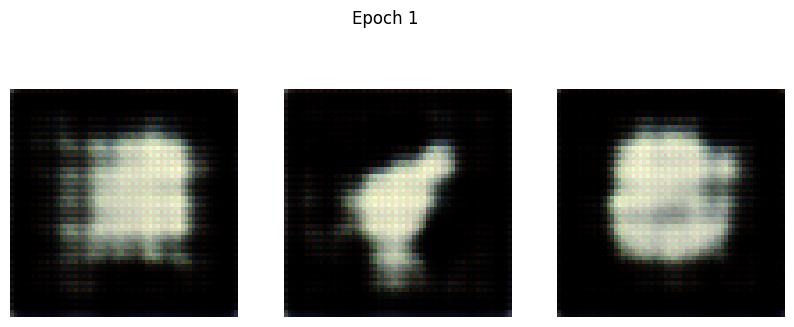

100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 213ms/step - d_loss: 0.4970 - g_loss: 0.7113
Epoch 2/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6719 - g_loss: 0.7297

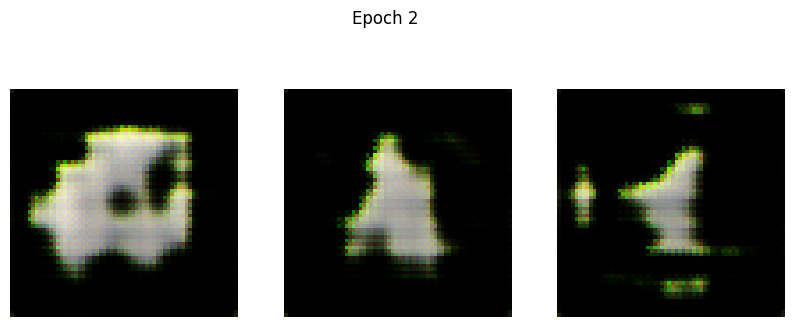

100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 122ms/step - d_loss: 0.6720 - g_loss: 0.7295
Epoch 3/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.6813 - g_loss: 0.6906

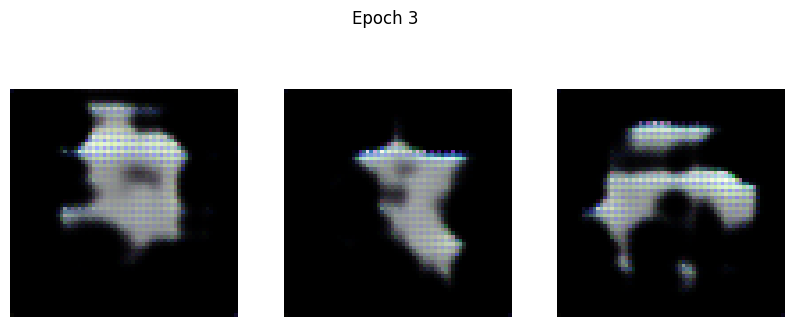

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.6812 - g_loss: 0.6907
Epoch 4/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.6675 - g_loss: 0.7405

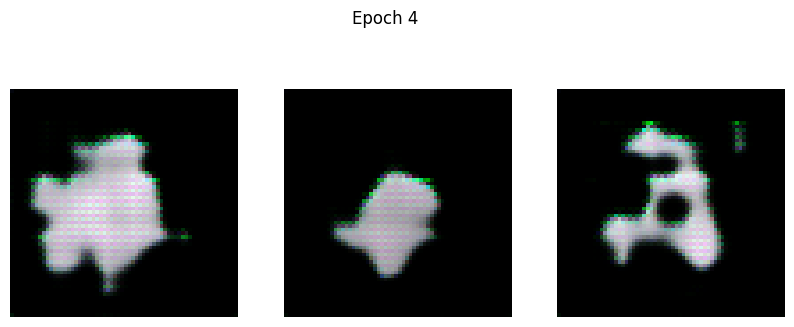

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.6675 - g_loss: 0.7406
Epoch 5/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.6578 - g_loss: 0.7419

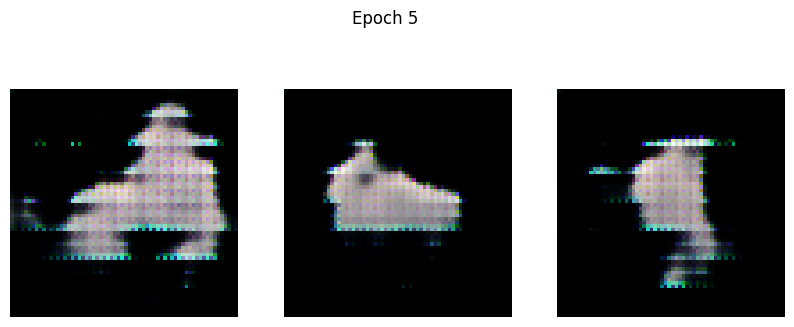

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.6578 - g_loss: 0.7422
Epoch 6/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.6916 - g_loss: 0.7889

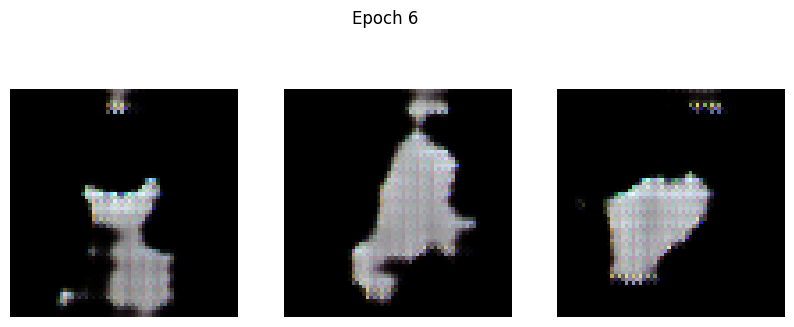

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.6914 - g_loss: 0.7887
Epoch 7/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6503 - g_loss: 0.8063

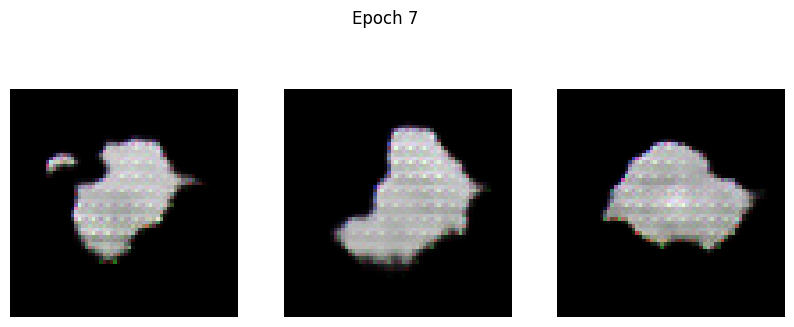

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.6504 - g_loss: 0.8062
Epoch 8/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6453 - g_loss: 0.8084

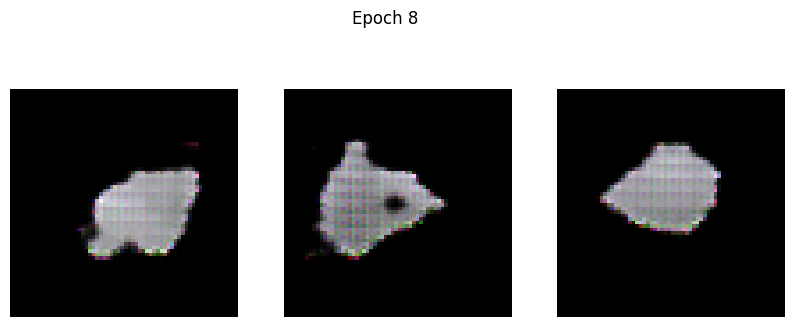

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.6454 - g_loss: 0.8083
Epoch 9/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6612 - g_loss: 0.7769

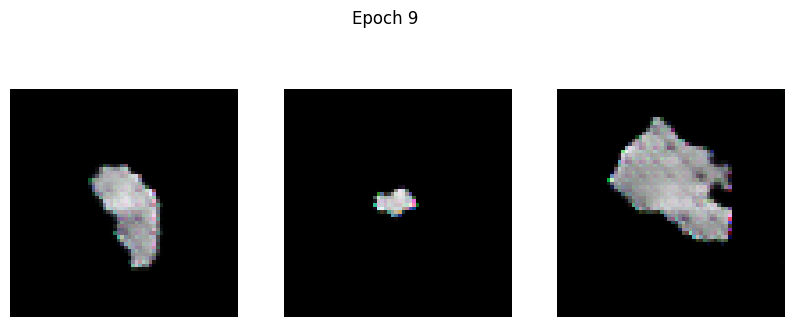

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.6612 - g_loss: 0.7768
Epoch 10/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.6518 - g_loss: 0.7688

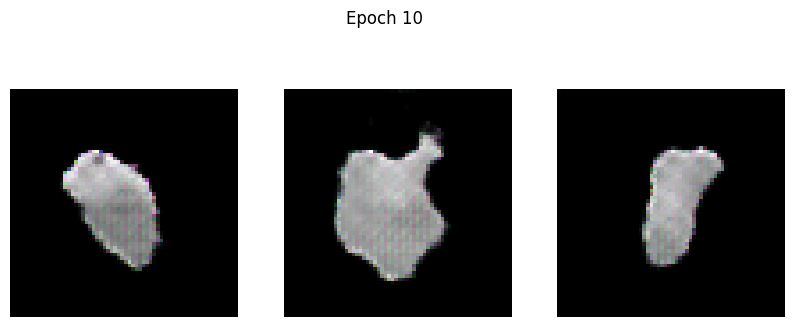

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.6518 - g_loss: 0.7686
Epoch 11/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.6484 - g_loss: 0.7726

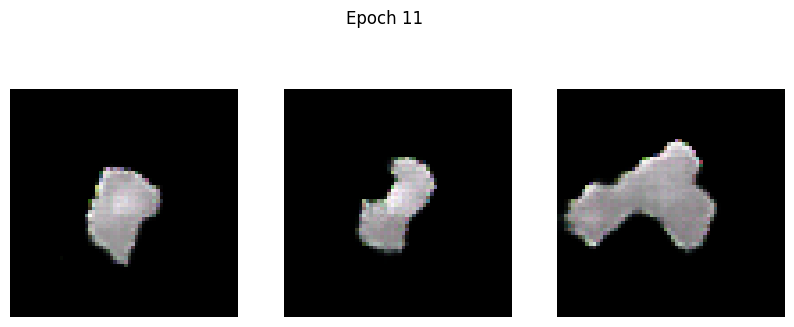

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.6484 - g_loss: 0.7726
Epoch 12/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6481 - g_loss: 0.8159

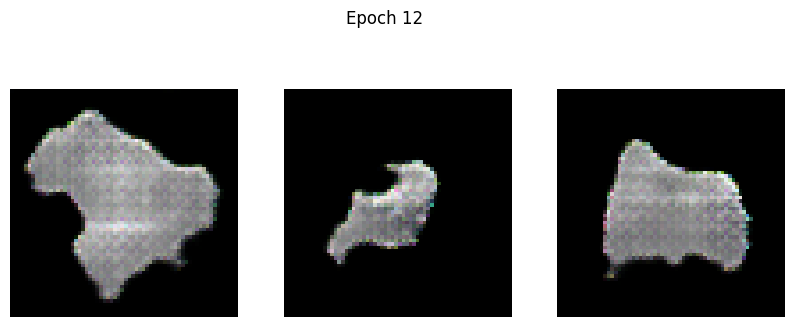

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.6481 - g_loss: 0.8159
Epoch 13/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6360 - g_loss: 0.8069

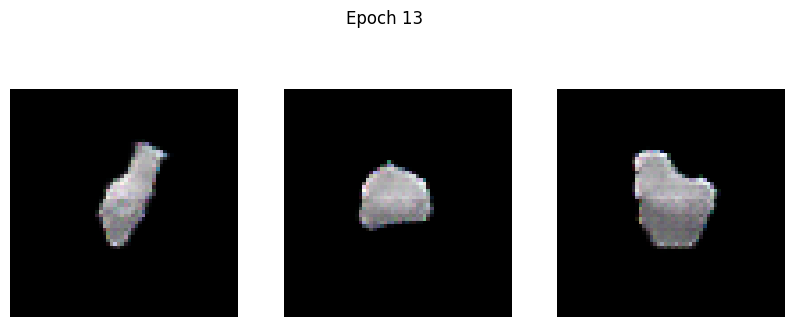

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.6360 - g_loss: 0.8070
Epoch 14/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6265 - g_loss: 0.8533

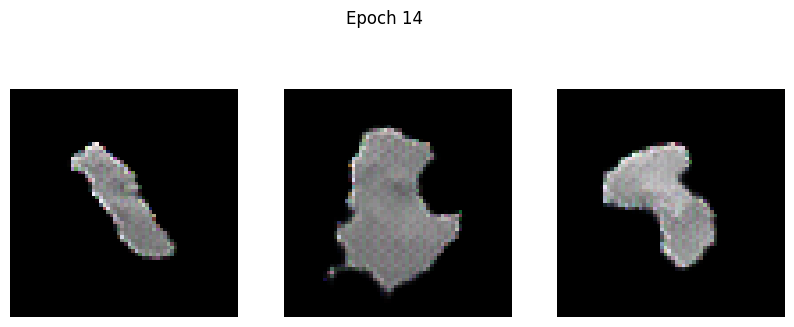

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.6264 - g_loss: 0.8535
Epoch 15/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6051 - g_loss: 0.8855

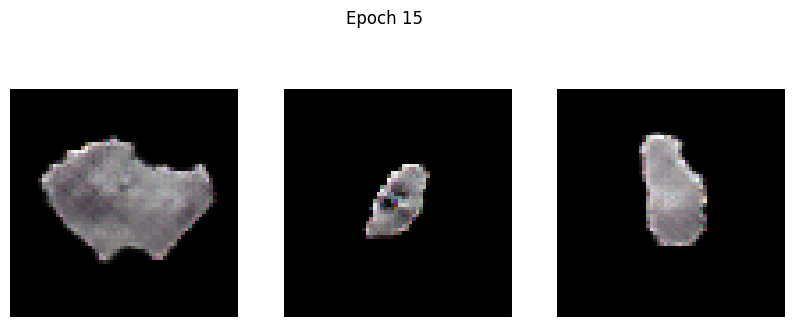

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.6052 - g_loss: 0.8856
Epoch 16/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5879 - g_loss: 0.9236

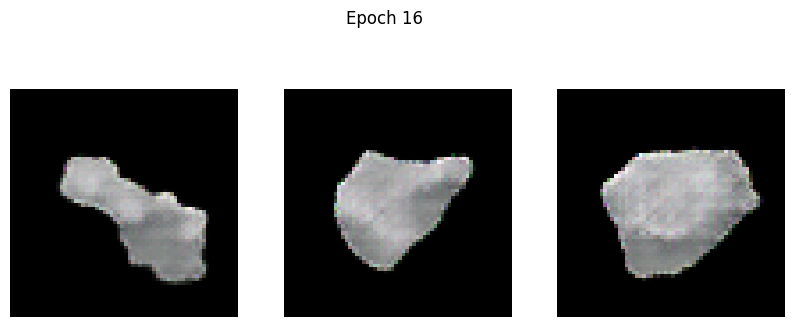

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5879 - g_loss: 0.9234
Epoch 17/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.5742 - g_loss: 0.9161

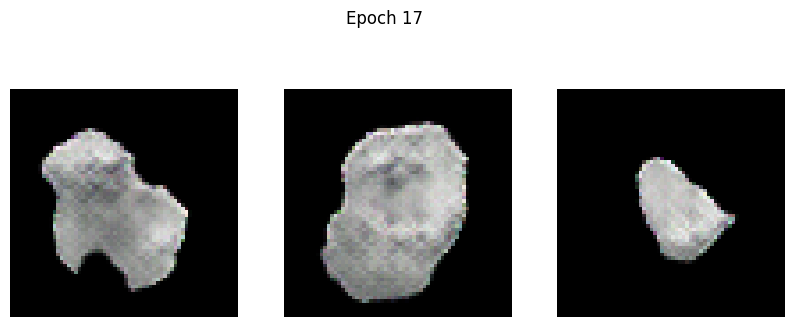

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.5743 - g_loss: 0.9162
Epoch 18/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5673 - g_loss: 0.9356

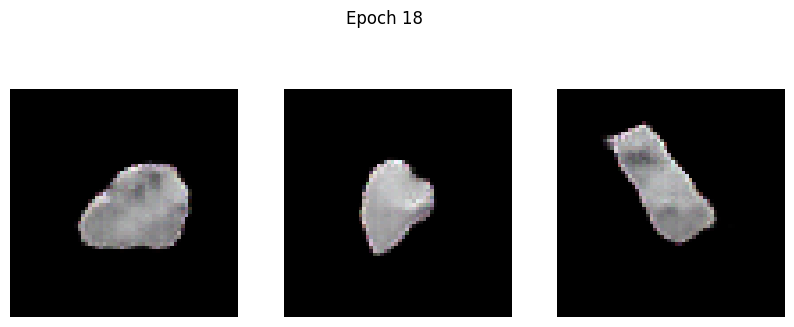

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5673 - g_loss: 0.9358
Epoch 19/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5543 - g_loss: 0.9960

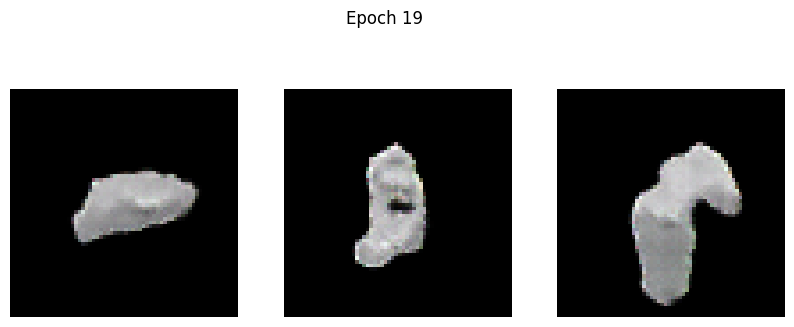

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5543 - g_loss: 0.9961
Epoch 20/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.5518 - g_loss: 1.0801

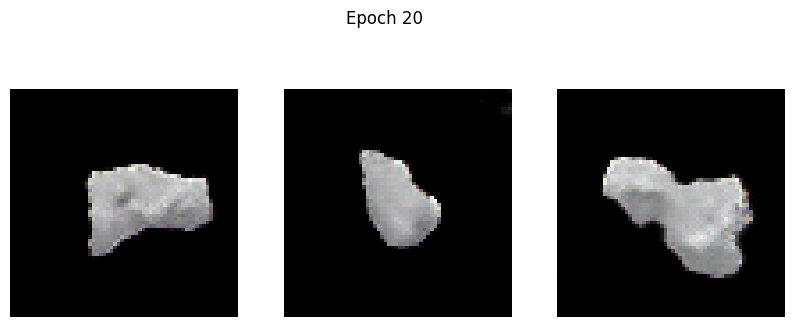

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5518 - g_loss: 1.0801
Epoch 21/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5246 - g_loss: 1.0637

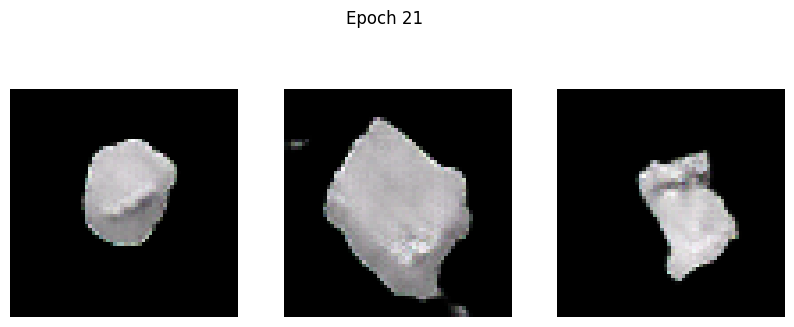

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5245 - g_loss: 1.0640
Epoch 22/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5320 - g_loss: 1.1197

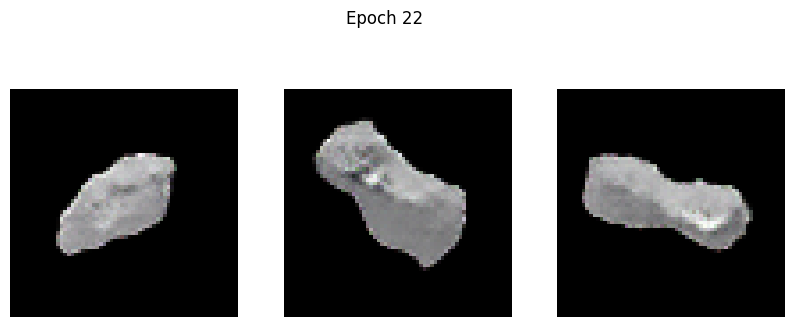

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5319 - g_loss: 1.1195
Epoch 23/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5159 - g_loss: 1.1856

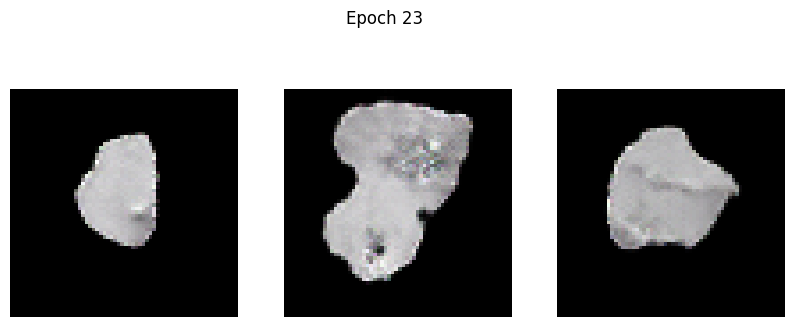

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.5157 - g_loss: 1.1854
Epoch 24/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4874 - g_loss: 1.2250

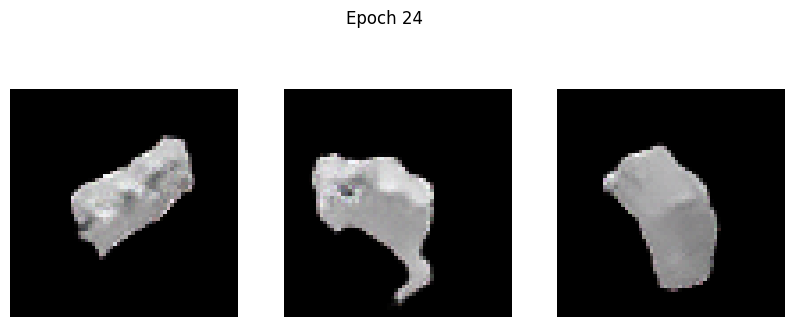

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4874 - g_loss: 1.2251
Epoch 25/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4647 - g_loss: 1.2029

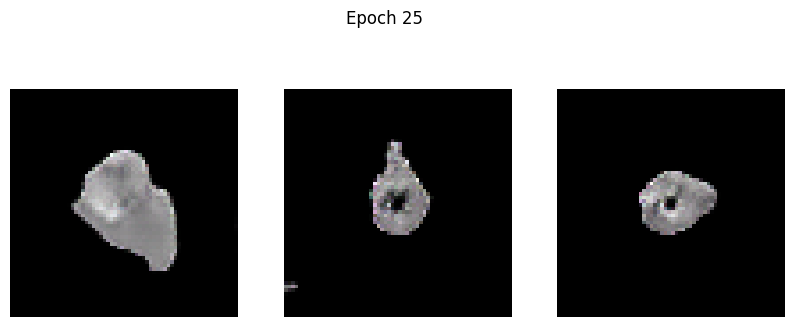

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4648 - g_loss: 1.2031
Epoch 26/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4561 - g_loss: 1.2608

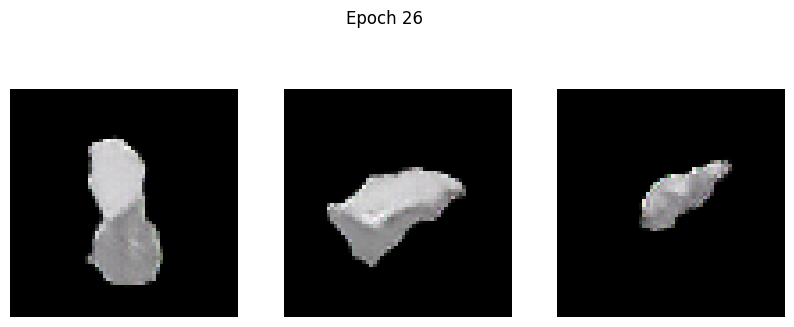

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4561 - g_loss: 1.2609
Epoch 27/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4634 - g_loss: 1.3089

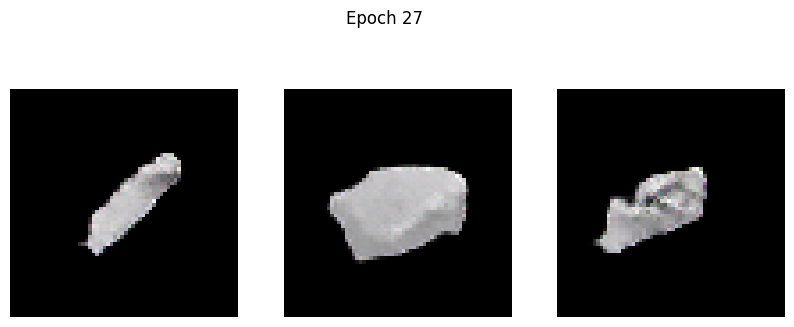

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4636 - g_loss: 1.3090
Epoch 28/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4351 - g_loss: 1.2934

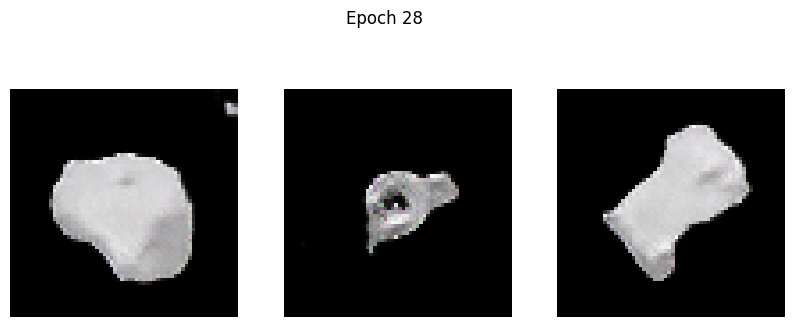

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4352 - g_loss: 1.2935
Epoch 29/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4195 - g_loss: 1.3485

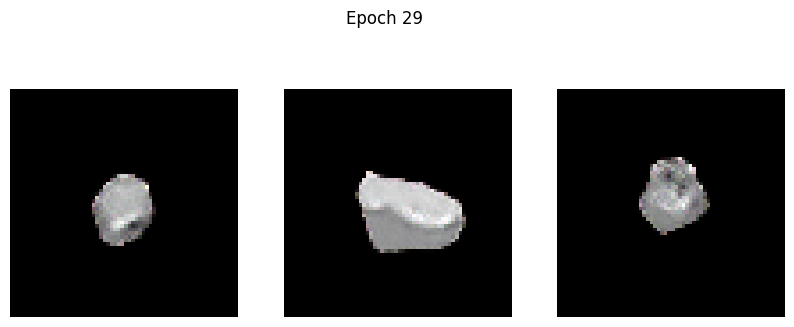

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4196 - g_loss: 1.3486
Epoch 30/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4336 - g_loss: 1.4518

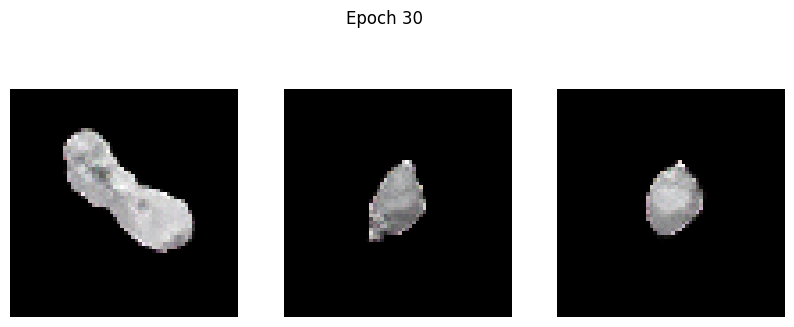

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4336 - g_loss: 1.4518
Epoch 31/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4270 - g_loss: 1.4355

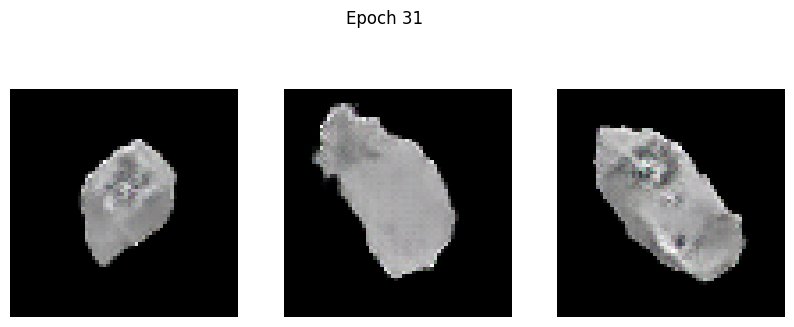

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4274 - g_loss: 1.4365
Epoch 32/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4080 - g_loss: 1.3155

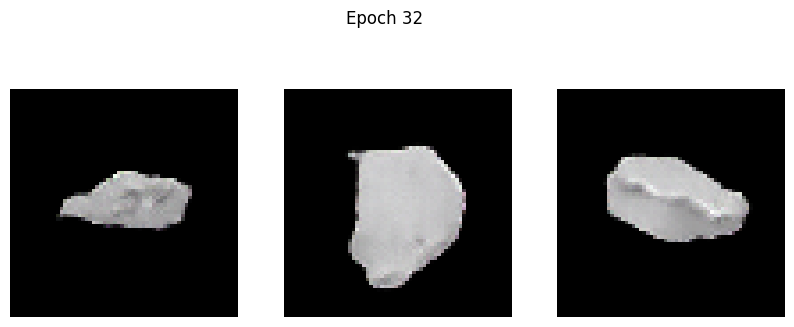

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4079 - g_loss: 1.3158
Epoch 33/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4192 - g_loss: 1.4663

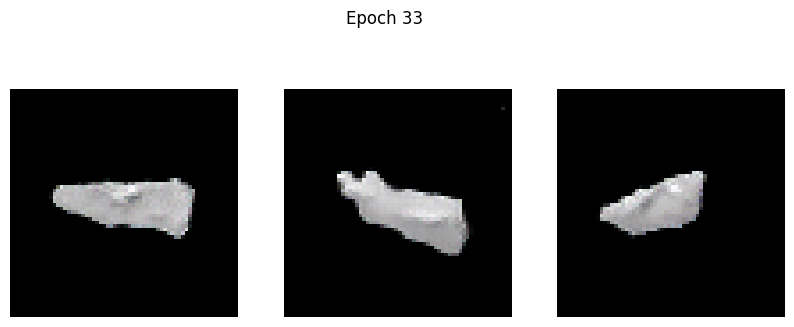

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4191 - g_loss: 1.4662
Epoch 34/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4139 - g_loss: 1.5093

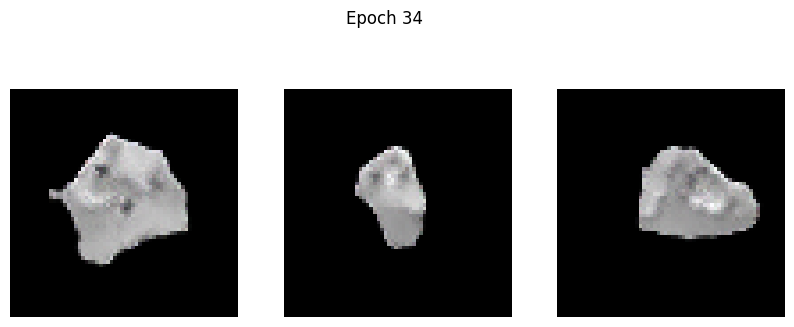

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4138 - g_loss: 1.5091
Epoch 35/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3992 - g_loss: 1.5266

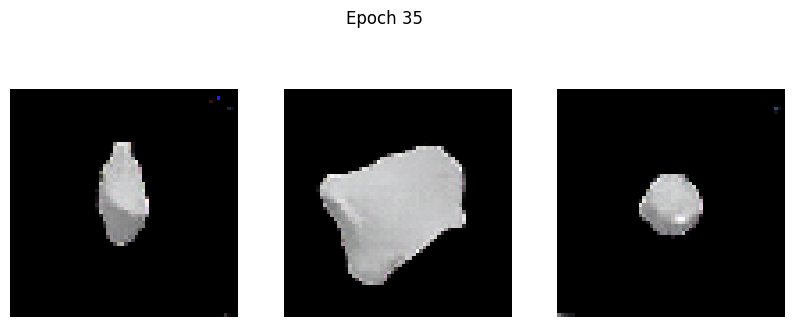

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3992 - g_loss: 1.5267
Epoch 36/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3995 - g_loss: 1.5147

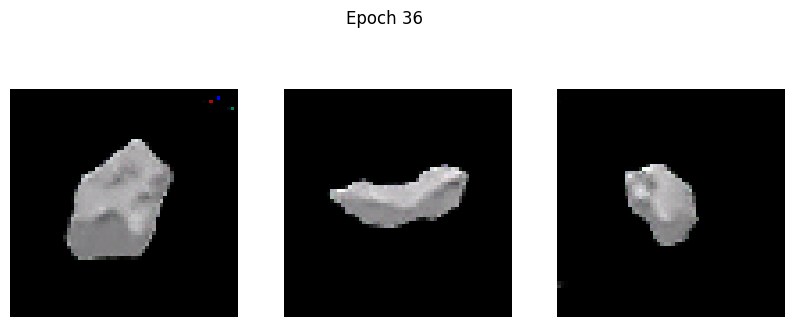

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3994 - g_loss: 1.5148
Epoch 37/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.4225 - g_loss: 1.6113

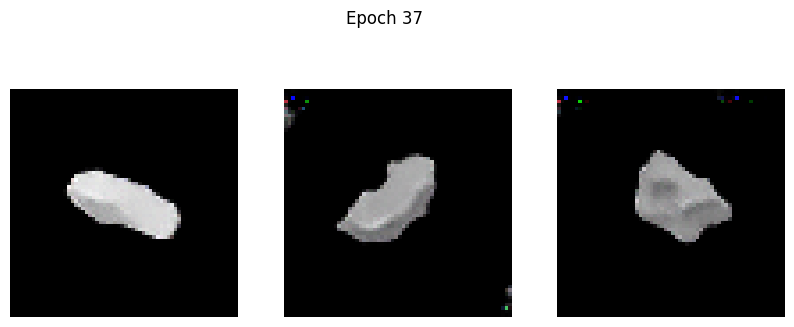

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4222 - g_loss: 1.6110
Epoch 38/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4245 - g_loss: 1.5609

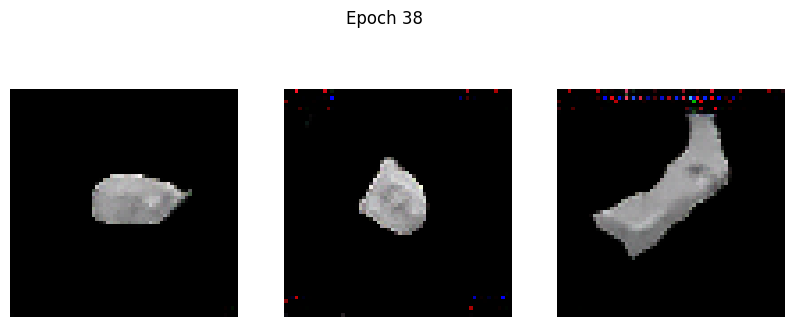

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4242 - g_loss: 1.5606
Epoch 39/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3804 - g_loss: 1.6314

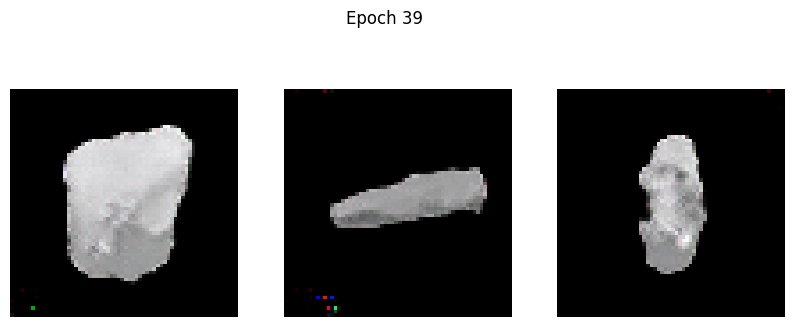

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3804 - g_loss: 1.6310
Epoch 40/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3998 - g_loss: 1.6637

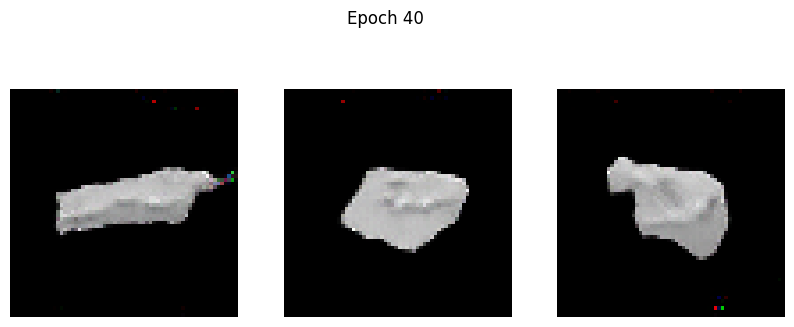

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4001 - g_loss: 1.6639
Epoch 41/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3633 - g_loss: 1.5593

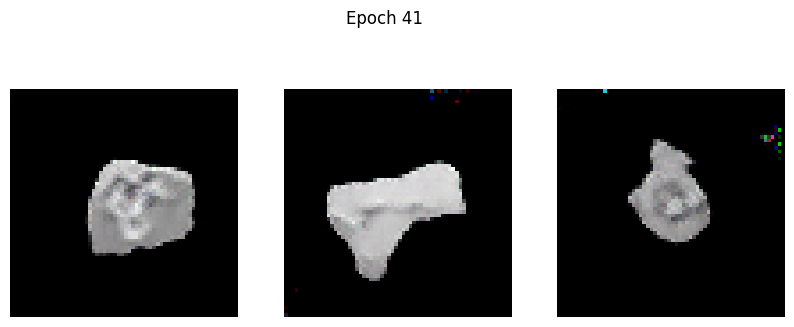

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3634 - g_loss: 1.5595
Epoch 42/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3590 - g_loss: 1.5694

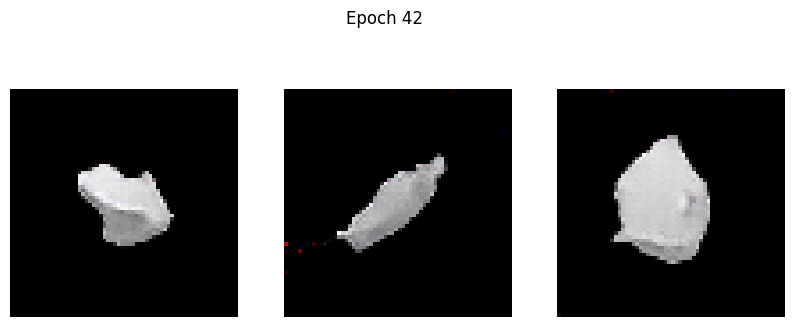

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3590 - g_loss: 1.5696
Epoch 43/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4096 - g_loss: 1.7715

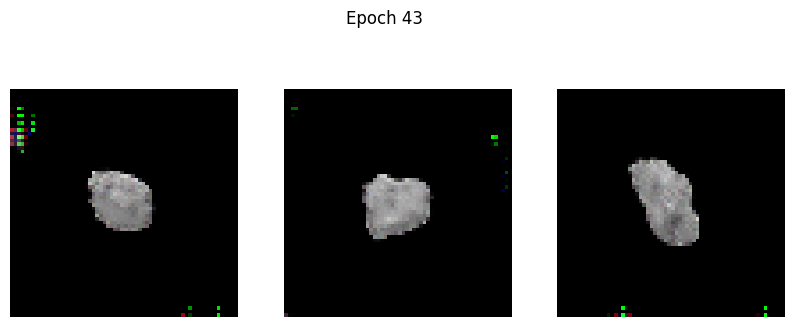

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4100 - g_loss: 1.7717
Epoch 44/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3487 - g_loss: 1.5391

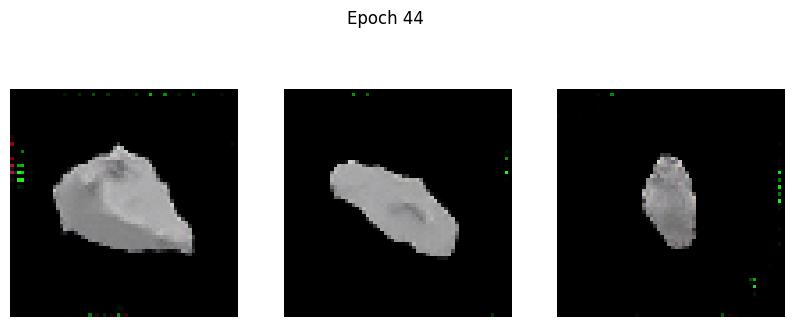

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3487 - g_loss: 1.5393
Epoch 45/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3502 - g_loss: 1.6483

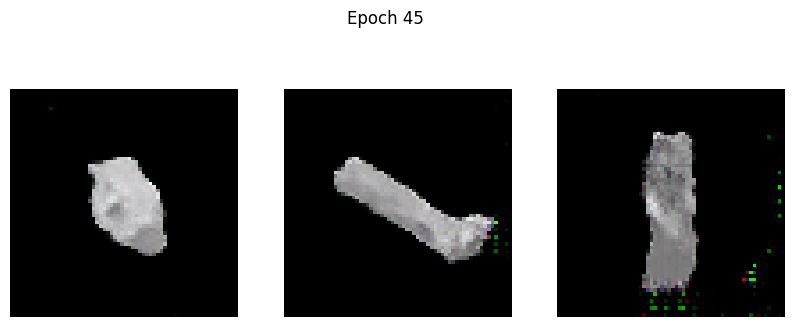

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3505 - g_loss: 1.6490
Epoch 46/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3432 - g_loss: 1.6258

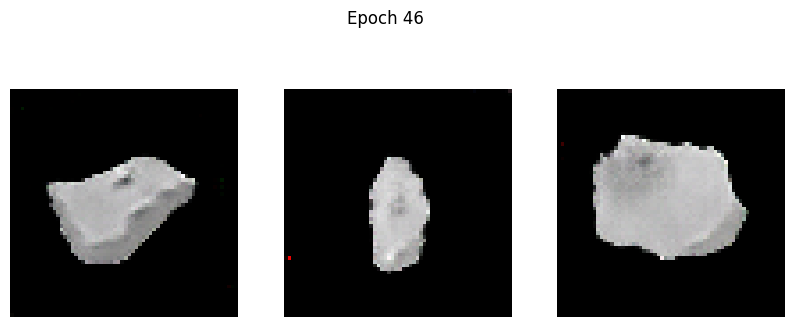

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3438 - g_loss: 1.6264
Epoch 47/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3311 - g_loss: 1.5635

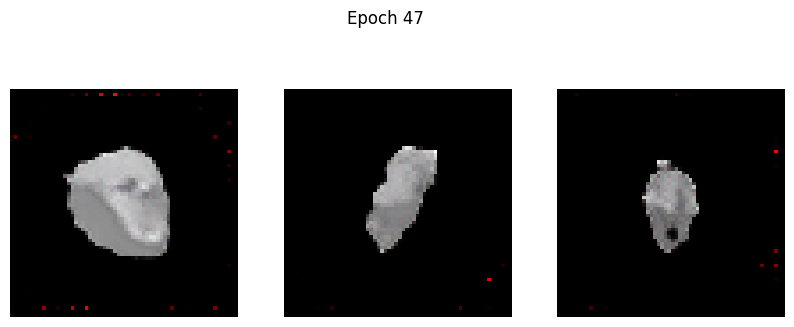

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3311 - g_loss: 1.5638
Epoch 48/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3668 - g_loss: 1.6992

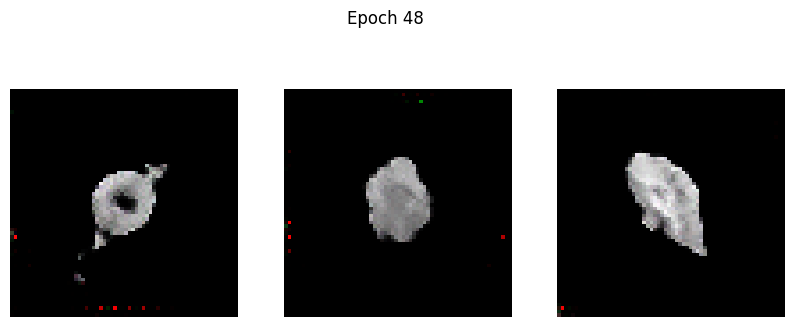

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3667 - g_loss: 1.6994
Epoch 49/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3524 - g_loss: 1.7176

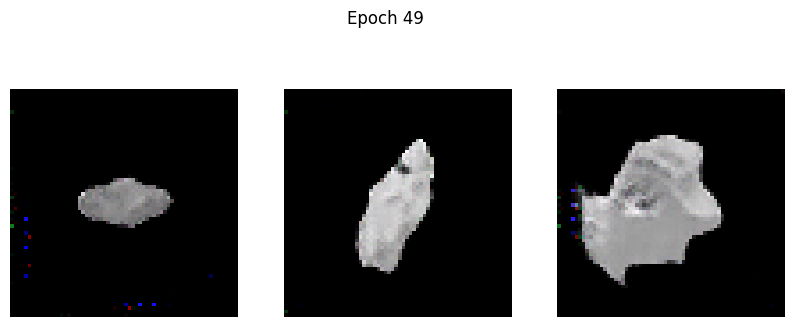

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3525 - g_loss: 1.7177
Epoch 50/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3249 - g_loss: 1.7290

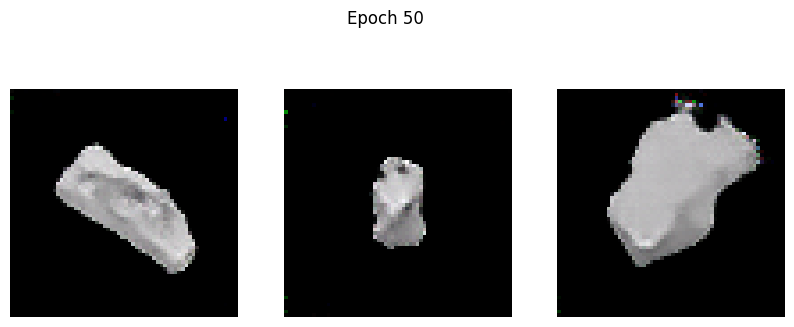

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3249 - g_loss: 1.7293
Epoch 51/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3447 - g_loss: 1.7832

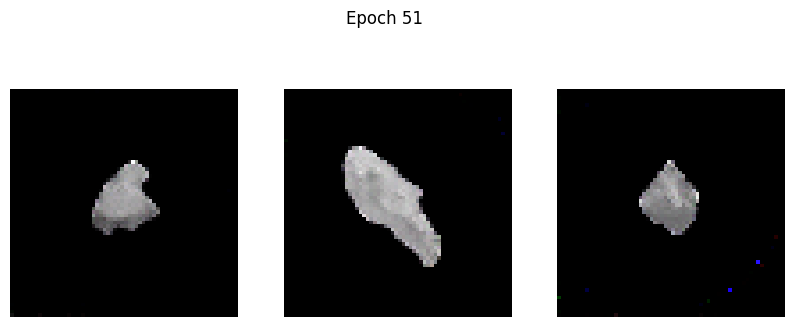

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3445 - g_loss: 1.7833
Epoch 52/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3523 - g_loss: 1.7862

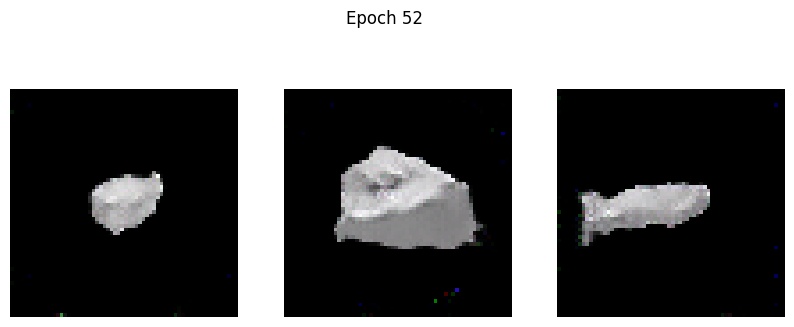

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3521 - g_loss: 1.7862
Epoch 53/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3473 - g_loss: 1.8474

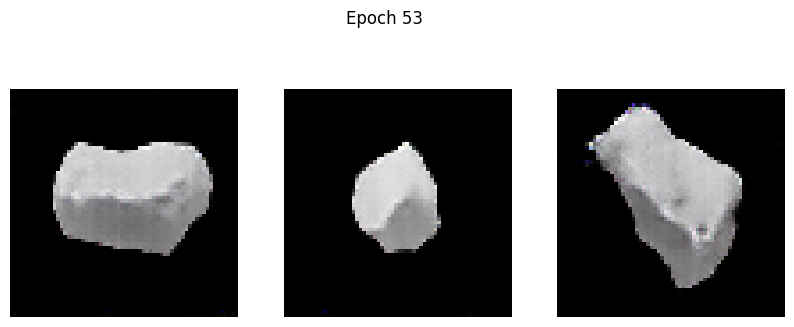

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3478 - g_loss: 1.8478
Epoch 54/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3241 - g_loss: 1.6817

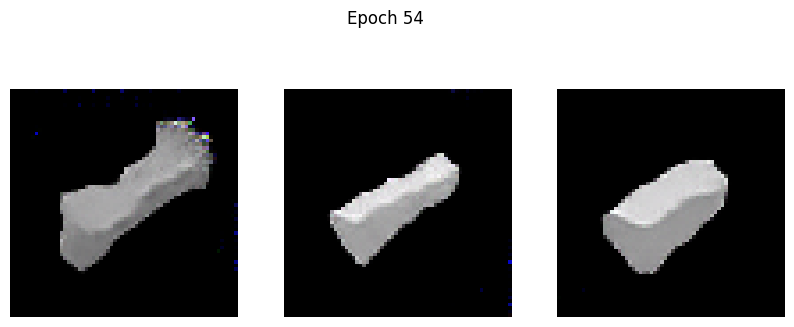

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.3241 - g_loss: 1.6820
Epoch 55/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3294 - g_loss: 1.7645

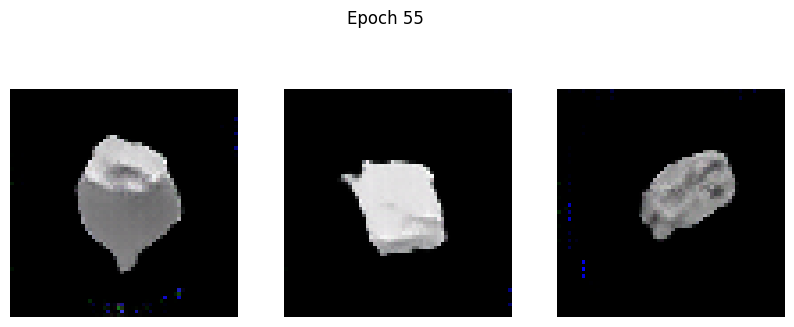

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3296 - g_loss: 1.7647
Epoch 56/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2927 - g_loss: 1.7892

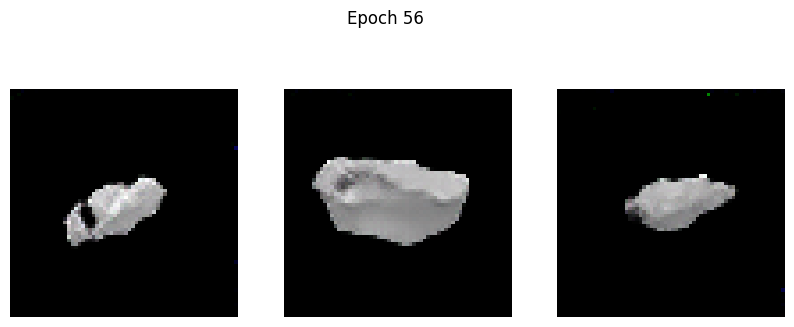

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2928 - g_loss: 1.7893
Epoch 57/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3208 - g_loss: 1.8824

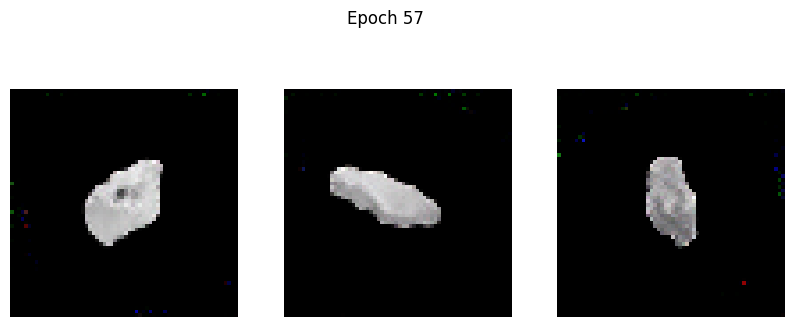

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3209 - g_loss: 1.8824
Epoch 58/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2992 - g_loss: 1.8574

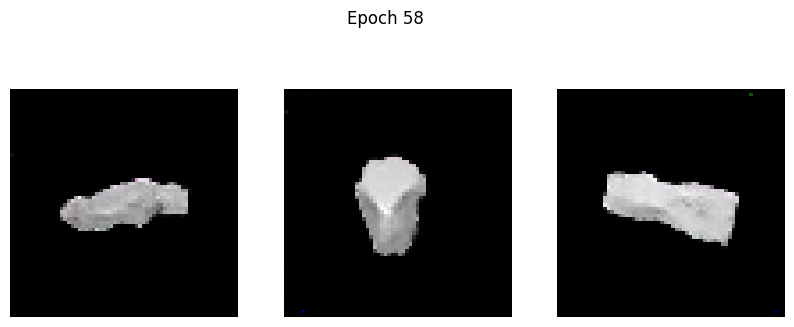

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2993 - g_loss: 1.8579
Epoch 59/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.4009 - g_loss: 1.9841

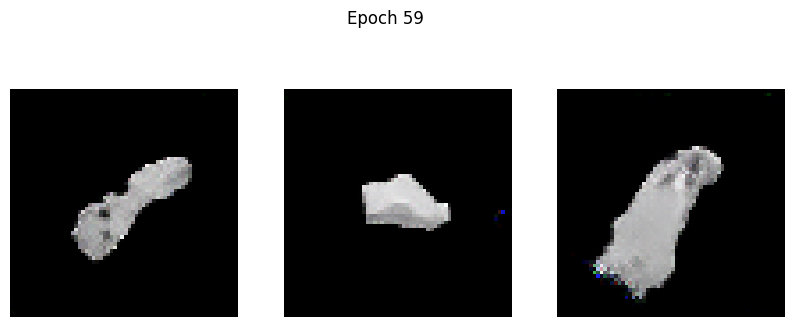

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4006 - g_loss: 1.9833
Epoch 60/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3074 - g_loss: 1.8985

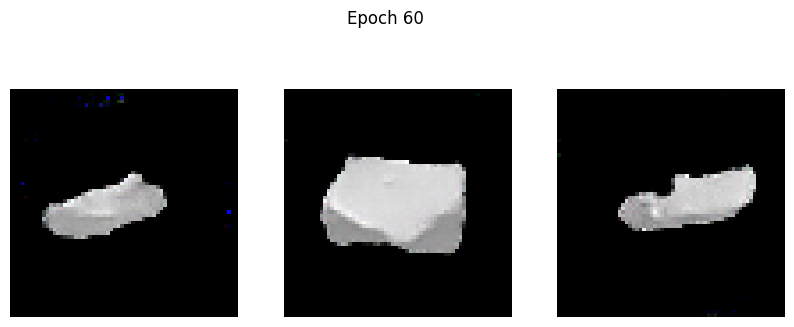

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3073 - g_loss: 1.8984
Epoch 61/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3241 - g_loss: 1.9985

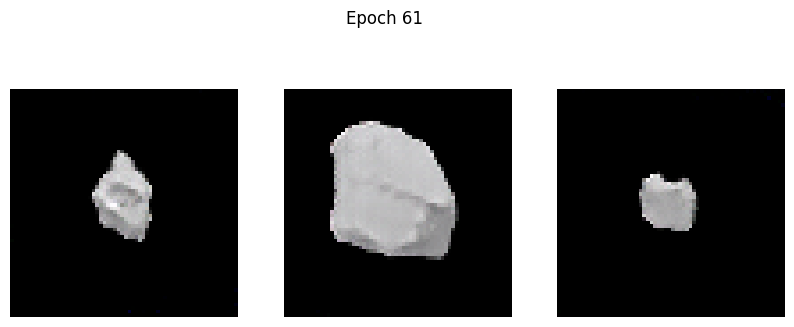

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3242 - g_loss: 1.9986
Epoch 62/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2779 - g_loss: 1.8634

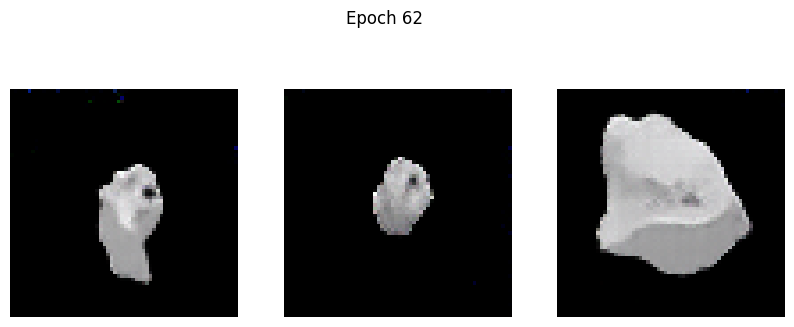

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2780 - g_loss: 1.8637
Epoch 63/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3485 - g_loss: 2.0257

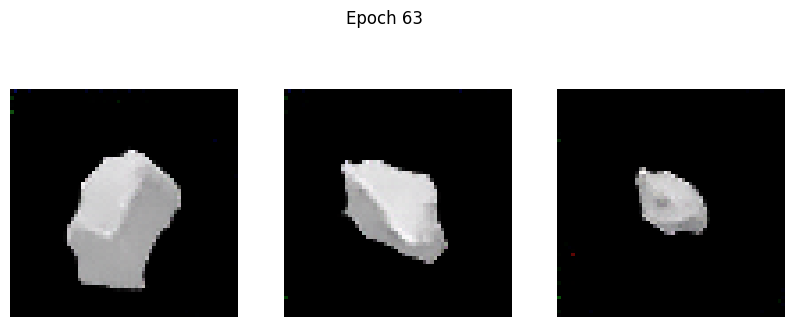

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3481 - g_loss: 2.0252
Epoch 64/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3257 - g_loss: 2.0127

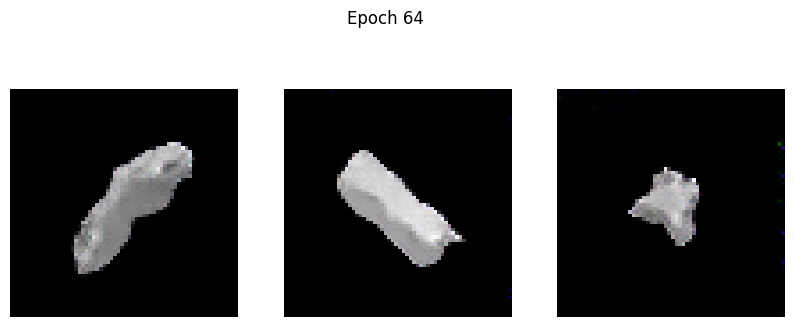

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3256 - g_loss: 2.0128
Epoch 65/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2932 - g_loss: 1.9597

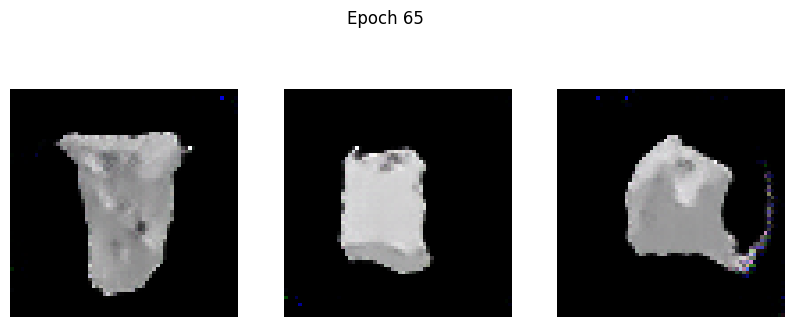

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2932 - g_loss: 1.9599
Epoch 66/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2967 - g_loss: 2.0651

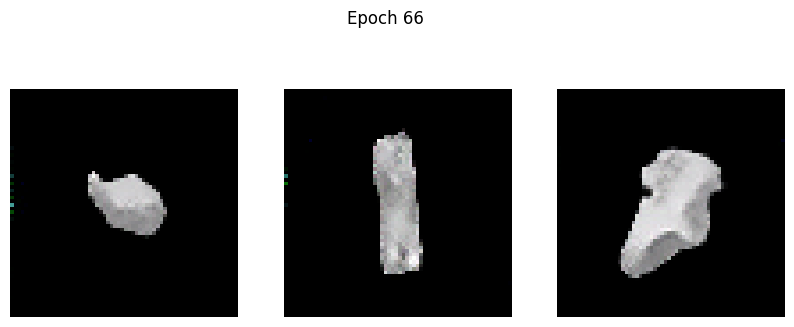

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2967 - g_loss: 2.0649
Epoch 67/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3949 - g_loss: 2.0809

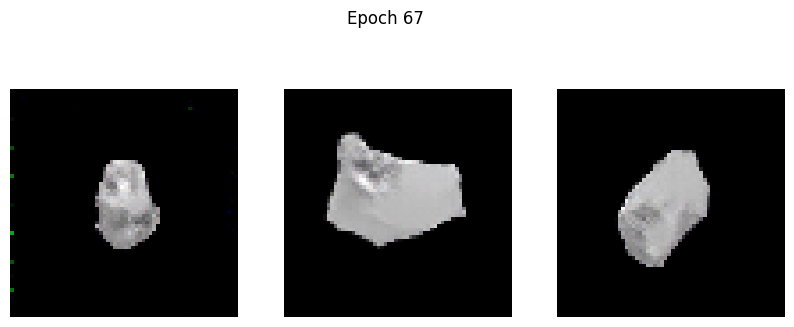

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3950 - g_loss: 2.0803
Epoch 68/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2650 - g_loss: 1.9134

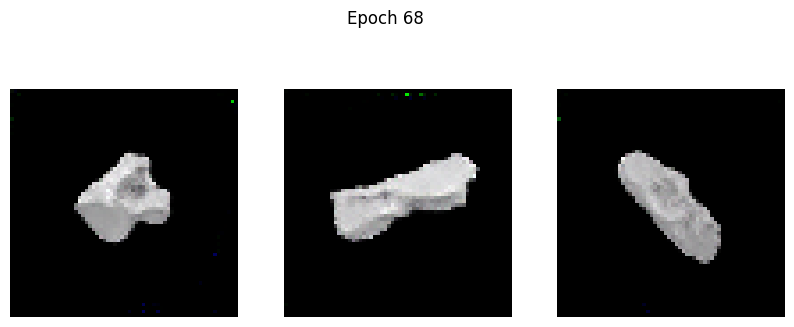

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2650 - g_loss: 1.9136
Epoch 69/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3009 - g_loss: 2.0354

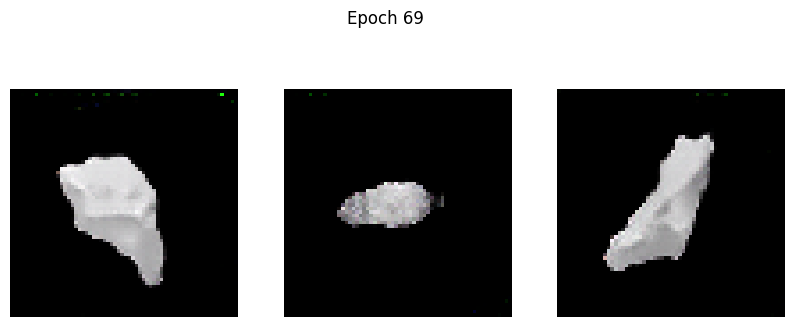

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3009 - g_loss: 2.0353
Epoch 70/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2688 - g_loss: 2.0059

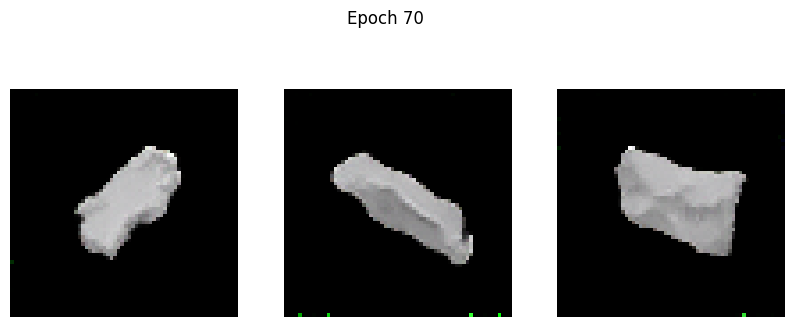

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2690 - g_loss: 2.0064
Epoch 71/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2872 - g_loss: 2.0955

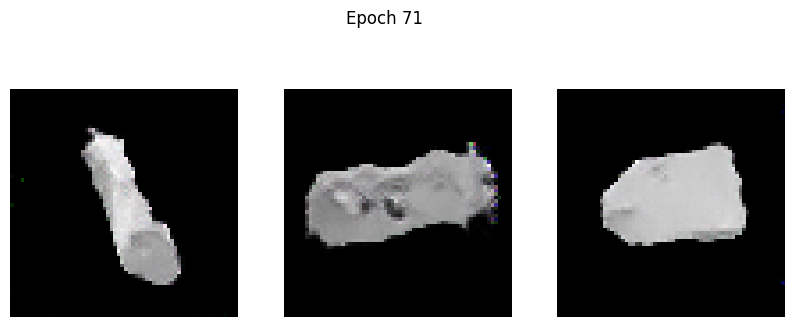

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2872 - g_loss: 2.0952
Epoch 72/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2751 - g_loss: 2.0668

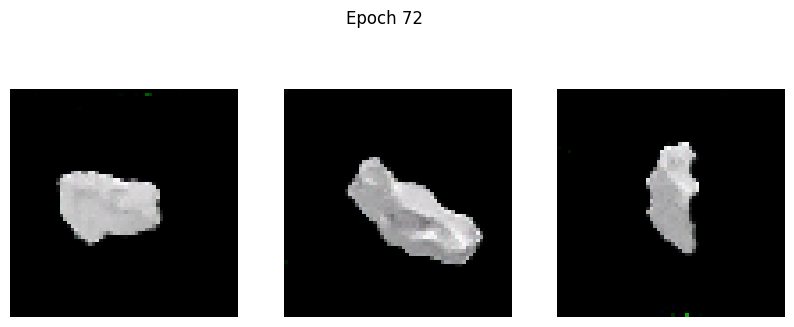

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2753 - g_loss: 2.0672
Epoch 73/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2624 - g_loss: 2.0942

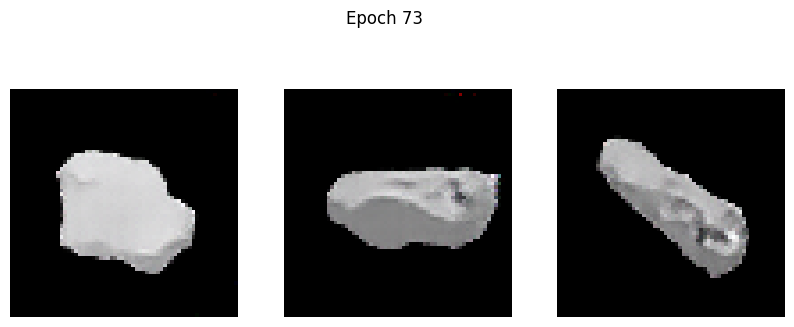

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2625 - g_loss: 2.0946
Epoch 74/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3016 - g_loss: 2.1357

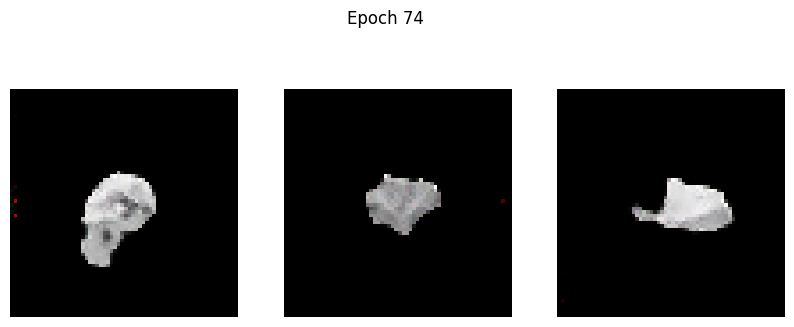

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3018 - g_loss: 2.1358
Epoch 75/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2374 - g_loss: 2.0369

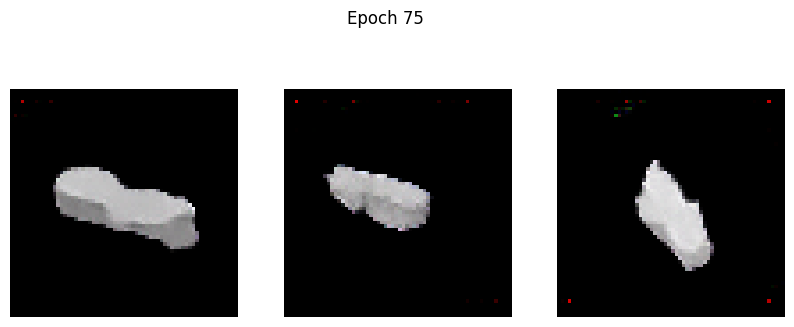

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2377 - g_loss: 2.0375
Epoch 76/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2549 - g_loss: 2.1205

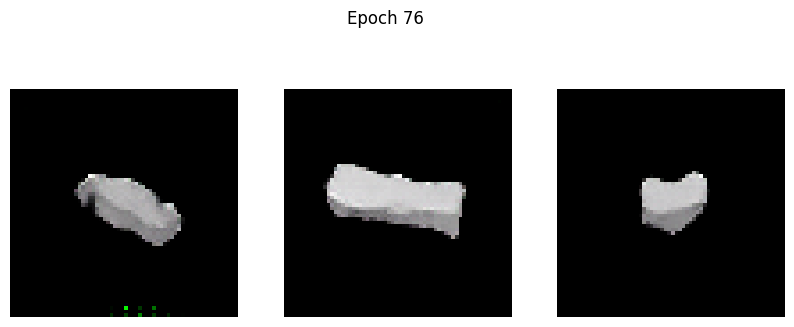

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2548 - g_loss: 2.1208
Epoch 77/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5354 - g_loss: 2.5214

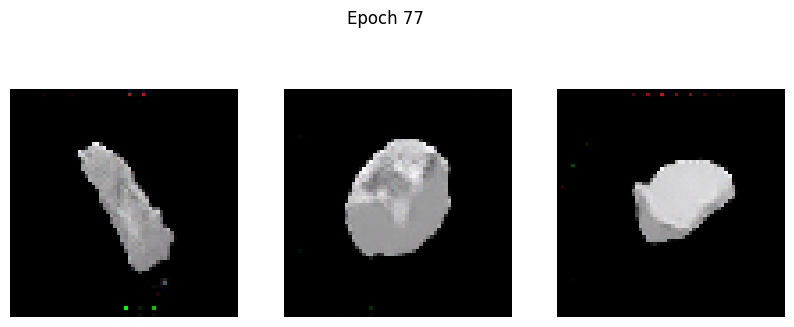

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5344 - g_loss: 2.5192
Epoch 78/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2575 - g_loss: 2.0251

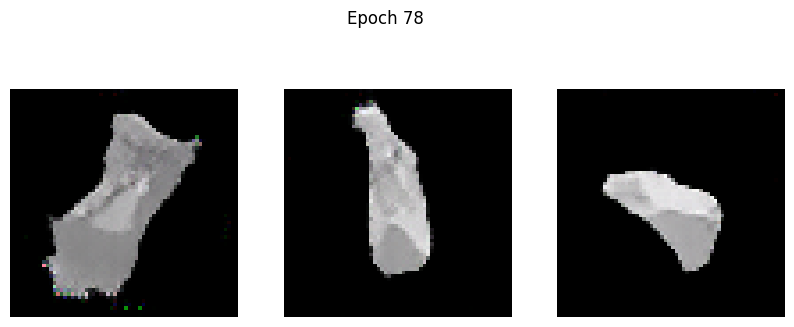

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2574 - g_loss: 2.0255
Epoch 79/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2471 - g_loss: 2.1042

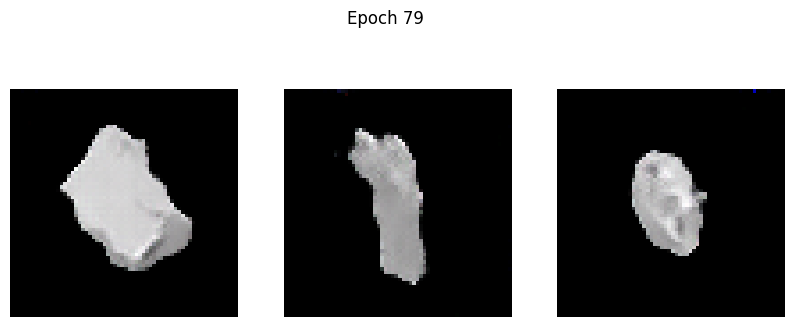

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2473 - g_loss: 2.1042
Epoch 80/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2633 - g_loss: 2.1740

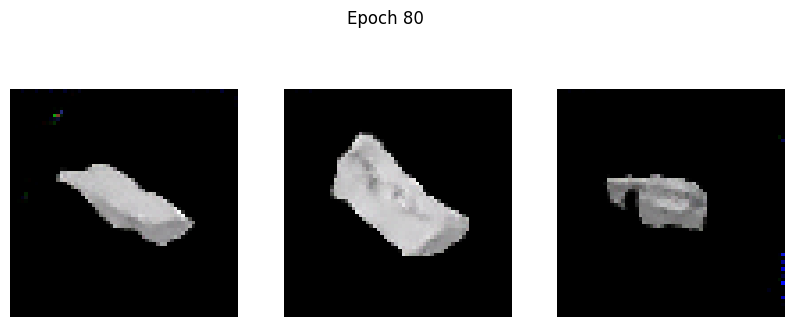

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2637 - g_loss: 2.1743
Epoch 81/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2429 - g_loss: 2.1747

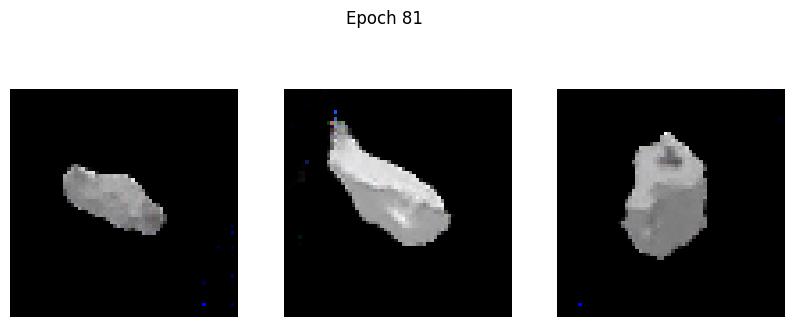

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2430 - g_loss: 2.1747
Epoch 82/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2466 - g_loss: 2.2065

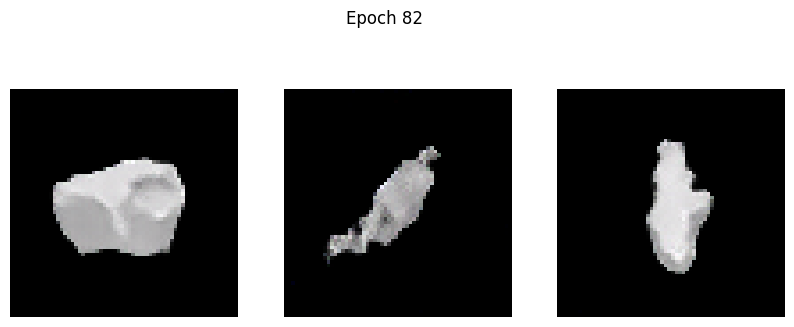

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2466 - g_loss: 2.2066
Epoch 83/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3081 - g_loss: 2.2414

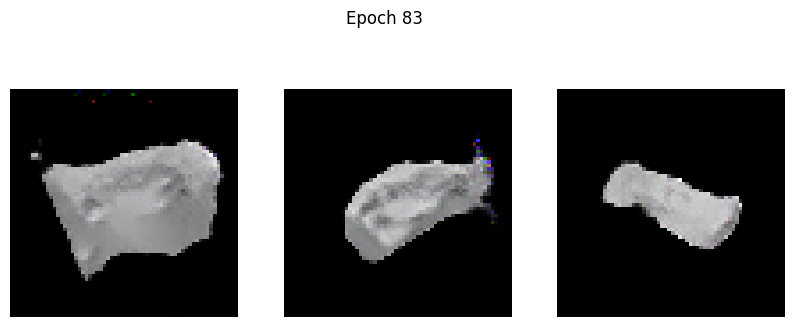

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3078 - g_loss: 2.2413
Epoch 84/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2585 - g_loss: 2.3125

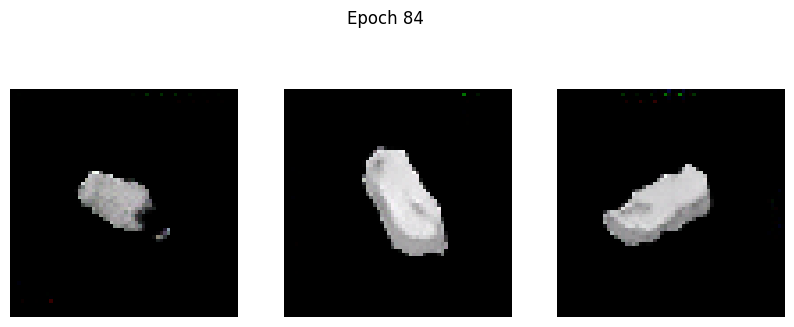

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2587 - g_loss: 2.3126
Epoch 85/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2479 - g_loss: 2.2938

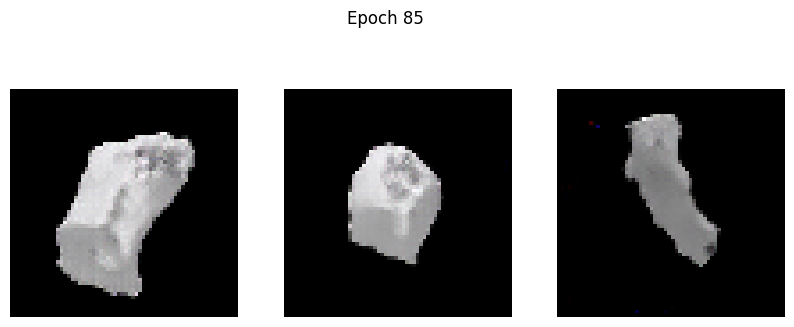

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2480 - g_loss: 2.2938
Epoch 86/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4074 - g_loss: 2.5835

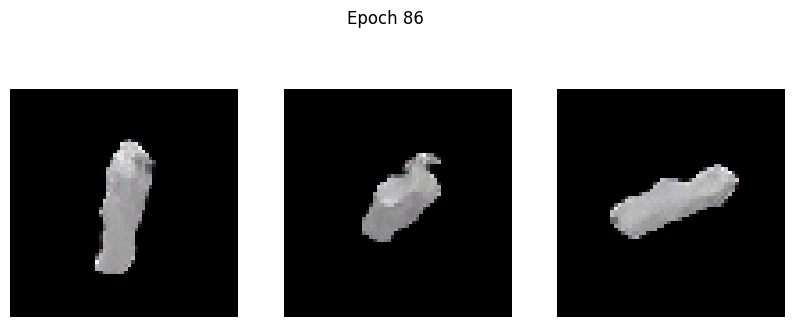

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4065 - g_loss: 2.5808
Epoch 87/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2313 - g_loss: 2.1744

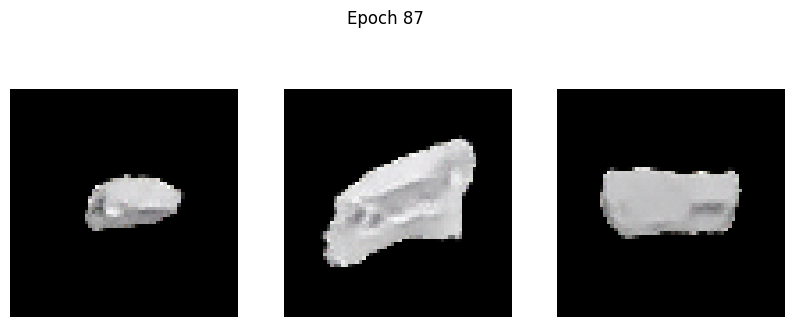

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - d_loss: 0.2313 - g_loss: 2.1746
Epoch 88/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2645 - g_loss: 2.3217

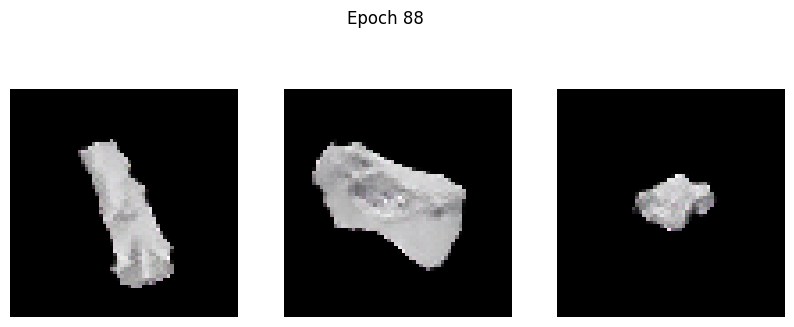

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2646 - g_loss: 2.3219
Epoch 89/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2455 - g_loss: 2.3255

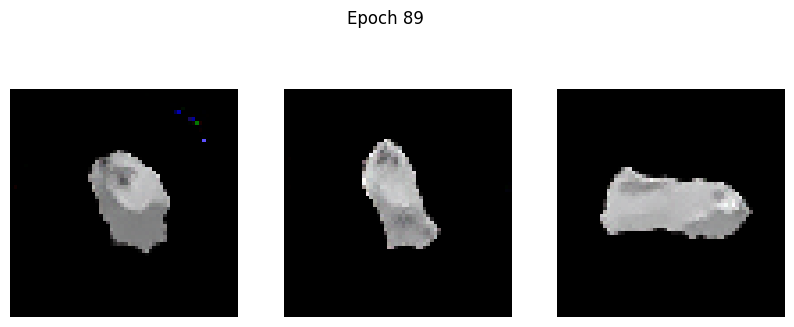

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2455 - g_loss: 2.3257
Epoch 90/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2469 - g_loss: 2.3840

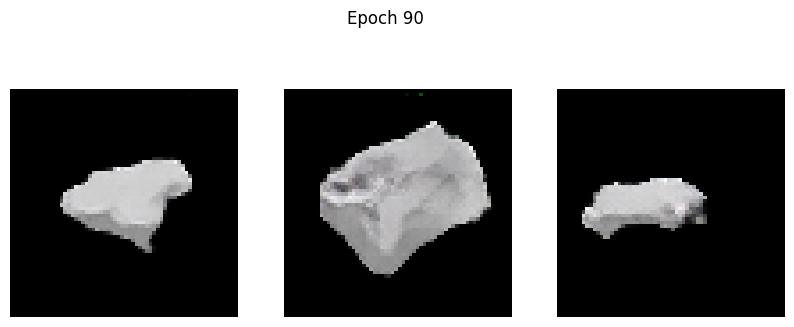

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2470 - g_loss: 2.3838
Epoch 91/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2583 - g_loss: 2.3987

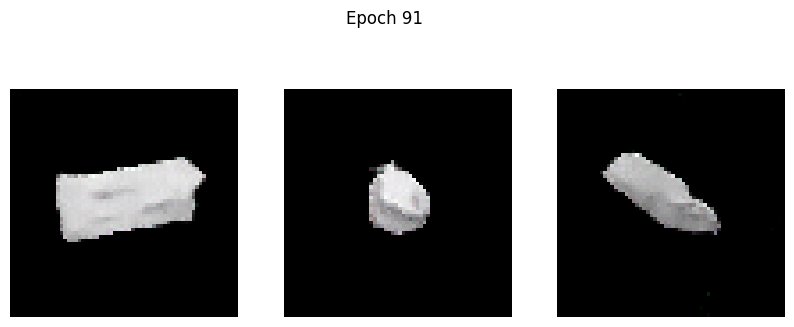

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2585 - g_loss: 2.3992
Epoch 92/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2287 - g_loss: 2.2825

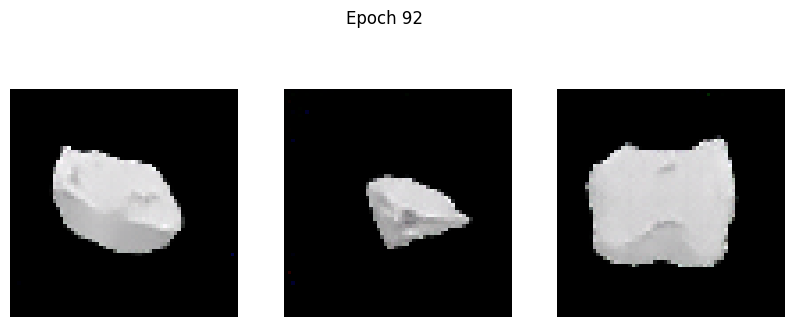

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2287 - g_loss: 2.2825
Epoch 93/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3378 - g_loss: 2.4959

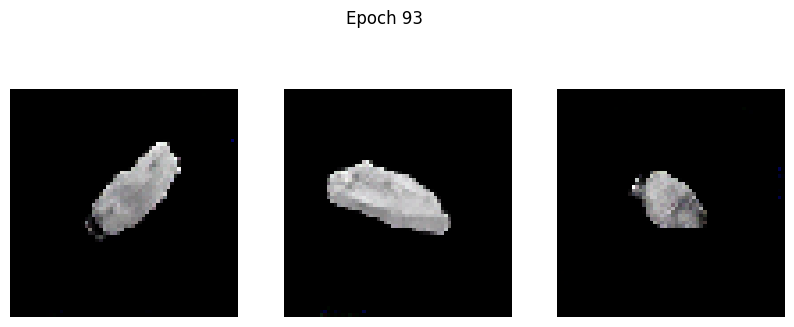

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3373 - g_loss: 2.4950
Epoch 94/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2448 - g_loss: 2.2867

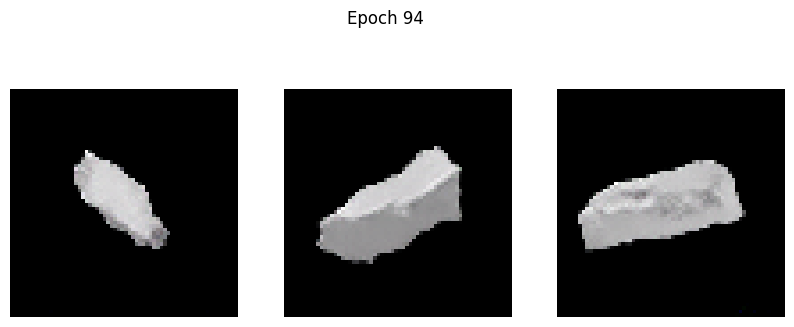

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2445 - g_loss: 2.2870
Epoch 95/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2424 - g_loss: 2.4968

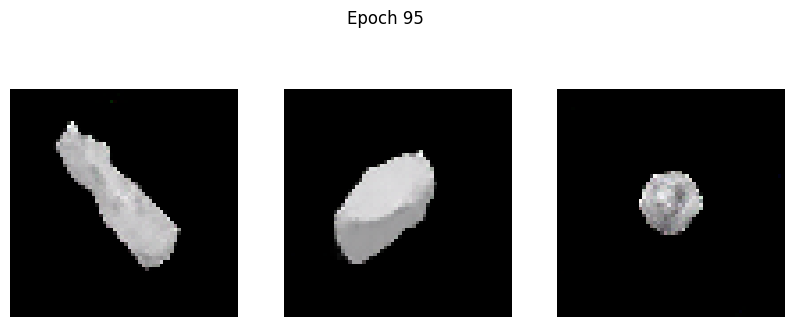

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2422 - g_loss: 2.4960
Epoch 96/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2483 - g_loss: 2.4051

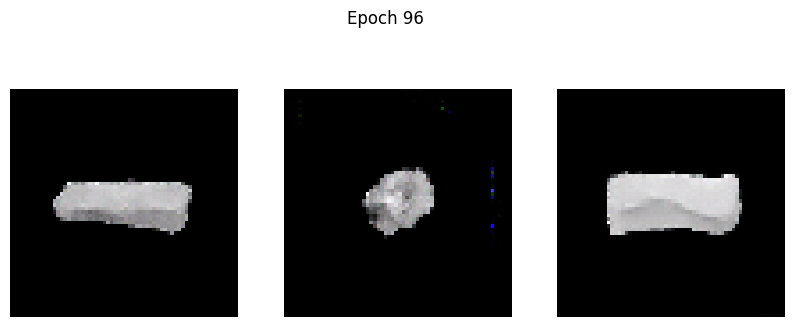

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2484 - g_loss: 2.4054
Epoch 97/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2344 - g_loss: 2.4155

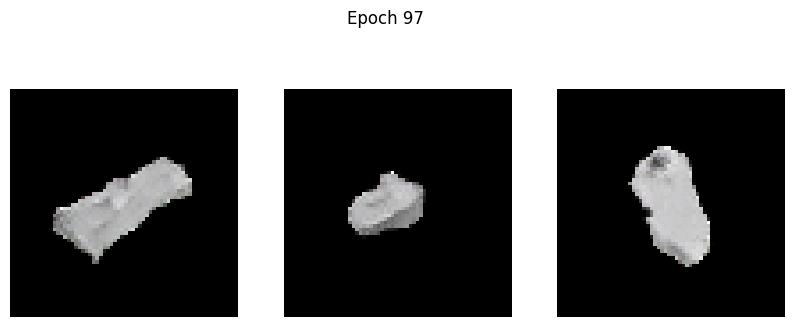

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2349 - g_loss: 2.4174
Epoch 98/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2414 - g_loss: 2.4203

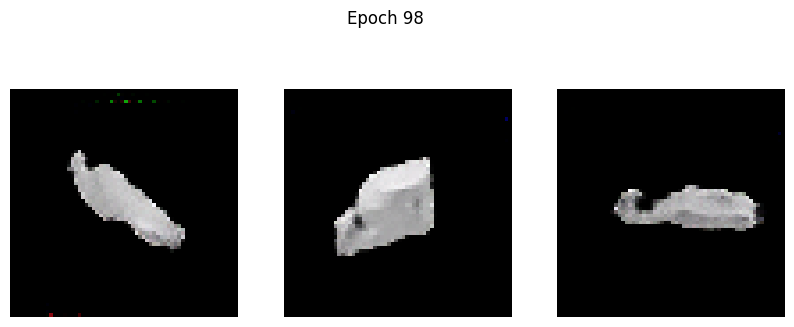

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2414 - g_loss: 2.4204
Epoch 99/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2213 - g_loss: 2.4281

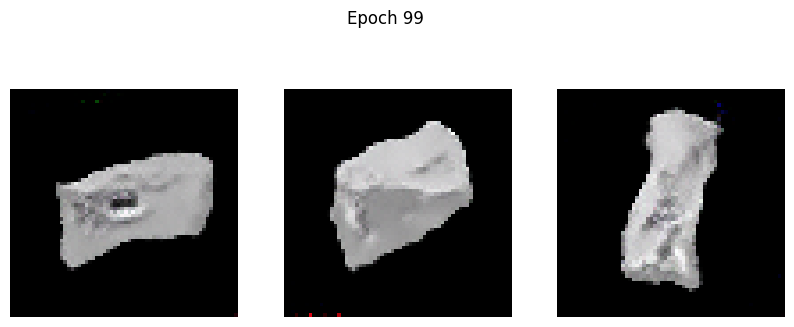

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2213 - g_loss: 2.4279
Epoch 100/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2680 - g_loss: 2.4988

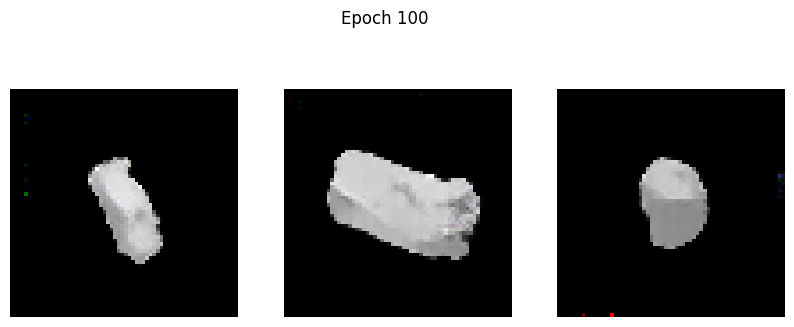

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2681 - g_loss: 2.4986
Epoch 101/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2078 - g_loss: 2.3922

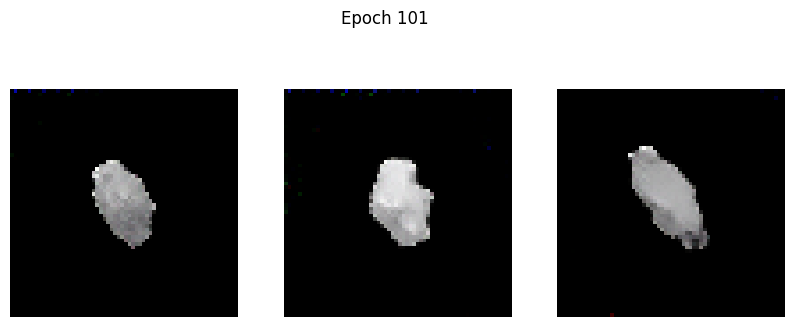

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2079 - g_loss: 2.3923
Epoch 102/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2174 - g_loss: 2.4156

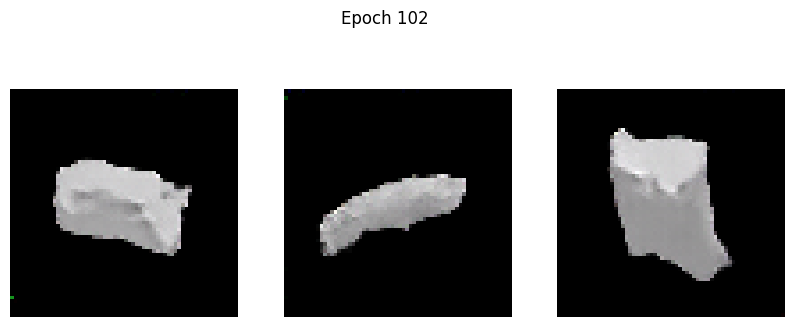

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2176 - g_loss: 2.4161
Epoch 103/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2247 - g_loss: 2.4531

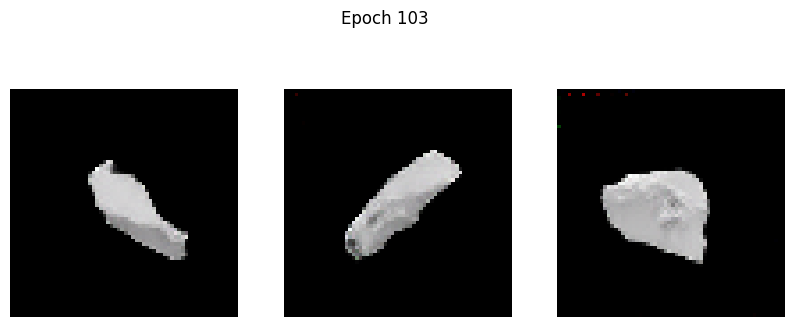

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2247 - g_loss: 2.4532
Epoch 104/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2645 - g_loss: 2.5516

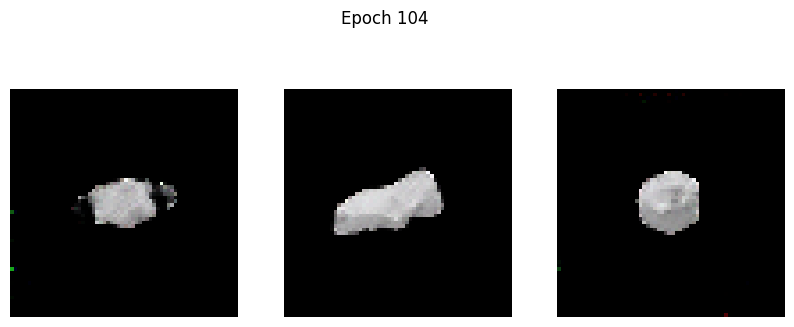

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2650 - g_loss: 2.5521
Epoch 105/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2167 - g_loss: 2.4518

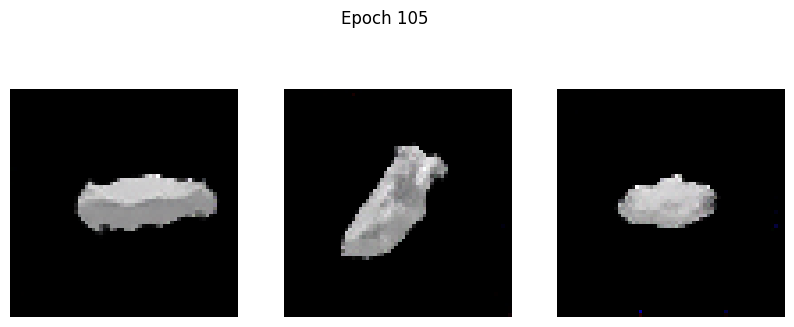

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2167 - g_loss: 2.4519
Epoch 106/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2324 - g_loss: 2.5040

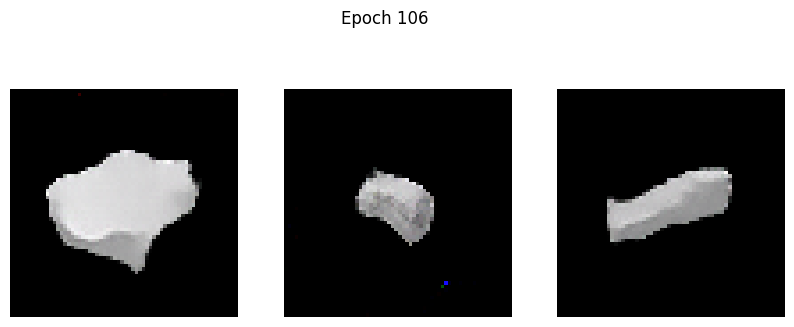

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2323 - g_loss: 2.5040
Epoch 107/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2298 - g_loss: 2.5495

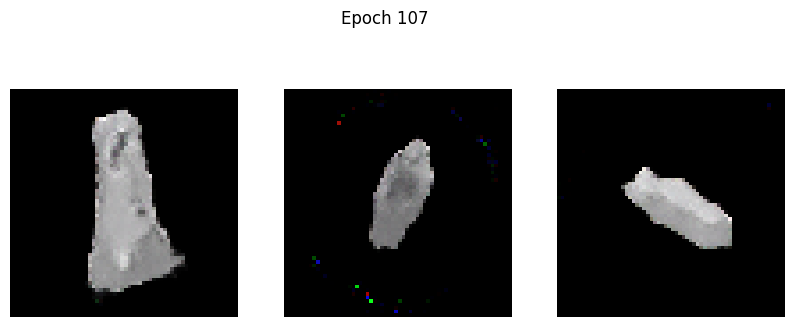

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2299 - g_loss: 2.5496
Epoch 108/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3838 - g_loss: 2.7232

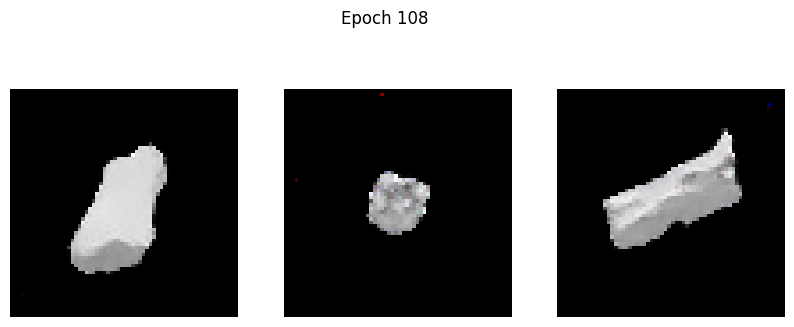

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3828 - g_loss: 2.7214
Epoch 109/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1760 - g_loss: 2.4267

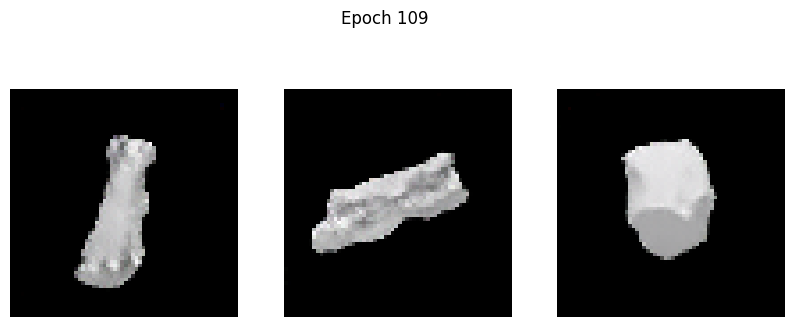

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1761 - g_loss: 2.4269
Epoch 110/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2139 - g_loss: 2.5580

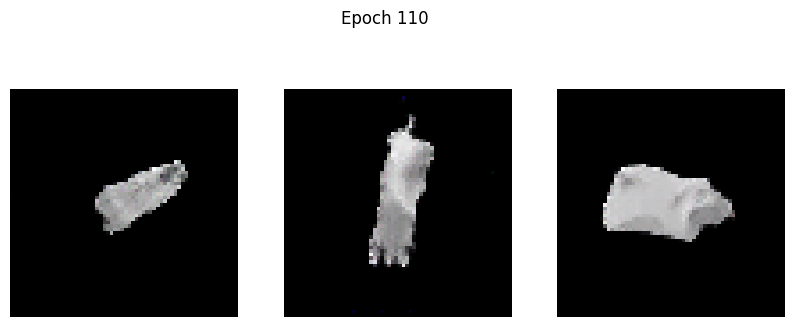

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2138 - g_loss: 2.5580
Epoch 111/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2136 - g_loss: 2.6187

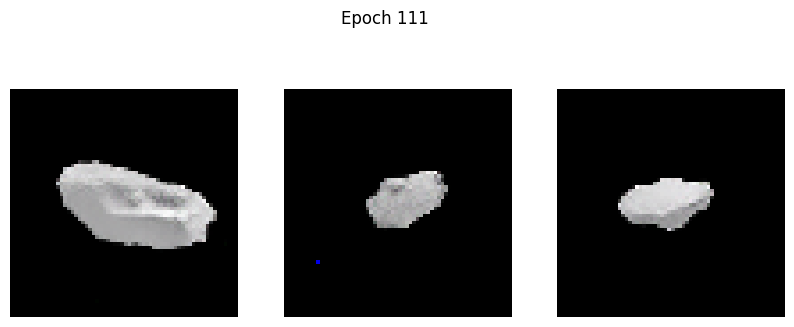

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - d_loss: 0.2135 - g_loss: 2.6185
Epoch 112/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2267 - g_loss: 2.6230

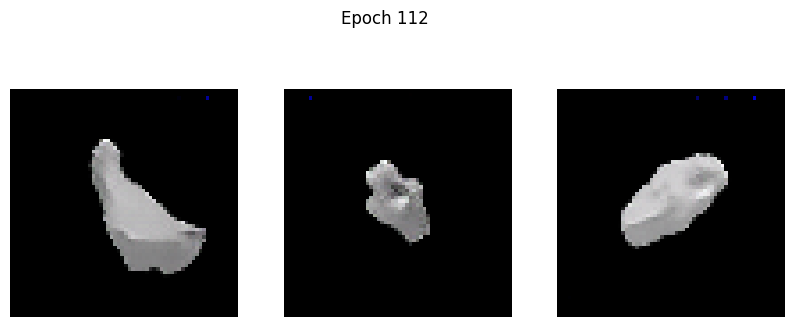

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.2269 - g_loss: 2.6233
Epoch 113/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2210 - g_loss: 2.6161

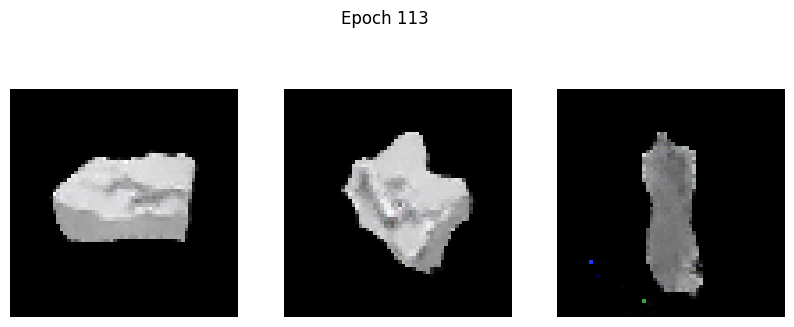

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - d_loss: 0.2212 - g_loss: 2.6163
Epoch 114/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2062 - g_loss: 2.5842

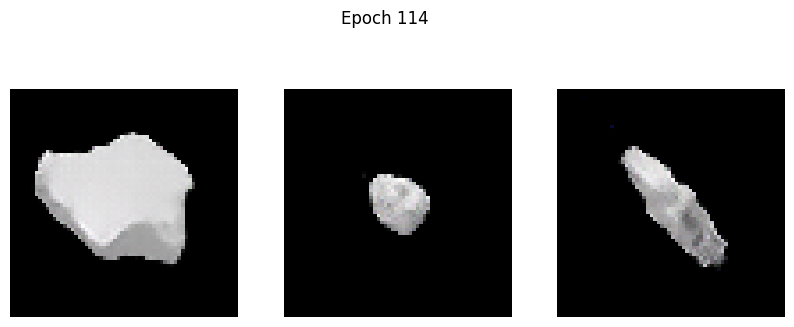

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2062 - g_loss: 2.5845
Epoch 115/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1894 - g_loss: 2.5690

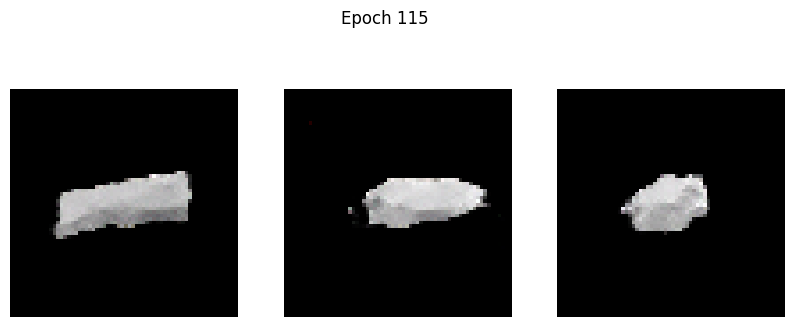

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1896 - g_loss: 2.5696
Epoch 116/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2862 - g_loss: 2.7850

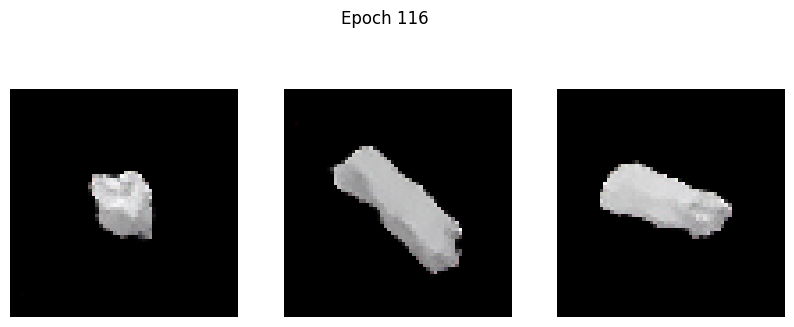

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2857 - g_loss: 2.7839
Epoch 117/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2240 - g_loss: 2.7479

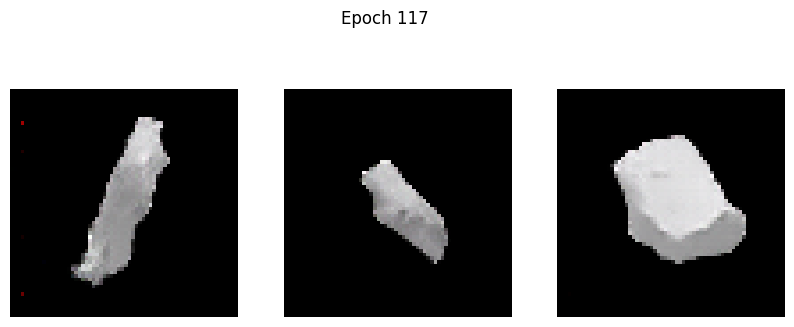

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2240 - g_loss: 2.7473
Epoch 118/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2083 - g_loss: 2.6843

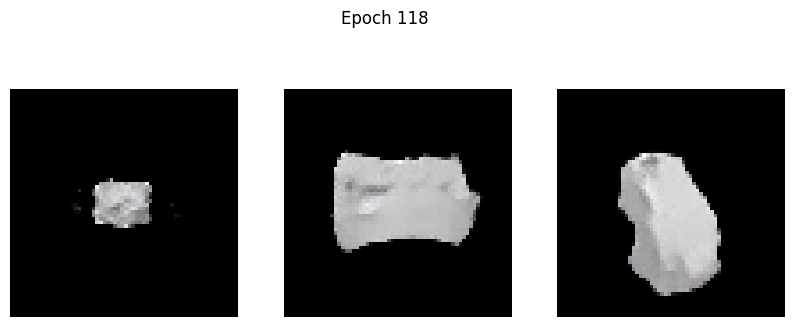

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2084 - g_loss: 2.6845
Epoch 119/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2001 - g_loss: 2.6979

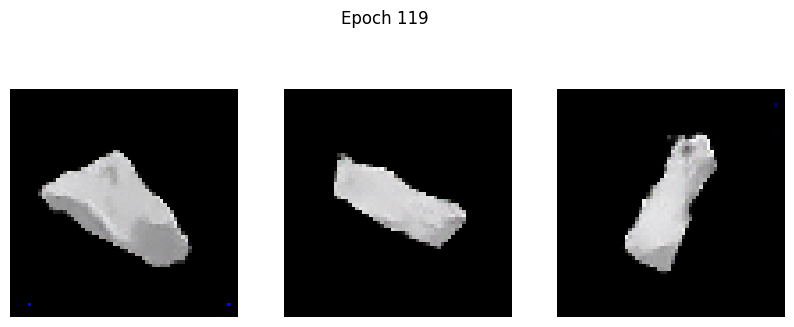

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2000 - g_loss: 2.6974
Epoch 120/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1849 - g_loss: 2.6536

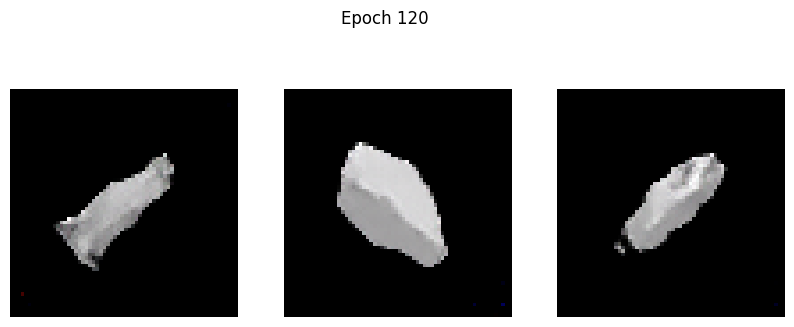

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1853 - g_loss: 2.6541
Epoch 121/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1942 - g_loss: 2.6894

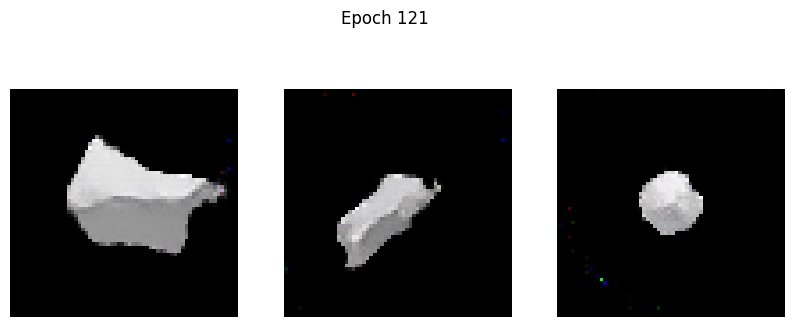

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1941 - g_loss: 2.6892
Epoch 122/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2742 - g_loss: 2.9124

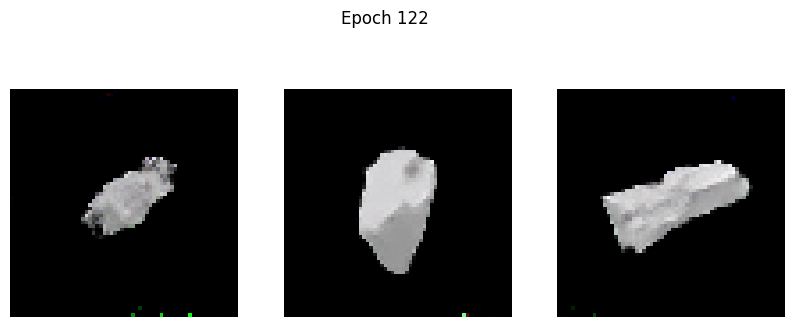

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2741 - g_loss: 2.9116
Epoch 123/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1872 - g_loss: 2.6833

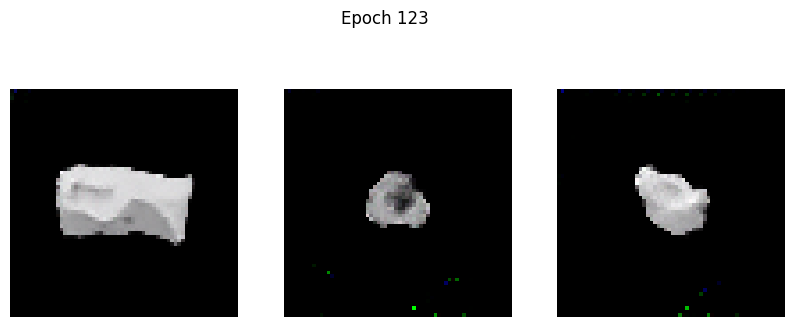

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1872 - g_loss: 2.6836
Epoch 124/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2169 - g_loss: 2.7576

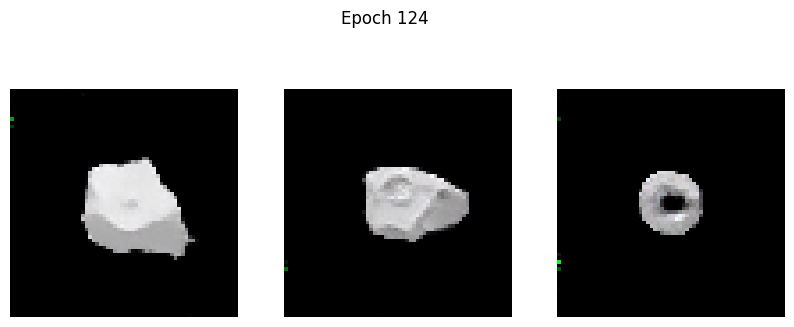

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2169 - g_loss: 2.7574
Epoch 125/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1872 - g_loss: 2.7821

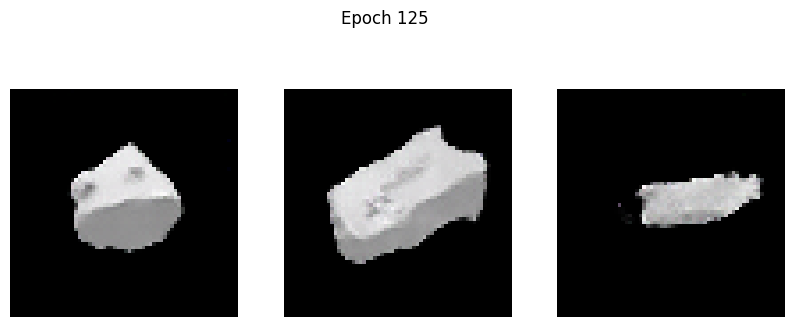

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1878 - g_loss: 2.7829
Epoch 126/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1609 - g_loss: 2.7080

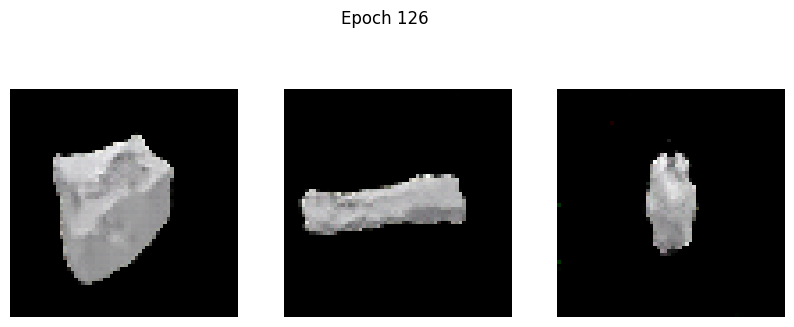

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1611 - g_loss: 2.7082
Epoch 127/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1861 - g_loss: 2.8256

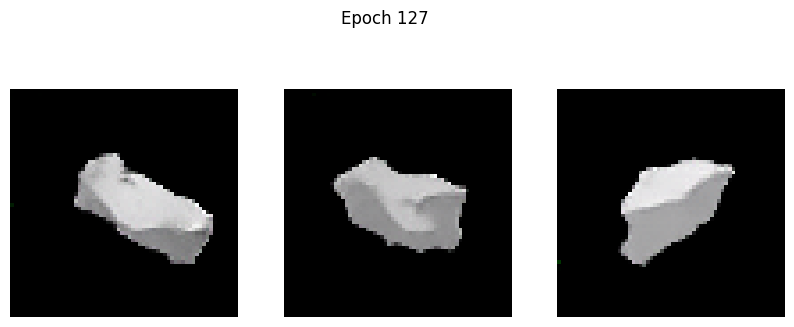

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1861 - g_loss: 2.8257
Epoch 128/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1747 - g_loss: 2.8029

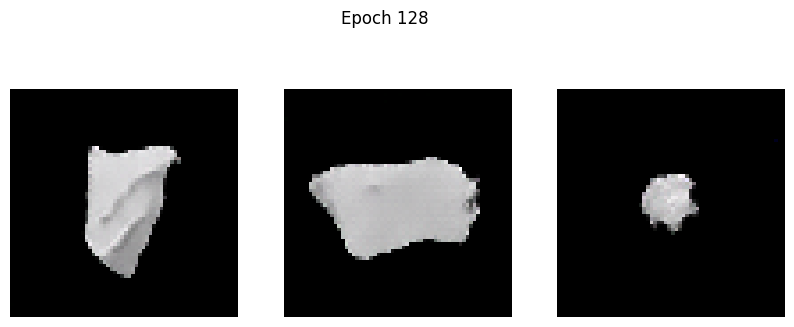

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1748 - g_loss: 2.8028
Epoch 129/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2435 - g_loss: 2.9248

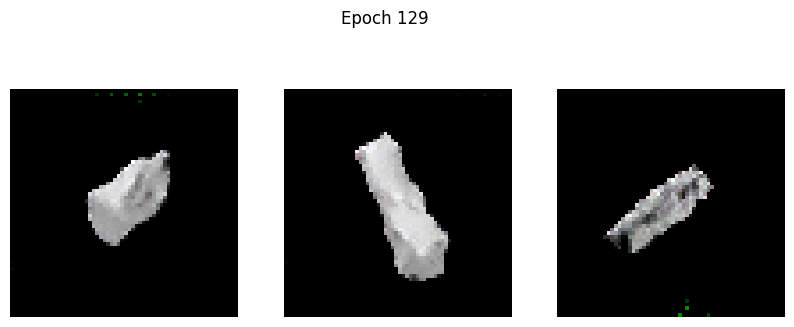

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2431 - g_loss: 2.9243
Epoch 130/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1536 - g_loss: 2.7902

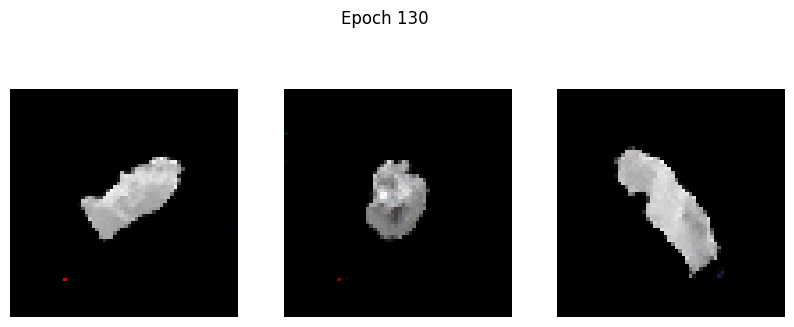

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1541 - g_loss: 2.7913
Epoch 131/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2730 - g_loss: 2.7946

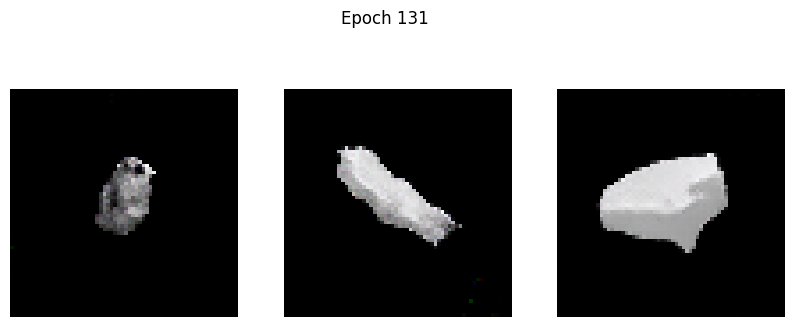

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2730 - g_loss: 2.7954
Epoch 132/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.4520 - g_loss: 2.8352

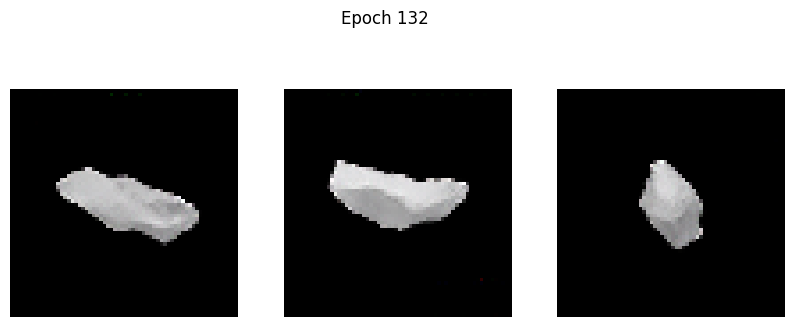

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.4503 - g_loss: 2.8342
Epoch 133/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1618 - g_loss: 2.7868

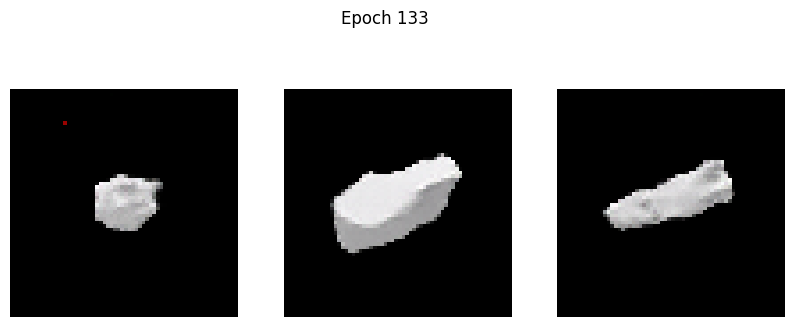

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1618 - g_loss: 2.7865
Epoch 134/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1494 - g_loss: 2.8226

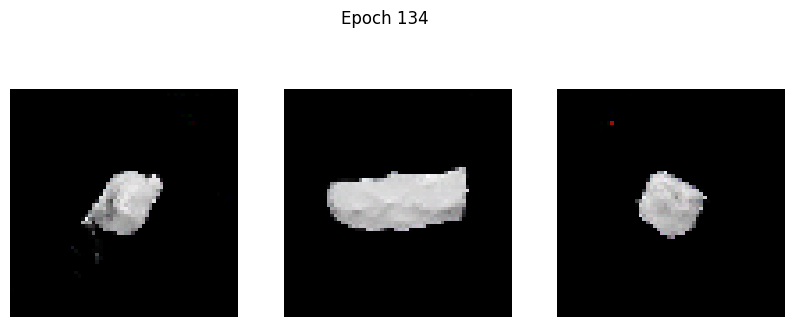

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1495 - g_loss: 2.8228
Epoch 135/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3378 - g_loss: 3.0081

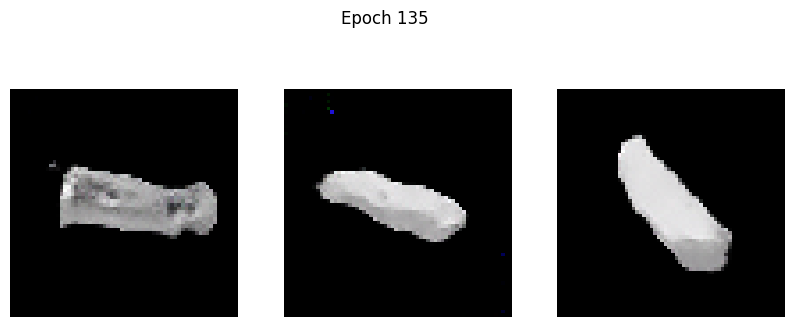

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - d_loss: 0.3367 - g_loss: 3.0070
Epoch 136/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.1701 - g_loss: 2.8561

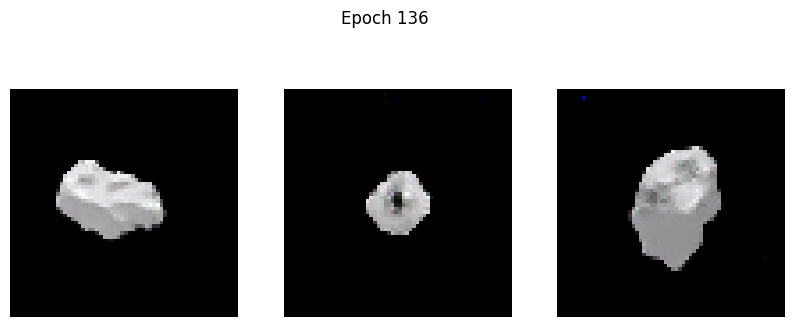

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1702 - g_loss: 2.8559
Epoch 137/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: 0.1845 - g_loss: 2.9401

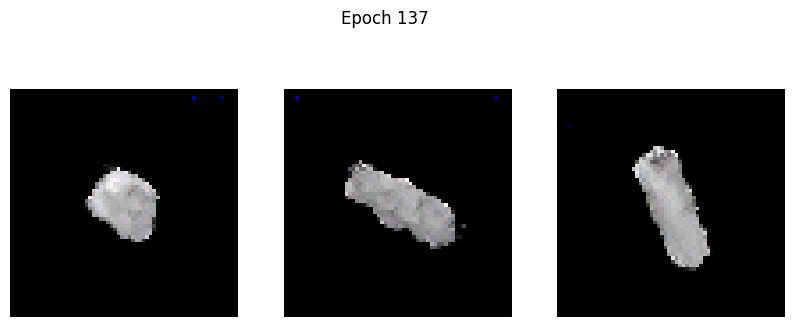

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - d_loss: 0.1848 - g_loss: 2.9402
Epoch 138/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1972 - g_loss: 2.8973

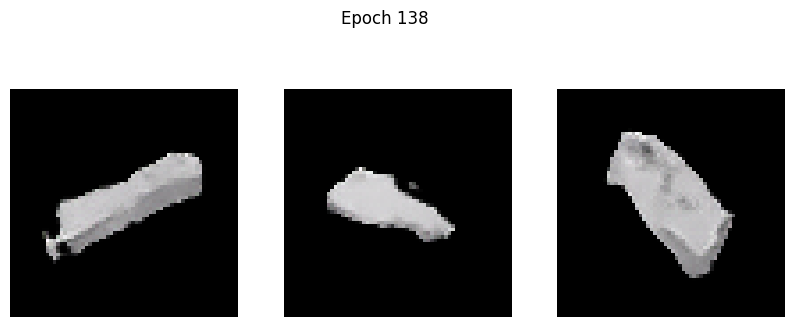

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1975 - g_loss: 2.8979
Epoch 139/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1516 - g_loss: 2.8046

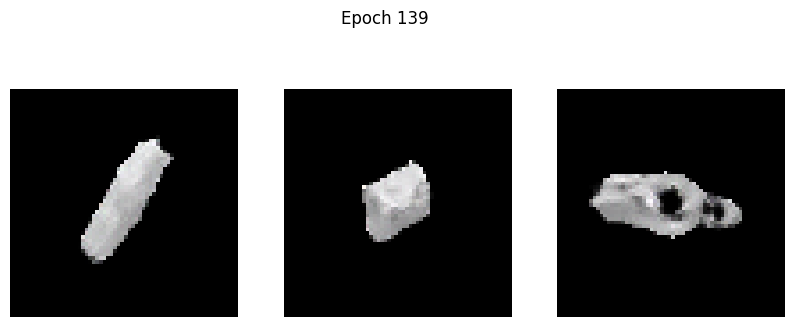

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1516 - g_loss: 2.8049
Epoch 140/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2423 - g_loss: 3.0322

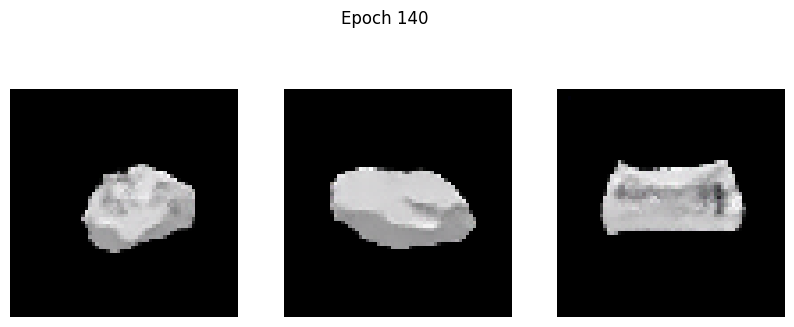

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2420 - g_loss: 3.0311
Epoch 141/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1585 - g_loss: 2.9059

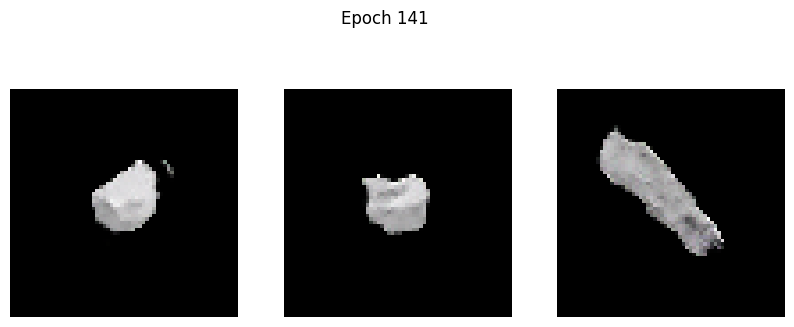

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1584 - g_loss: 2.9055
Epoch 142/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2214 - g_loss: 3.0841

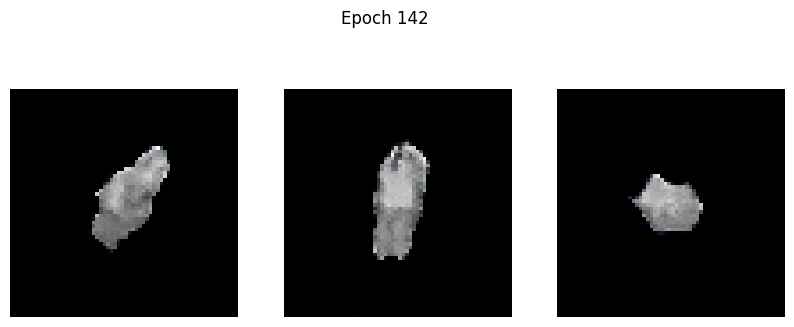

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2235 - g_loss: 3.0869
Epoch 143/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2382 - g_loss: 2.8745

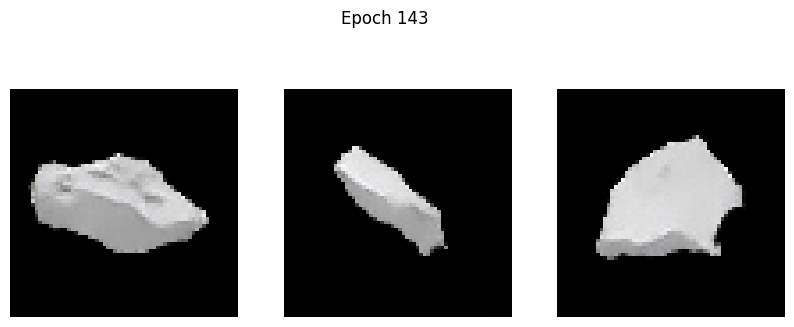

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2378 - g_loss: 2.8734
Epoch 144/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1522 - g_loss: 2.8080

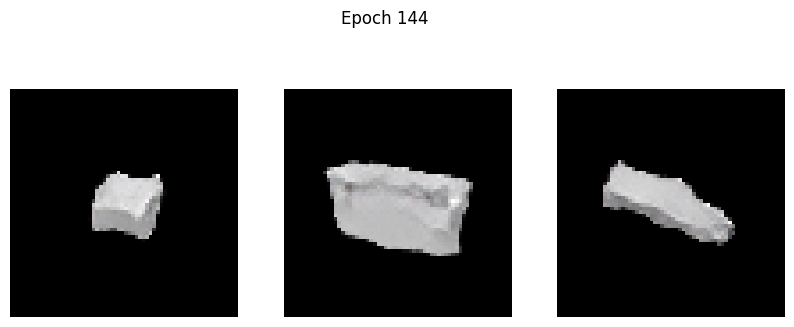

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1521 - g_loss: 2.8077
Epoch 145/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1356 - g_loss: 2.8537

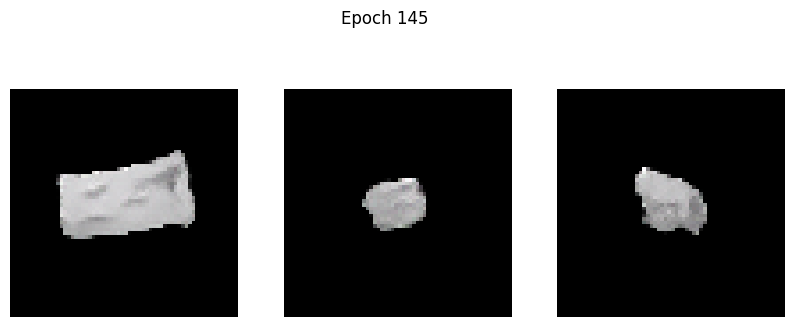

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1357 - g_loss: 2.8537
Epoch 146/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1524 - g_loss: 2.9104

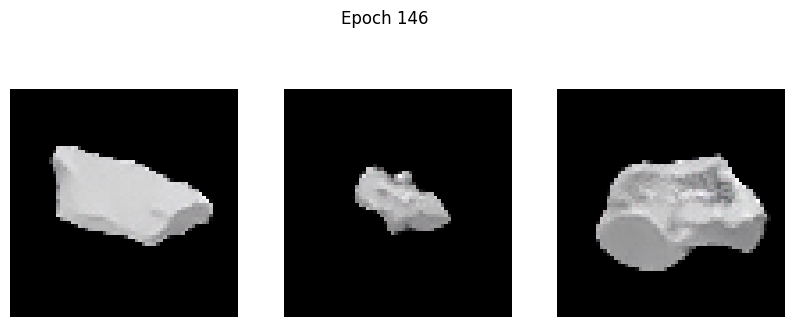

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1524 - g_loss: 2.9105
Epoch 147/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1783 - g_loss: 2.9850

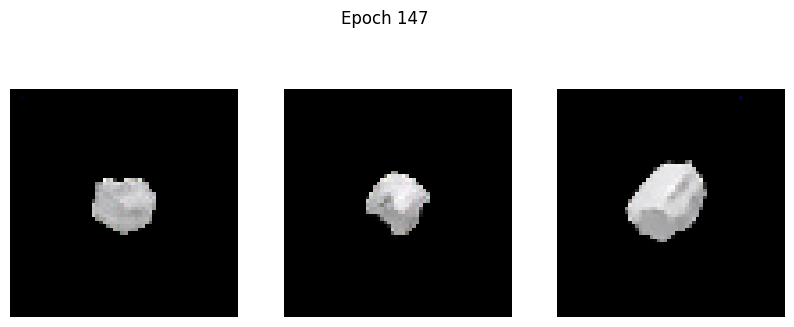

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1786 - g_loss: 2.9852
Epoch 148/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2169 - g_loss: 2.9825

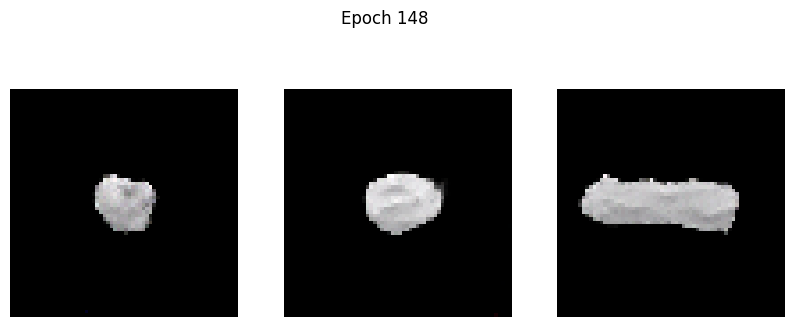

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2165 - g_loss: 2.9820
Epoch 149/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1426 - g_loss: 3.0254

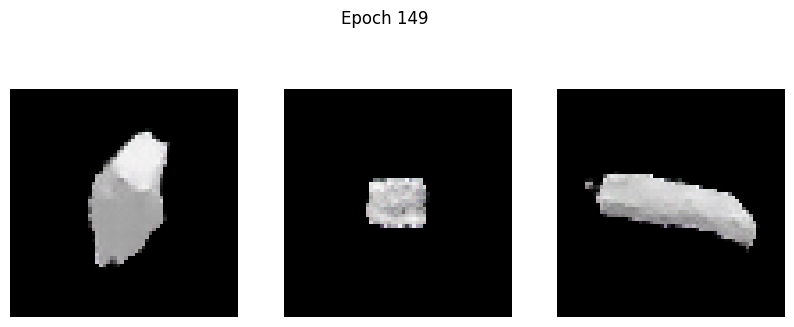

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1429 - g_loss: 3.0256
Epoch 150/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1800 - g_loss: 3.0511

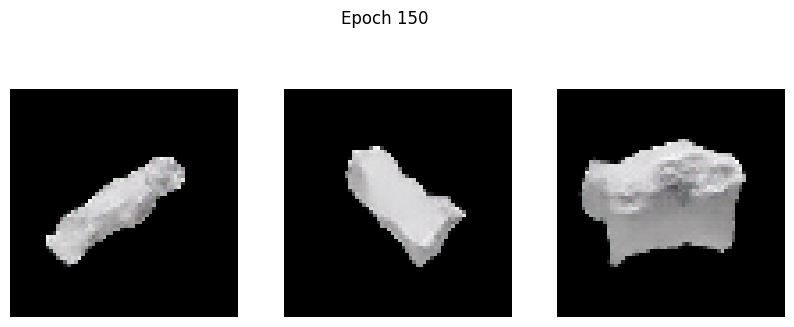

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1800 - g_loss: 3.0509
Epoch 151/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1860 - g_loss: 3.0721

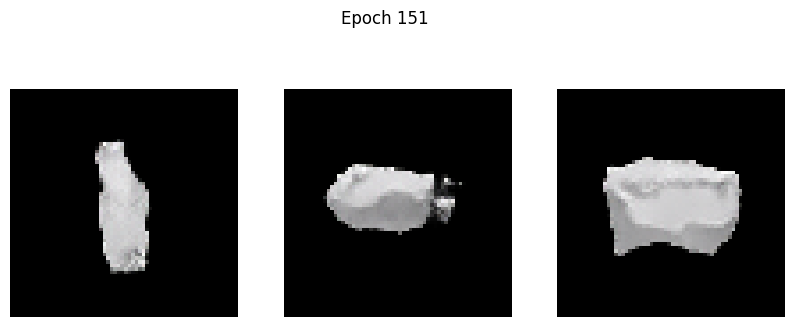

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.1861 - g_loss: 3.0720
Epoch 152/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1373 - g_loss: 2.9824

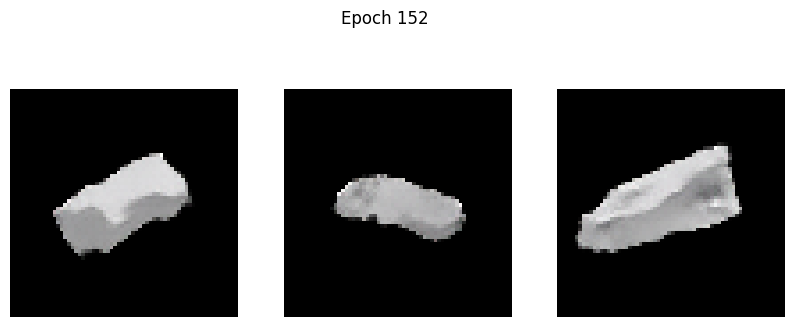

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1373 - g_loss: 2.9826
Epoch 153/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2622 - g_loss: 3.1694

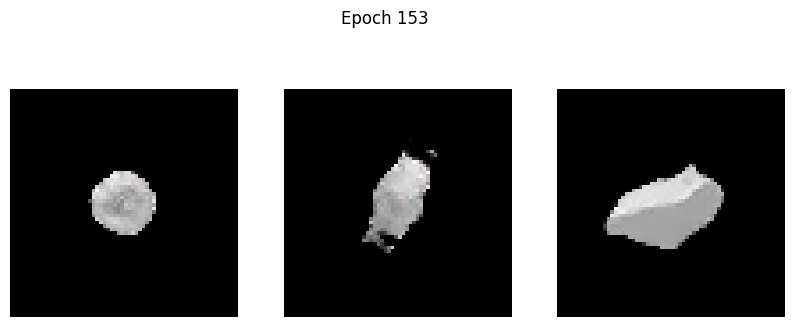

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2626 - g_loss: 3.1692
Epoch 154/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1444 - g_loss: 2.9660

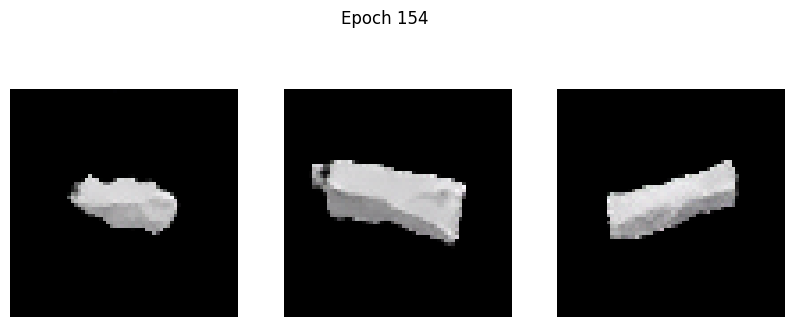

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1444 - g_loss: 2.9656
Epoch 155/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1565 - g_loss: 3.1119

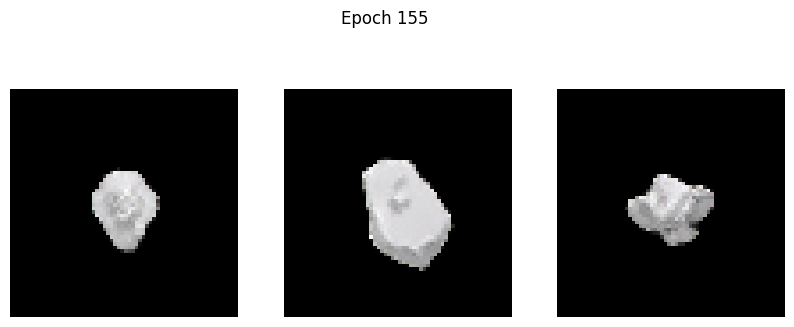

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1566 - g_loss: 3.1117
Epoch 156/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2193 - g_loss: 3.1765

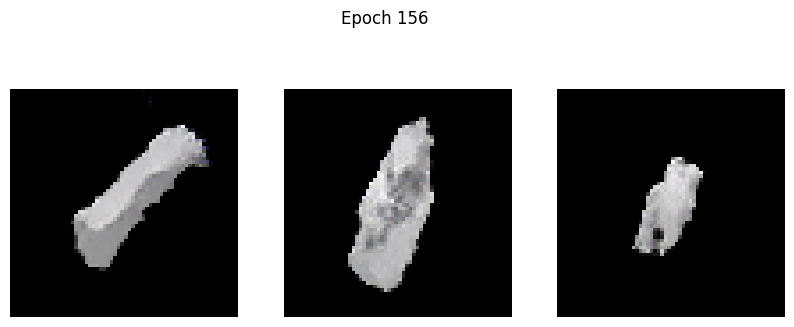

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2191 - g_loss: 3.1758
Epoch 157/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1490 - g_loss: 2.9989

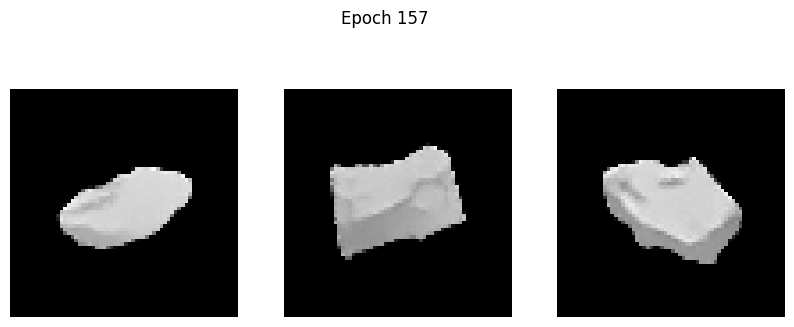

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1490 - g_loss: 2.9993
Epoch 158/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1302 - g_loss: 3.0701

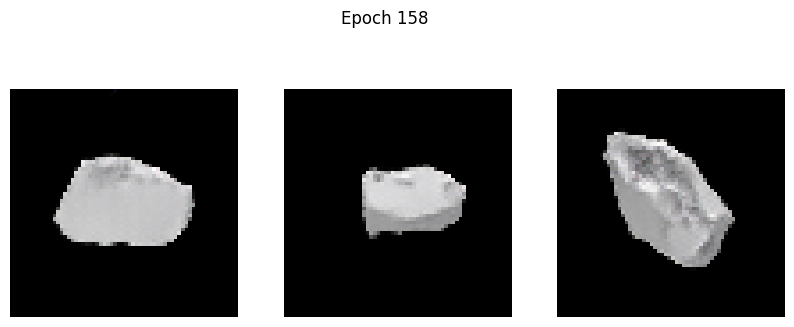

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1303 - g_loss: 3.0698
Epoch 159/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1864 - g_loss: 3.1881

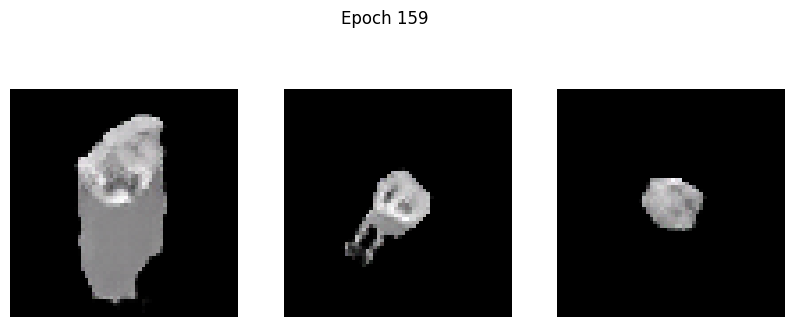

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1865 - g_loss: 3.1877
Epoch 160/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1304 - g_loss: 3.0675

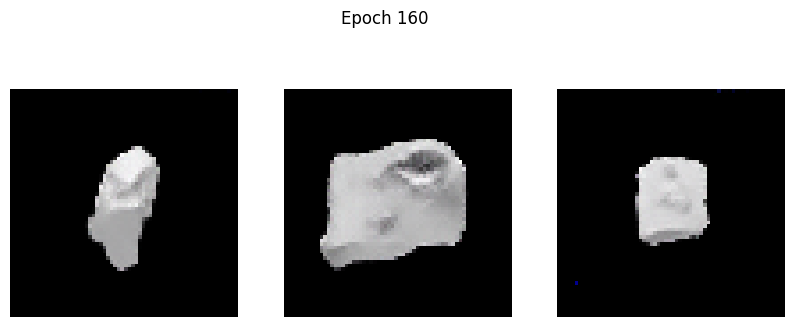

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1308 - g_loss: 3.0681
Epoch 161/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2618 - g_loss: 3.2242

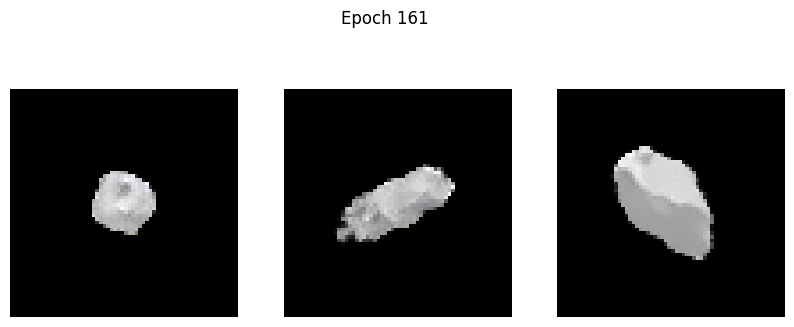

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2611 - g_loss: 3.2234
Epoch 162/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2684 - g_loss: 3.2401

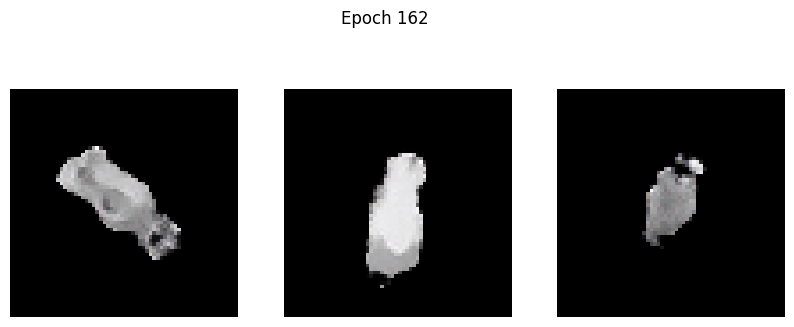

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2680 - g_loss: 3.2393
Epoch 163/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1242 - g_loss: 3.0663

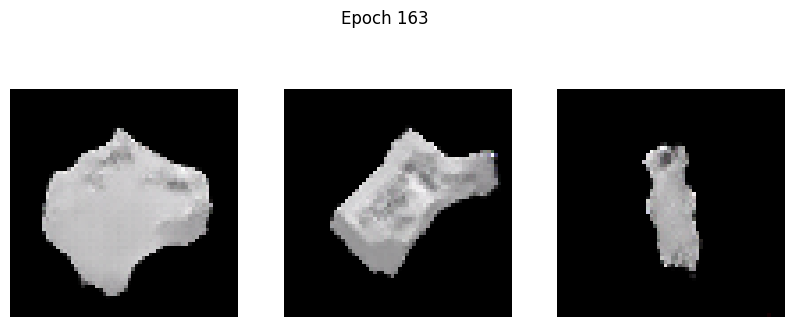

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1242 - g_loss: 3.0667
Epoch 164/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1281 - g_loss: 3.1375

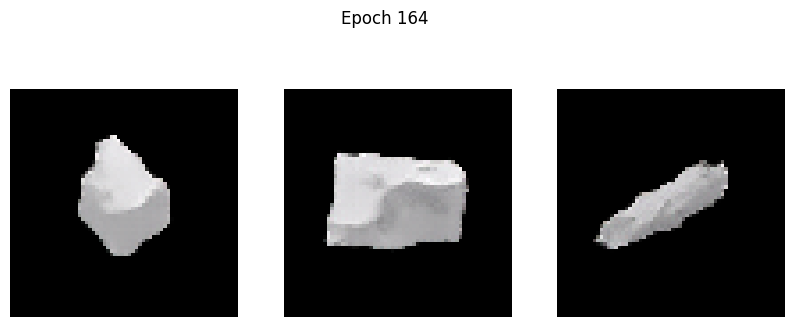

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1282 - g_loss: 3.1375
Epoch 165/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3196 - g_loss: 3.4979

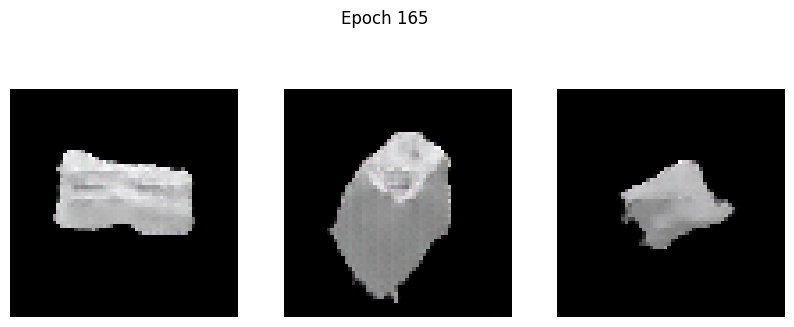

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3222 - g_loss: 3.5010
Epoch 166/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2198 - g_loss: 2.8885

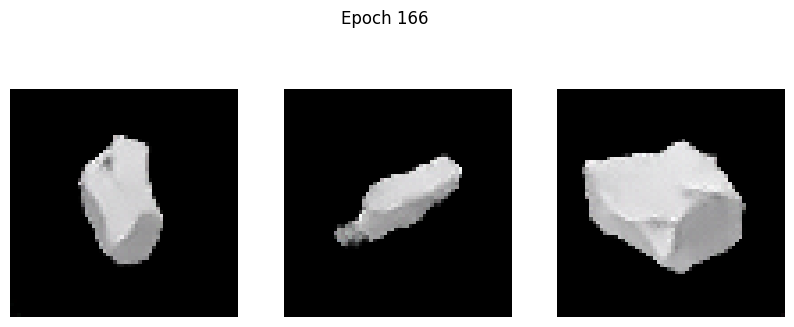

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2196 - g_loss: 2.8881
Epoch 167/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1437 - g_loss: 2.9061

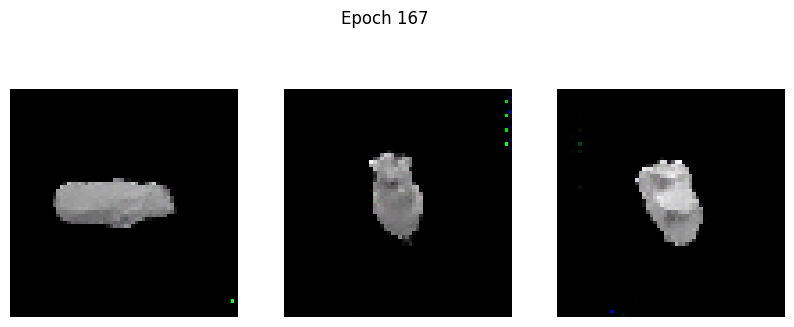

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1437 - g_loss: 2.9061
Epoch 168/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1502 - g_loss: 2.9804

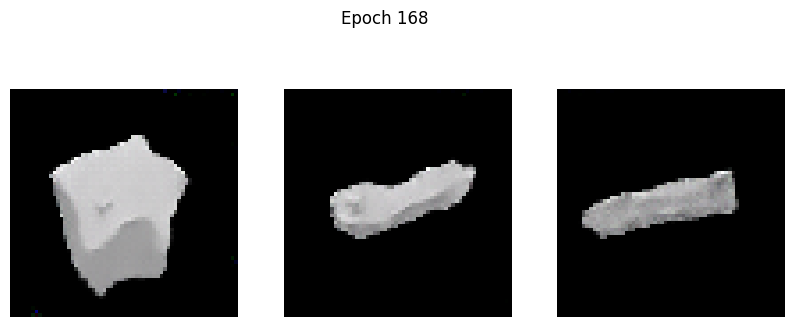

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1502 - g_loss: 2.9804
Epoch 169/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1319 - g_loss: 2.9879

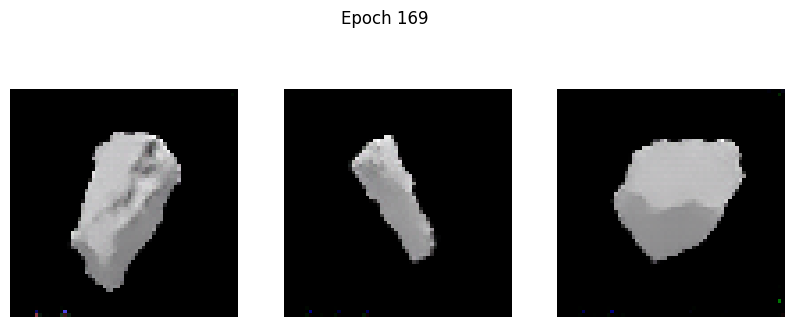

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1320 - g_loss: 2.9886
Epoch 170/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1212 - g_loss: 3.0921

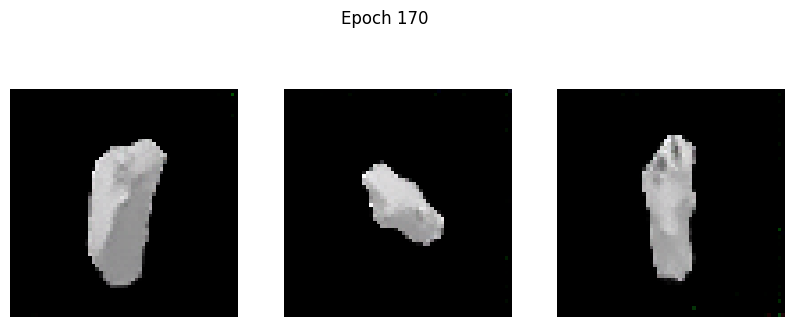

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1213 - g_loss: 3.0918
Epoch 171/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2531 - g_loss: 3.3187

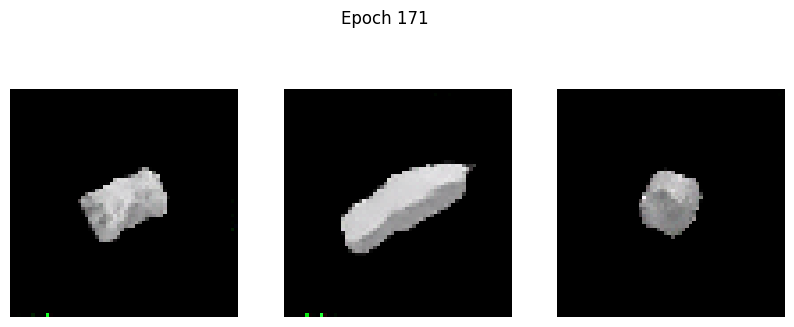

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2531 - g_loss: 3.3190
Epoch 172/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1497 - g_loss: 3.0581

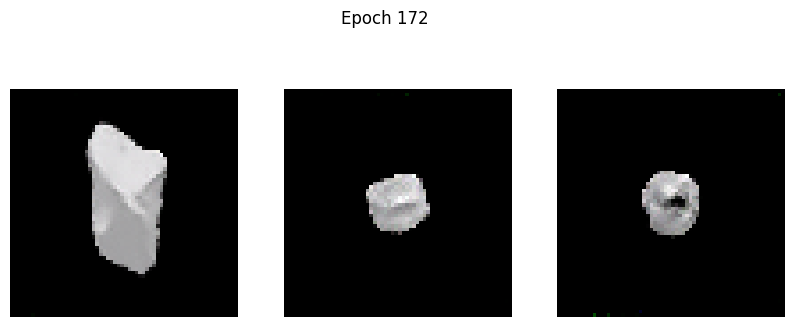

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1497 - g_loss: 3.0584
Epoch 173/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1304 - g_loss: 3.0957

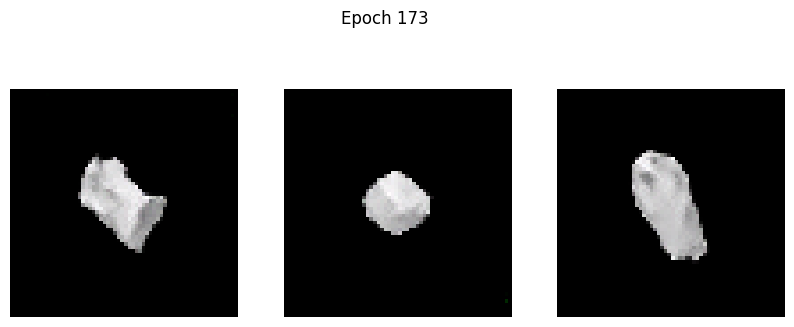

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1305 - g_loss: 3.0956
Epoch 174/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1345 - g_loss: 3.1544

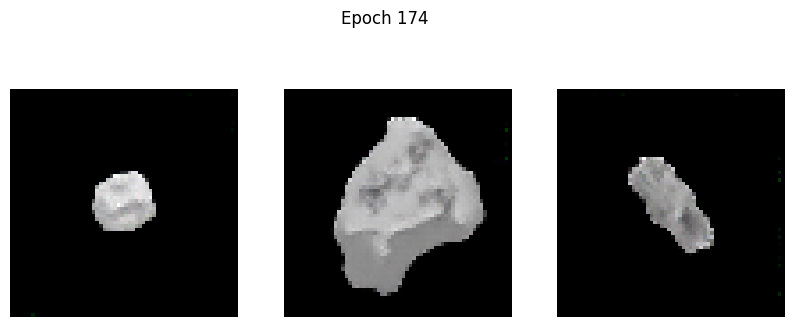

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1345 - g_loss: 3.1541
Epoch 175/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1881 - g_loss: 3.2711

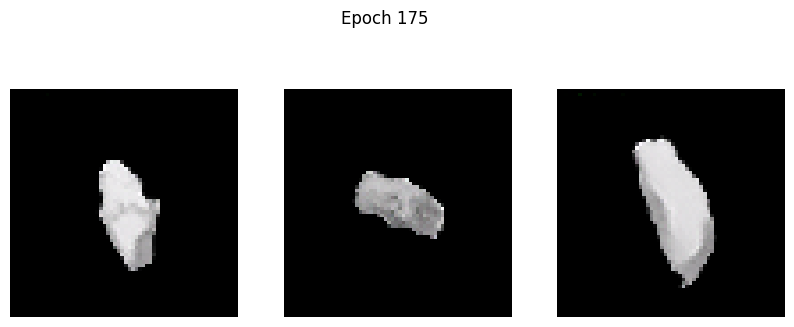

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1886 - g_loss: 3.2711
Epoch 176/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1306 - g_loss: 3.0885

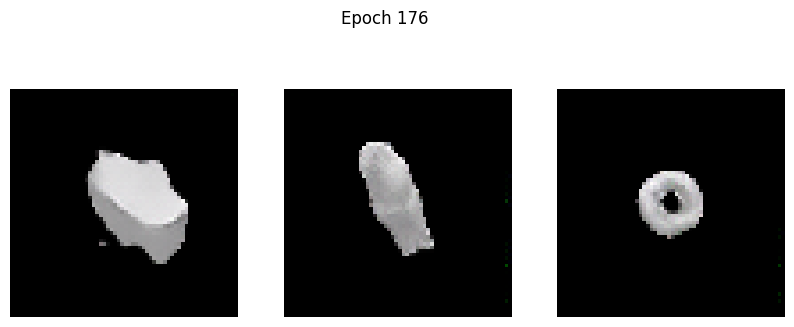

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1306 - g_loss: 3.0887
Epoch 177/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1627 - g_loss: 3.1896

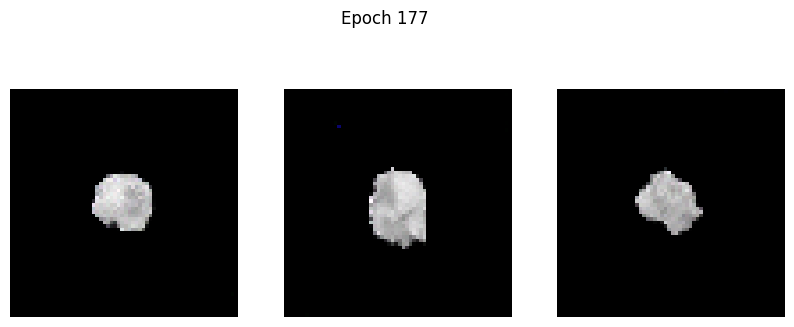

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1631 - g_loss: 3.1897
Epoch 178/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1337 - g_loss: 3.1525

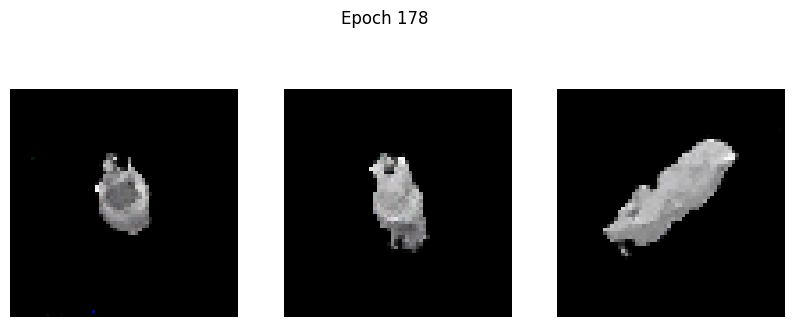

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1337 - g_loss: 3.1527
Epoch 179/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1414 - g_loss: 3.2712

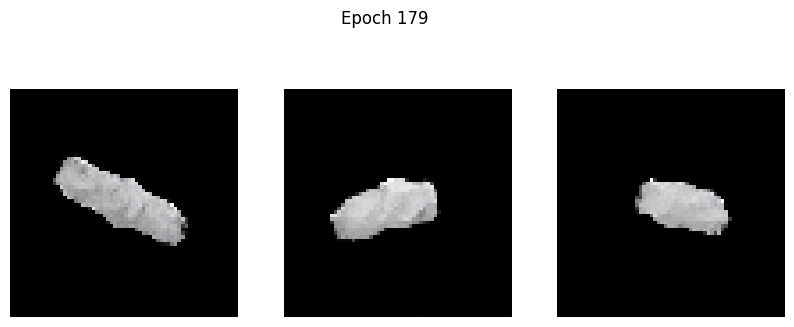

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1415 - g_loss: 3.2710
Epoch 180/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1654 - g_loss: 3.2609

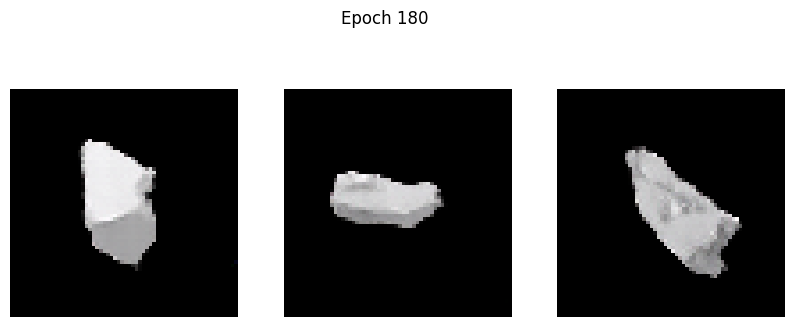

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1653 - g_loss: 3.2611
Epoch 181/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3405 - g_loss: 3.5158

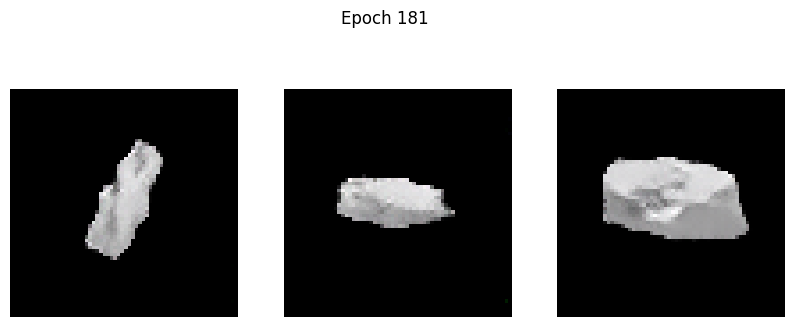

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3393 - g_loss: 3.5142
Epoch 182/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1170 - g_loss: 3.2337

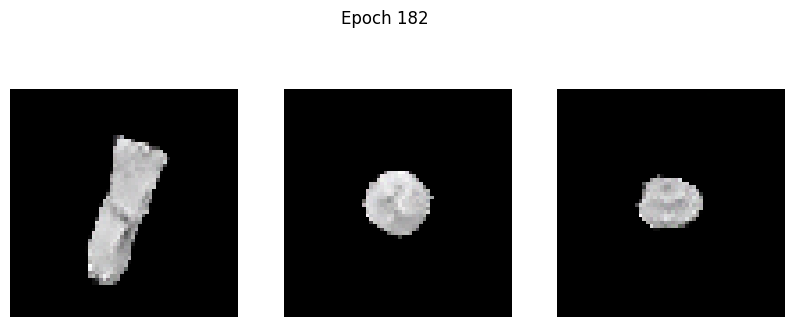

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1172 - g_loss: 3.2341
Epoch 183/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2012 - g_loss: 3.3168

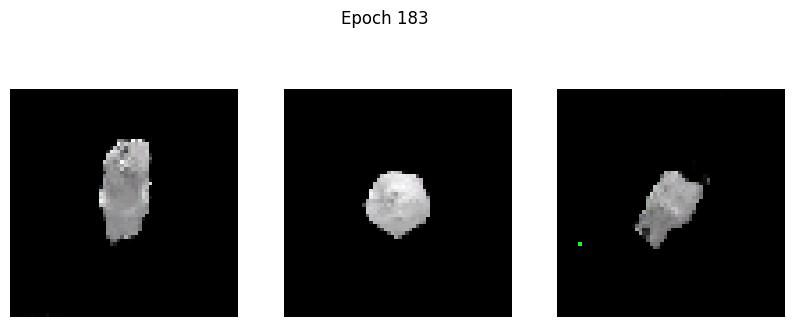

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2008 - g_loss: 3.3166
Epoch 184/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1365 - g_loss: 3.2706

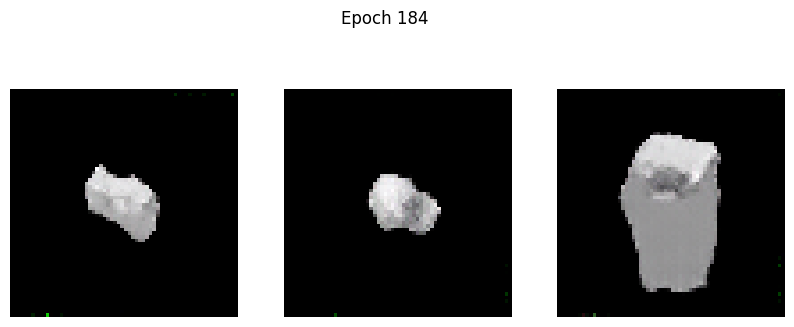

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1366 - g_loss: 3.2707
Epoch 185/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3940 - g_loss: 3.7432

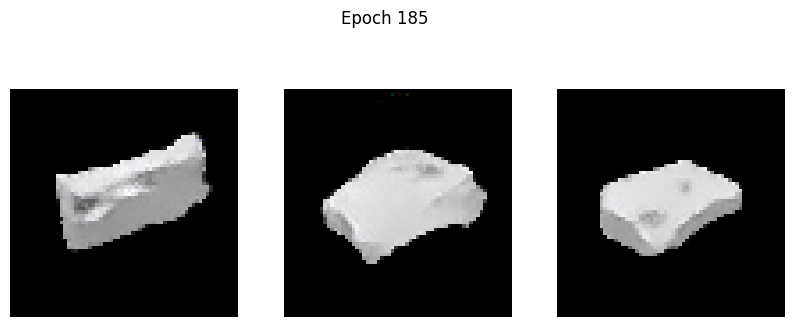

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3923 - g_loss: 3.7398
Epoch 186/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1708 - g_loss: 3.2607

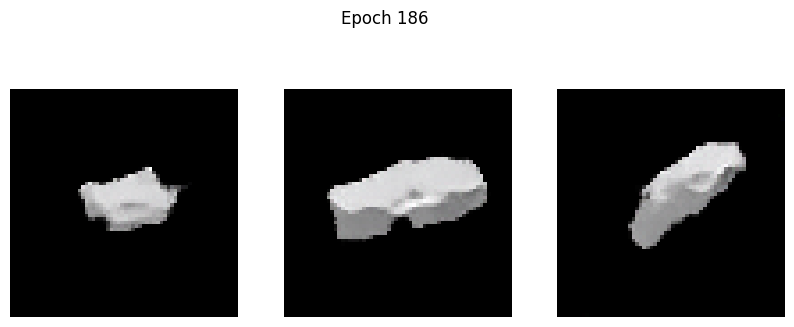

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1706 - g_loss: 3.2607
Epoch 187/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1997 - g_loss: 3.3752

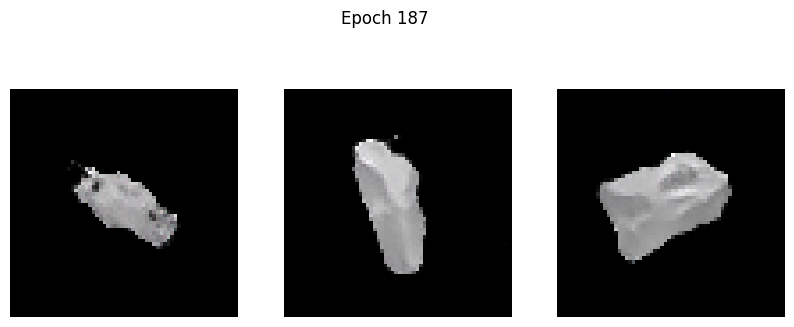

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2008 - g_loss: 3.3768
Epoch 188/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1590 - g_loss: 3.1898

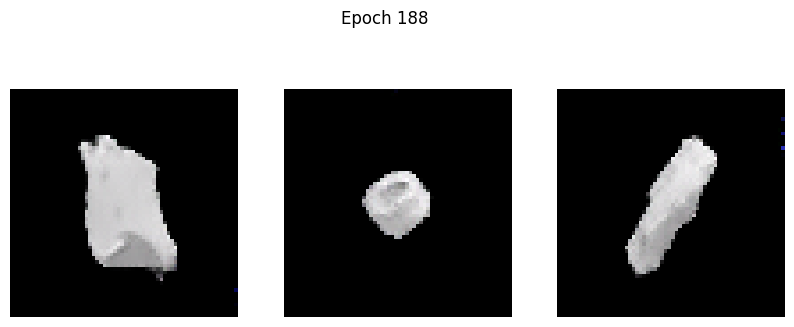

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1588 - g_loss: 3.1897
Epoch 189/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1214 - g_loss: 3.1459

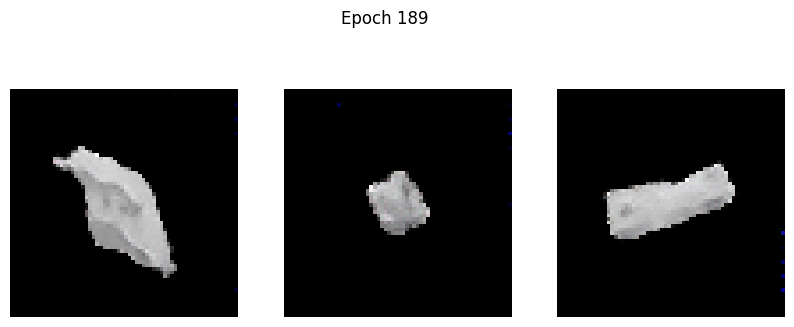

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1214 - g_loss: 3.1465
Epoch 190/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1304 - g_loss: 3.2719

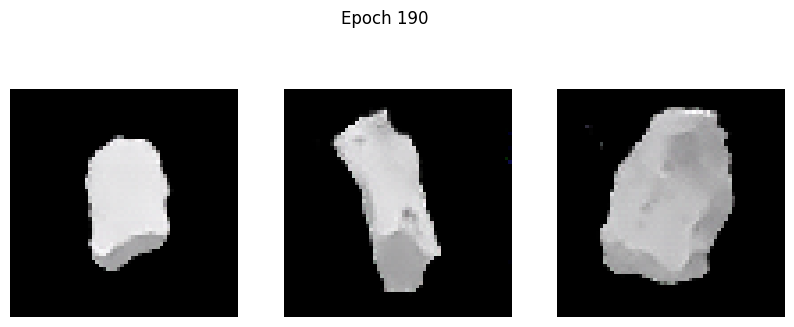

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1304 - g_loss: 3.2722
Epoch 191/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1383 - g_loss: 3.2750

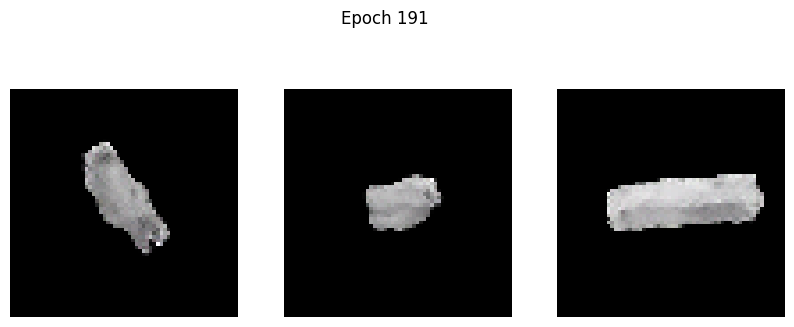

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1383 - g_loss: 3.2755
Epoch 192/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1166 - g_loss: 3.4233

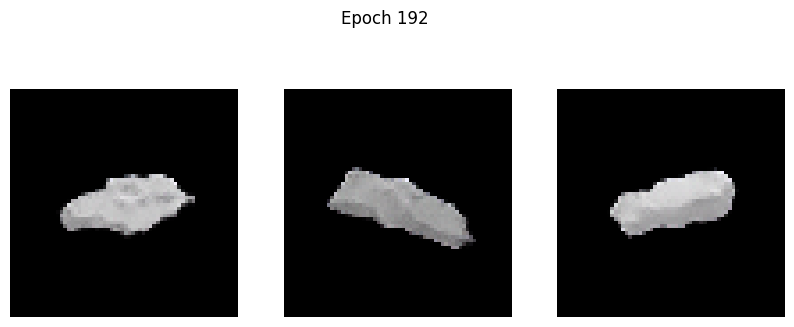

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1166 - g_loss: 3.4228
Epoch 193/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1364 - g_loss: 3.3706

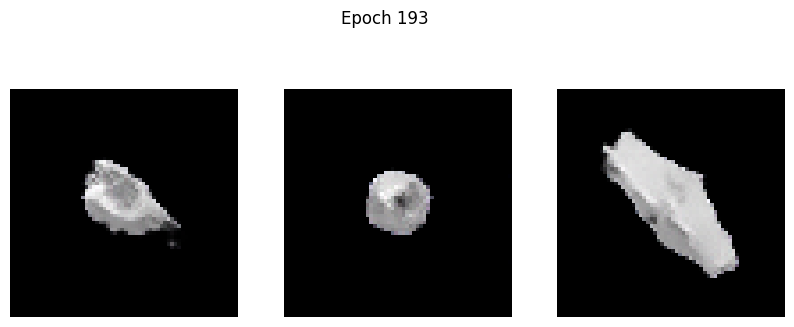

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1365 - g_loss: 3.3706
Epoch 194/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2576 - g_loss: 3.5173

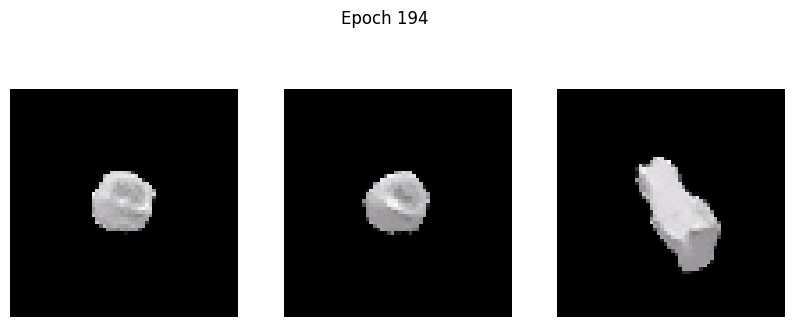

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2569 - g_loss: 3.5162
Epoch 195/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1103 - g_loss: 3.4121

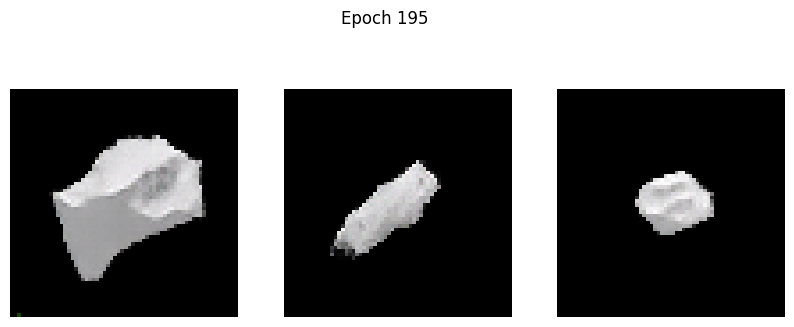

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1103 - g_loss: 3.4116
Epoch 196/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1718 - g_loss: 3.4450

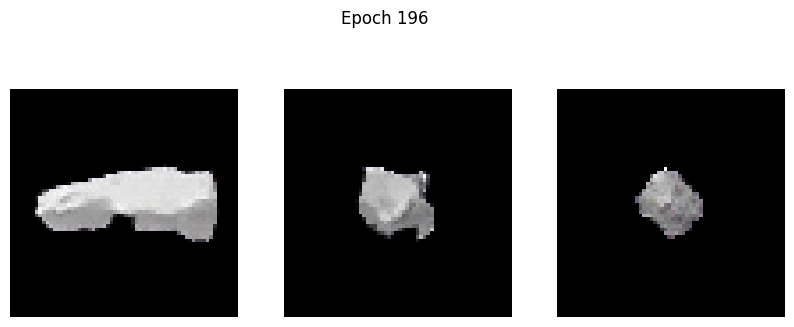

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1728 - g_loss: 3.4468
Epoch 197/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1972 - g_loss: 3.2153

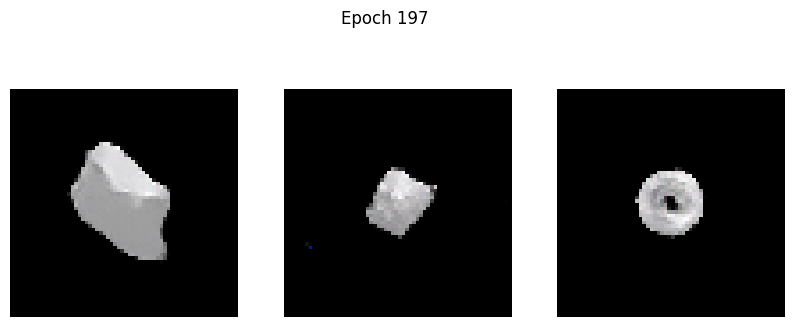

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1966 - g_loss: 3.2158
Epoch 198/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1164 - g_loss: 3.2542

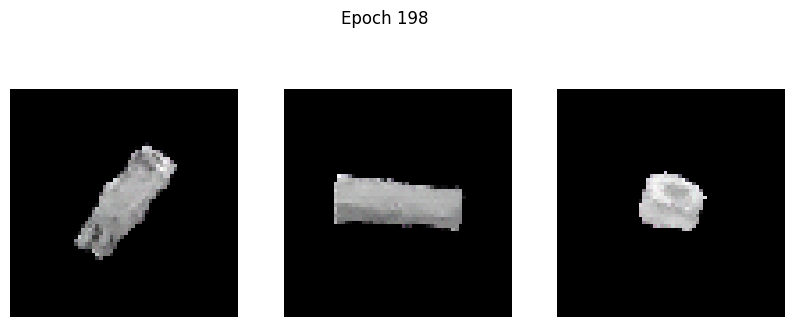

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1164 - g_loss: 3.2544
Epoch 199/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1108 - g_loss: 3.3960

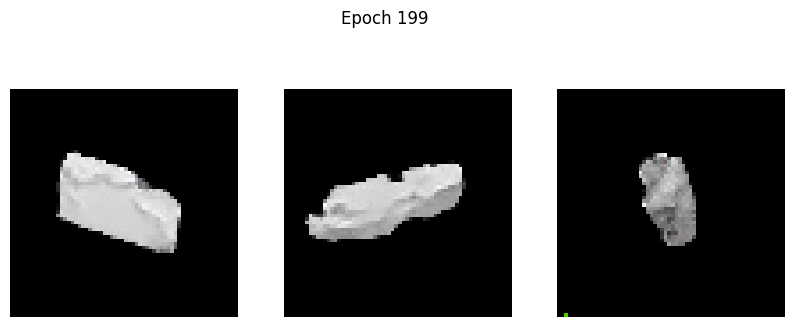

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1110 - g_loss: 3.3961
Epoch 200/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1012 - g_loss: 3.4526

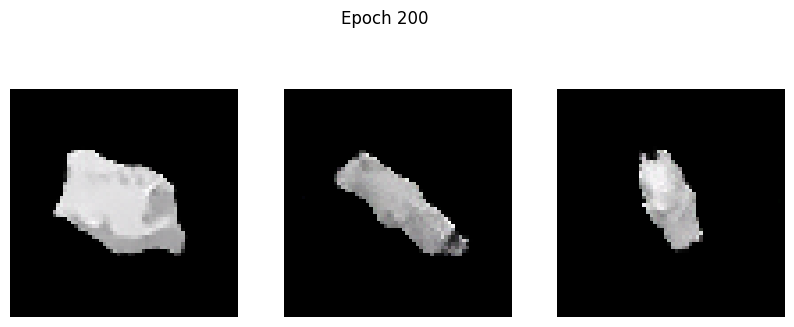

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1015 - g_loss: 3.4530
Epoch 201/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1010 - g_loss: 3.3416

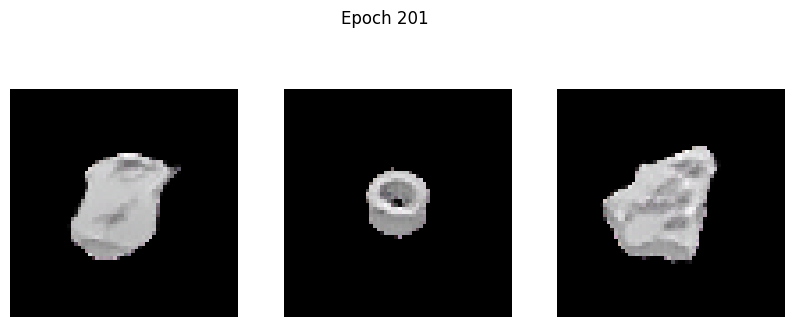

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1020 - g_loss: 3.3441
Epoch 202/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1973 - g_loss: 3.5008

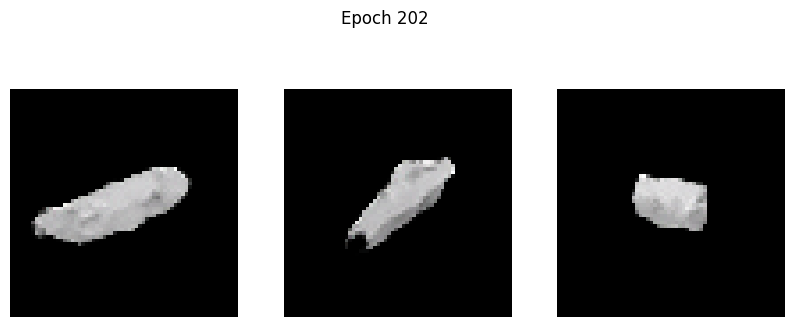

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1968 - g_loss: 3.4997
Epoch 203/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1218 - g_loss: 3.3943

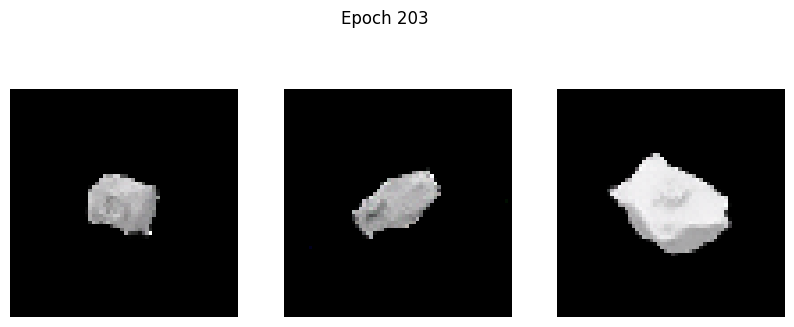

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1218 - g_loss: 3.3946
Epoch 204/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1251 - g_loss: 3.4708

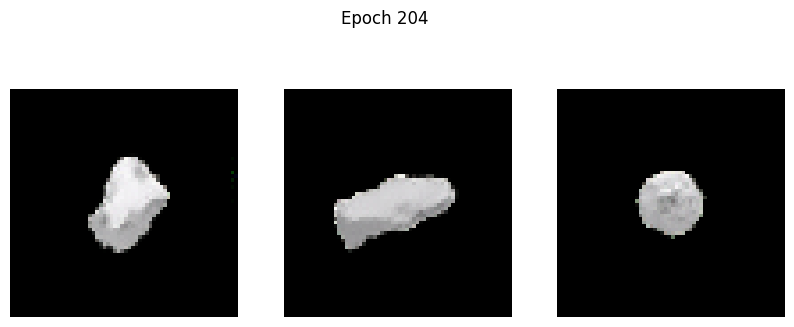

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1253 - g_loss: 3.4713
Epoch 205/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1698 - g_loss: 3.5888

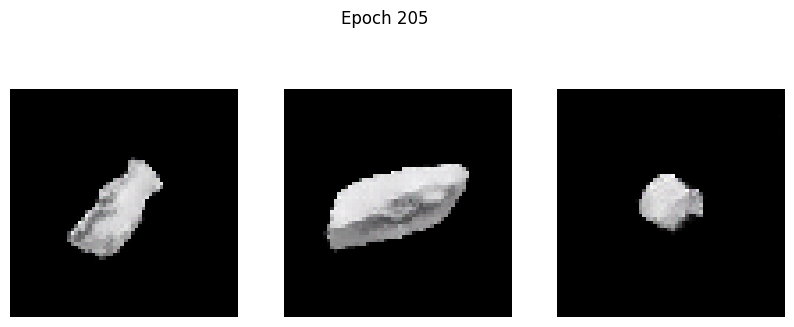

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1696 - g_loss: 3.5882
Epoch 206/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2064 - g_loss: 3.5045

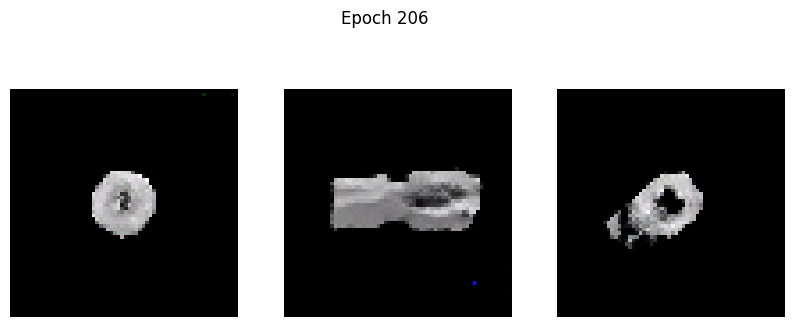

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2060 - g_loss: 3.5037
Epoch 207/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1057 - g_loss: 3.4068

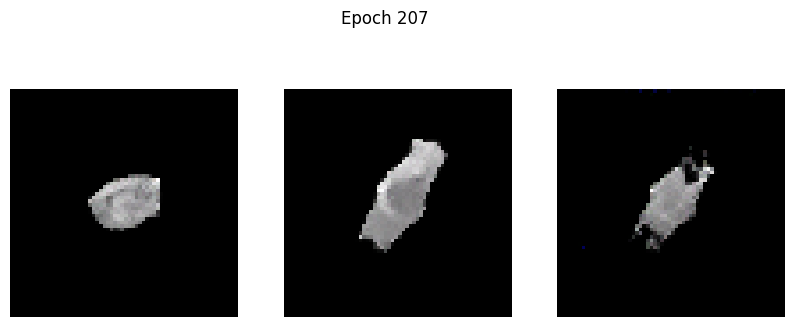

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1060 - g_loss: 3.4070
Epoch 208/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1136 - g_loss: 3.4494

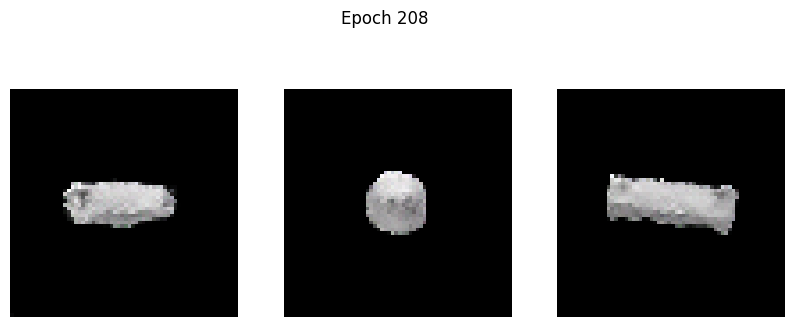

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1139 - g_loss: 3.4499
Epoch 209/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1379 - g_loss: 3.5840

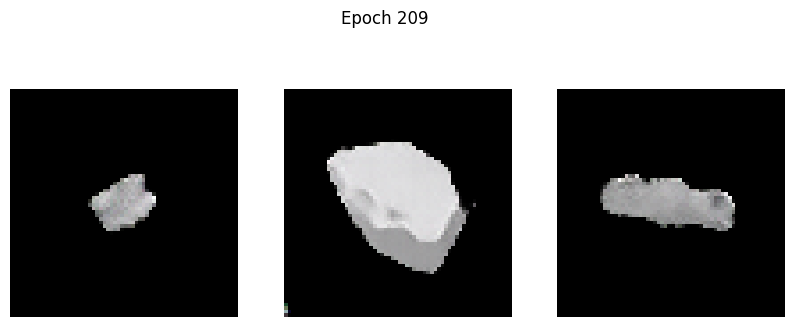

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1378 - g_loss: 3.5833
Epoch 210/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1611 - g_loss: 3.5413

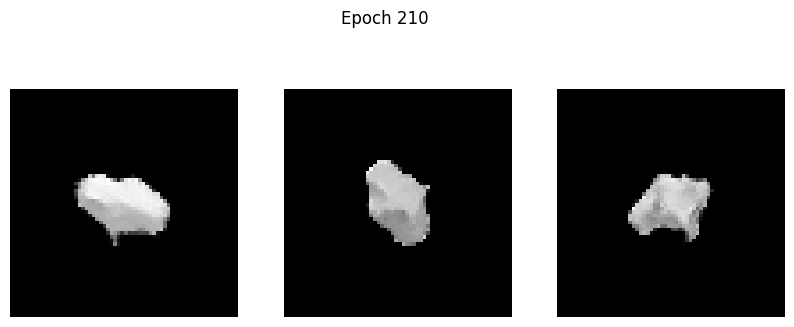

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1617 - g_loss: 3.5415
Epoch 211/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1220 - g_loss: 3.5032

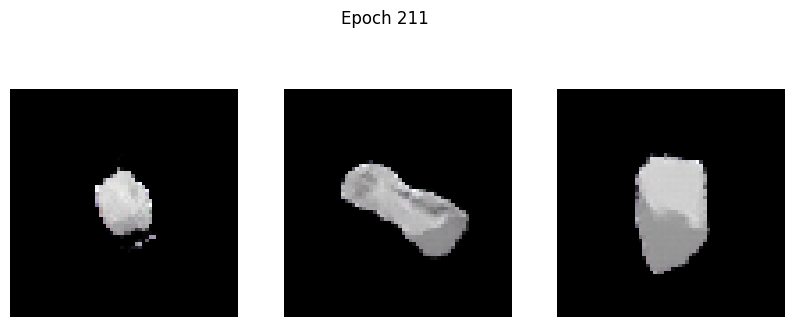

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1222 - g_loss: 3.5040
Epoch 212/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1845 - g_loss: 3.6116

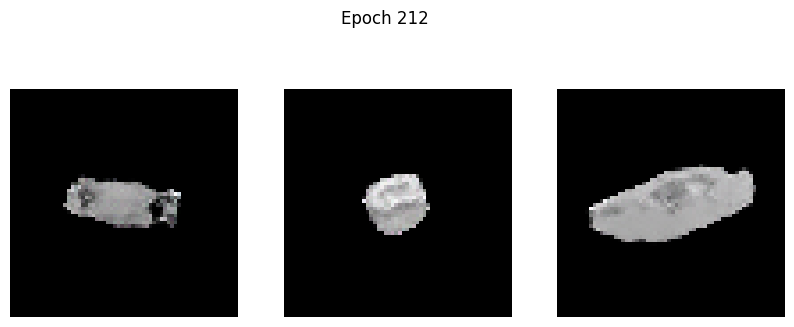

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1839 - g_loss: 3.6107
Epoch 213/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1016 - g_loss: 3.5243

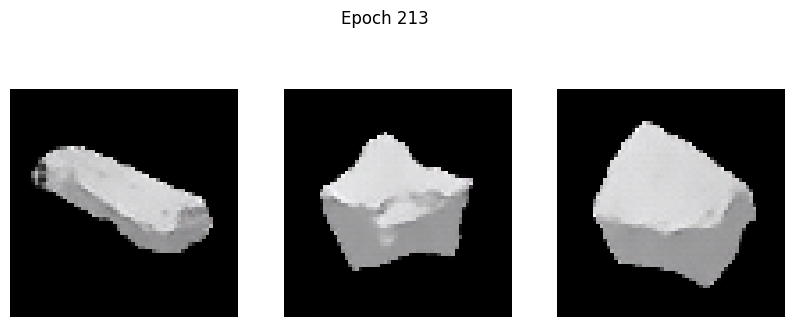

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - d_loss: 0.1017 - g_loss: 3.5243
Epoch 214/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1464 - g_loss: 3.6017

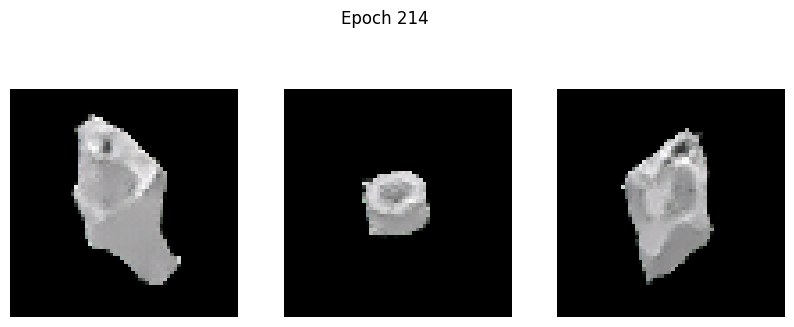

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1464 - g_loss: 3.6023
Epoch 215/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3295 - g_loss: 3.7097

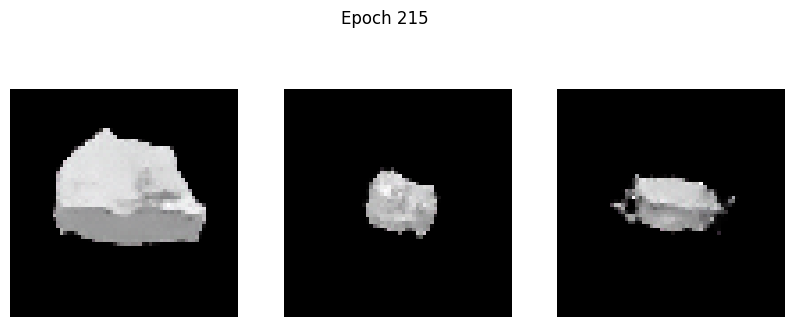

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3286 - g_loss: 3.7086
Epoch 216/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1084 - g_loss: 3.4378

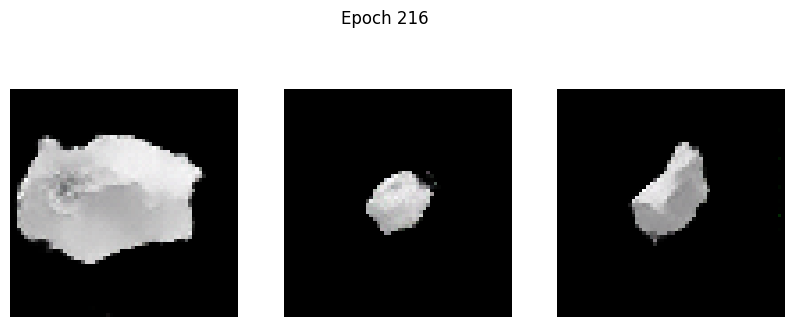

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1084 - g_loss: 3.4378
Epoch 217/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0998 - g_loss: 3.5226

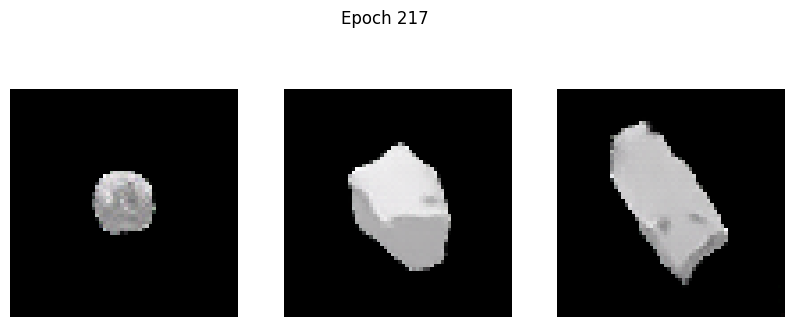

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1000 - g_loss: 3.5225
Epoch 218/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1040 - g_loss: 3.3972

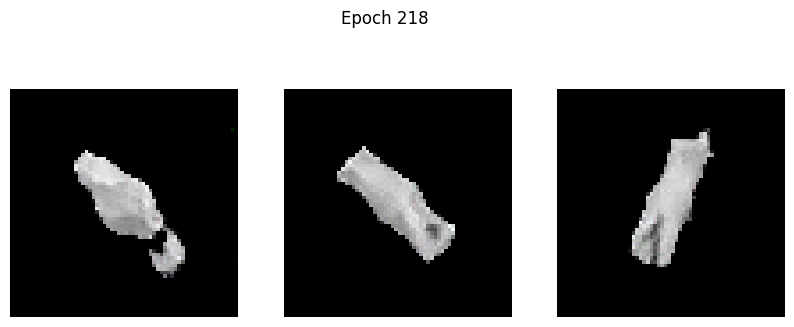

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1039 - g_loss: 3.3975
Epoch 219/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2853 - g_loss: 3.7714

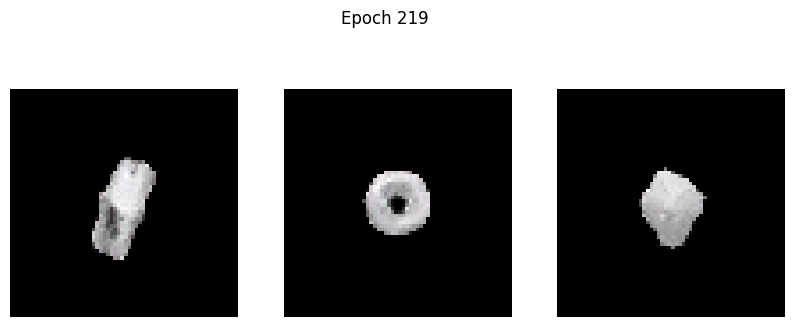

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2844 - g_loss: 3.7698
Epoch 220/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1348 - g_loss: 3.5528

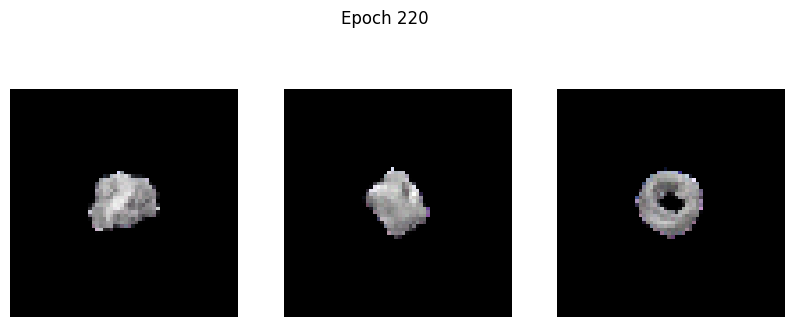

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1355 - g_loss: 3.5545
Epoch 221/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1951 - g_loss: 3.6802

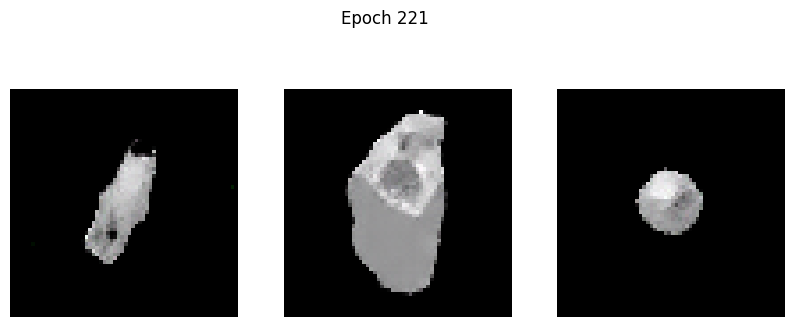

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1944 - g_loss: 3.6788
Epoch 222/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0987 - g_loss: 3.5081

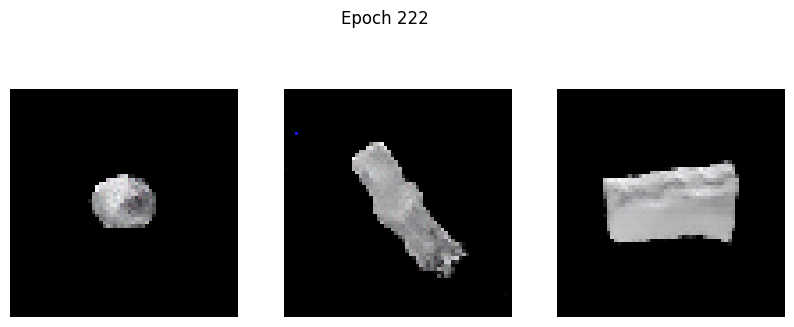

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0987 - g_loss: 3.5079
Epoch 223/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1084 - g_loss: 3.6027

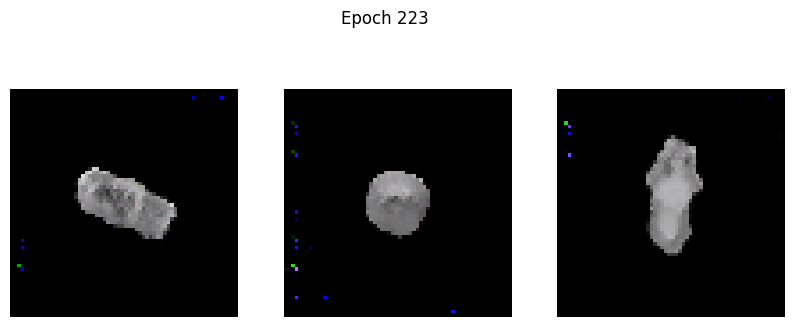

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1088 - g_loss: 3.6032
Epoch 224/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0915 - g_loss: 3.4847

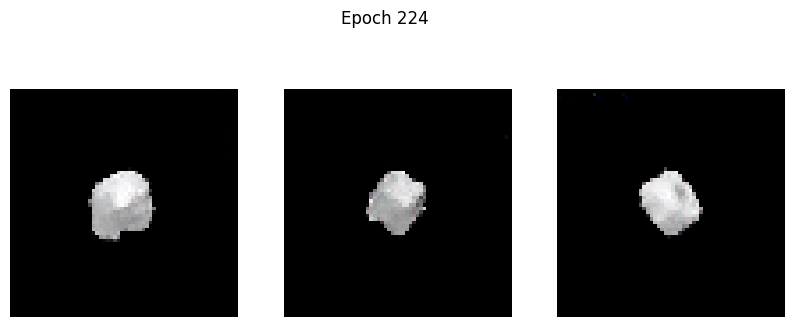

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0915 - g_loss: 3.4855
Epoch 225/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1925 - g_loss: 3.7724

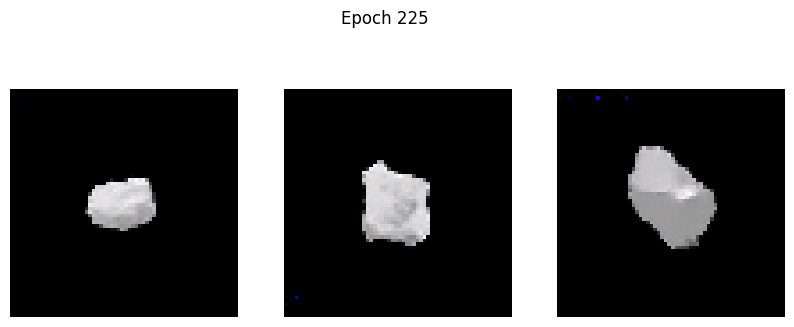

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1934 - g_loss: 3.7752
Epoch 226/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0962 - g_loss: 3.5557

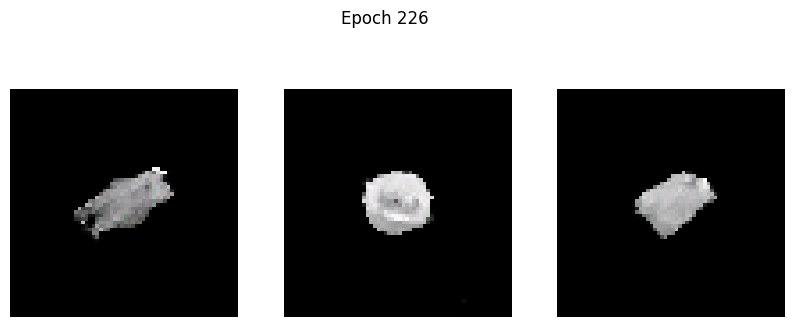

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0962 - g_loss: 3.5556
Epoch 227/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1046 - g_loss: 3.6348

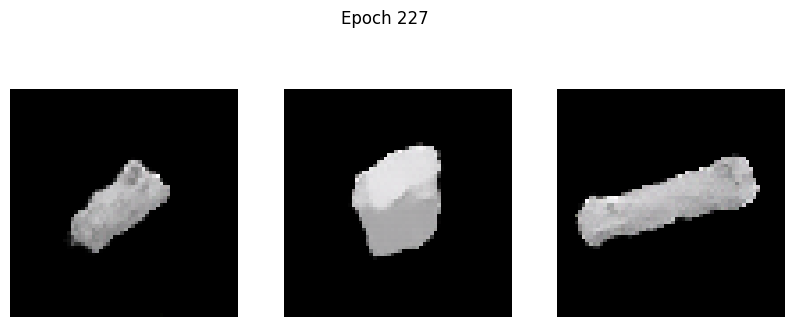

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1045 - g_loss: 3.6343
Epoch 228/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0924 - g_loss: 3.5512

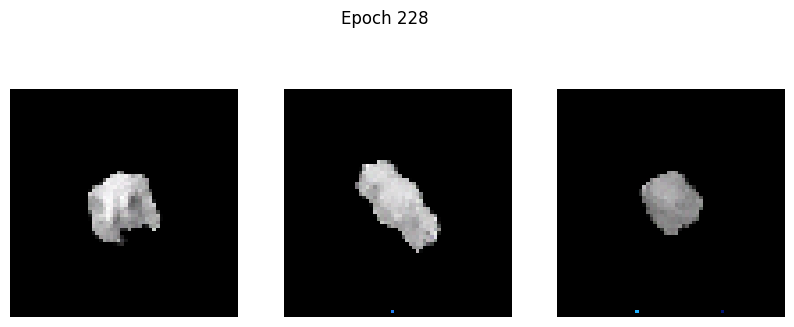

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0924 - g_loss: 3.5514
Epoch 229/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0994 - g_loss: 3.6943

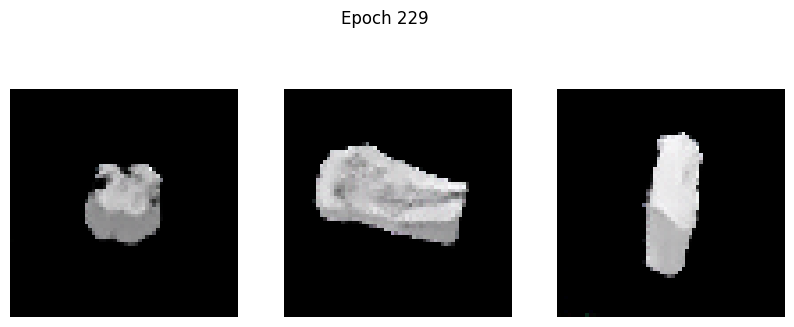

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0996 - g_loss: 3.6946
Epoch 230/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1099 - g_loss: 3.6394

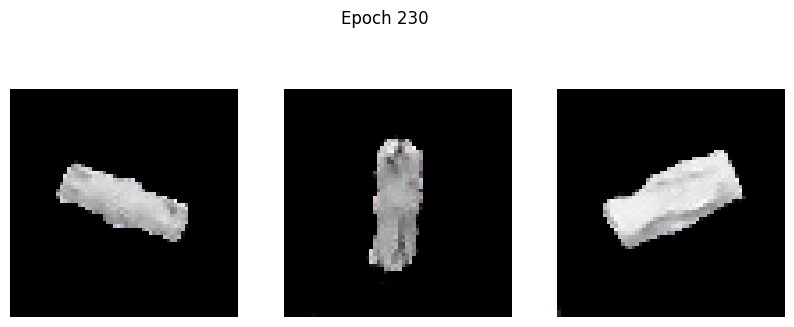

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1103 - g_loss: 3.6402
Epoch 231/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1861 - g_loss: 3.8050

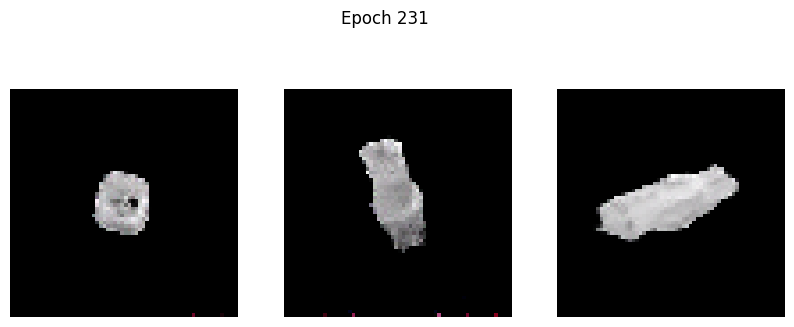

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1856 - g_loss: 3.8041
Epoch 232/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0789 - g_loss: 3.5713

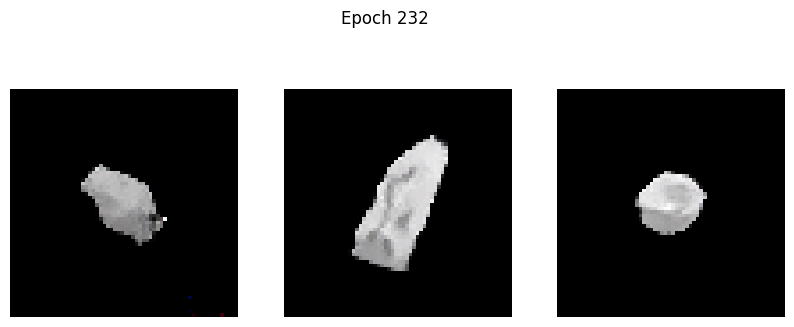

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0790 - g_loss: 3.5718
Epoch 233/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0742 - g_loss: 3.6300

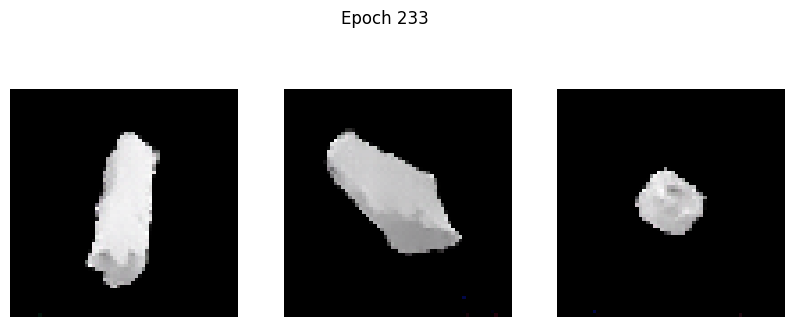

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0742 - g_loss: 3.6301
Epoch 234/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3840 - g_loss: 4.1993

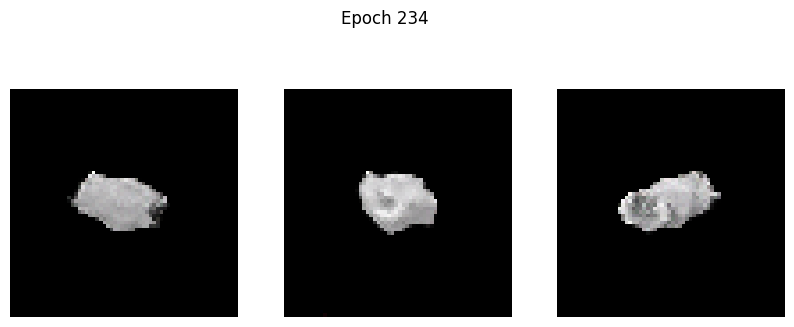

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3830 - g_loss: 4.1969
Epoch 235/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0860 - g_loss: 3.6719

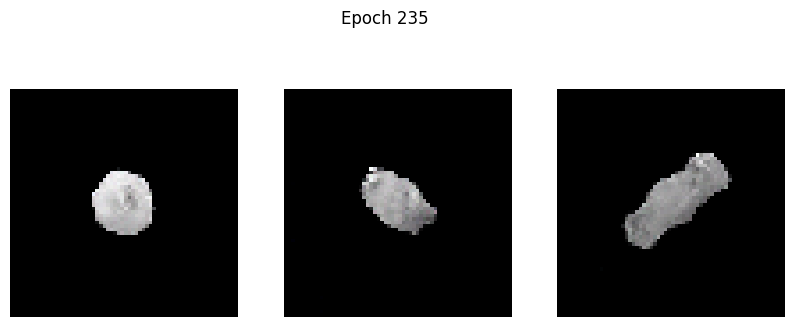

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0860 - g_loss: 3.6714
Epoch 236/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1039 - g_loss: 3.7415

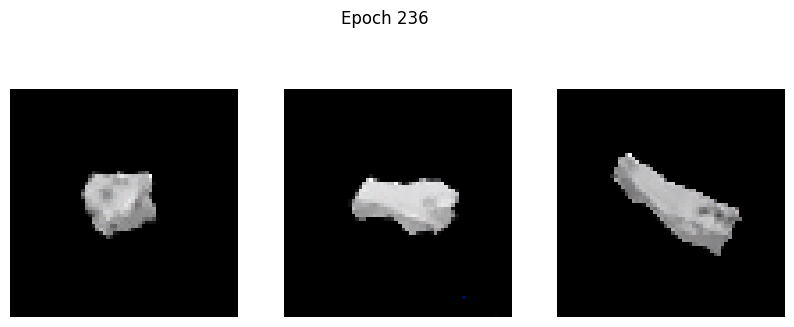

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1039 - g_loss: 3.7409
Epoch 237/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1021 - g_loss: 3.8187

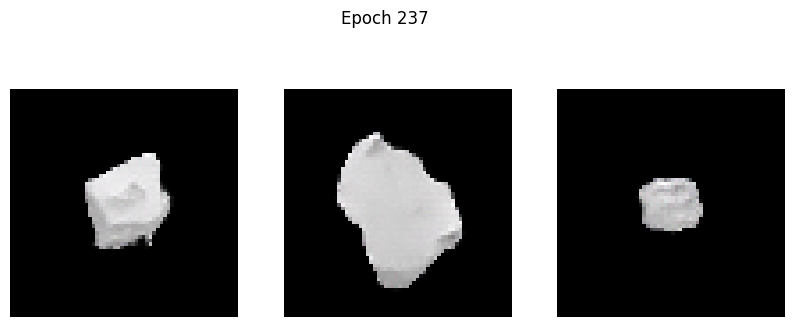

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1021 - g_loss: 3.8185
Epoch 238/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0853 - g_loss: 3.7229

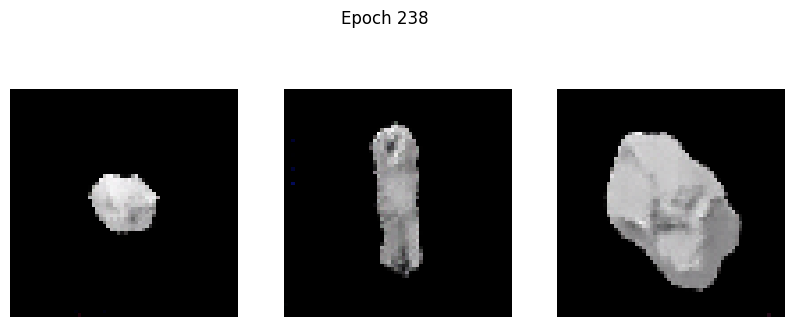

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0854 - g_loss: 3.7232
Epoch 239/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0888 - g_loss: 3.8335

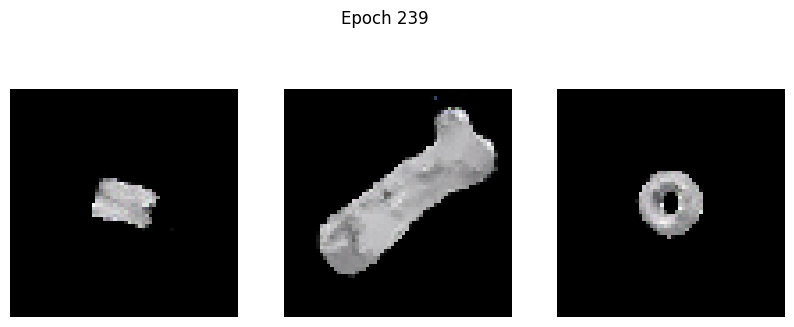

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0890 - g_loss: 3.8335
Epoch 240/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3141 - g_loss: 4.1315

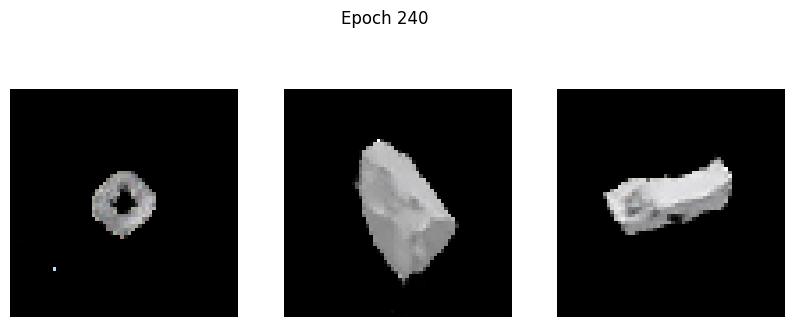

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3129 - g_loss: 4.1294
Epoch 241/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1819 - g_loss: 3.9260

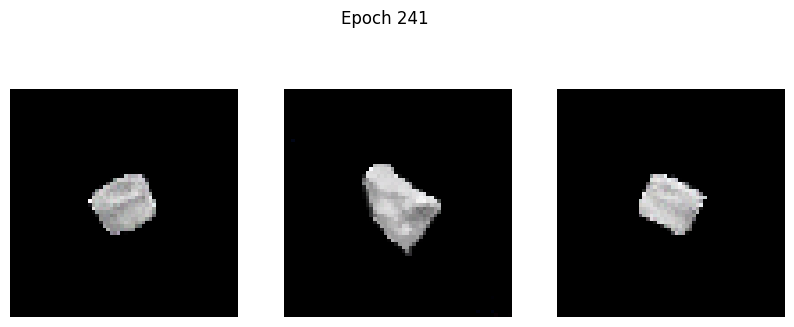

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1813 - g_loss: 3.9246
Epoch 242/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0854 - g_loss: 3.6598

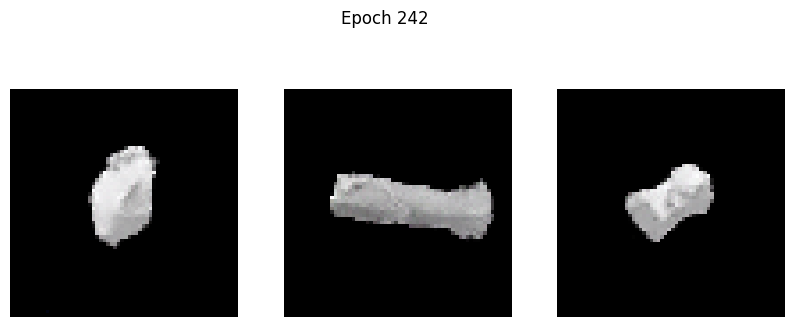

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0854 - g_loss: 3.6606
Epoch 243/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0966 - g_loss: 3.6989

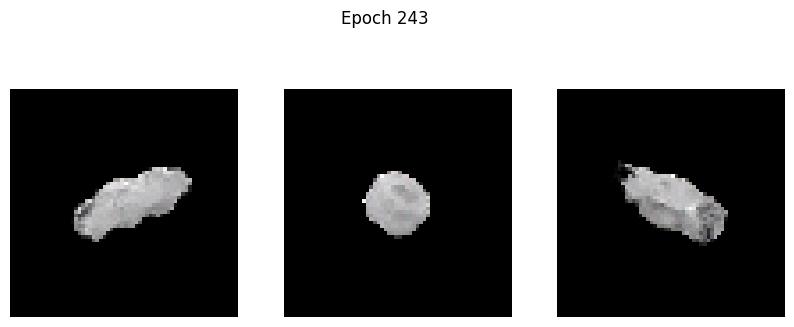

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0966 - g_loss: 3.6992
Epoch 244/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1287 - g_loss: 3.9717

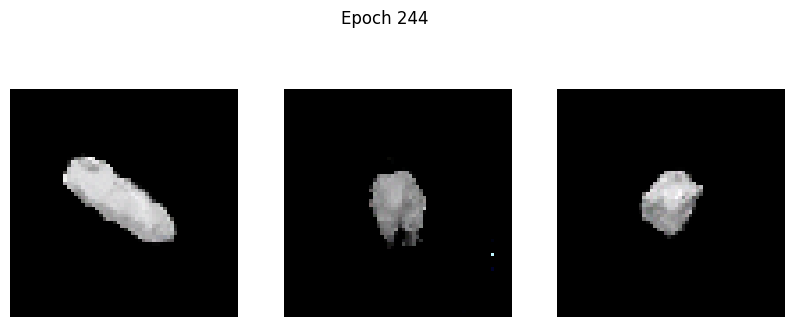

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1289 - g_loss: 3.9716
Epoch 245/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1928 - g_loss: 3.9611

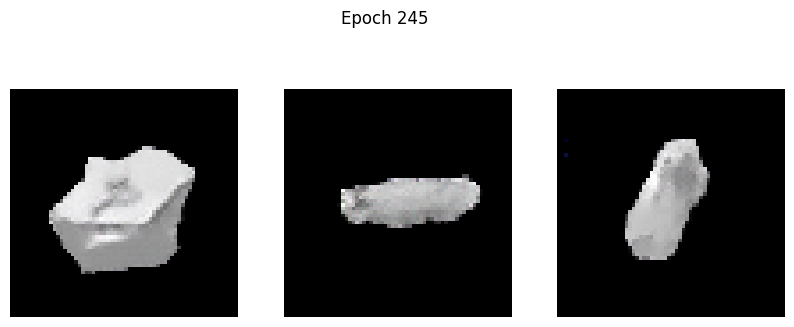

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1924 - g_loss: 3.9604
Epoch 246/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0945 - g_loss: 3.7730

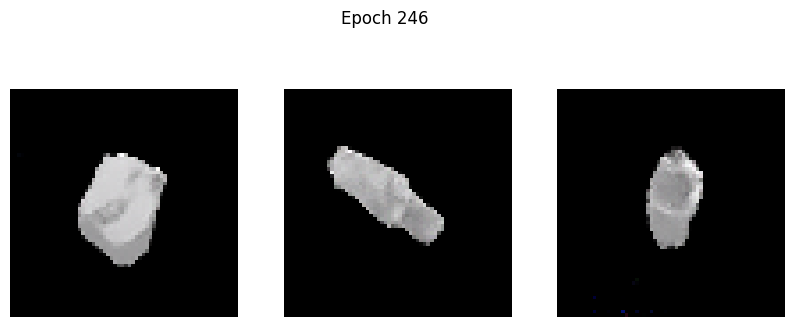

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0945 - g_loss: 3.7729
Epoch 247/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5207 - g_loss: 4.3396

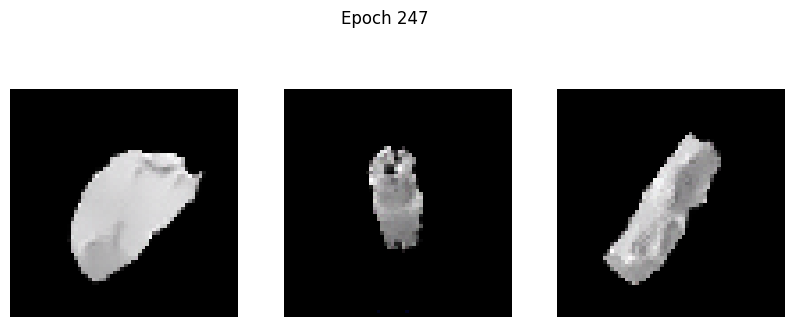

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5186 - g_loss: 4.3352
Epoch 248/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1042 - g_loss: 3.6935

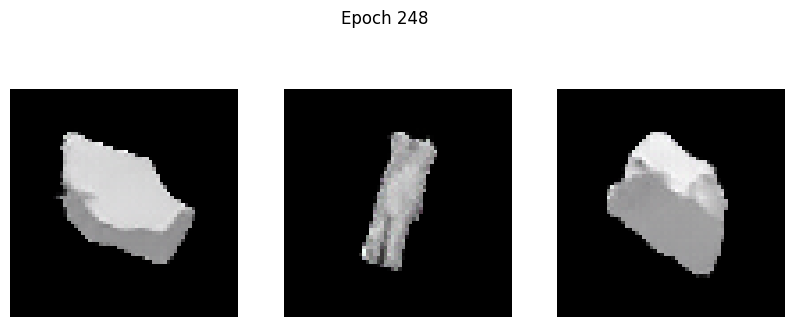

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1041 - g_loss: 3.6933
Epoch 249/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1158 - g_loss: 3.7897

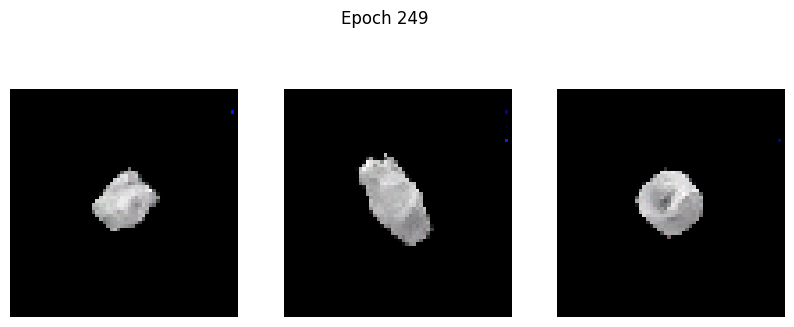

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1157 - g_loss: 3.7897
Epoch 250/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0725 - g_loss: 3.6896

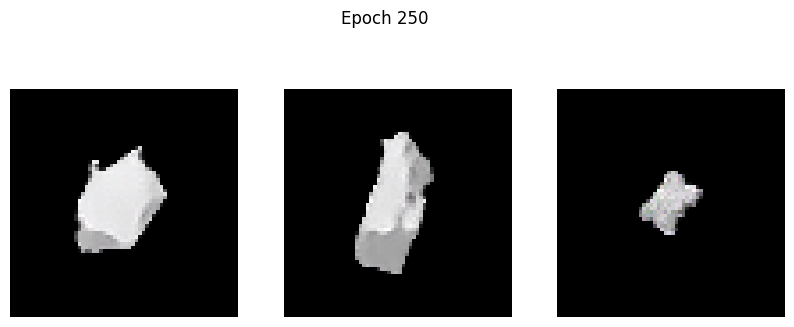

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0726 - g_loss: 3.6903
Epoch 251/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1090 - g_loss: 3.8735

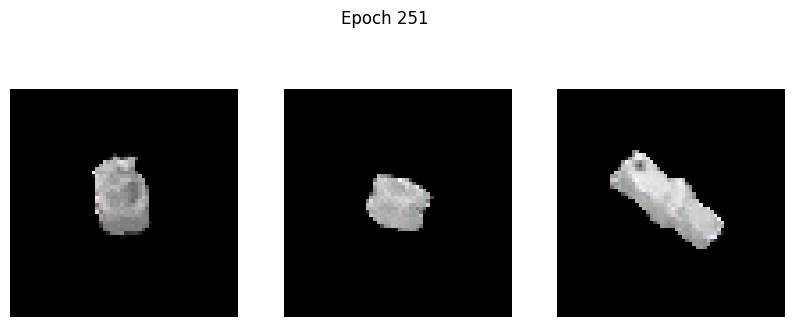

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1089 - g_loss: 3.8733
Epoch 252/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1098 - g_loss: 3.9067

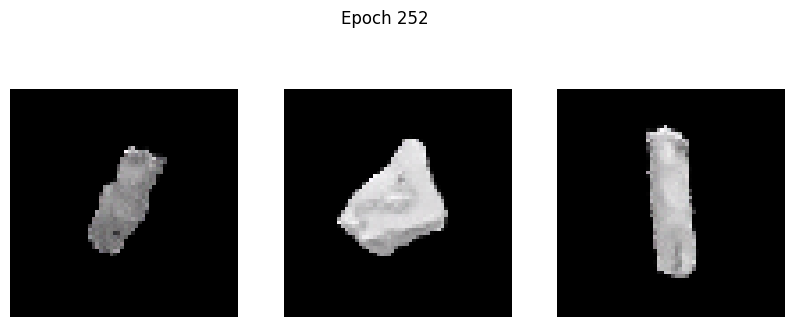

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1098 - g_loss: 3.9064
Epoch 253/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0936 - g_loss: 3.9081

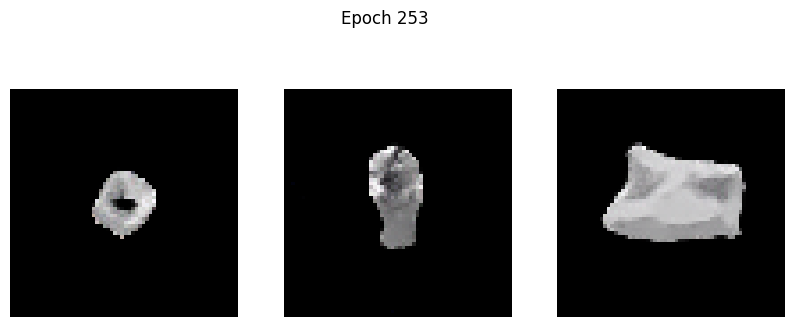

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0936 - g_loss: 3.9080
Epoch 254/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1142 - g_loss: 4.0217

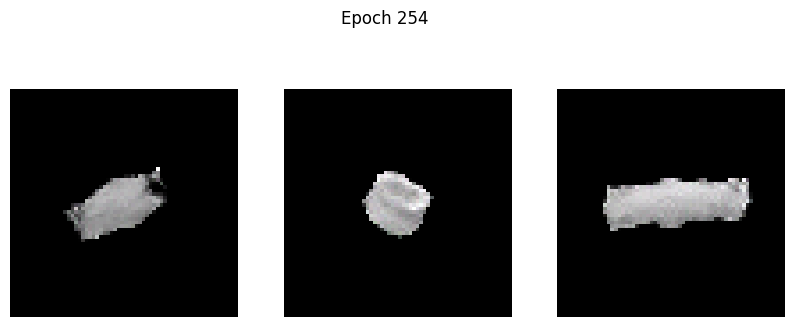

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1142 - g_loss: 4.0214
Epoch 255/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1158 - g_loss: 4.0230

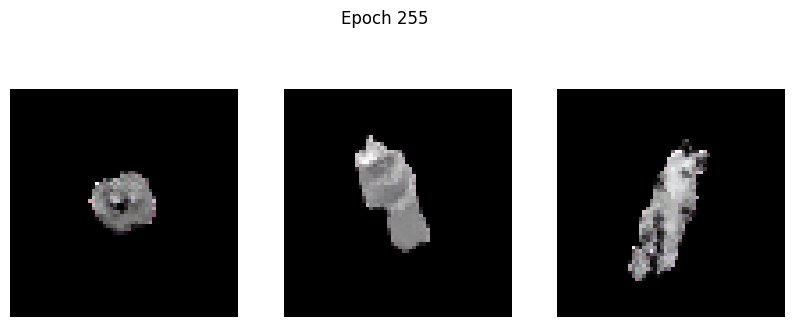

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1182 - g_loss: 4.0263
Epoch 256/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1467 - g_loss: 3.8634

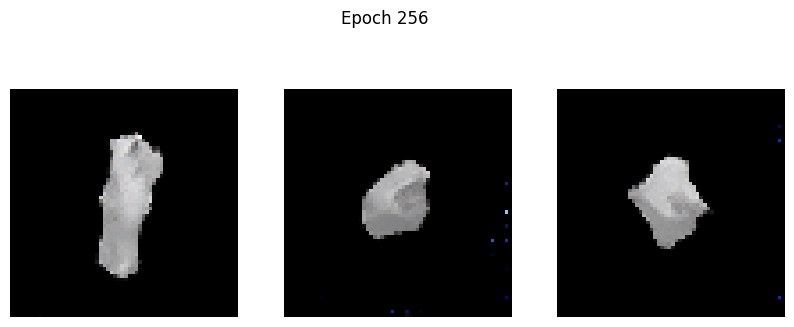

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1463 - g_loss: 3.8627
Epoch 257/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0913 - g_loss: 3.7024

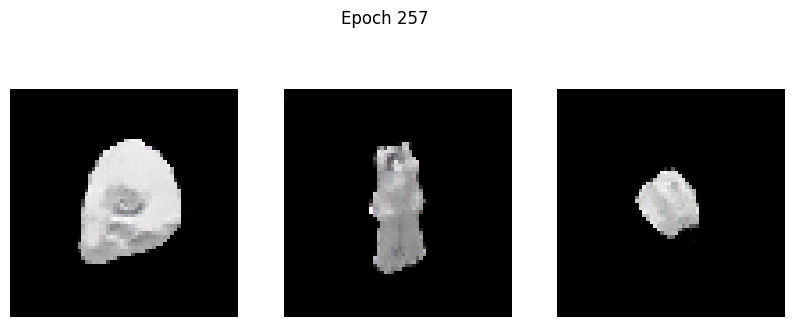

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0912 - g_loss: 3.7026
Epoch 258/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1024 - g_loss: 3.8514

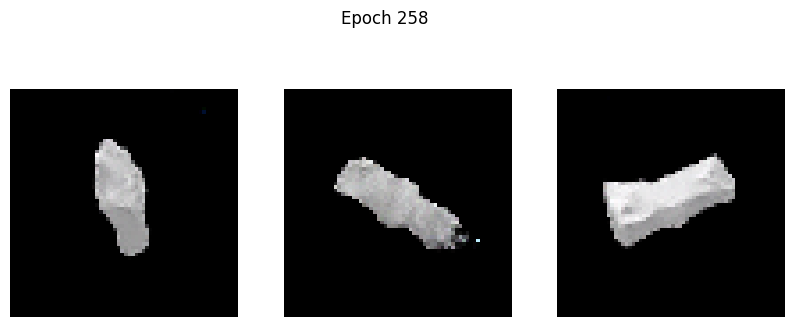

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1024 - g_loss: 3.8515
Epoch 259/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0741 - g_loss: 3.8355

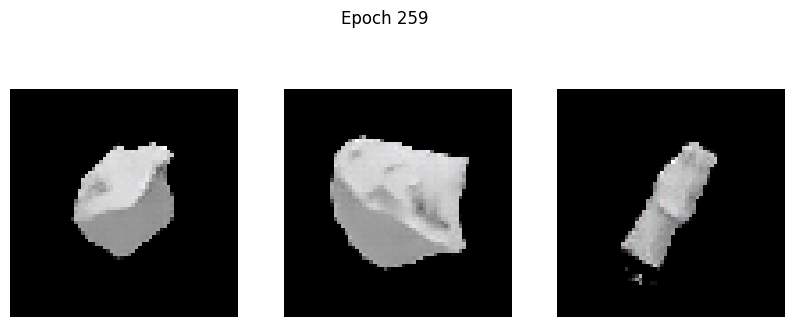

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0741 - g_loss: 3.8354
Epoch 260/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0744 - g_loss: 3.9777

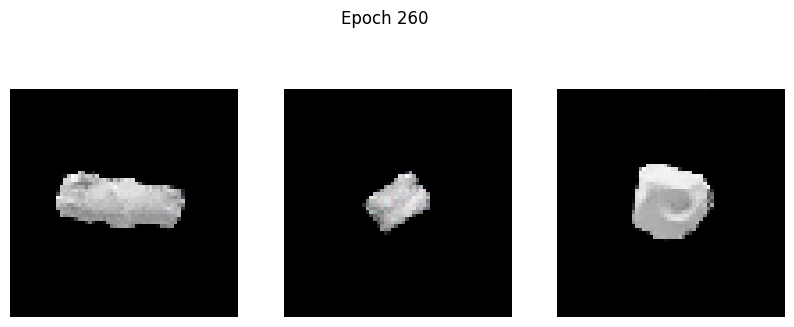

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0746 - g_loss: 3.9775
Epoch 261/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0952 - g_loss: 3.9974

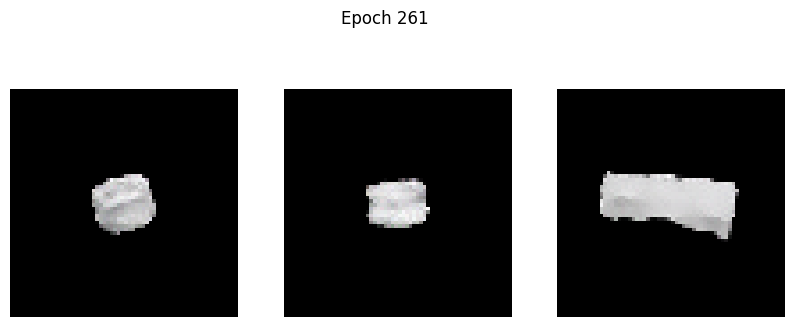

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0951 - g_loss: 3.9971
Epoch 262/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1540 - g_loss: 4.1710

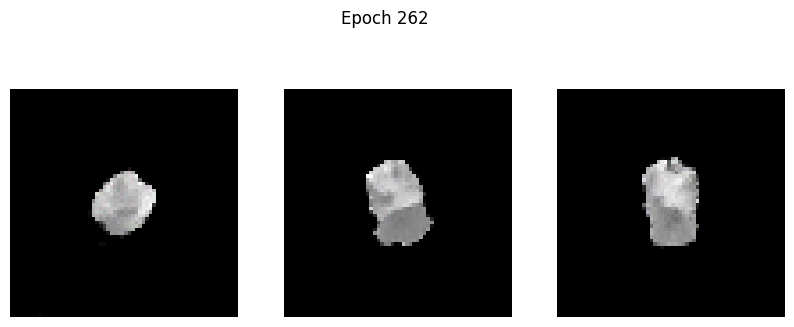

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1550 - g_loss: 4.1716
Epoch 263/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0832 - g_loss: 3.7008

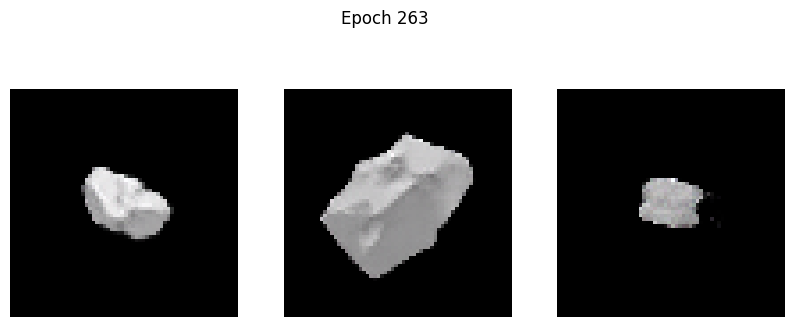

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0832 - g_loss: 3.7015
Epoch 264/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0850 - g_loss: 3.9043

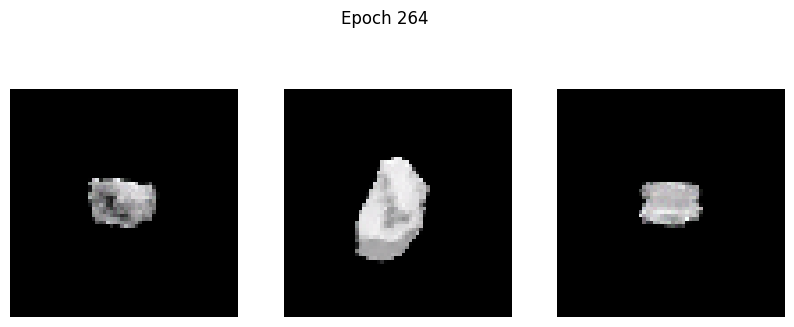

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0850 - g_loss: 3.9041
Epoch 265/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0641 - g_loss: 3.7583

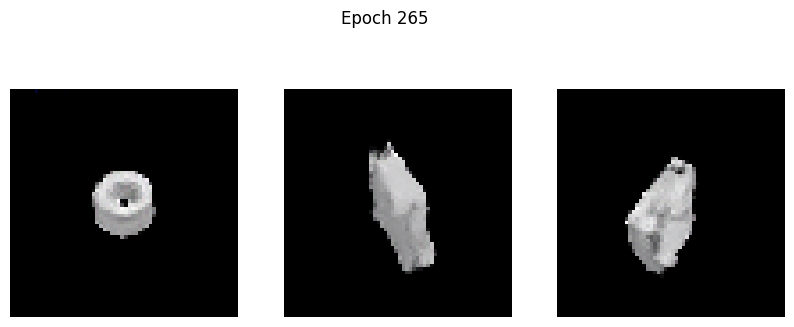

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0641 - g_loss: 3.7589
Epoch 266/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0915 - g_loss: 3.9291

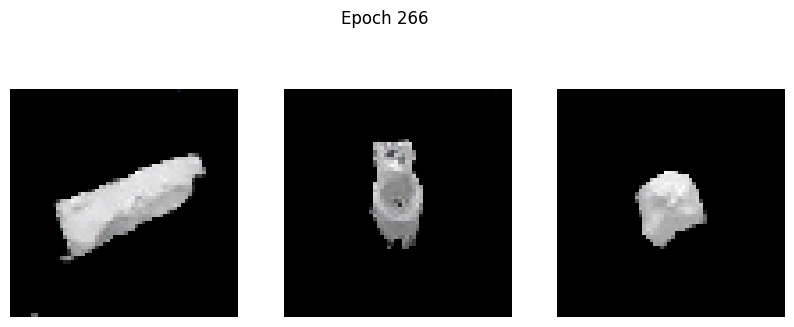

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0915 - g_loss: 3.9289
Epoch 267/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0635 - g_loss: 3.9037

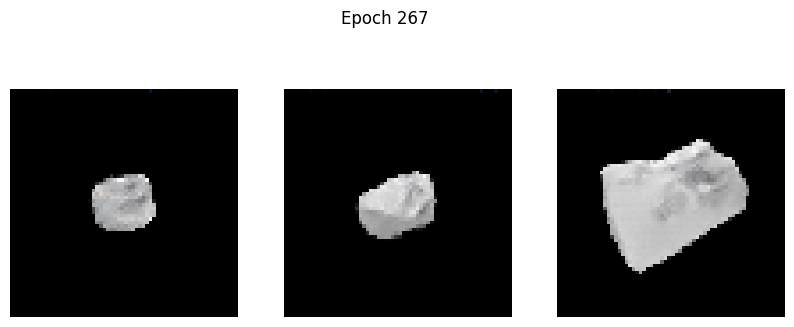

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0636 - g_loss: 3.9047
Epoch 268/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1471 - g_loss: 4.2288

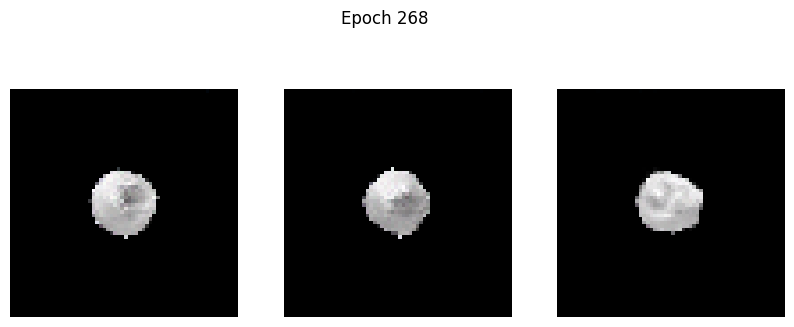

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1471 - g_loss: 4.2287
Epoch 269/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1974 - g_loss: 4.2160

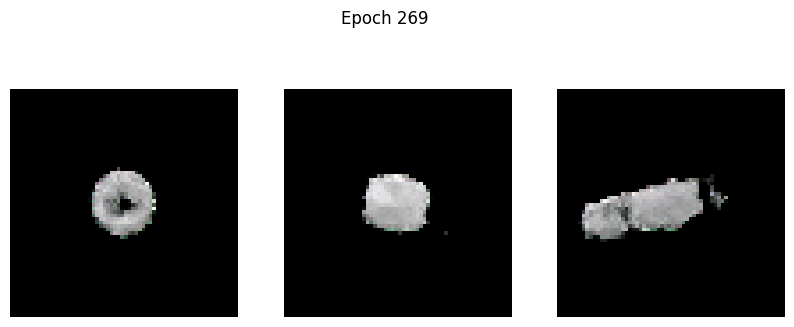

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1995 - g_loss: 4.2207
Epoch 270/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0927 - g_loss: 3.7936

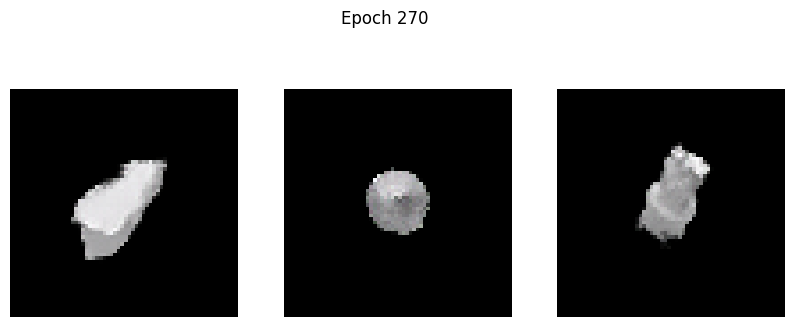

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0927 - g_loss: 3.7936
Epoch 271/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0742 - g_loss: 3.7666

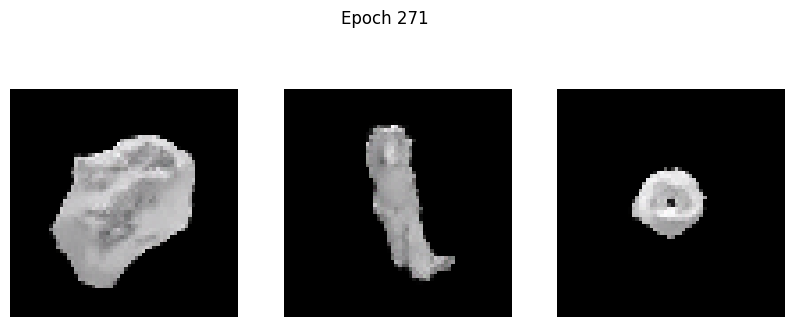

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0742 - g_loss: 3.7668
Epoch 272/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0753 - g_loss: 3.8143

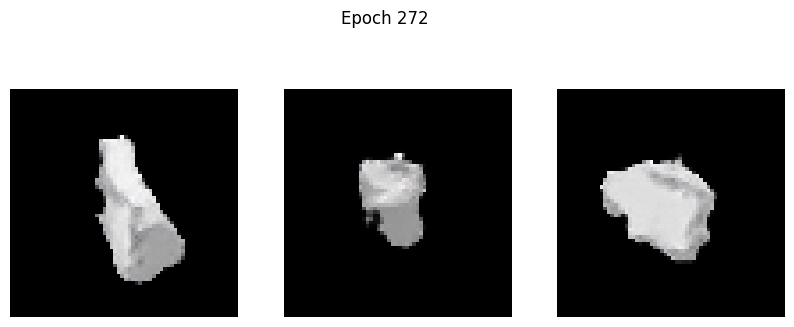

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0757 - g_loss: 3.8151
Epoch 273/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1004 - g_loss: 3.9103

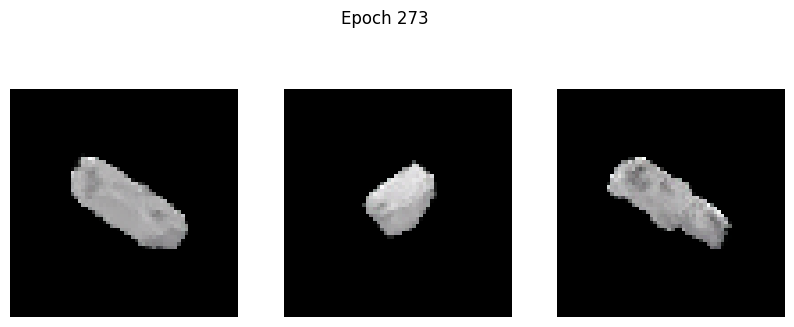

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1004 - g_loss: 3.9109
Epoch 274/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0798 - g_loss: 3.9403

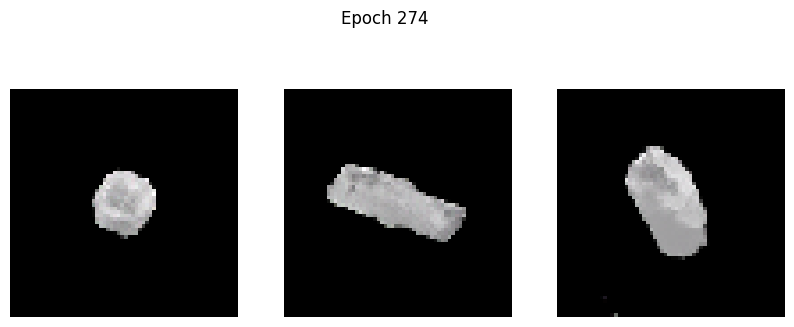

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0798 - g_loss: 3.9408
Epoch 275/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0725 - g_loss: 4.0348

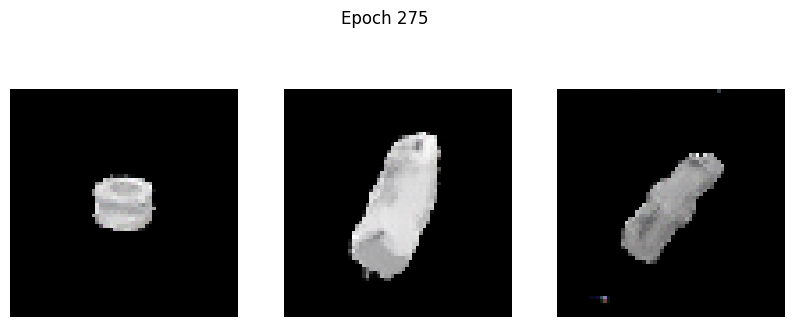

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - d_loss: 0.0725 - g_loss: 4.0346
Epoch 276/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0968 - g_loss: 4.1851

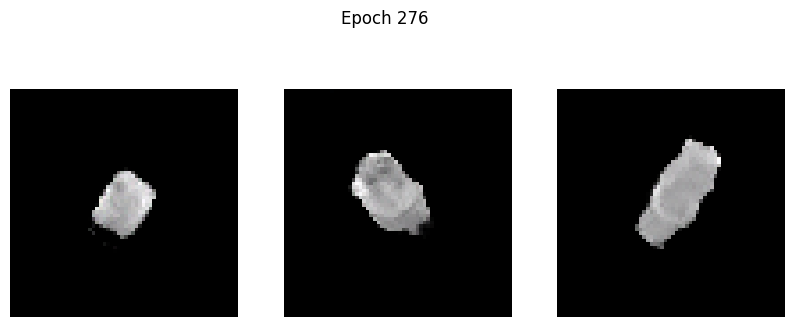

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0967 - g_loss: 4.1844
Epoch 277/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0944 - g_loss: 4.1075

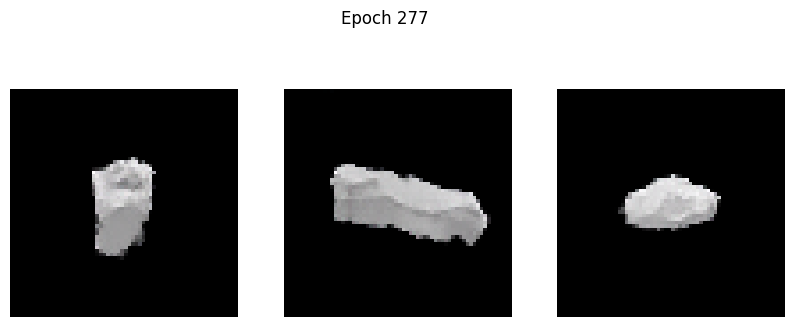

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0948 - g_loss: 4.1080
Epoch 278/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0729 - g_loss: 3.9434

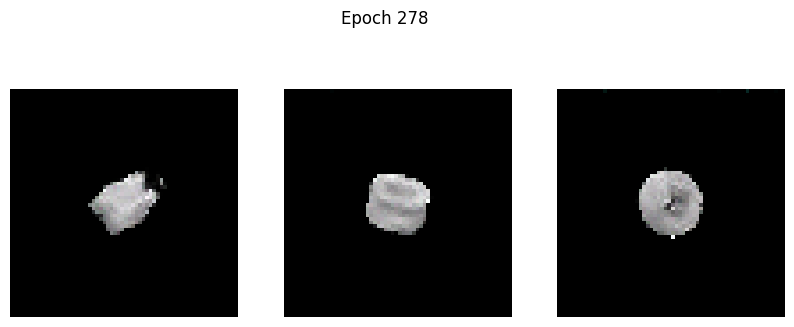

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0728 - g_loss: 3.9428
Epoch 279/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0924 - g_loss: 4.1372

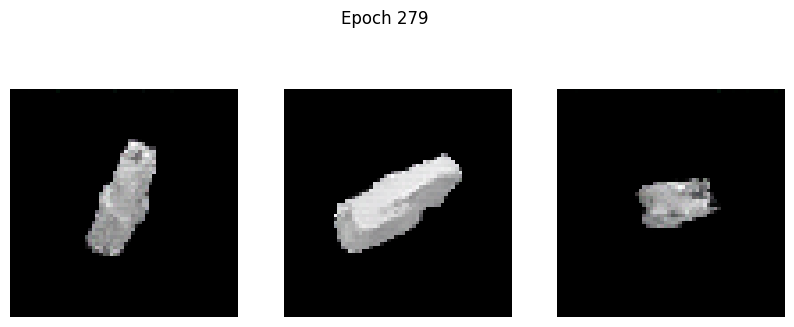

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - d_loss: 0.0925 - g_loss: 4.1374
Epoch 280/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0639 - g_loss: 4.0177

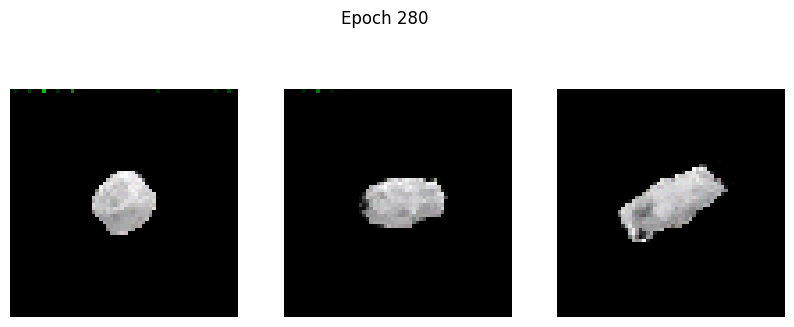

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0641 - g_loss: 4.0180
Epoch 281/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.0603 - g_loss: 4.0785

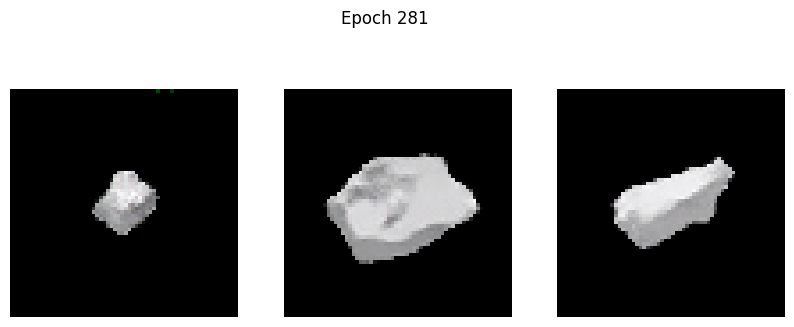

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.0604 - g_loss: 4.0784
Epoch 282/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0936 - g_loss: 4.0950

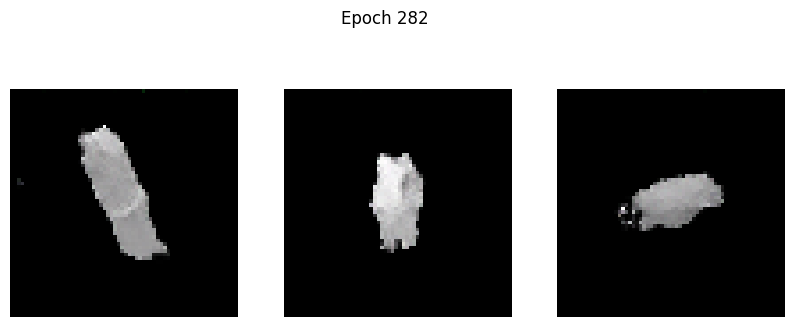

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0936 - g_loss: 4.0949
Epoch 283/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0721 - g_loss: 4.1419

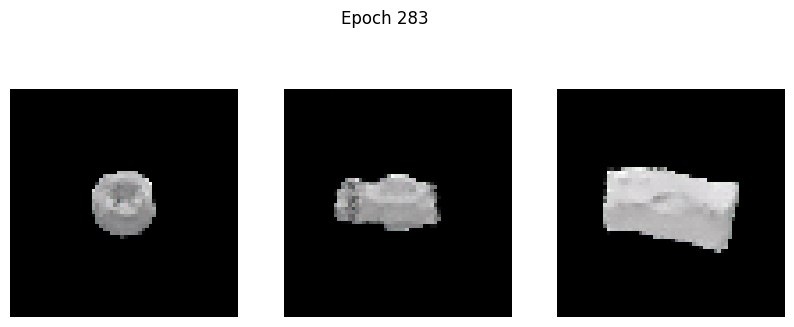

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0724 - g_loss: 4.1422
Epoch 284/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1544 - g_loss: 4.3548

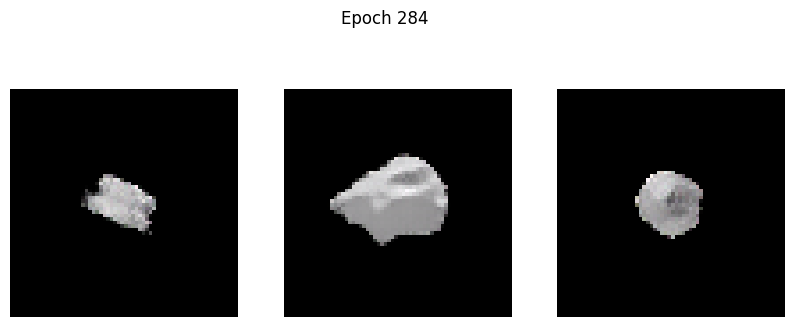

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1541 - g_loss: 4.3532
Epoch 285/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0617 - g_loss: 4.0943

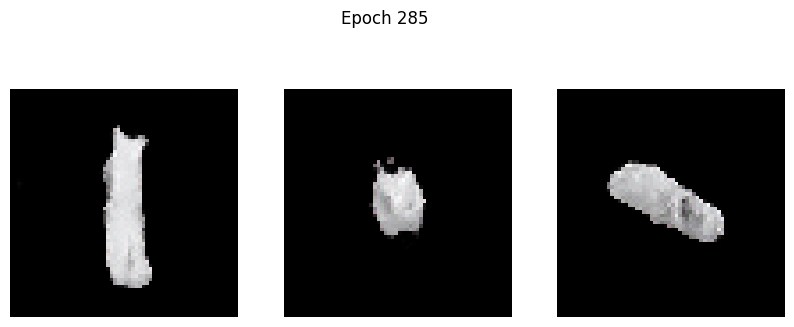

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0619 - g_loss: 4.0946
Epoch 286/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0765 - g_loss: 3.9933

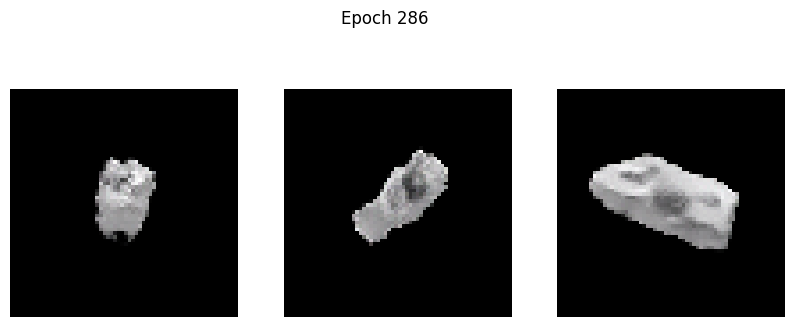

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0766 - g_loss: 3.9940
Epoch 287/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1094 - g_loss: 4.1058

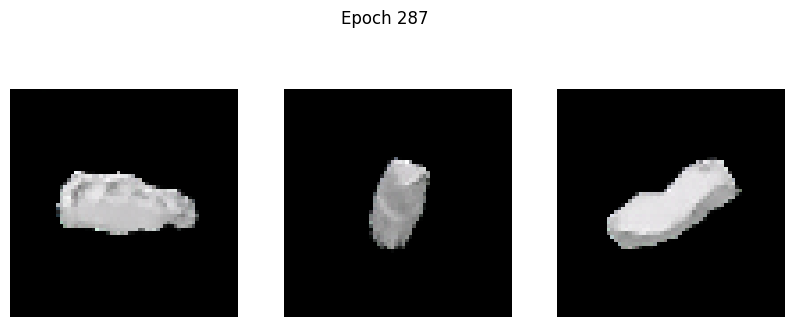

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1097 - g_loss: 4.1071
Epoch 288/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1269 - g_loss: 4.3033

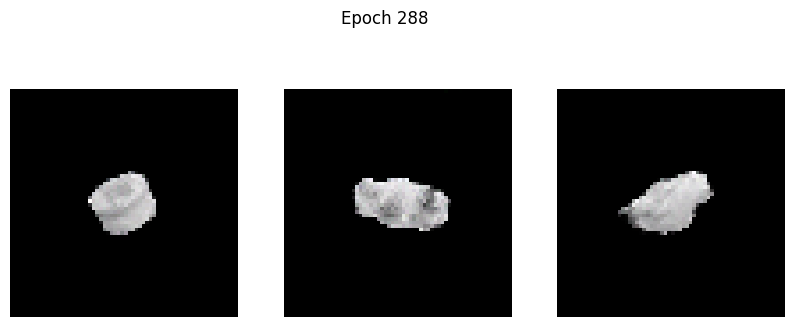

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1270 - g_loss: 4.3032
Epoch 289/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0711 - g_loss: 4.1114

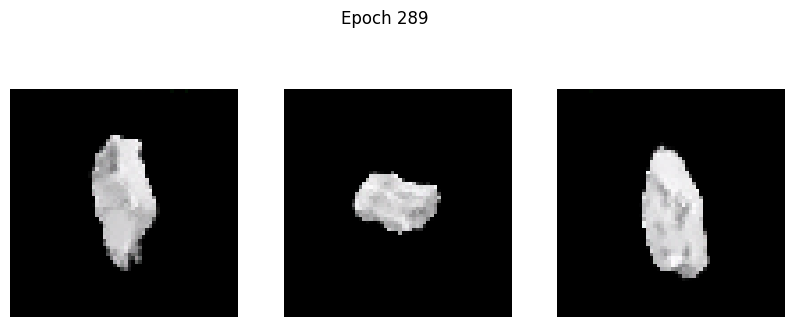

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0711 - g_loss: 4.1112
Epoch 290/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0711 - g_loss: 4.1013

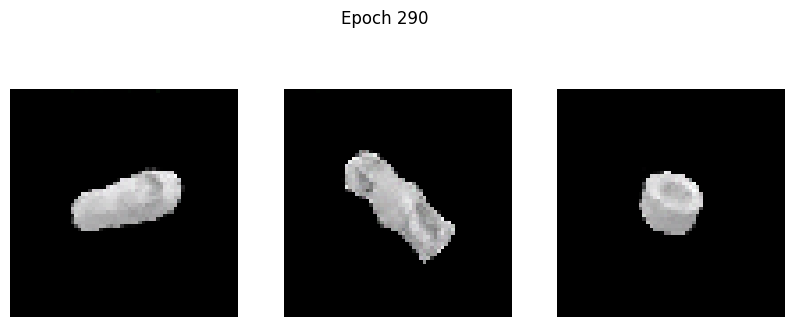

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0711 - g_loss: 4.1011
Epoch 291/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1336 - g_loss: 4.4447

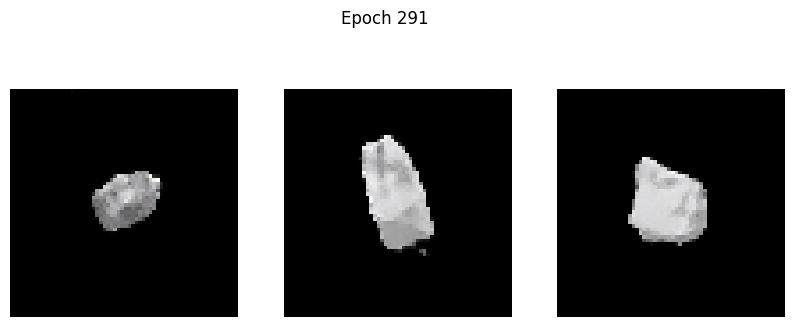

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1342 - g_loss: 4.4451
Epoch 292/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0627 - g_loss: 4.1155

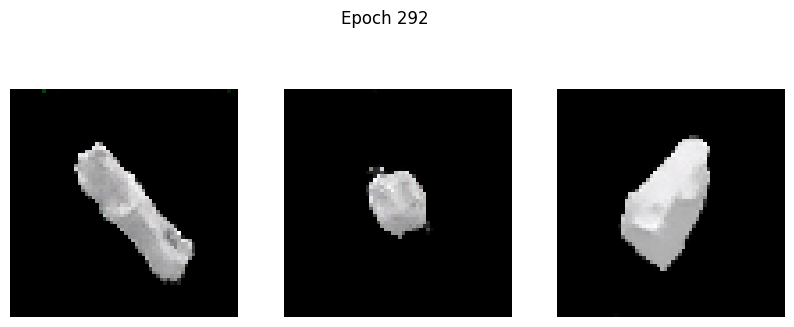

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0627 - g_loss: 4.1157
Epoch 293/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0660 - g_loss: 4.1101

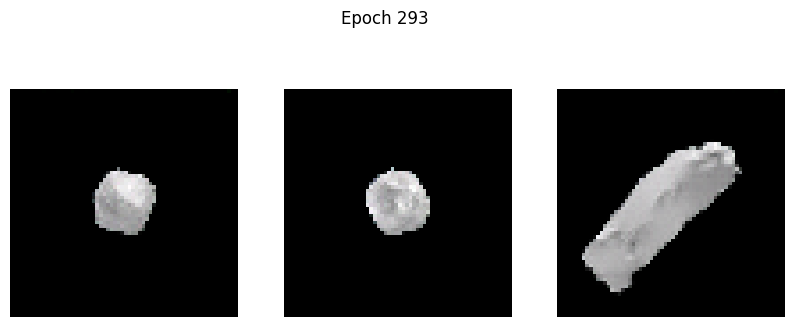

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0661 - g_loss: 4.1105
Epoch 294/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0967 - g_loss: 4.1609

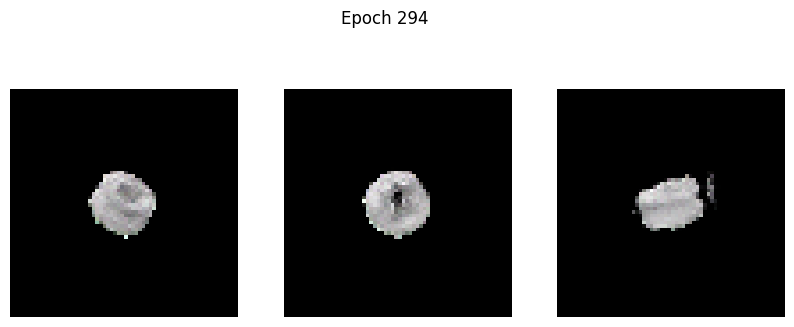

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0967 - g_loss: 4.1610
Epoch 295/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0729 - g_loss: 4.2238

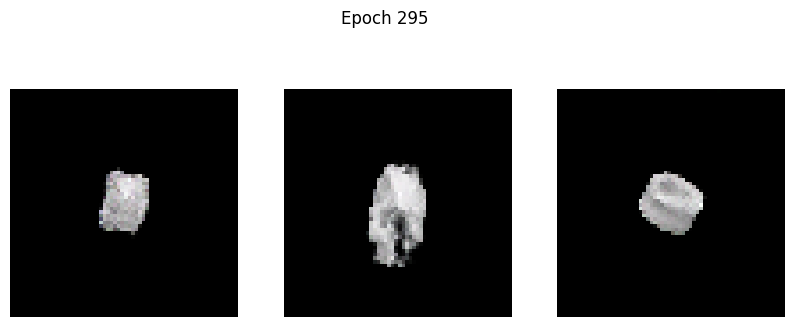

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0730 - g_loss: 4.2249
Epoch 296/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1327 - g_loss: 4.4799

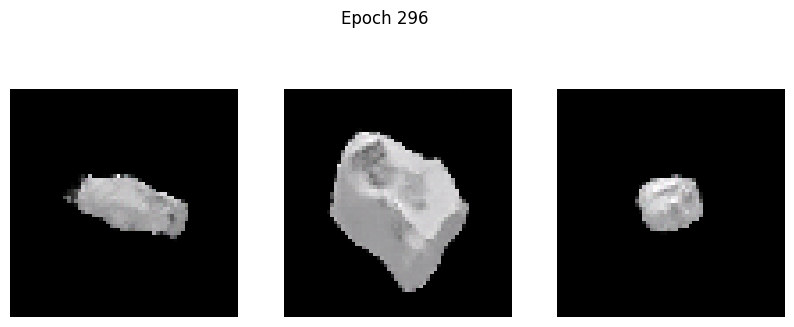

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1323 - g_loss: 4.4781
Epoch 297/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0578 - g_loss: 4.1488

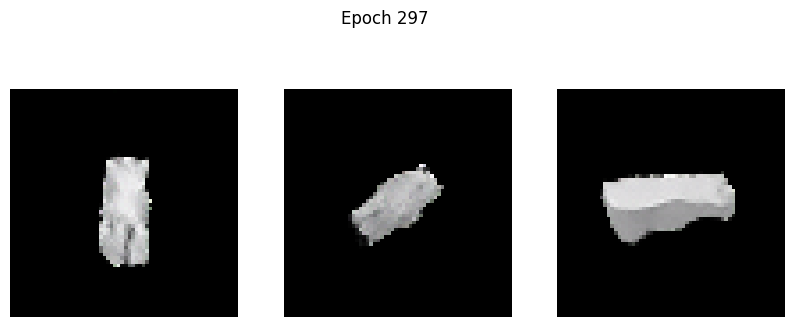

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0582 - g_loss: 4.1503
Epoch 298/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0954 - g_loss: 4.3440

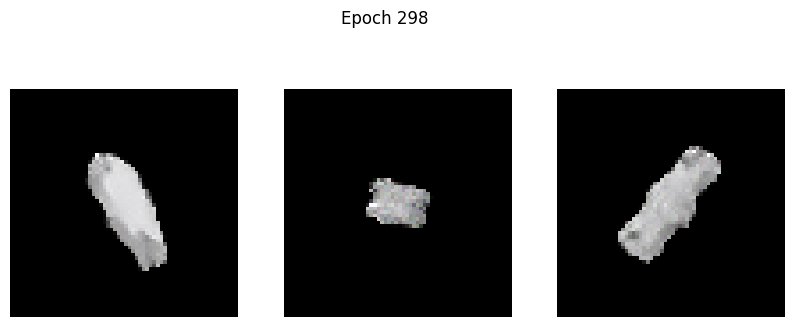

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0951 - g_loss: 4.3434
Epoch 299/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0820 - g_loss: 4.3492

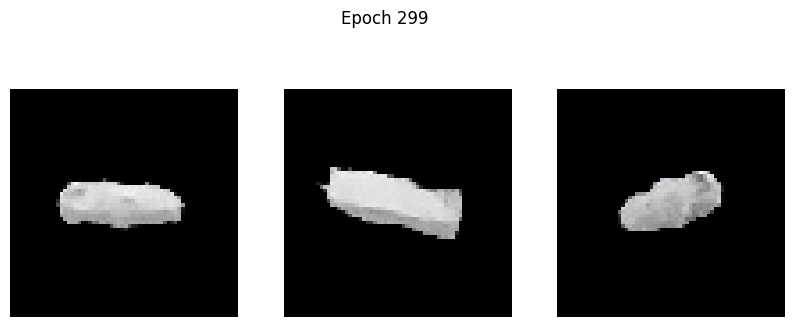

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0819 - g_loss: 4.3491
Epoch 300/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1222 - g_loss: 4.3956

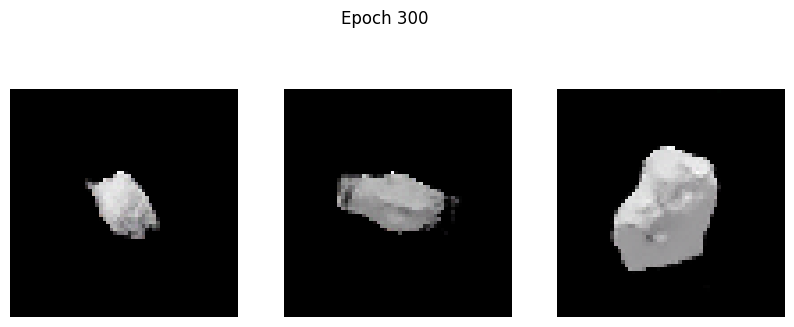

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1223 - g_loss: 4.3966
Epoch 301/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0628 - g_loss: 4.1686

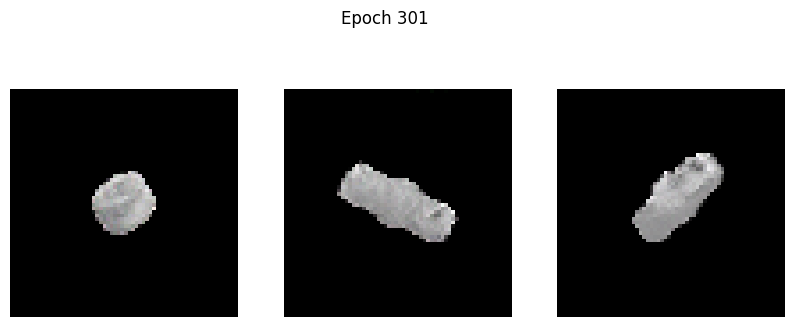

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0627 - g_loss: 4.1693
Epoch 302/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0669 - g_loss: 4.2468

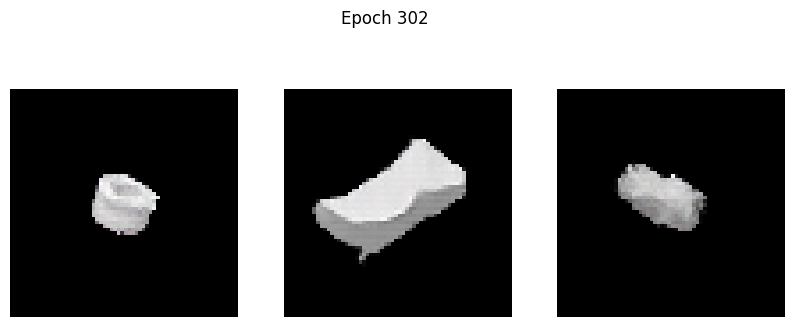

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0670 - g_loss: 4.2470
Epoch 303/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0669 - g_loss: 4.4545

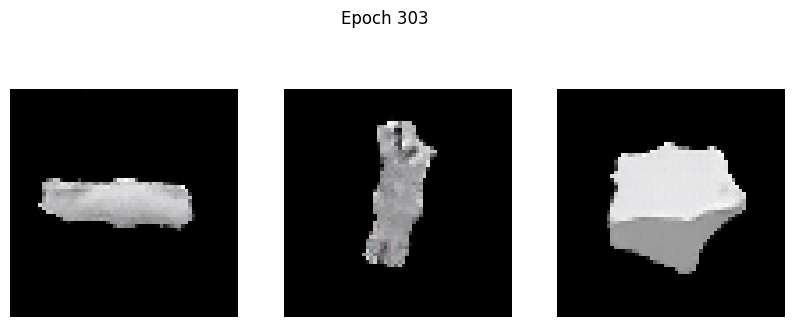

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0670 - g_loss: 4.4540
Epoch 304/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1473 - g_loss: 4.4027

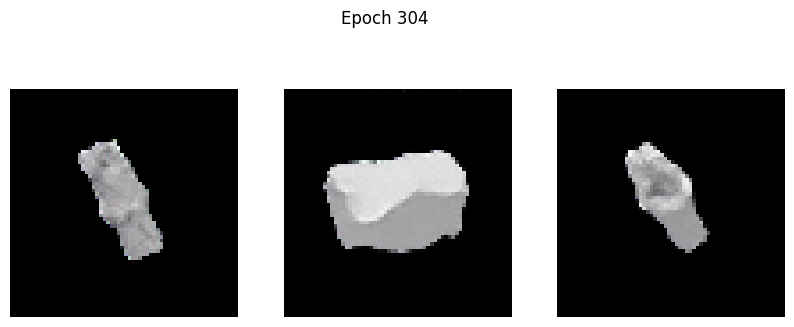

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1493 - g_loss: 4.4080
Epoch 305/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0902 - g_loss: 3.8987

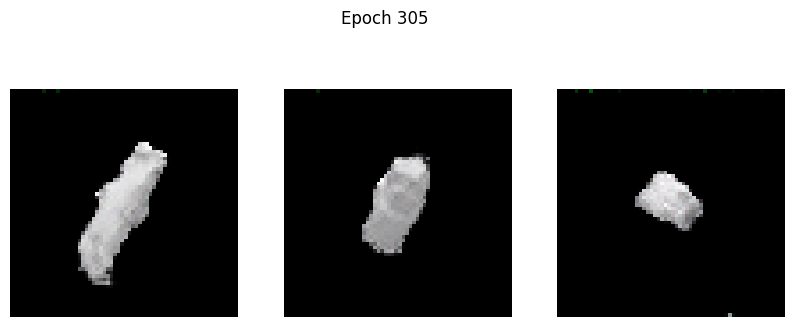

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0901 - g_loss: 3.8997
Epoch 306/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0495 - g_loss: 4.0836

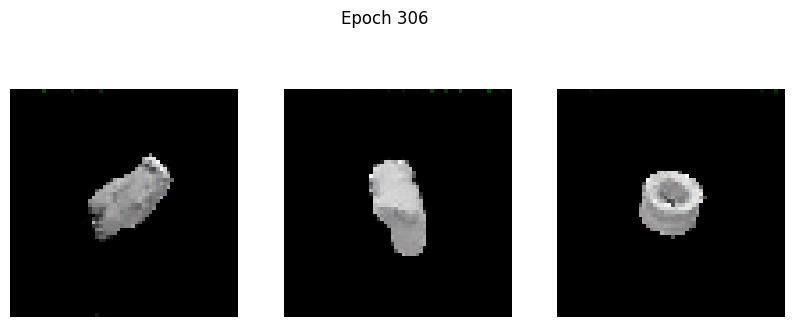

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0495 - g_loss: 4.0842
Epoch 307/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0505 - g_loss: 4.1731

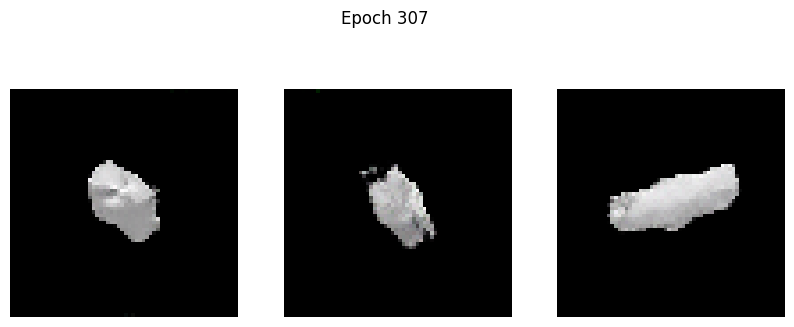

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0505 - g_loss: 4.1731
Epoch 308/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0532 - g_loss: 4.2810

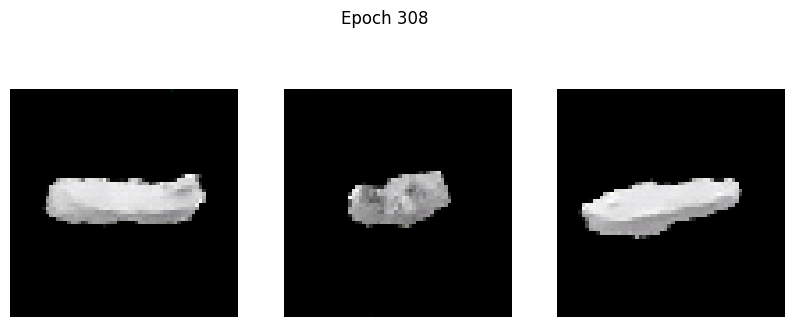

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0532 - g_loss: 4.2813
Epoch 309/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0502 - g_loss: 4.2469

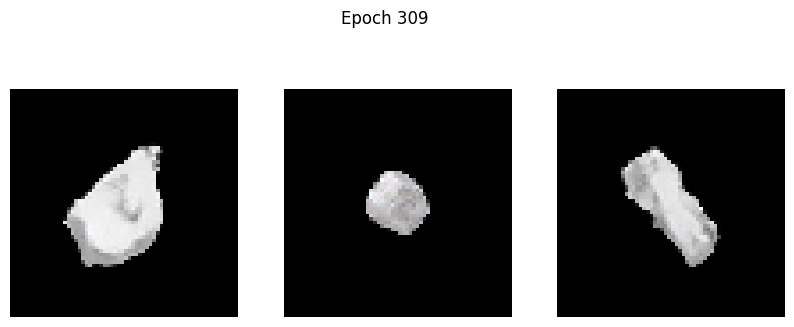

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0503 - g_loss: 4.2472
Epoch 310/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0620 - g_loss: 4.3031

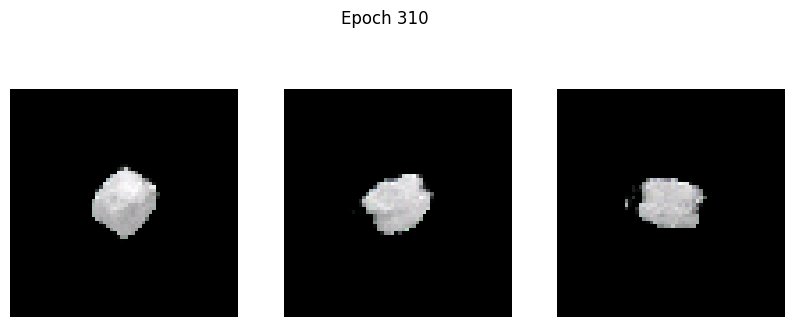

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0623 - g_loss: 4.3045
Epoch 311/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0963 - g_loss: 4.1539

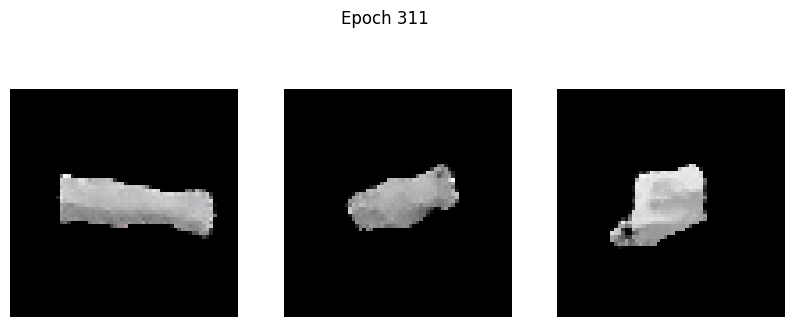

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0961 - g_loss: 4.1545
Epoch 312/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1141 - g_loss: 4.4597

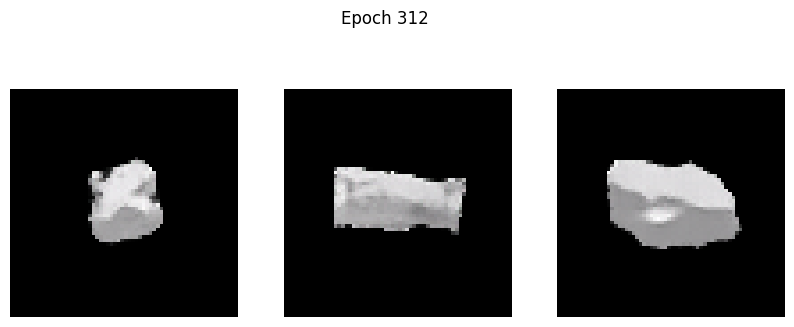

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1138 - g_loss: 4.4585
Epoch 313/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0483 - g_loss: 4.3807

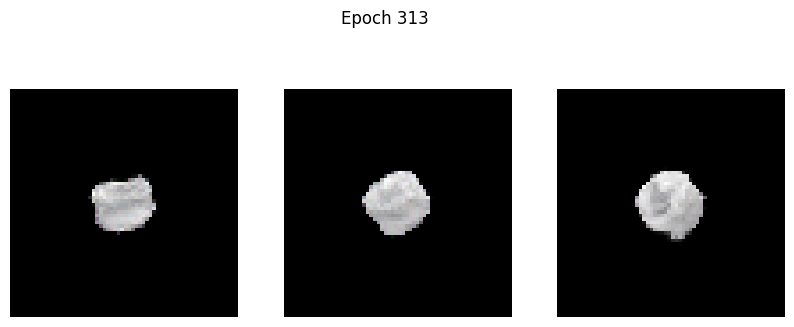

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0486 - g_loss: 4.3816
Epoch 314/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0435 - g_loss: 4.2941

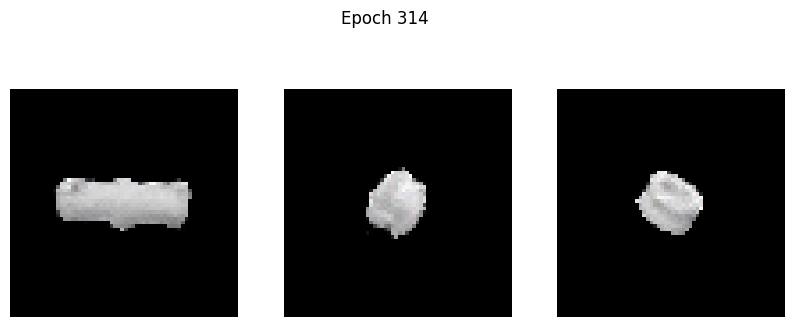

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0437 - g_loss: 4.2948
Epoch 315/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0946 - g_loss: 4.5511

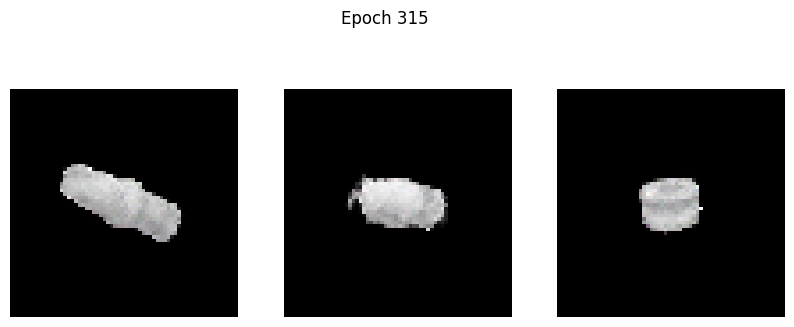

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0944 - g_loss: 4.5503
Epoch 316/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0952 - g_loss: 4.5690

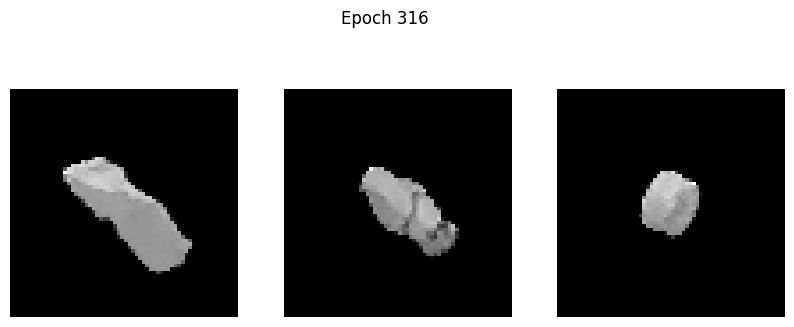

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0949 - g_loss: 4.5676
Epoch 317/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0863 - g_loss: 4.6252

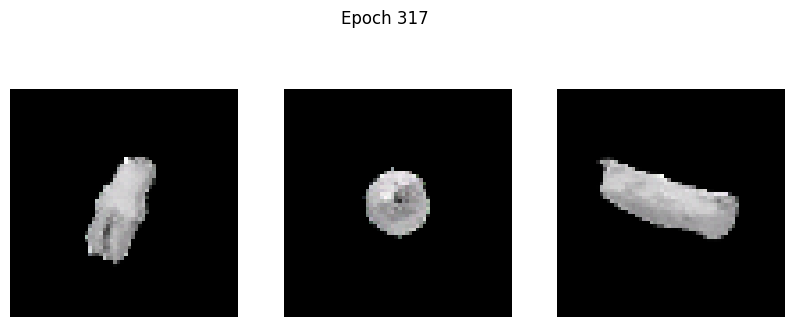

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0866 - g_loss: 4.6261
Epoch 318/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0651 - g_loss: 4.2210

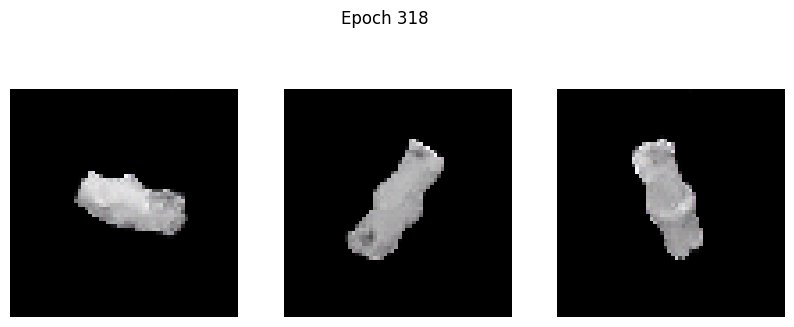

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0650 - g_loss: 4.2210
Epoch 319/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0558 - g_loss: 4.3371

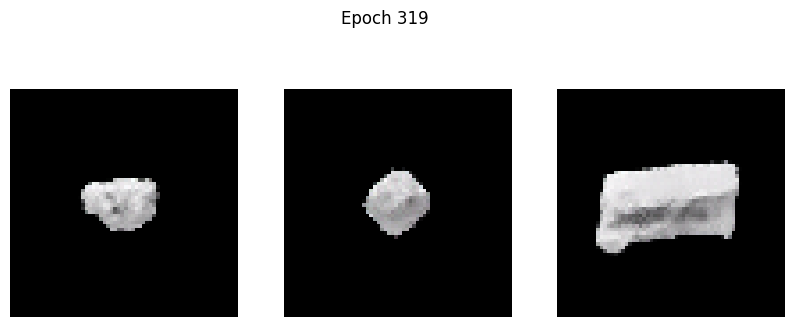

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0559 - g_loss: 4.3391
Epoch 320/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0359 - g_loss: 4.2398

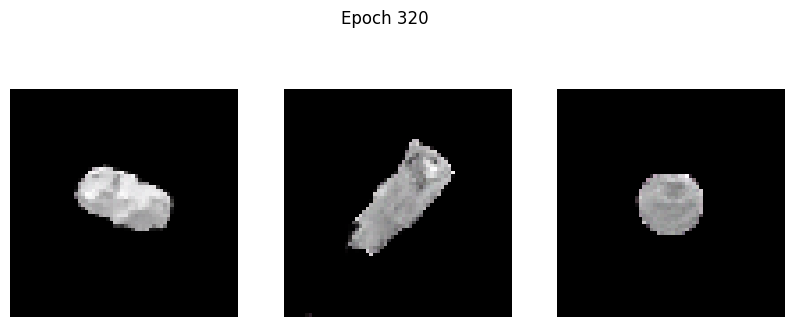

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0364 - g_loss: 4.2420
Epoch 321/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2418 - g_loss: 4.6215

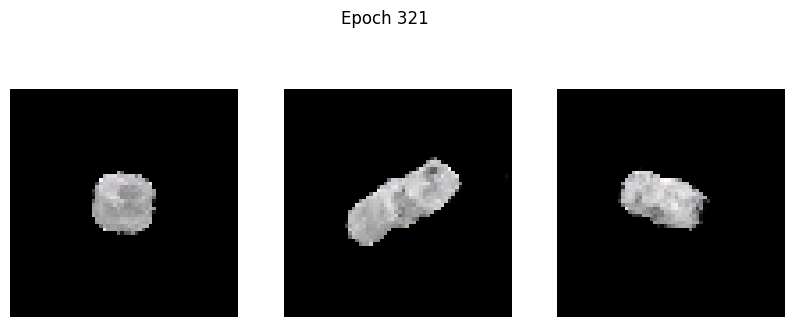

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2409 - g_loss: 4.6208
Epoch 322/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0624 - g_loss: 4.3926

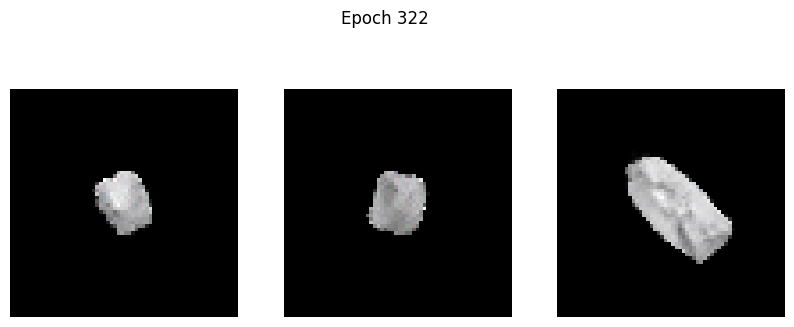

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0624 - g_loss: 4.3926
Epoch 323/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0336 - g_loss: 4.3870

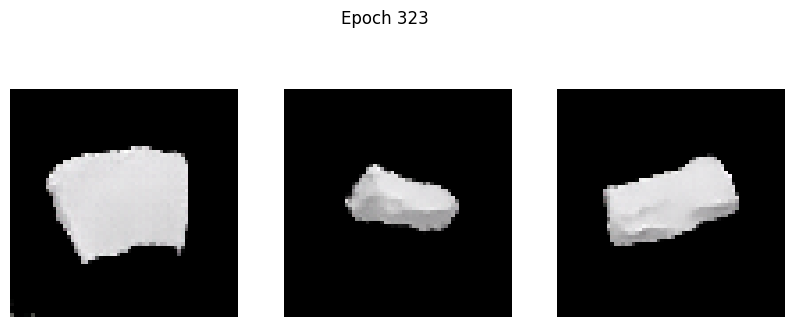

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0336 - g_loss: 4.3863
Epoch 324/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0779 - g_loss: 4.4569

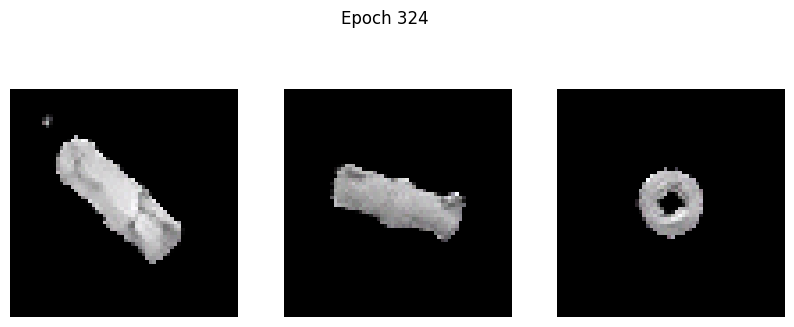

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0779 - g_loss: 4.4564
Epoch 325/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1000 - g_loss: 4.5943

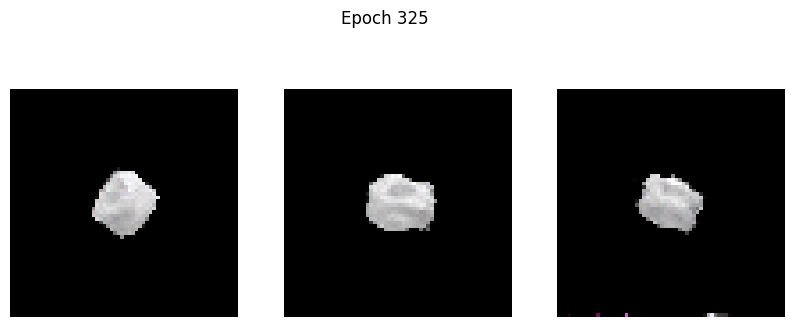

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1000 - g_loss: 4.5940
Epoch 326/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0631 - g_loss: 4.5293

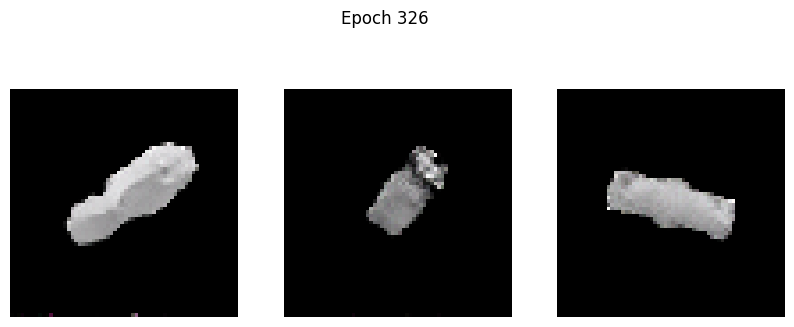

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0635 - g_loss: 4.5304
Epoch 327/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0383 - g_loss: 4.3818

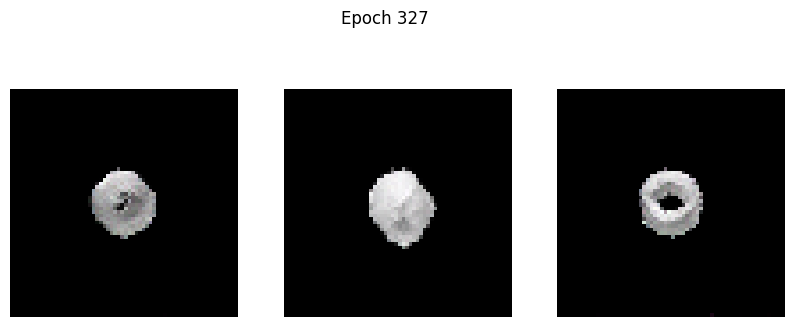

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0384 - g_loss: 4.3826
Epoch 328/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1400 - g_loss: 4.6322

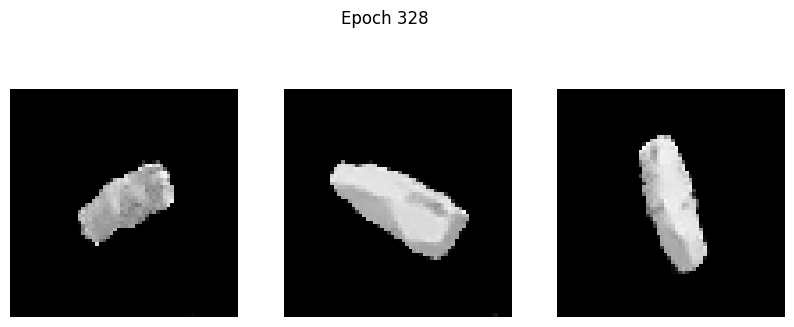

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1405 - g_loss: 4.6335
Epoch 329/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0395 - g_loss: 4.2457

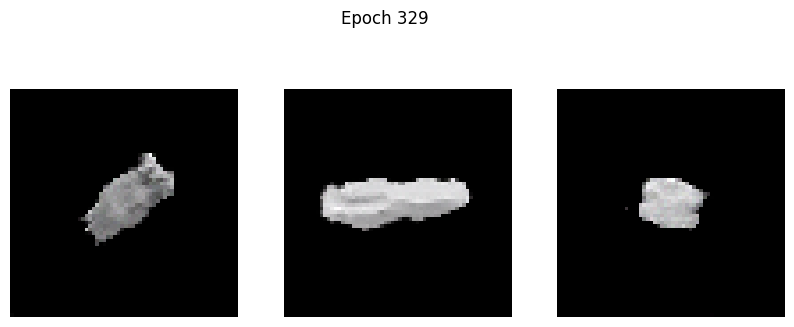

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0394 - g_loss: 4.2465
Epoch 330/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0328 - g_loss: 4.5186

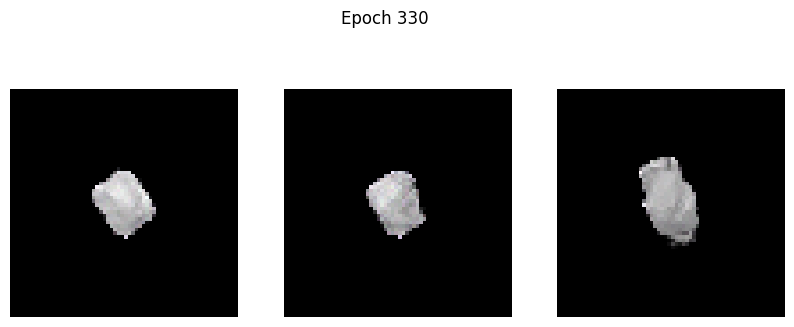

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0327 - g_loss: 4.5175
Epoch 331/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0418 - g_loss: 4.5096

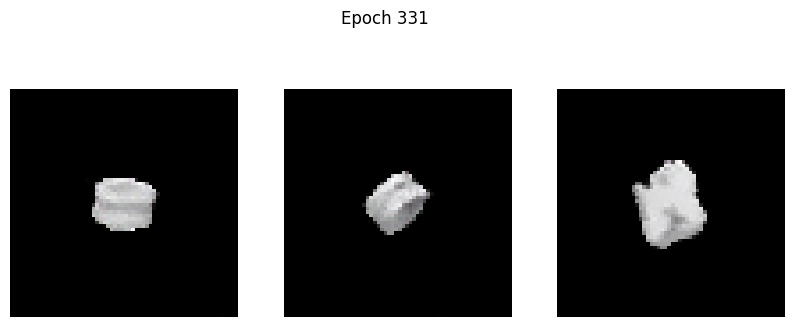

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0418 - g_loss: 4.5090
Epoch 332/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0577 - g_loss: 4.6348

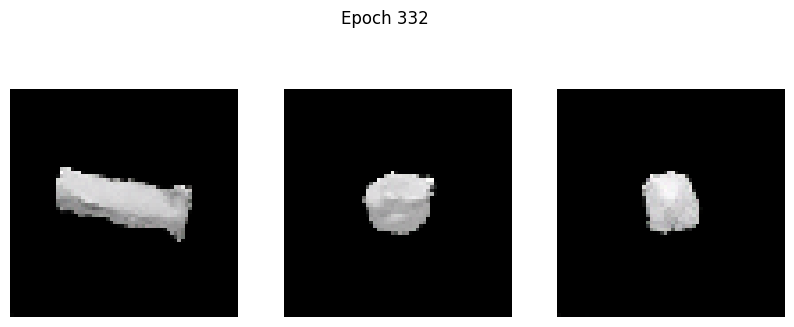

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0578 - g_loss: 4.6347
Epoch 333/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0425 - g_loss: 4.4905

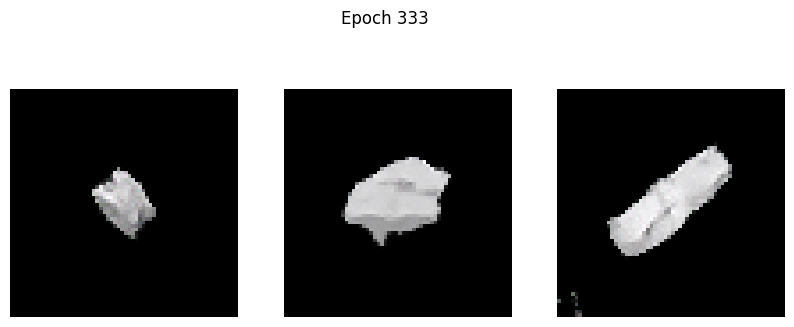

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0426 - g_loss: 4.4909
Epoch 334/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0498 - g_loss: 4.5597

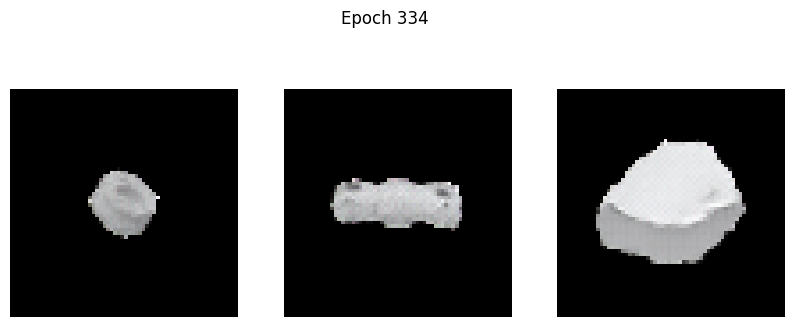

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0506 - g_loss: 4.5633
Epoch 335/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3258 - g_loss: 5.6458

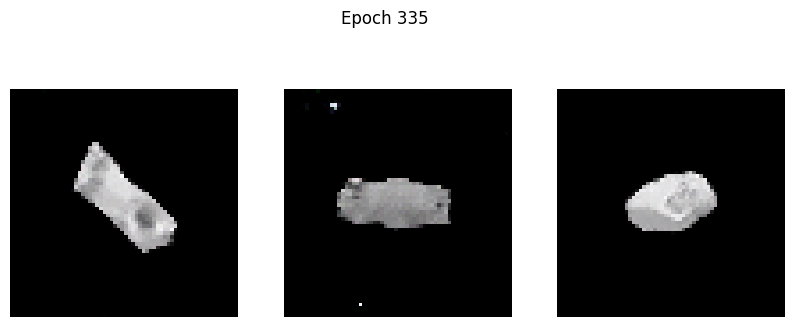

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3238 - g_loss: 5.6366
Epoch 336/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0499 - g_loss: 4.4917

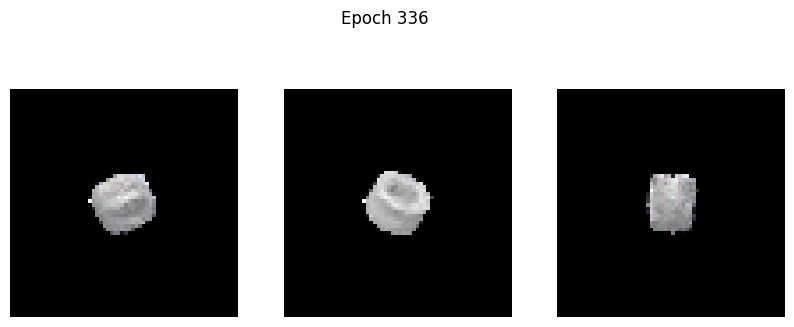

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0499 - g_loss: 4.4921
Epoch 337/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0240 - g_loss: 4.6013

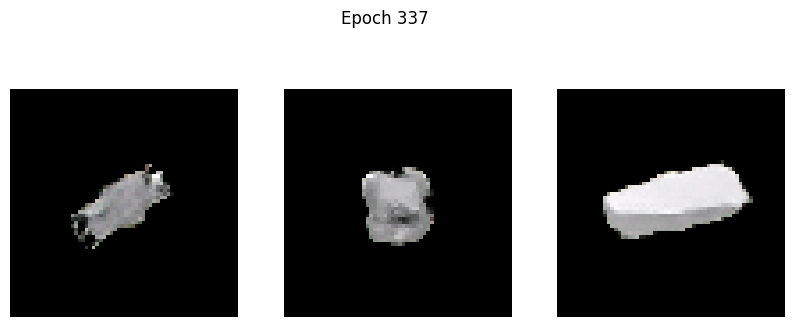

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - d_loss: 0.0244 - g_loss: 4.6021
Epoch 338/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1444 - g_loss: 4.7237

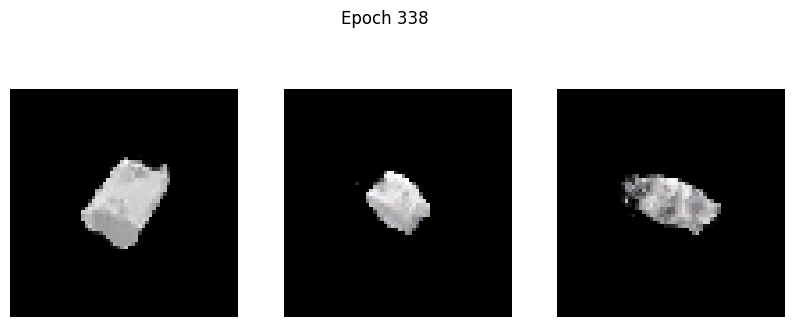

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1437 - g_loss: 4.7214
Epoch 339/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0275 - g_loss: 4.5243

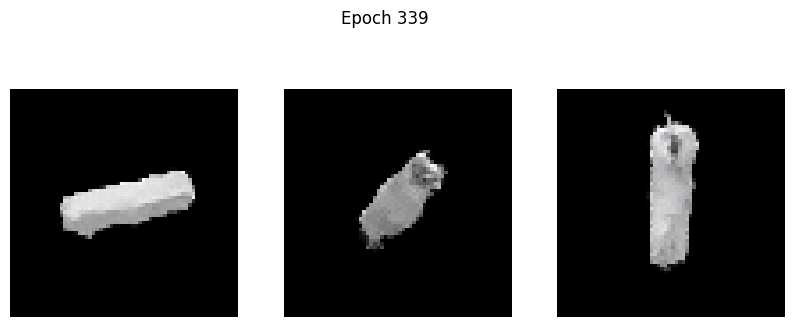

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0275 - g_loss: 4.5233
Epoch 340/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0501 - g_loss: 4.6657

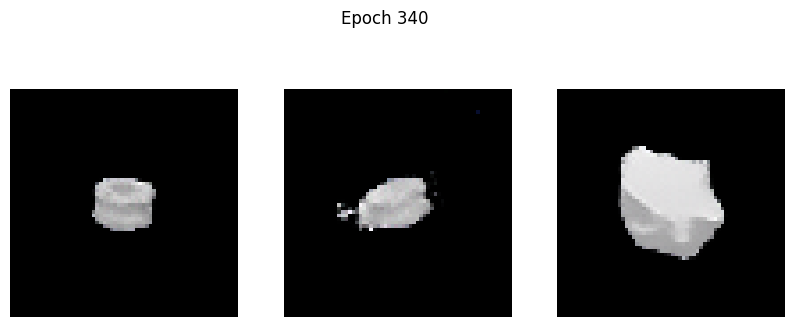

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0503 - g_loss: 4.6669
Epoch 341/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0711 - g_loss: 4.5672

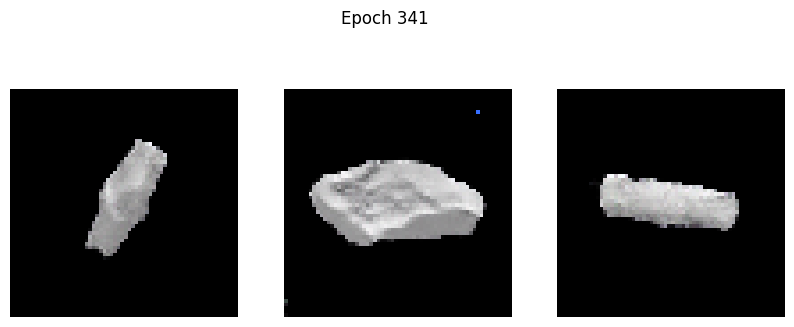

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0714 - g_loss: 4.5692
Epoch 342/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0530 - g_loss: 4.6840

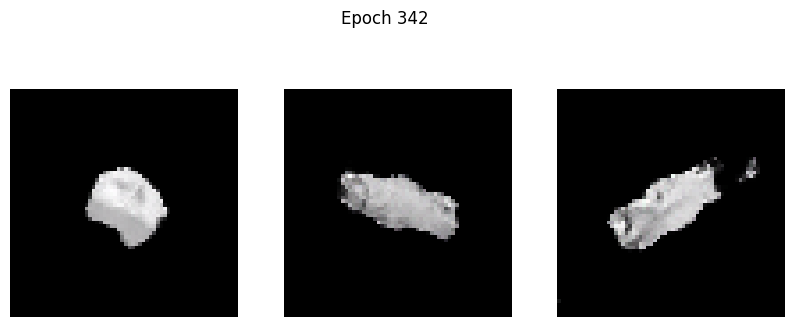

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0531 - g_loss: 4.6842
Epoch 343/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0350 - g_loss: 4.6254

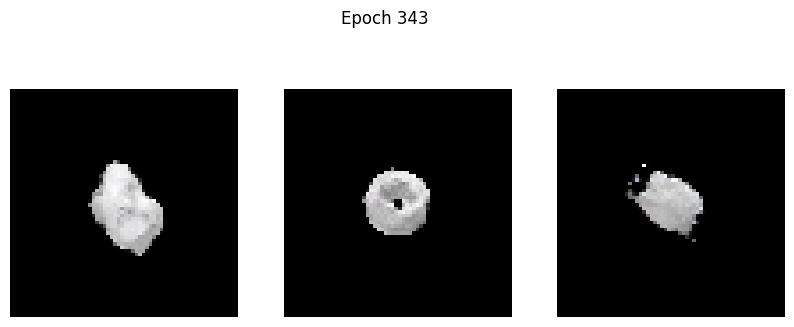

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0348 - g_loss: 4.6244
Epoch 344/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0549 - g_loss: 4.7177

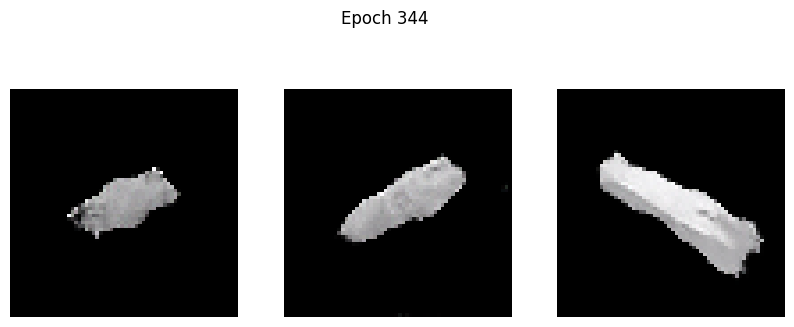

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0548 - g_loss: 4.7169
Epoch 345/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0266 - g_loss: 4.5847

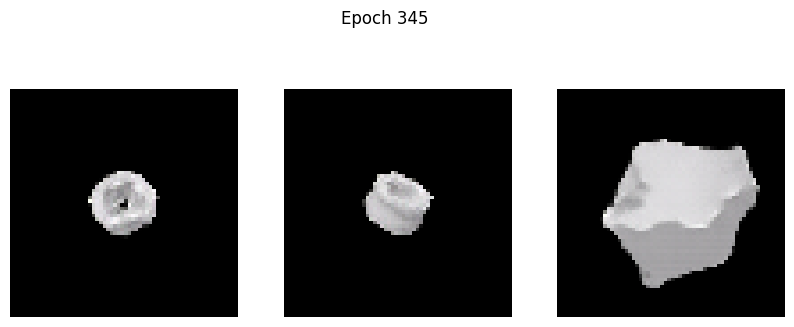

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0267 - g_loss: 4.5852
Epoch 346/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0947 - g_loss: 4.8798

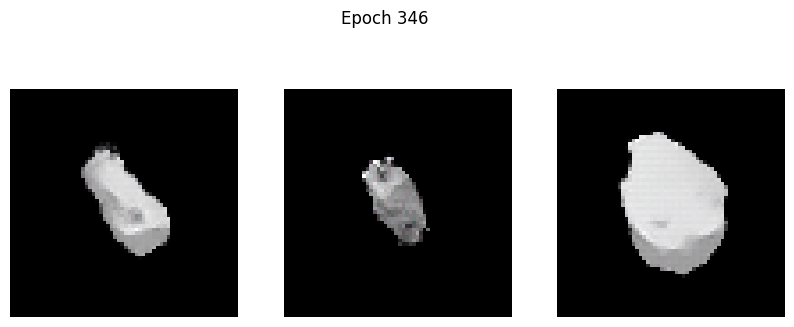

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0950 - g_loss: 4.8796
Epoch 347/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0521 - g_loss: 4.7430

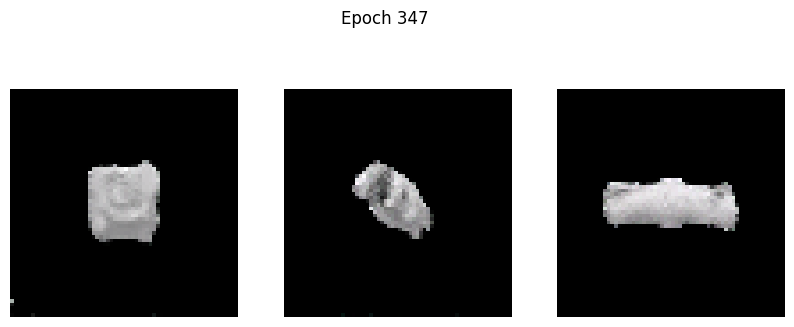

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0522 - g_loss: 4.7430
Epoch 348/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0722 - g_loss: 4.7512

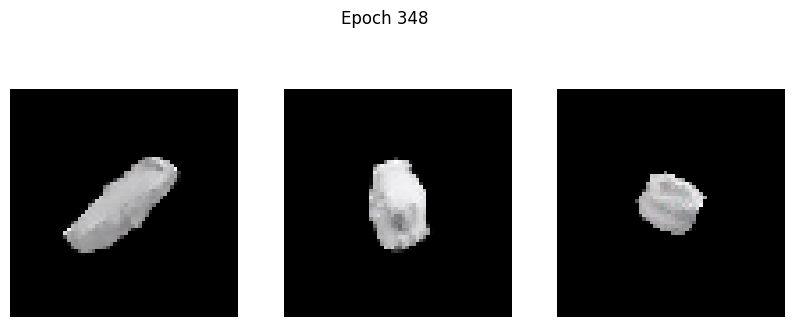

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0720 - g_loss: 4.7499
Epoch 349/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0745 - g_loss: 4.9493

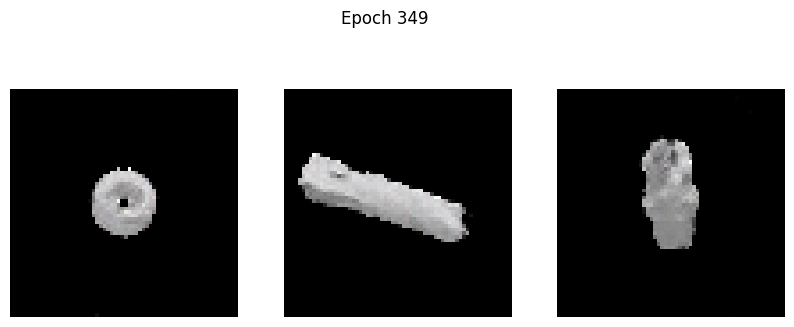

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0745 - g_loss: 4.9467
Epoch 350/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0310 - g_loss: 4.6844

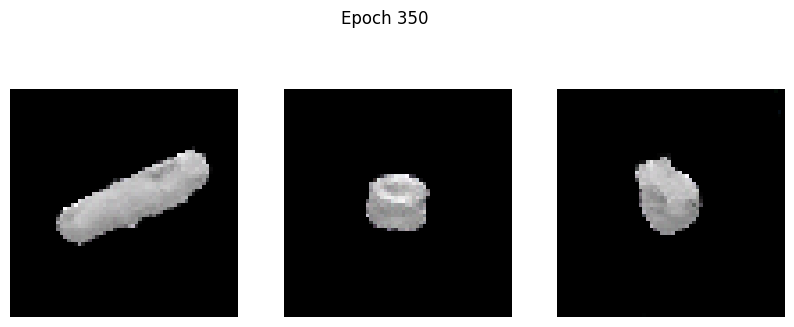

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0312 - g_loss: 4.6846
Epoch 351/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0460 - g_loss: 4.6664

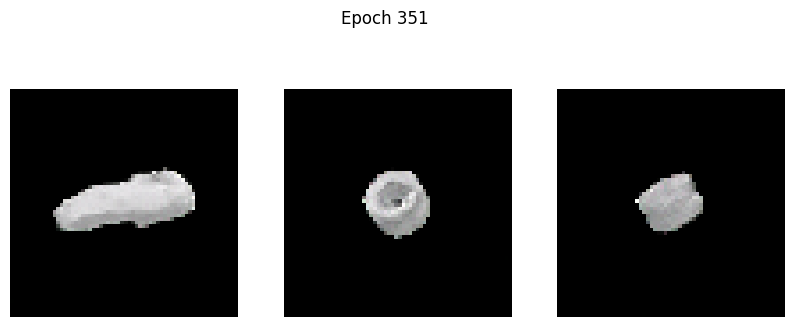

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0461 - g_loss: 4.6672
Epoch 352/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0752 - g_loss: 4.8835

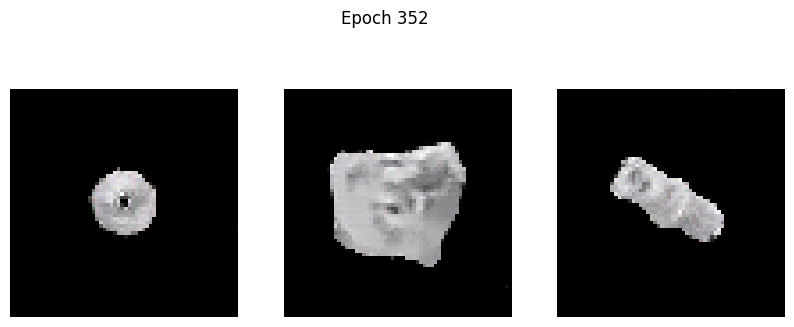

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0753 - g_loss: 4.8841
Epoch 353/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0805 - g_loss: 4.7863

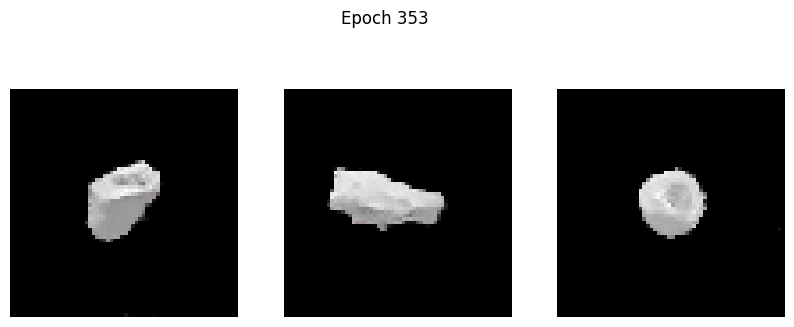

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0806 - g_loss: 4.7859
Epoch 354/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0526 - g_loss: 4.6797

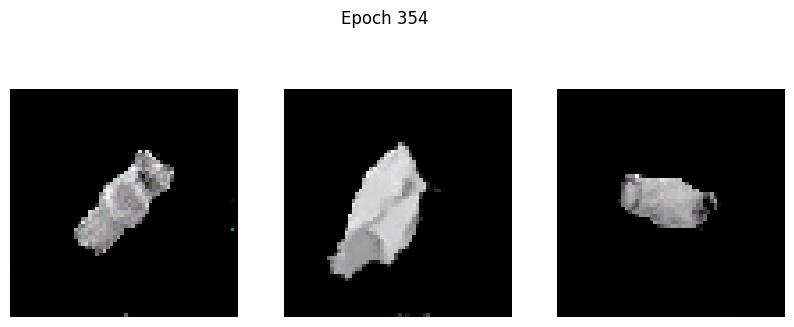

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0524 - g_loss: 4.6785
Epoch 355/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0799 - g_loss: 4.9120

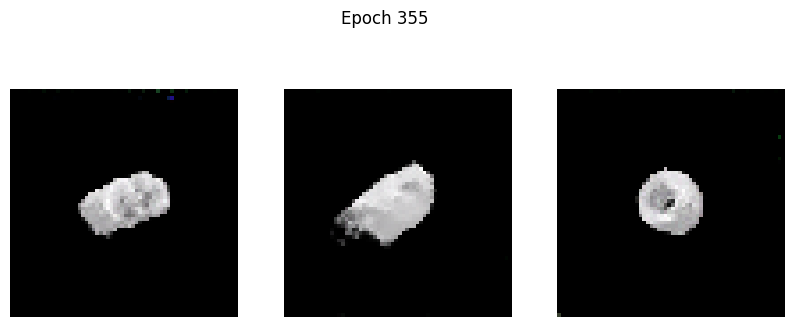

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0797 - g_loss: 4.9108
Epoch 356/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0144 - g_loss: 4.5774

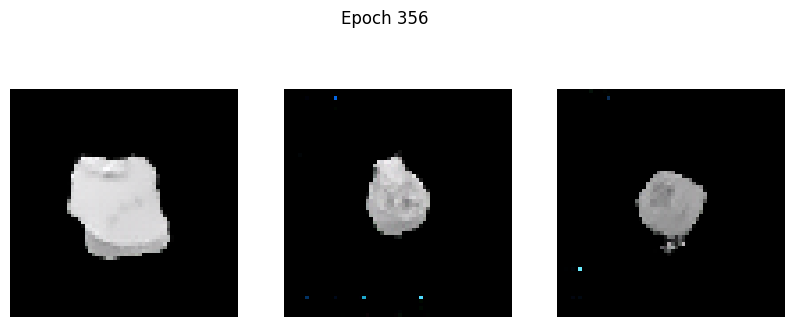

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0146 - g_loss: 4.5783
Epoch 357/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1145 - g_loss: 5.0249

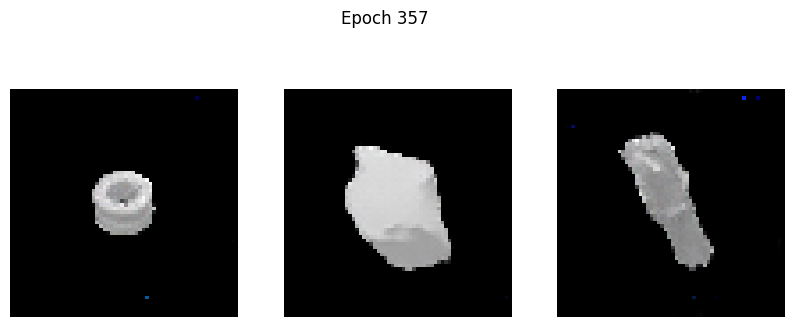

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1146 - g_loss: 5.0244
Epoch 358/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0501 - g_loss: 4.4953

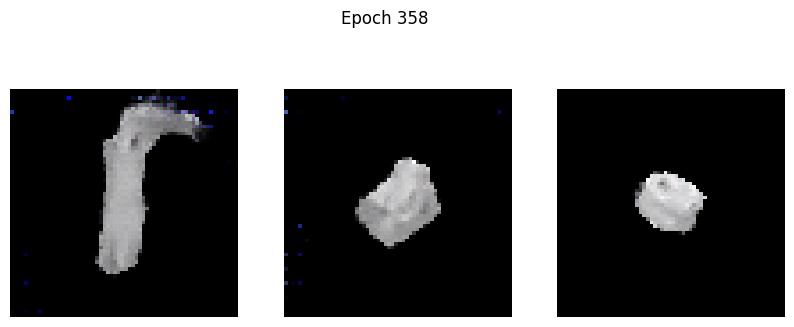

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0500 - g_loss: 4.4960
Epoch 359/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0807 - g_loss: 4.7743

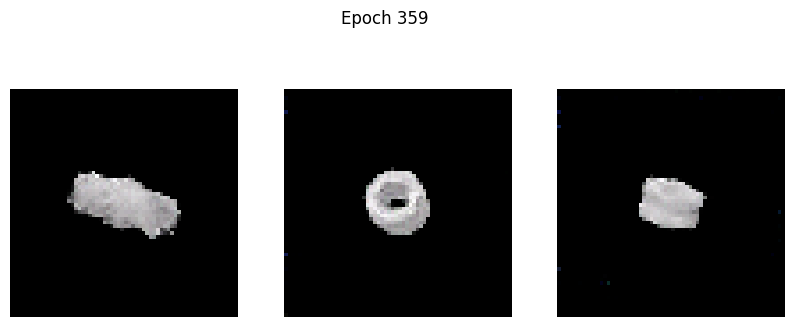

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0807 - g_loss: 4.7743
Epoch 360/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0581 - g_loss: 4.9933

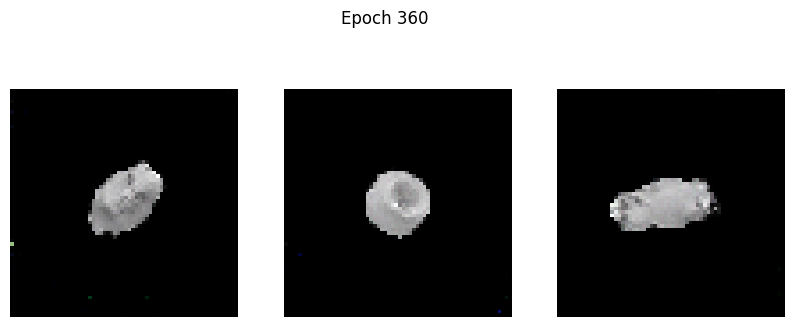

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0580 - g_loss: 4.9914
Epoch 361/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0216 - g_loss: 4.5588

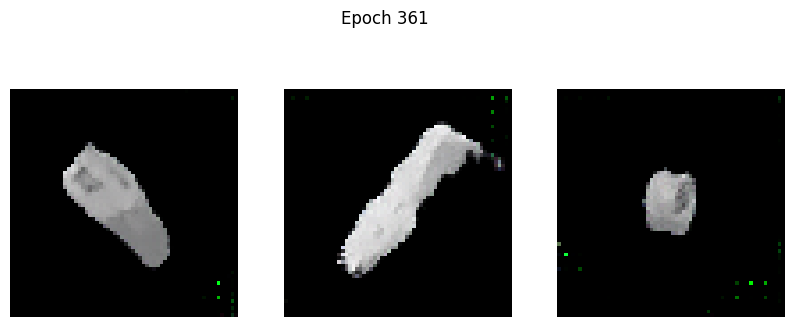

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0220 - g_loss: 4.5603
Epoch 362/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0715 - g_loss: 4.9061

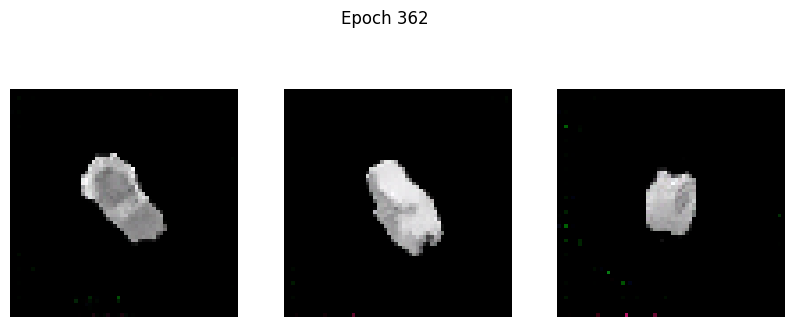

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0713 - g_loss: 4.9053
Epoch 363/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1030 - g_loss: 5.2167

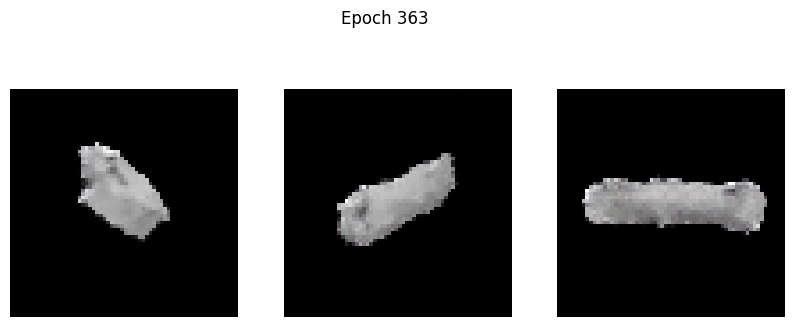

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1039 - g_loss: 5.2210
Epoch 364/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0081 - g_loss: 5.4564

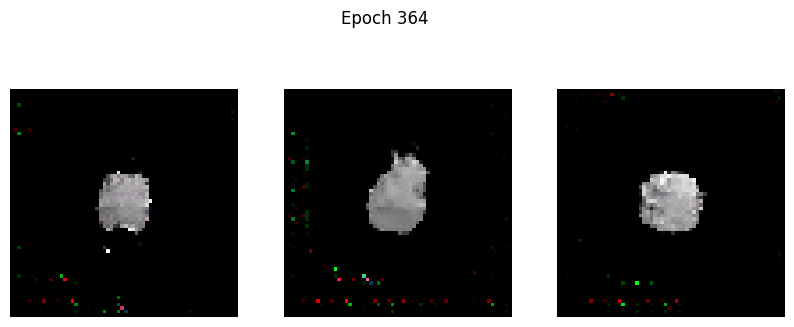

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0082 - g_loss: 5.4547
Epoch 365/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0299 - g_loss: 5.0403

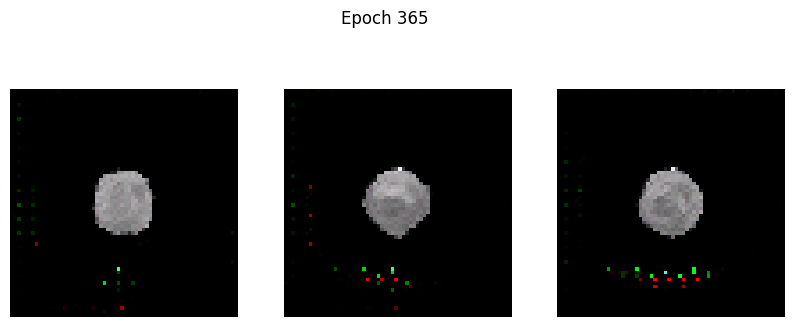

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0298 - g_loss: 5.0399
Epoch 366/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0042 - g_loss: 5.2477

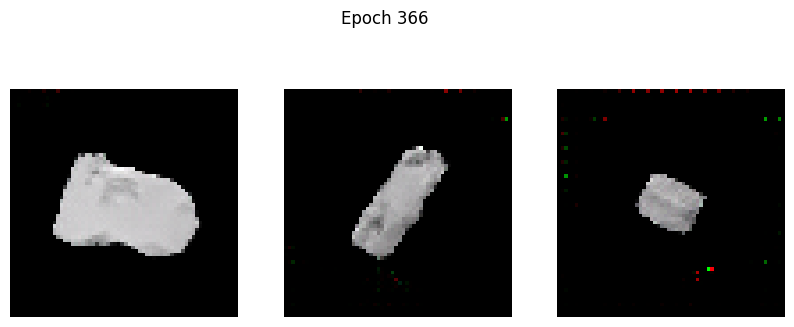

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0041 - g_loss: 5.2468
Epoch 367/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2710 - g_loss: 6.6182

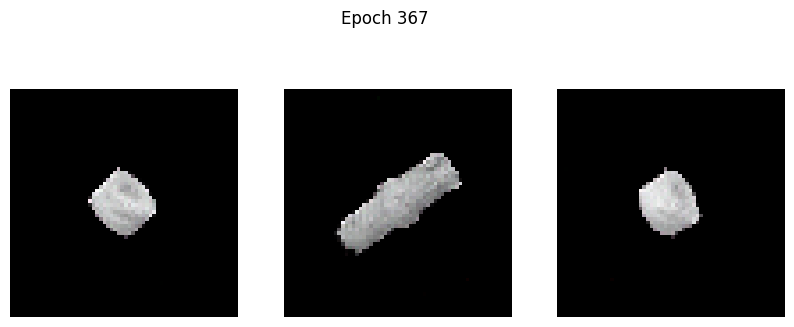

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2696 - g_loss: 6.6110
Epoch 368/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0555 - g_loss: 5.1745

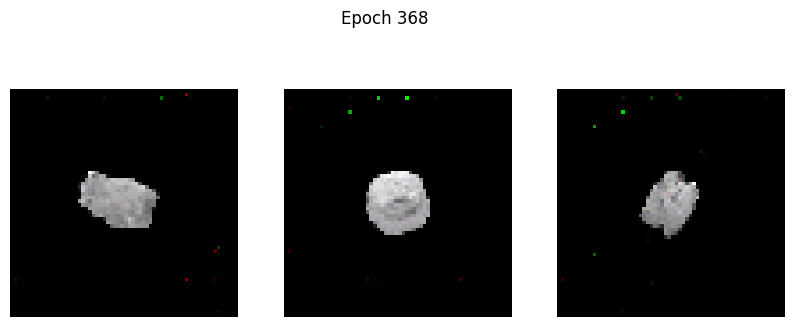

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0551 - g_loss: 5.1711
Epoch 369/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0873 - g_loss: 5.0208

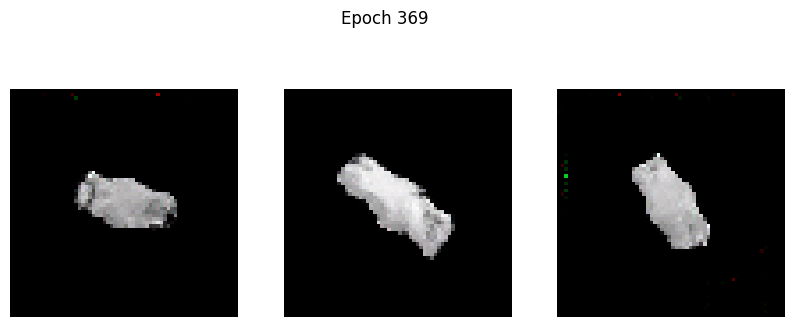

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0872 - g_loss: 5.0201
Epoch 370/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0029 - g_loss: 4.6385

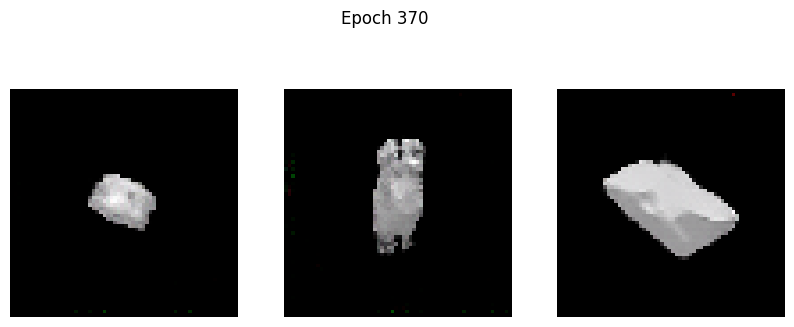

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0027 - g_loss: 4.6398
Epoch 371/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0453 - g_loss: 5.1182

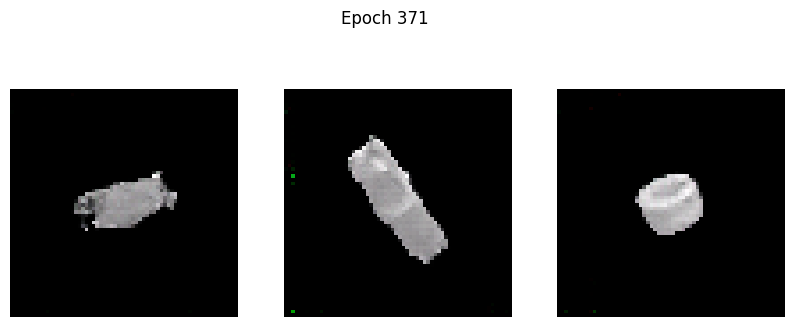

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0455 - g_loss: 5.1185
Epoch 372/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0850 - g_loss: 5.0760

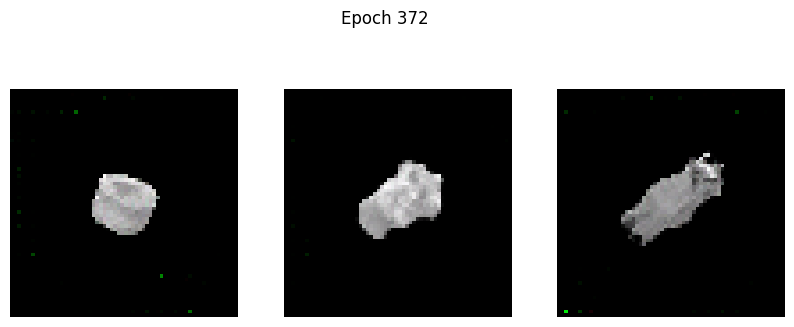

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0849 - g_loss: 5.0762
Epoch 373/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0203 - g_loss: 4.7743

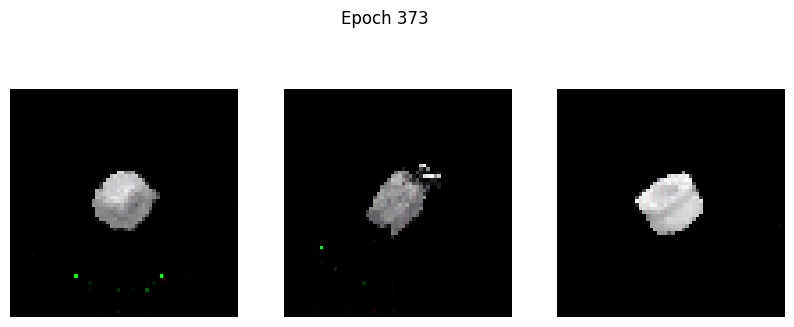

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0205 - g_loss: 4.7756
Epoch 374/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0407 - g_loss: 4.9465

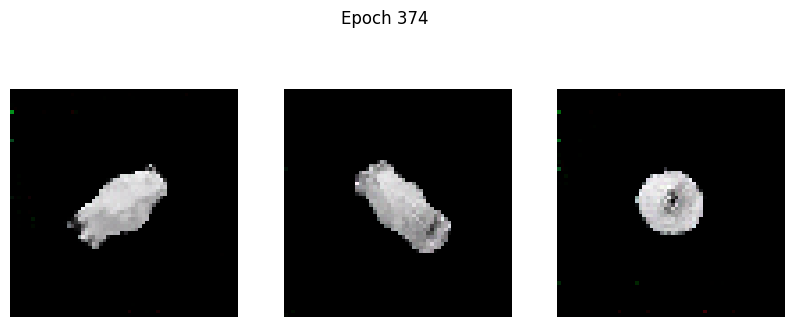

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0407 - g_loss: 4.9465
Epoch 375/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0402 - g_loss: 4.8294

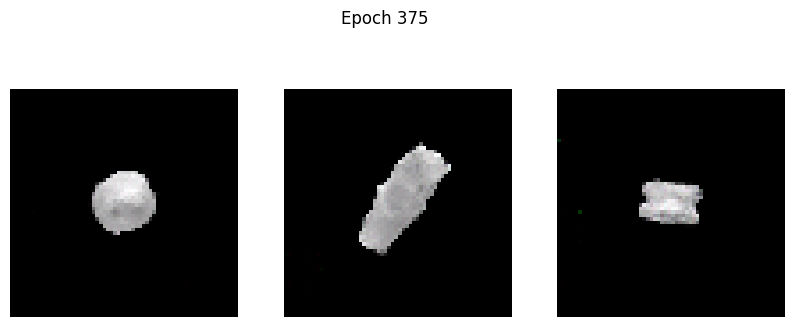

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0401 - g_loss: 4.8300
Epoch 376/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1395 - g_loss: 5.3113

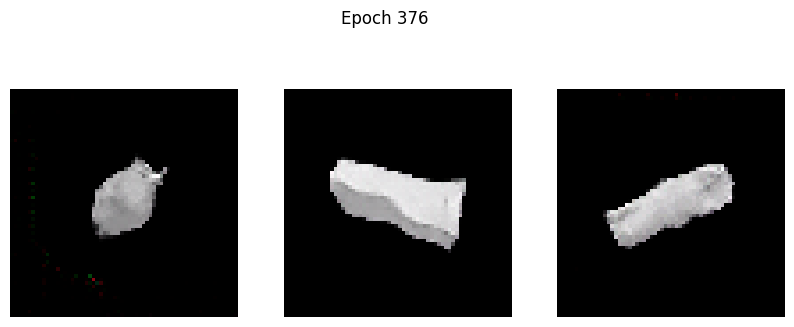

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1393 - g_loss: 5.3098
Epoch 377/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0394 - g_loss: 4.8451

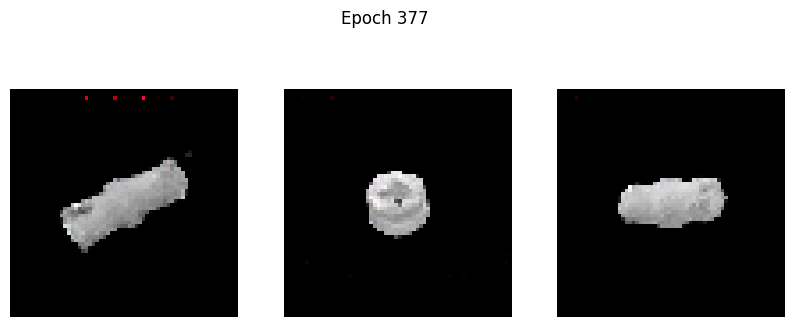

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0394 - g_loss: 4.8454
Epoch 378/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0122 - g_loss: 5.0104

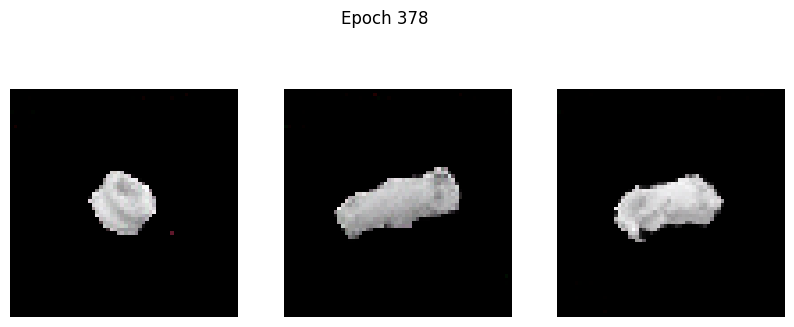

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0125 - g_loss: 5.0098
Epoch 379/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0077 - g_loss: 4.7365

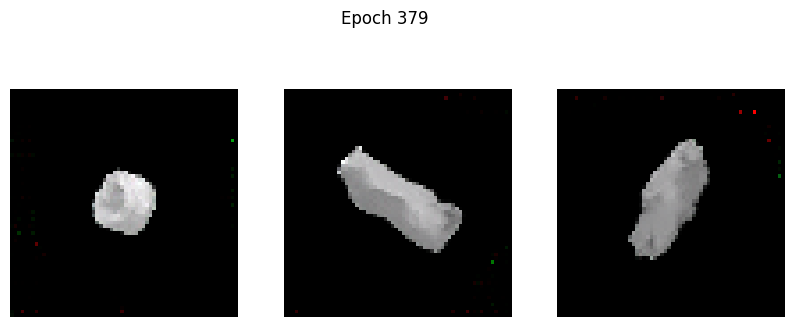

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0079 - g_loss: 4.7373
Epoch 380/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0541 - g_loss: 5.1647

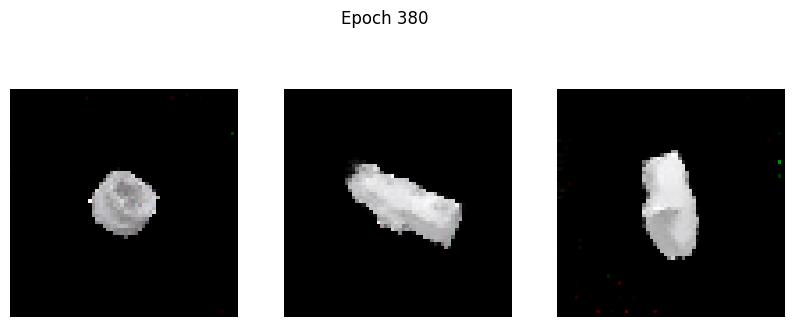

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0544 - g_loss: 5.1652
Epoch 381/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0929 - g_loss: 5.3348

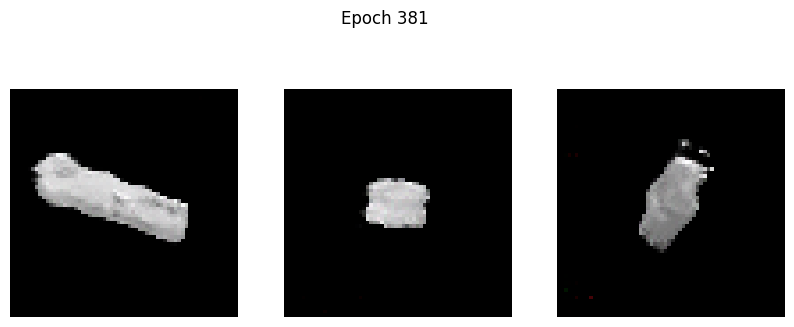

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0926 - g_loss: 5.3315
Epoch 382/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0089 - g_loss: 4.9008

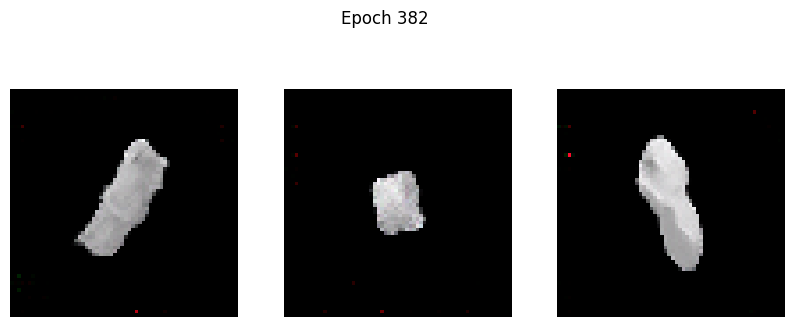

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0093 - g_loss: 4.9034
Epoch 383/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0308 - g_loss: 4.9899

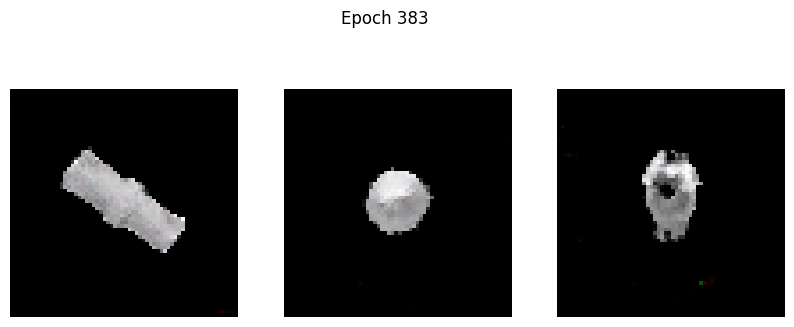

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0304 - g_loss: 4.9885
Epoch 384/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0548 - g_loss: 4.9434

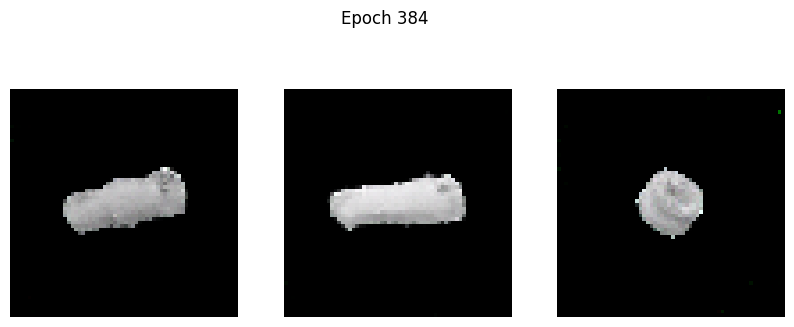

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0548 - g_loss: 4.9446
Epoch 385/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0233 - g_loss: 4.9032

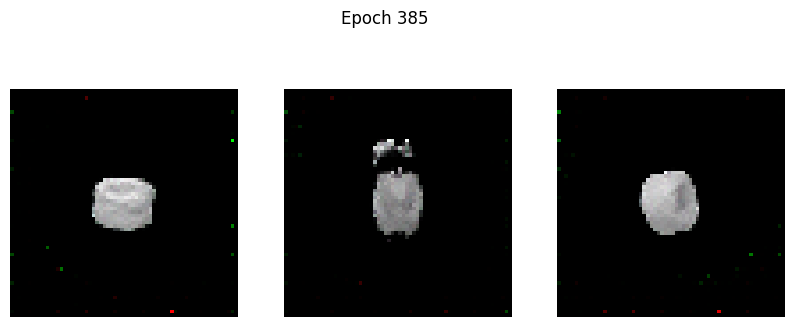

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0233 - g_loss: 4.9032
Epoch 386/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0787 - g_loss: 5.0846

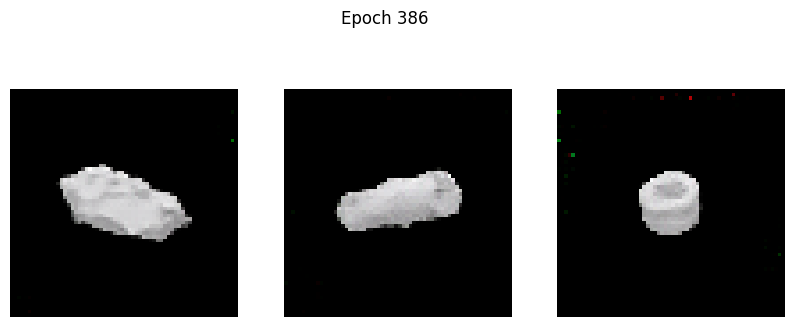

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0784 - g_loss: 5.0837
Epoch 387/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0517 - g_loss: 4.9653

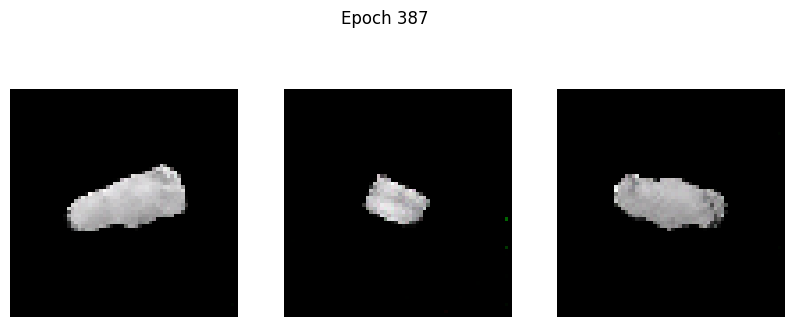

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0515 - g_loss: 4.9654
Epoch 388/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0769 - g_loss: 5.2593

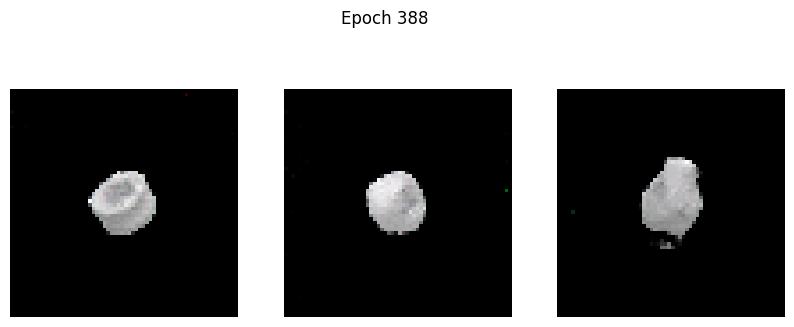

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0768 - g_loss: 5.2570
Epoch 389/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0380 - g_loss: 4.9477

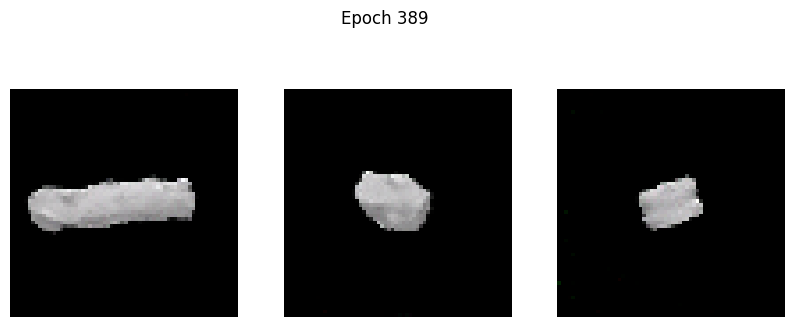

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0379 - g_loss: 4.9474
Epoch 390/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0336 - g_loss: 4.9497

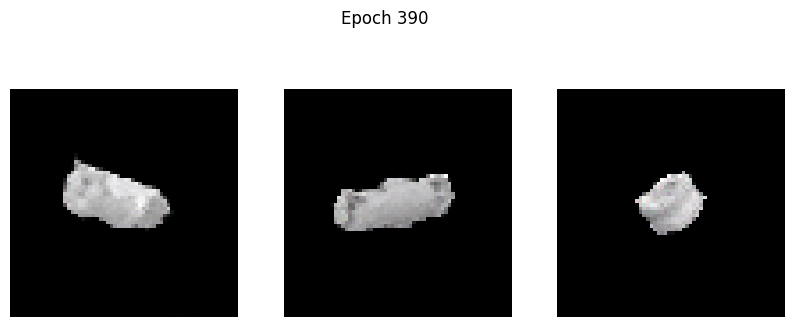

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0338 - g_loss: 4.9501
Epoch 391/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0576 - g_loss: 5.0721

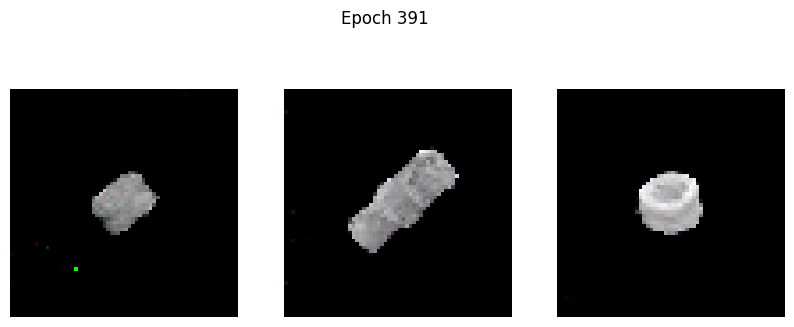

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0577 - g_loss: 5.0740
Epoch 392/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0330 - g_loss: 4.8937

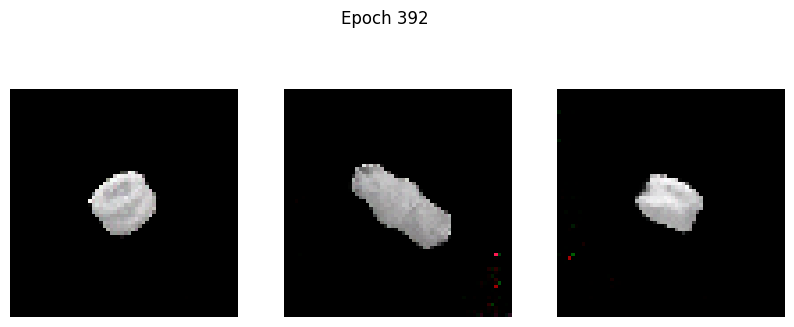

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0335 - g_loss: 4.8973
Epoch 393/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0194 - g_loss: 5.0649

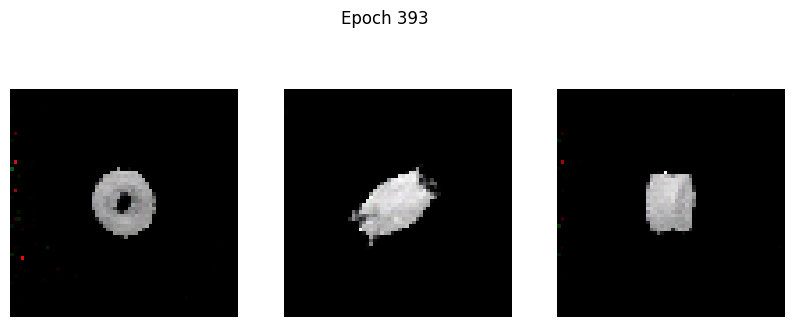

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0193 - g_loss: 5.0635
Epoch 394/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0434 - g_loss: 4.9954

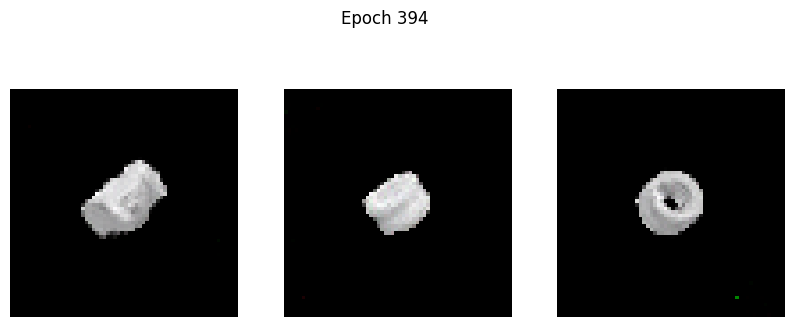

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0433 - g_loss: 4.9965
Epoch 395/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0288 - g_loss: 4.9897

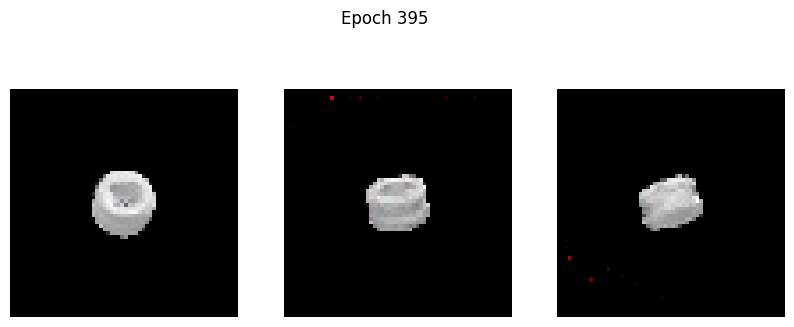

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0288 - g_loss: 4.9894
Epoch 396/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2801 - g_loss: 5.6508

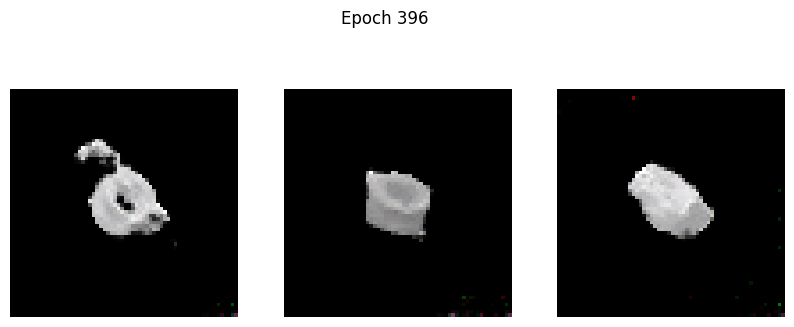

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2801 - g_loss: 5.6480
Epoch 397/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0077 - g_loss: 4.5386

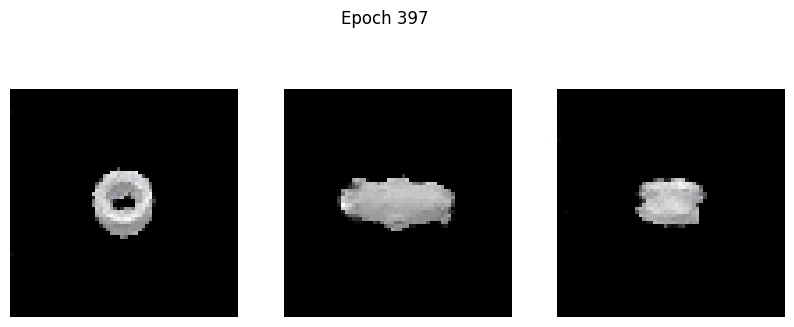

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0077 - g_loss: 4.5397
Epoch 398/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0115 - g_loss: 4.6828

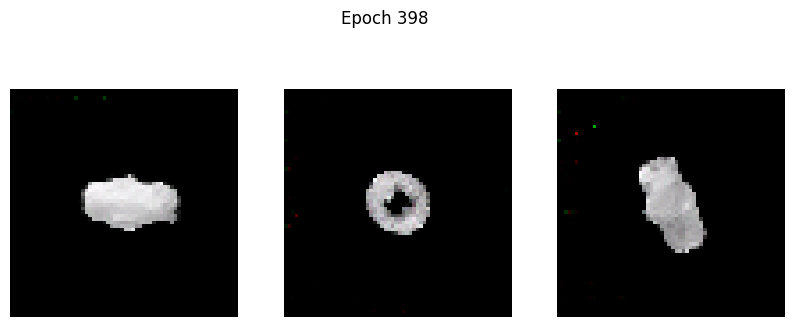

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - d_loss: -0.0114 - g_loss: 4.6842
Epoch 399/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: -0.0060 - g_loss: 4.8428

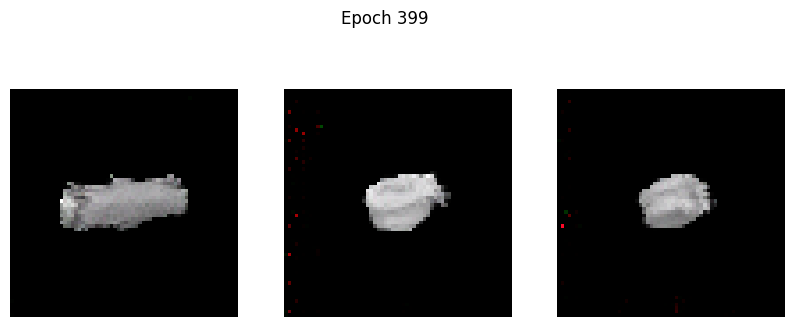

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0058 - g_loss: 4.8439
Epoch 400/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: 0.0634 - g_loss: 5.3585

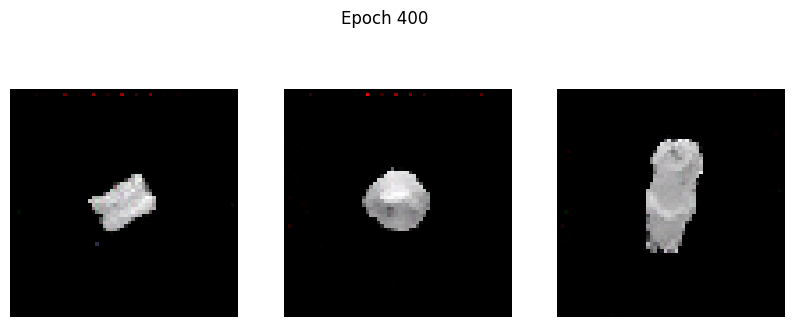

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.0632 - g_loss: 5.3567
Epoch 401/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0069 - g_loss: 4.8744

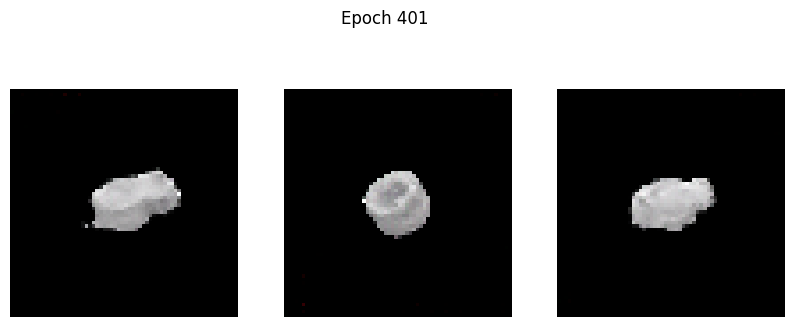

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0067 - g_loss: 4.8750
Epoch 402/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0196 - g_loss: 5.1590

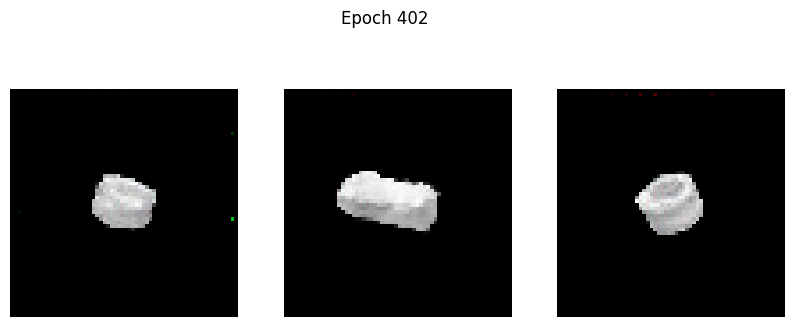

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0197 - g_loss: 5.1585
Epoch 403/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0217 - g_loss: 5.0147

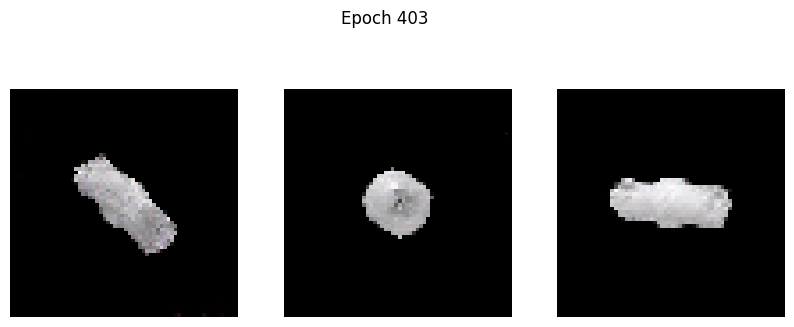

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0217 - g_loss: 5.0147
Epoch 404/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2167 - g_loss: 6.1312

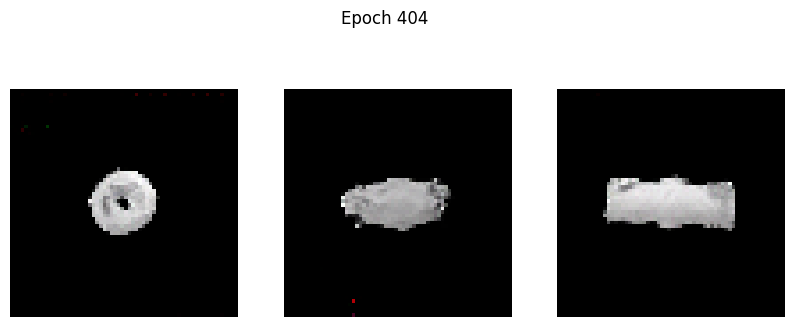

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2166 - g_loss: 6.1292
Epoch 405/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0386 - g_loss: 4.7534

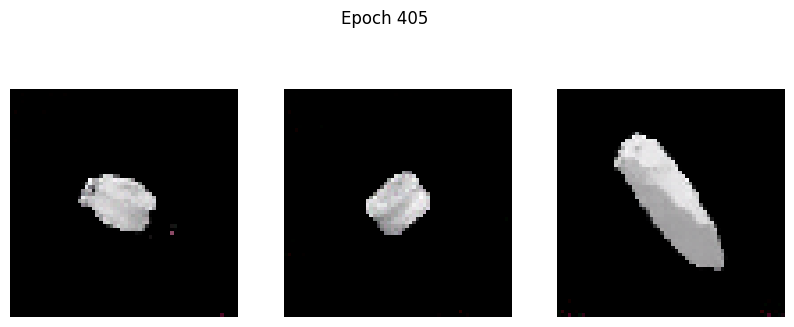

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0385 - g_loss: 4.7536
Epoch 406/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0266 - g_loss: 5.4804

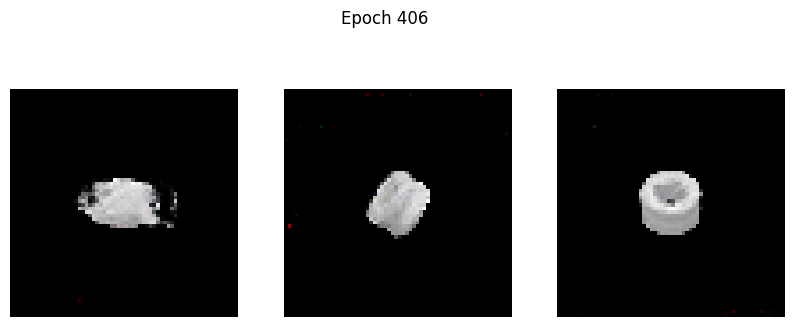

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0263 - g_loss: 5.4757
Epoch 407/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0257 - g_loss: 5.1771

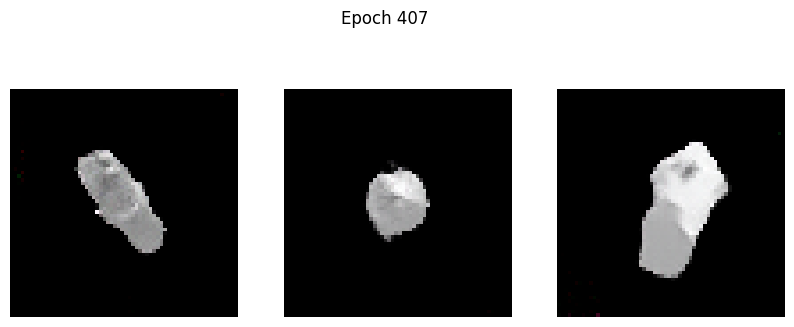

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0259 - g_loss: 5.1775
Epoch 408/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0130 - g_loss: 5.1661

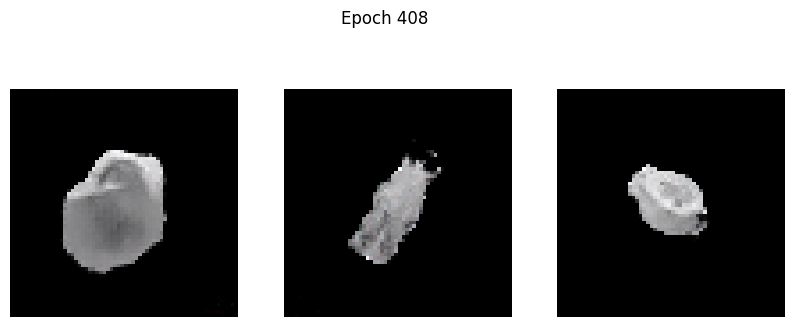

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0135 - g_loss: 5.1680
Epoch 409/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0107 - g_loss: 5.0718

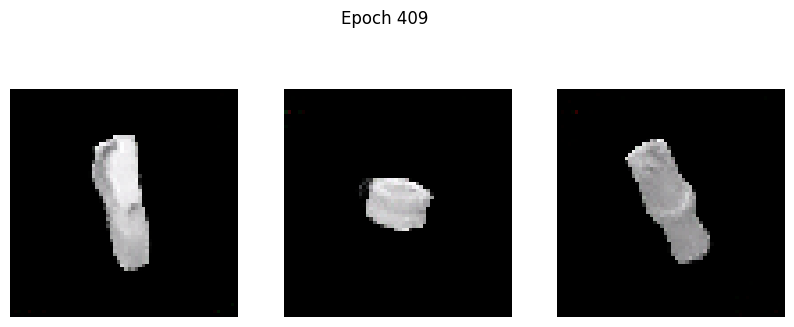

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0107 - g_loss: 5.0707
Epoch 410/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0089 - g_loss: 5.1387

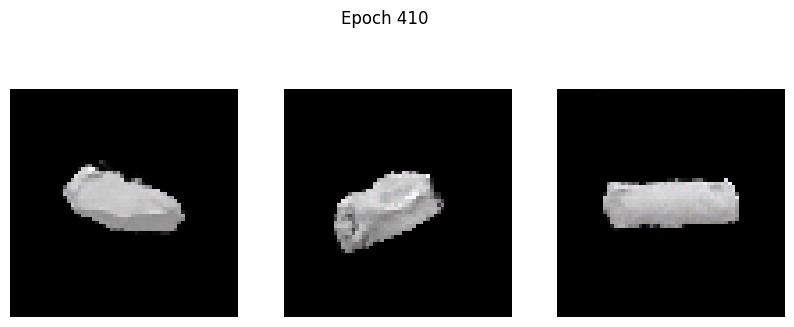

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0089 - g_loss: 5.1384
Epoch 411/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0131 - g_loss: 5.3768

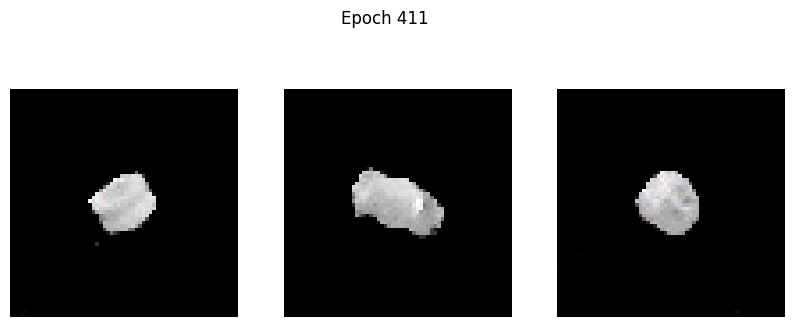

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0132 - g_loss: 5.3758
Epoch 412/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0330 - g_loss: 5.1070

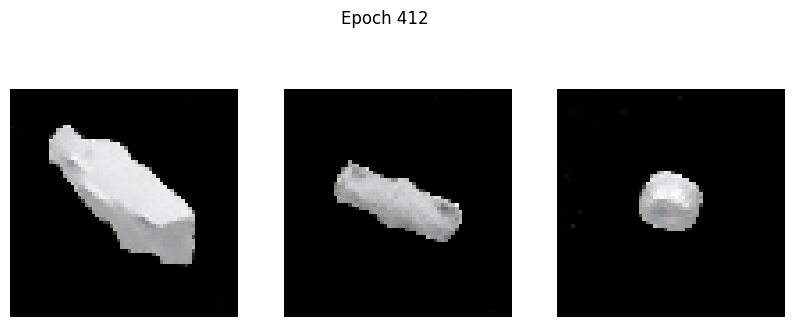

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0325 - g_loss: 5.1100
Epoch 413/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0570 - g_loss: 5.4974

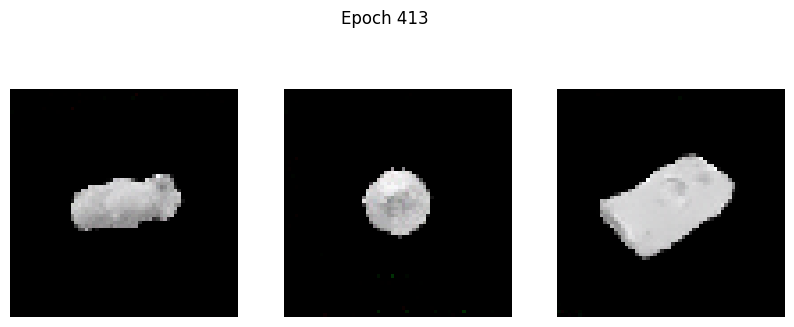

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0568 - g_loss: 5.4965
Epoch 414/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0115 - g_loss: 5.1021

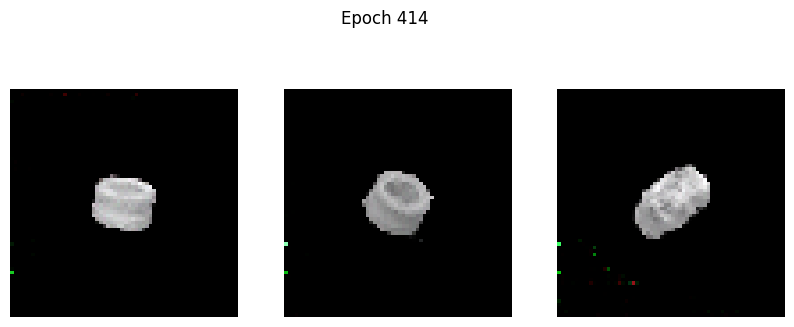

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0117 - g_loss: 5.1010
Epoch 415/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0405 - g_loss: 5.5275

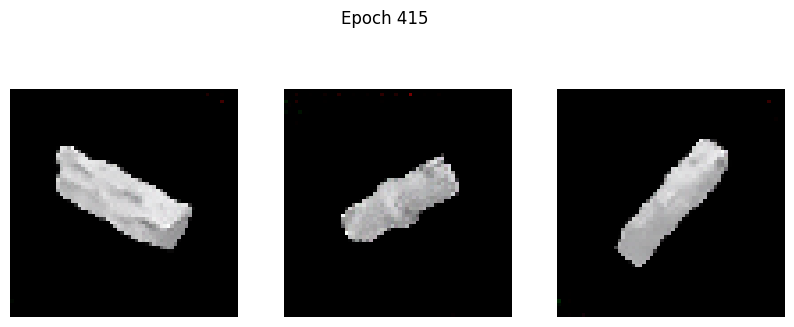

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0407 - g_loss: 5.5282
Epoch 416/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0602 - g_loss: 5.7507

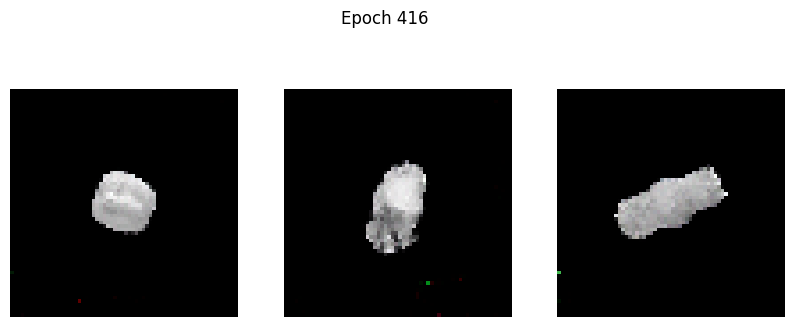

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0600 - g_loss: 5.7486
Epoch 417/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0315 - g_loss: 4.9491

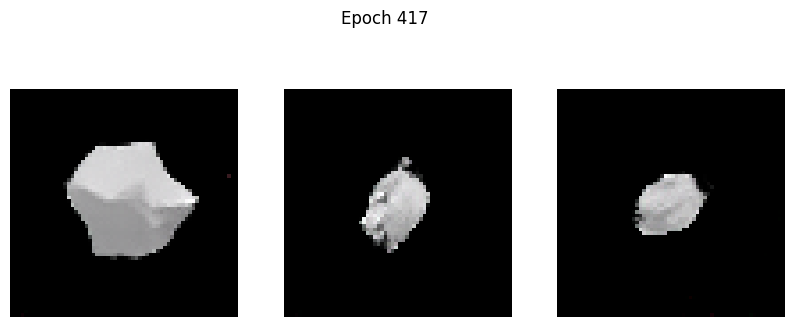

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - d_loss: -0.0310 - g_loss: 4.9534
Epoch 418/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0188 - g_loss: 5.2068

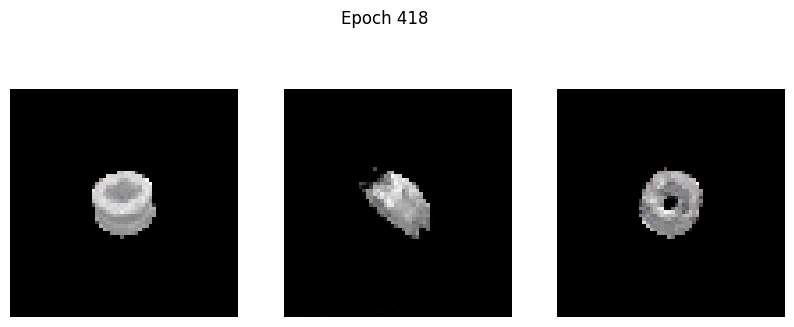

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0188 - g_loss: 5.2078
Epoch 419/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: 0.0297 - g_loss: 5.3471

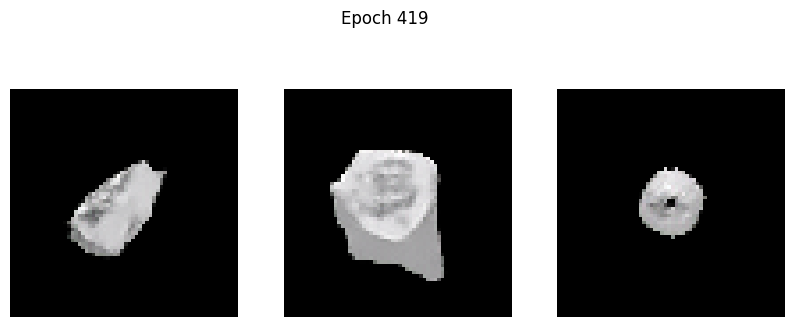

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.0299 - g_loss: 5.3481
Epoch 420/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0466 - g_loss: 4.9517

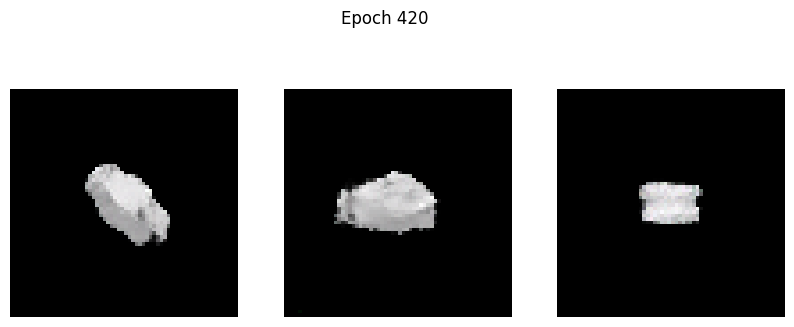

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0463 - g_loss: 4.9542
Epoch 421/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0131 - g_loss: 5.3136

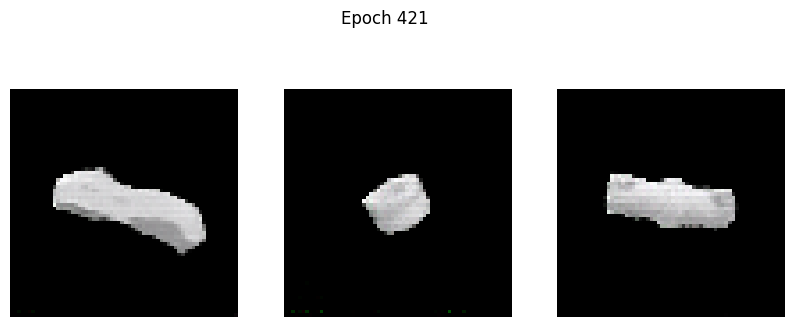

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0127 - g_loss: 5.3153
Epoch 422/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0059 - g_loss: 5.5023

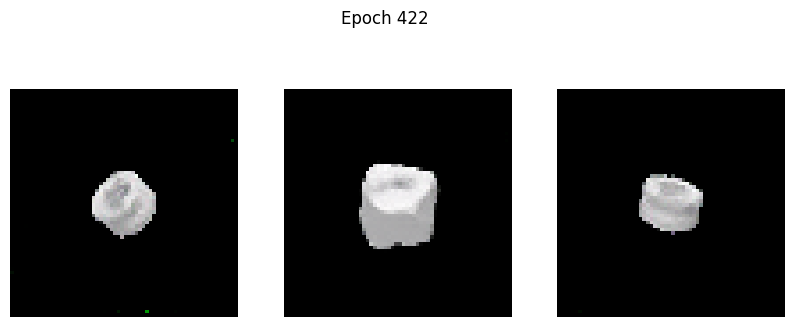

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0058 - g_loss: 5.5022
Epoch 423/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0016 - g_loss: 5.4466

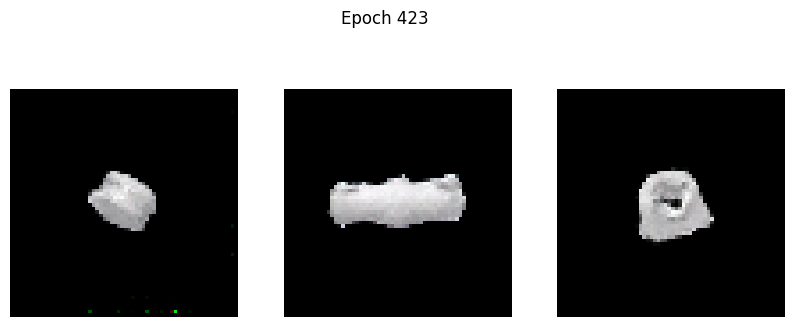

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0015 - g_loss: 5.4441
Epoch 424/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0383 - g_loss: 5.5704

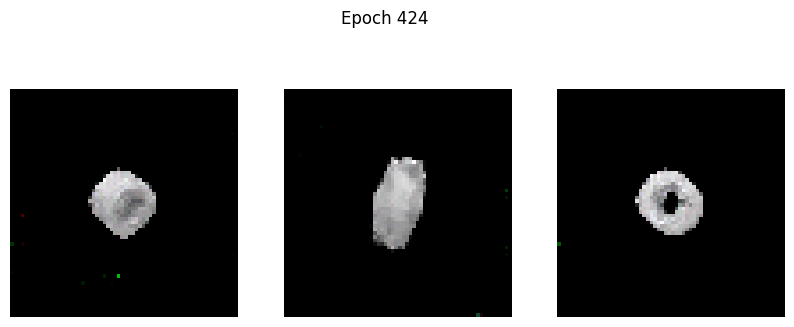

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0381 - g_loss: 5.5692
Epoch 425/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0111 - g_loss: 5.2781

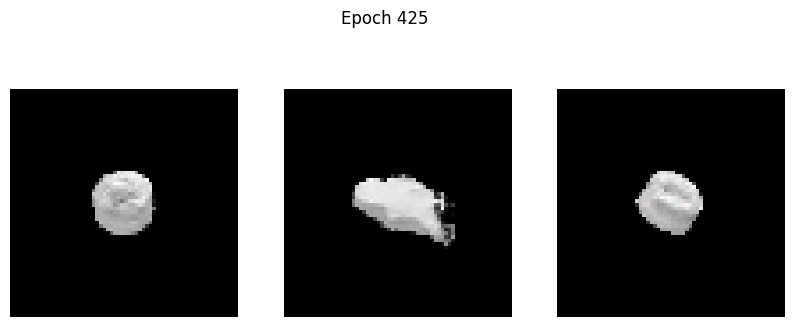

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0106 - g_loss: 5.2808
Epoch 426/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0652 - g_loss: 5.9726

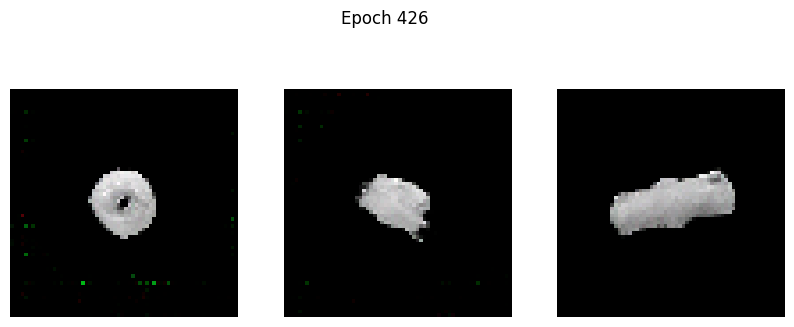

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0646 - g_loss: 5.9674
Epoch 427/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0265 - g_loss: 5.5686

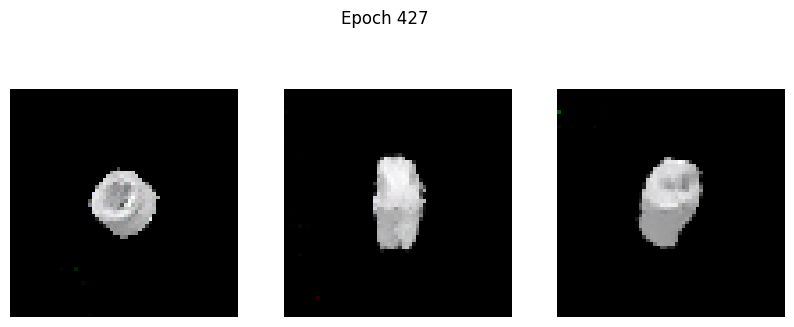

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0262 - g_loss: 5.5664
Epoch 428/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1843 - g_loss: 6.6419

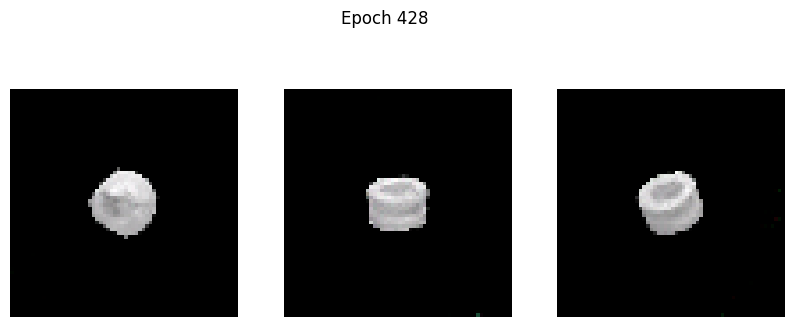

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1829 - g_loss: 6.6323
Epoch 429/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0402 - g_loss: 5.0874

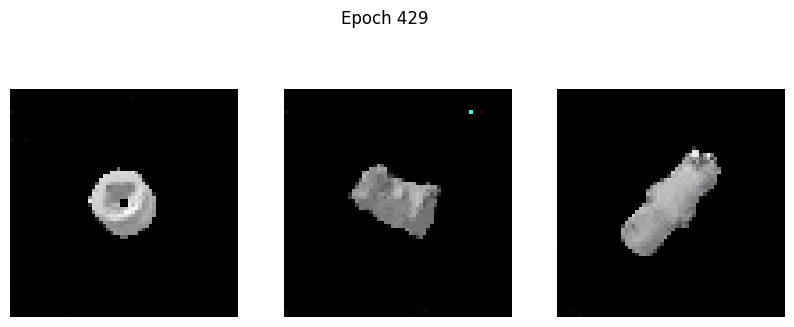

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0401 - g_loss: 5.0888
Epoch 430/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0102 - g_loss: 5.8375

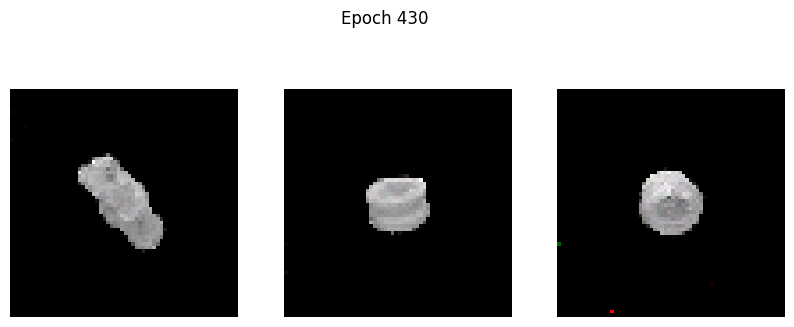

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0101 - g_loss: 5.8351
Epoch 431/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0213 - g_loss: 5.3227

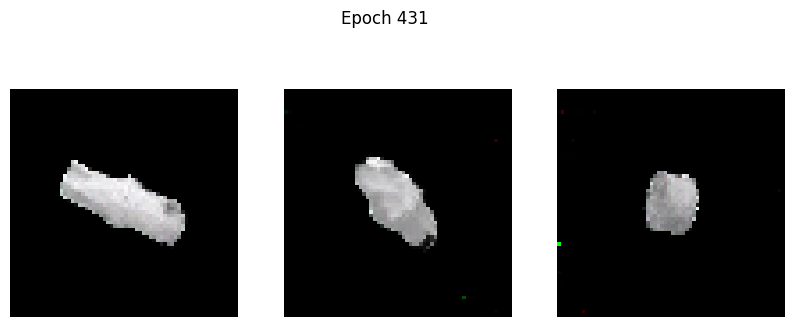

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0213 - g_loss: 5.3225
Epoch 432/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0194 - g_loss: 5.8835

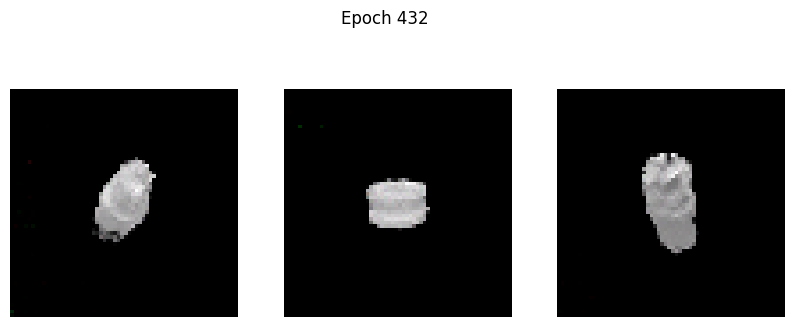

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0194 - g_loss: 5.8836
Epoch 433/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0062 - g_loss: 5.4792

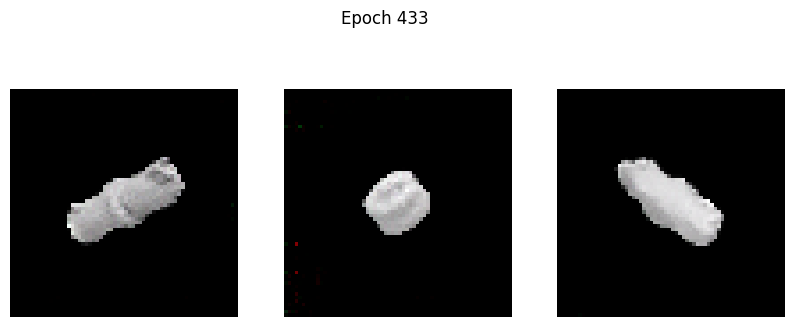

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0061 - g_loss: 5.4792
Epoch 434/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0392 - g_loss: 5.4482

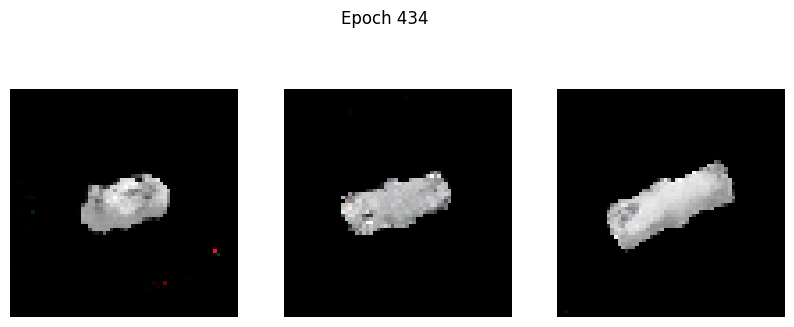

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0393 - g_loss: 5.4459
Epoch 435/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0040 - g_loss: 5.9775

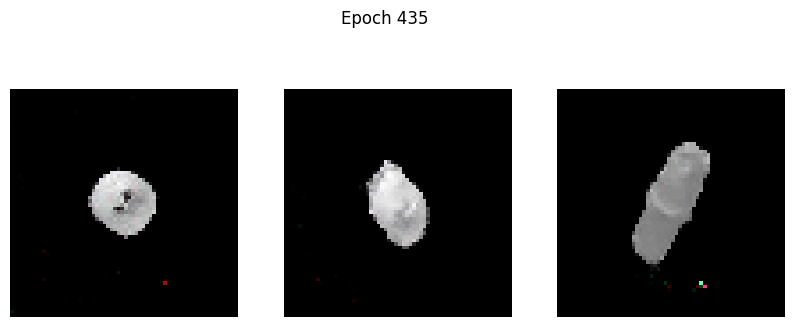

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0038 - g_loss: 5.9737
Epoch 436/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0358 - g_loss: 5.7220

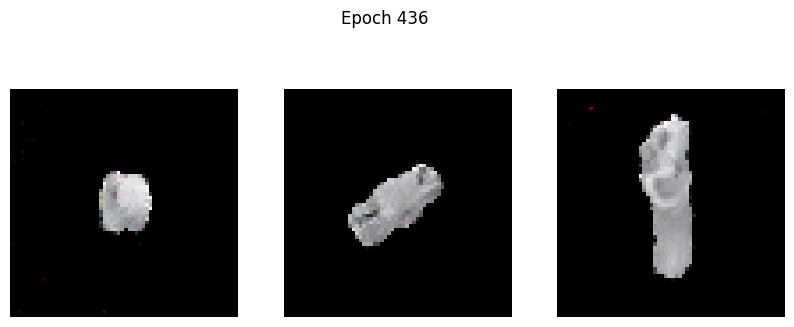

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0356 - g_loss: 5.7223
Epoch 437/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0424 - g_loss: 5.5160

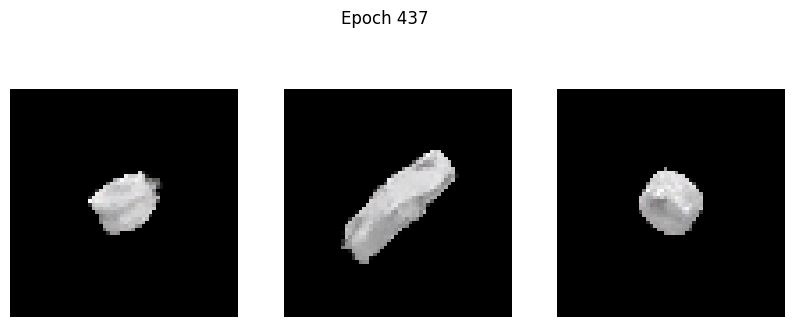

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0423 - g_loss: 5.5157
Epoch 438/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0092 - g_loss: 6.0221

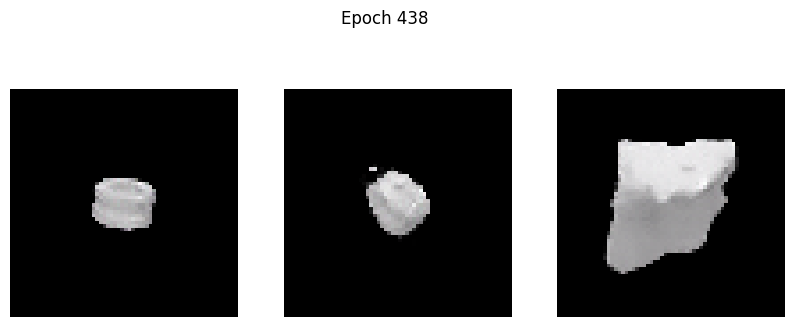

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0094 - g_loss: 6.0202
Epoch 439/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0775 - g_loss: 5.4713

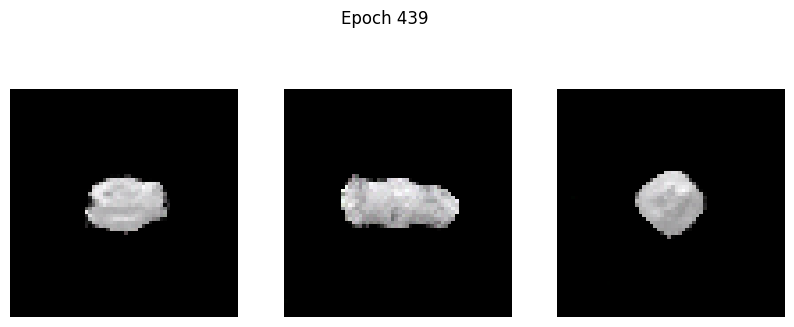

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0775 - g_loss: 5.4711
Epoch 440/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0238 - g_loss: 6.3017

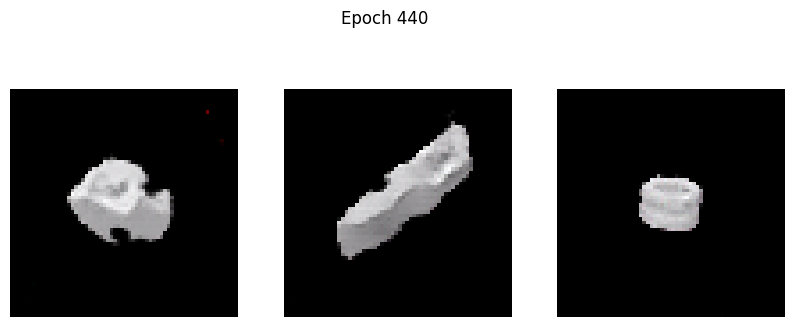

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0239 - g_loss: 6.2986
Epoch 441/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0288 - g_loss: 5.9827

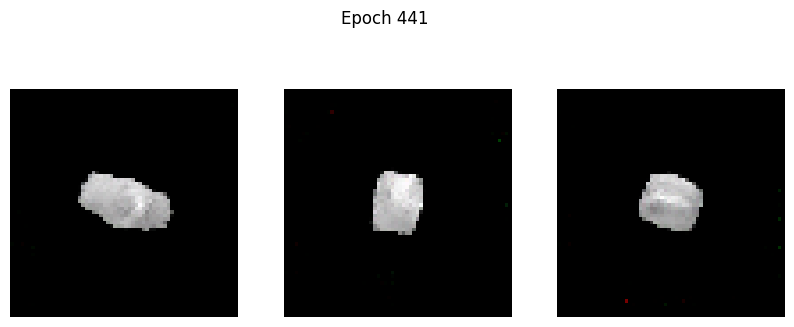

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0291 - g_loss: 5.9841
Epoch 442/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0154 - g_loss: 5.7591

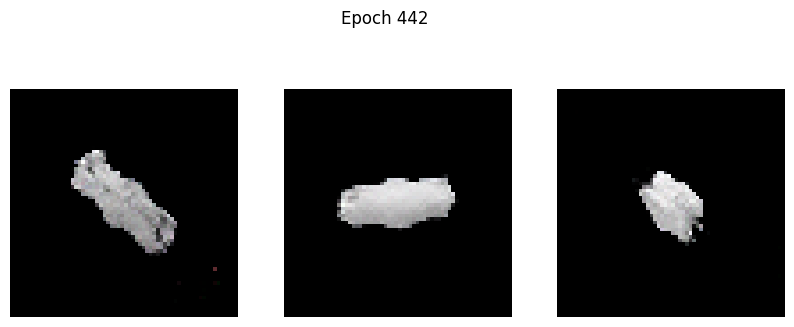

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0153 - g_loss: 5.7583
Epoch 443/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0552 - g_loss: 5.4361

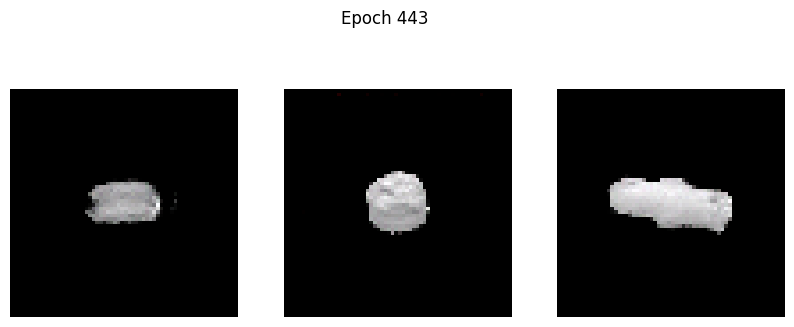

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0550 - g_loss: 5.4381
Epoch 444/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0099 - g_loss: 6.1578

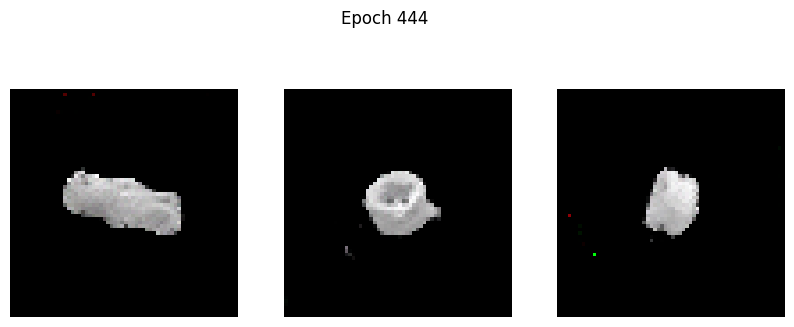

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0099 - g_loss: 6.1575
Epoch 445/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0017 - g_loss: 5.9108

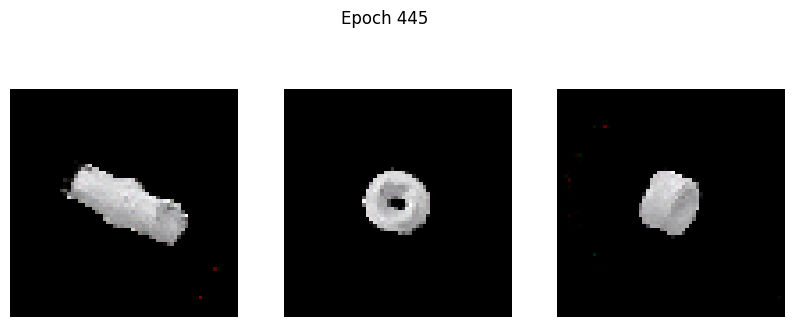

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0015 - g_loss: 5.9081
Epoch 446/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.1083 - g_loss: 5.4037

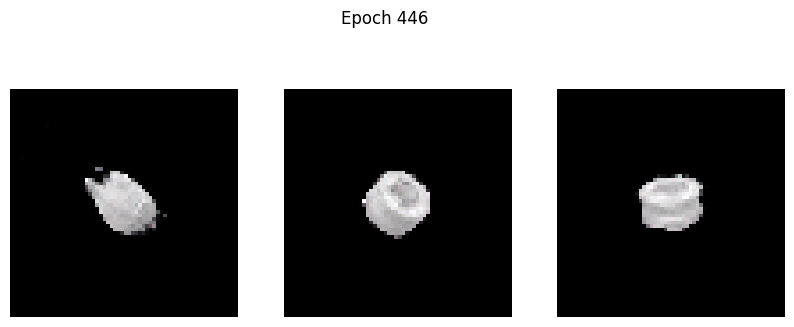

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.1081 - g_loss: 5.4044
Epoch 447/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 8.2957e-04 - g_loss: 5.7825

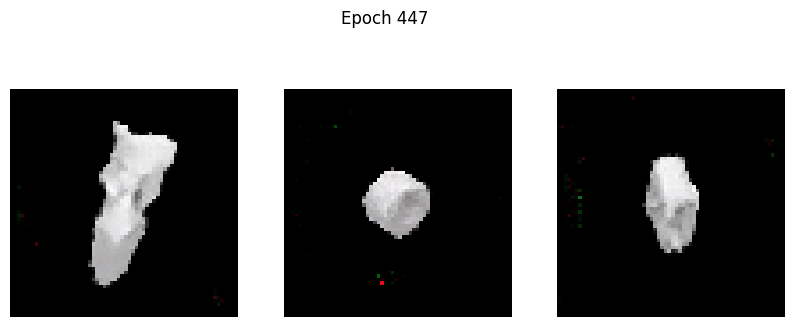

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 5.9606e-04 - g_loss: 5.7807
Epoch 448/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0133 - g_loss: 6.1760

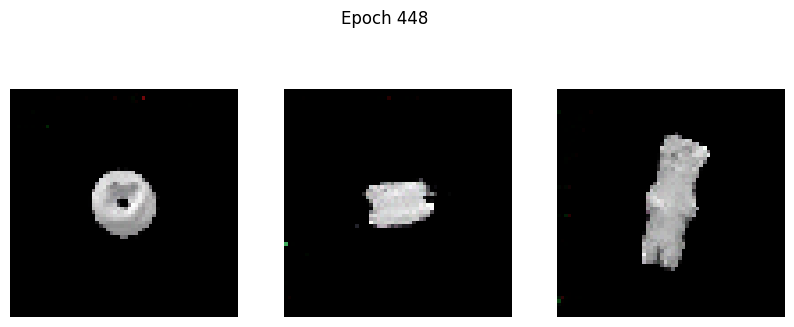

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0135 - g_loss: 6.1722
Epoch 449/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0691 - g_loss: 5.9128

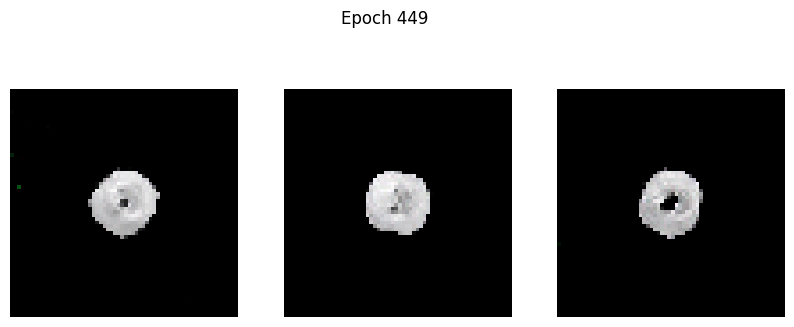

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0688 - g_loss: 5.9139
Epoch 450/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0692 - g_loss: 5.8834

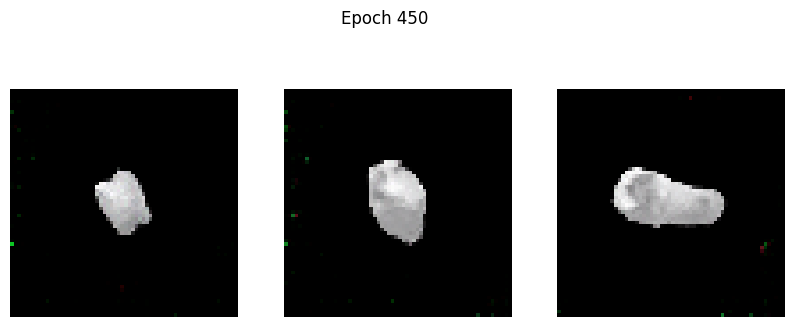

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0690 - g_loss: 5.8834
Epoch 451/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0090 - g_loss: 6.3589

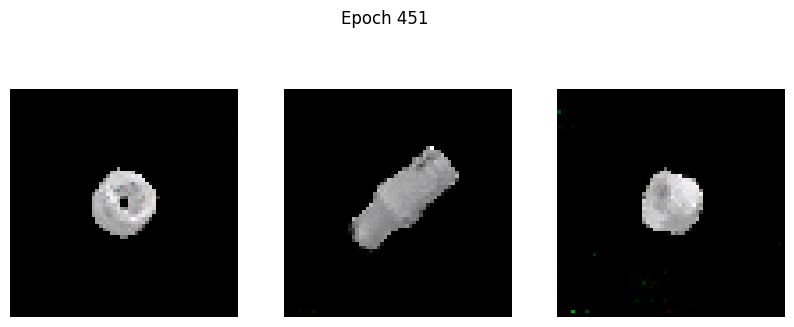

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0088 - g_loss: 6.3562
Epoch 452/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0517 - g_loss: 5.6965

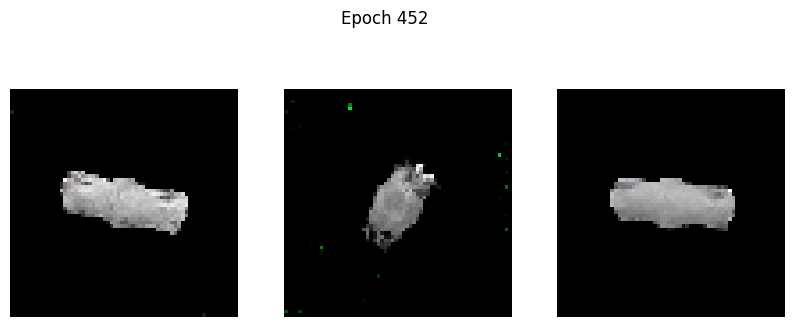

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0518 - g_loss: 5.6972
Epoch 453/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0106 - g_loss: 5.9563

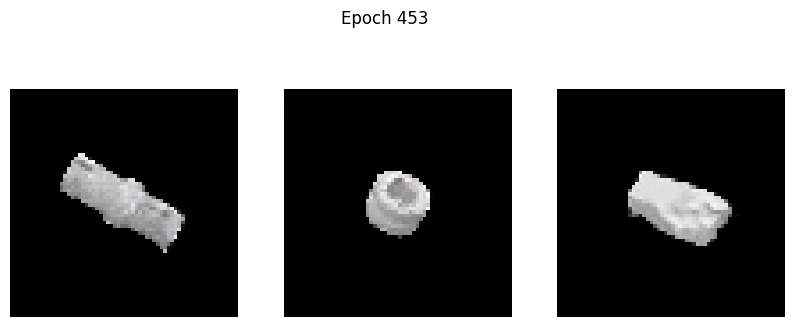

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0109 - g_loss: 5.9580
Epoch 454/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0759 - g_loss: 5.6606

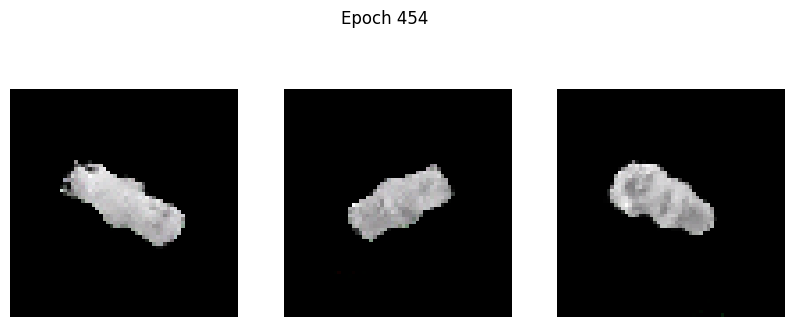

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0755 - g_loss: 5.6639
Epoch 455/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1428 - g_loss: 7.0102

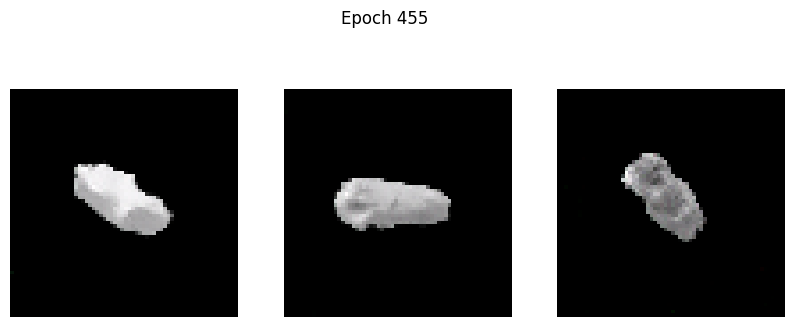

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1413 - g_loss: 7.0009
Epoch 456/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0526 - g_loss: 6.0298

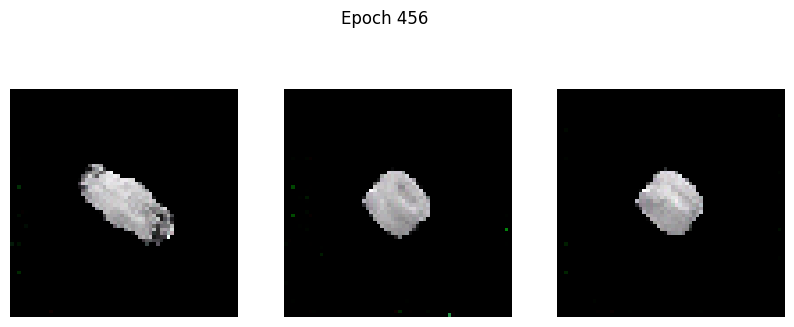

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0525 - g_loss: 6.0303
Epoch 457/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0927 - g_loss: 5.6691

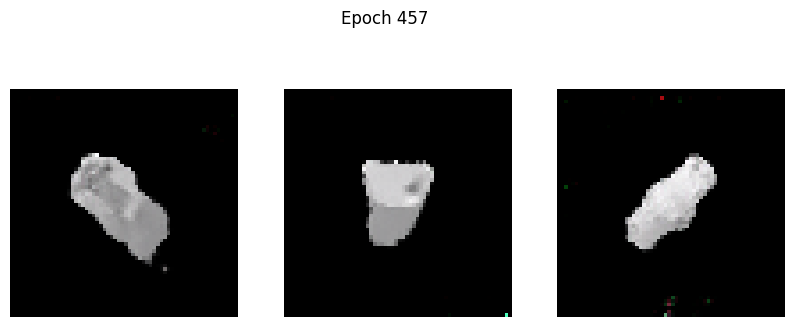

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0924 - g_loss: 5.6722
Epoch 458/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0802 - g_loss: 6.0030

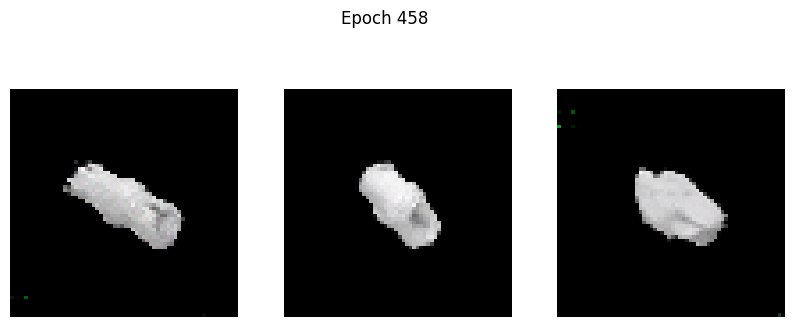

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0798 - g_loss: 6.0056
Epoch 459/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.1004 - g_loss: 5.8133

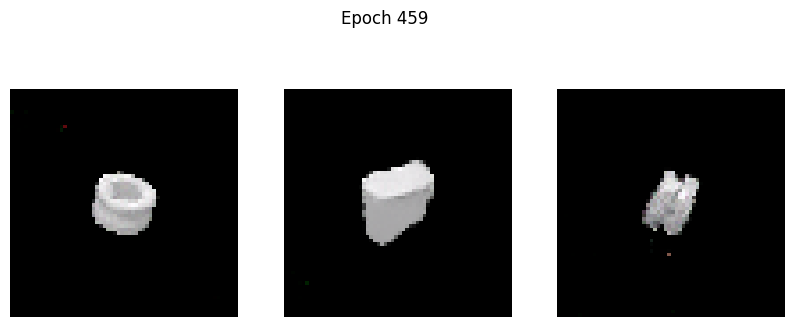

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.1001 - g_loss: 5.8146
Epoch 460/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.1167 - g_loss: 5.7018

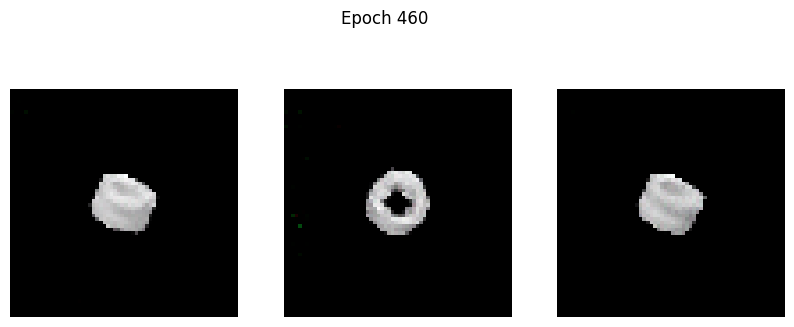

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.1162 - g_loss: 5.7041
Epoch 461/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0056 - g_loss: 6.6755

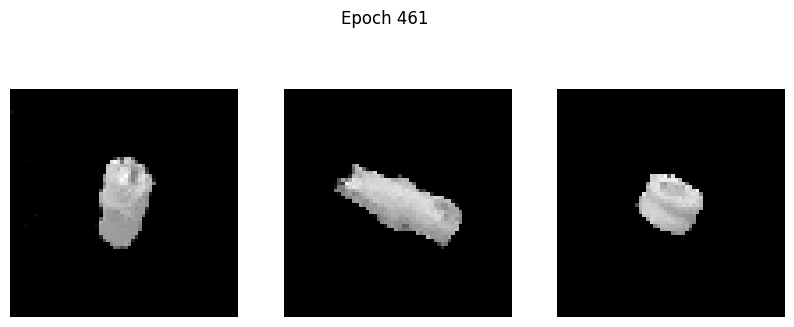

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.0050 - g_loss: 6.6688
Epoch 462/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0868 - g_loss: 5.8411

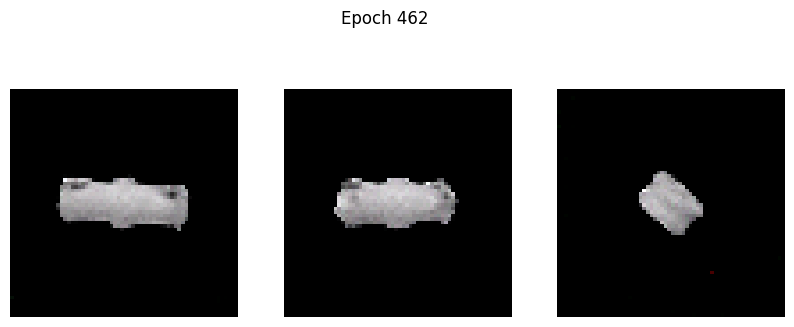

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0865 - g_loss: 5.8439
Epoch 463/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.1341 - g_loss: 5.6775

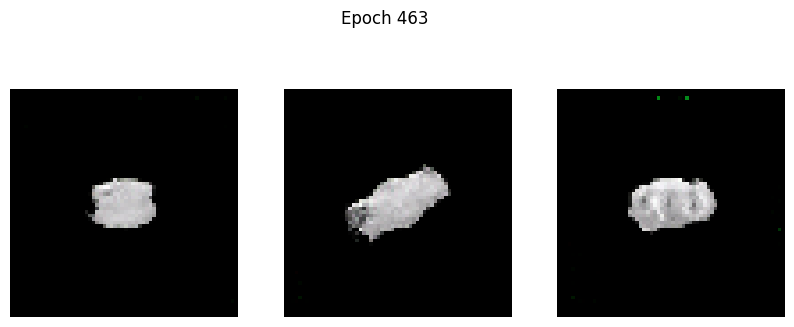

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.1334 - g_loss: 5.6827
Epoch 464/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0347 - g_loss: 6.2512

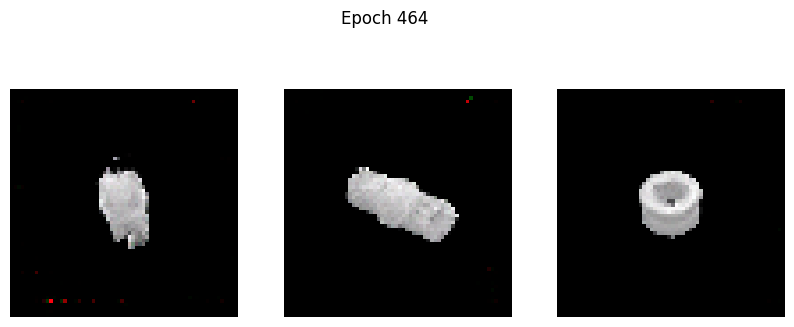

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0348 - g_loss: 6.2522
Epoch 465/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0588 - g_loss: 6.0353

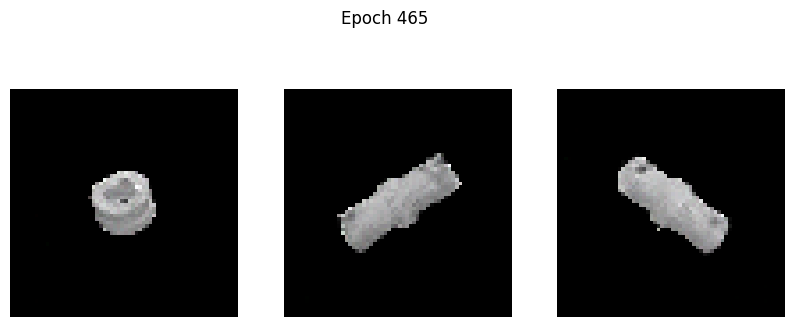

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0587 - g_loss: 6.0371
Epoch 466/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.1301 - g_loss: 6.0499

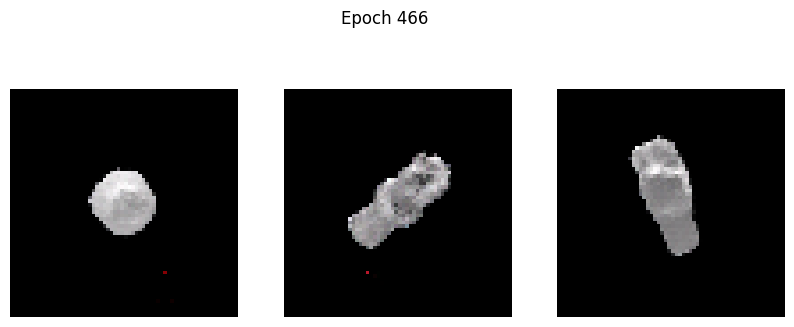

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.1303 - g_loss: 6.0488
Epoch 467/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0404 - g_loss: 6.3424

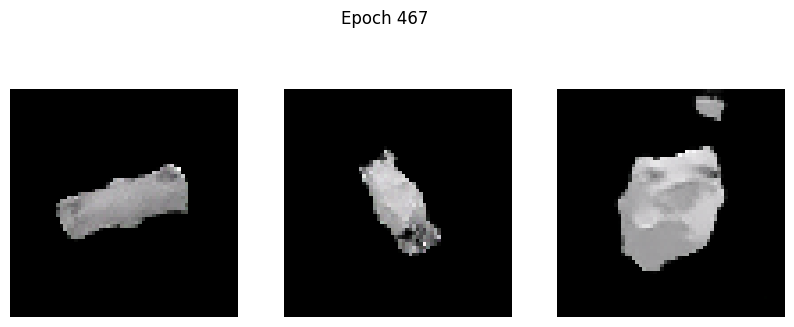

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0403 - g_loss: 6.3416
Epoch 468/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.1630 - g_loss: 5.7802

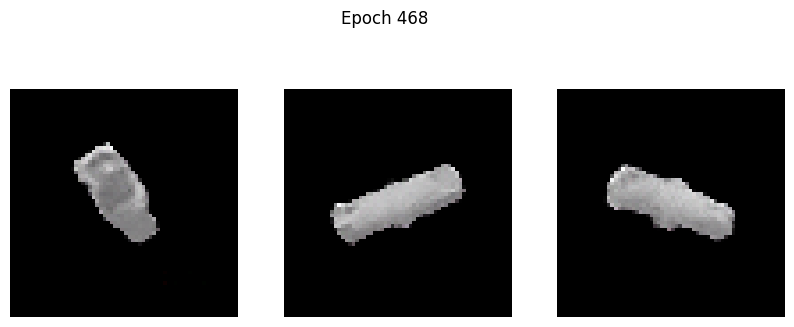

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - d_loss: -0.1627 - g_loss: 5.7804
Epoch 469/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: -0.0492 - g_loss: 6.3969

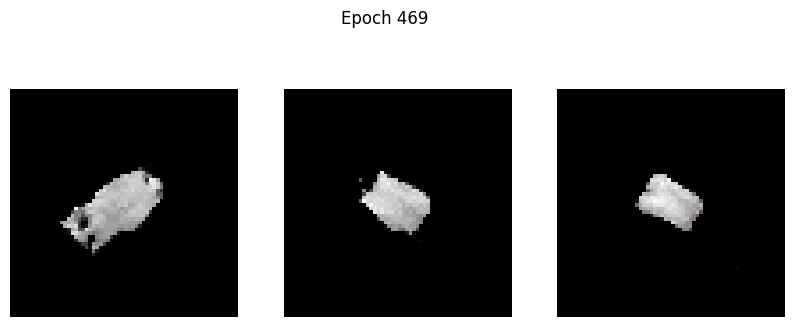

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: -0.0490 - g_loss: 6.3983
Epoch 470/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: 0.0025 - g_loss: 6.5319

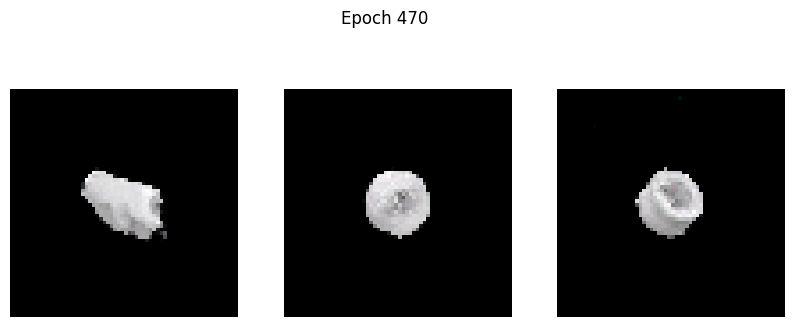

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.0022 - g_loss: 6.5318
Epoch 471/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.1248 - g_loss: 6.2114

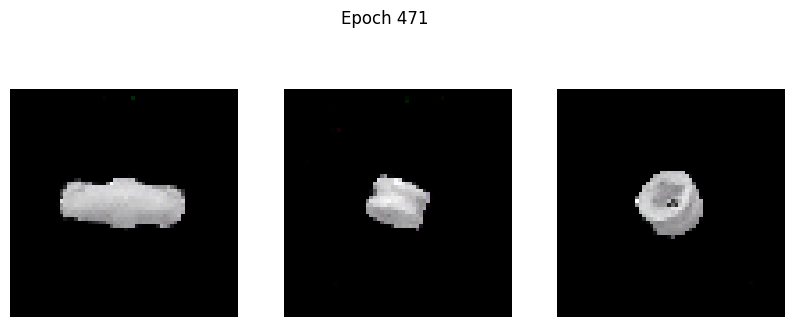

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.1243 - g_loss: 6.2140
Epoch 472/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0143 - g_loss: 6.8828

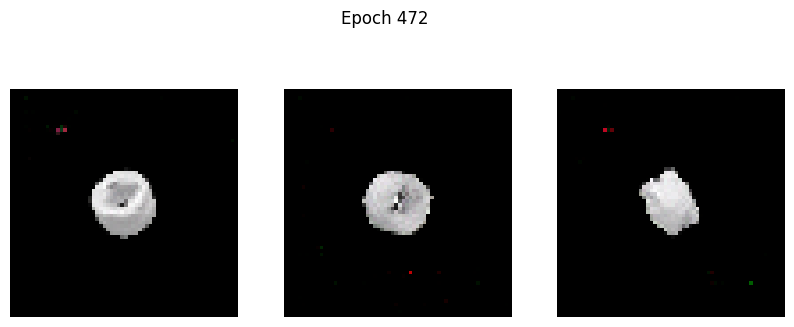

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0137 - g_loss: 6.8783
Epoch 473/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.1107 - g_loss: 6.3775

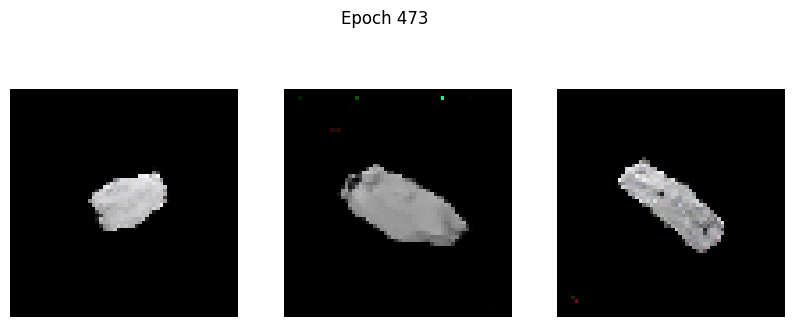

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.1099 - g_loss: 6.3814
Epoch 474/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0326 - g_loss: 6.5639

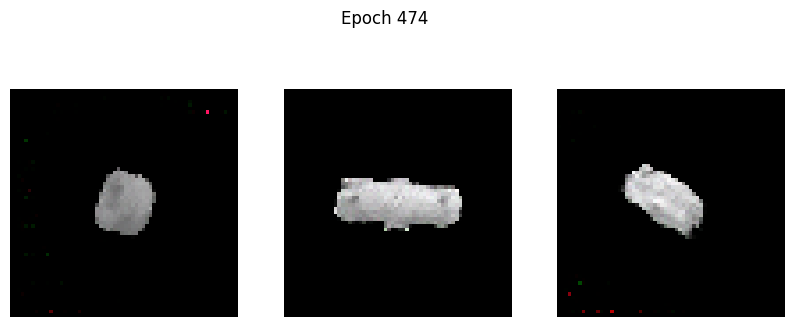

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0331 - g_loss: 6.5607
Epoch 475/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.1148 - g_loss: 6.4248

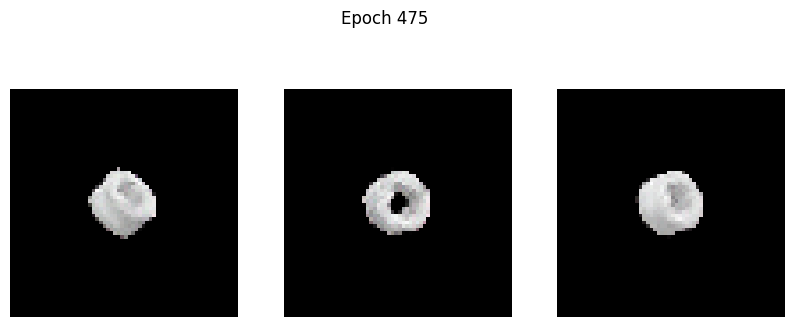

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.1145 - g_loss: 6.4284
Epoch 476/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.1165 - g_loss: 6.1837

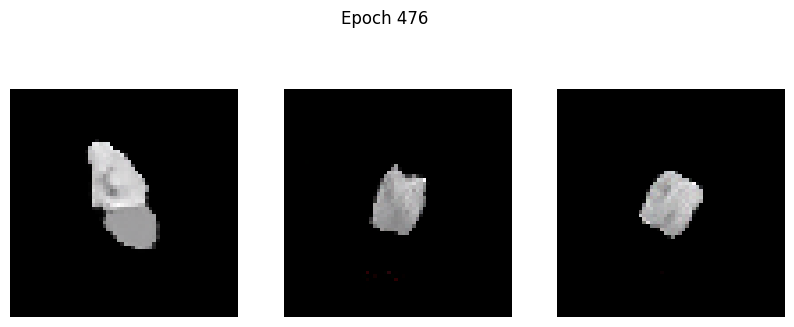

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.1164 - g_loss: 6.1837
Epoch 477/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.1152 - g_loss: 6.3006

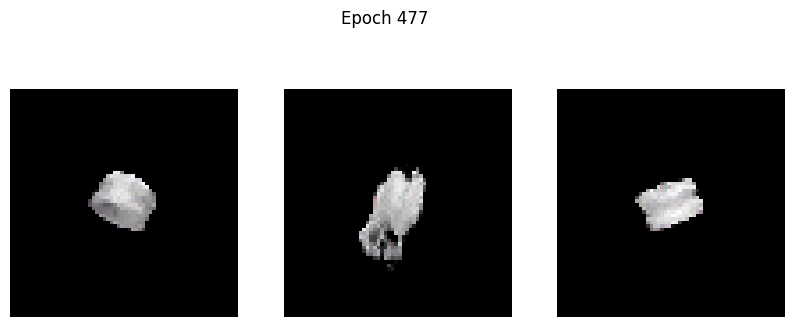

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.1147 - g_loss: 6.3041
Epoch 478/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0670 - g_loss: 6.5611

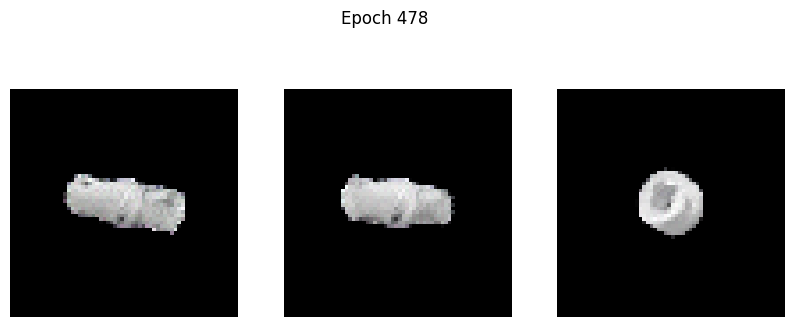

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0671 - g_loss: 6.5602
Epoch 479/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.1233 - g_loss: 5.8663

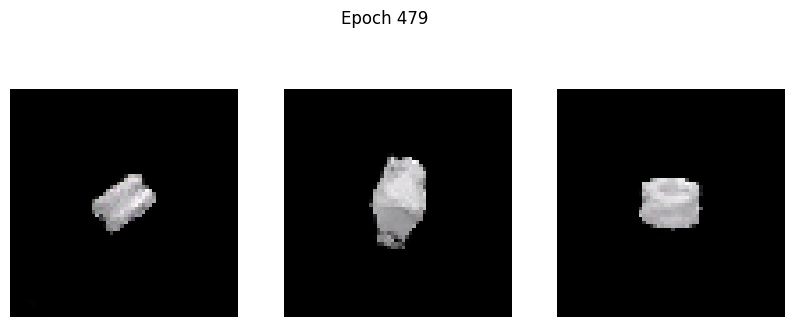

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.1233 - g_loss: 5.8690
Epoch 480/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.1205 - g_loss: 6.7406

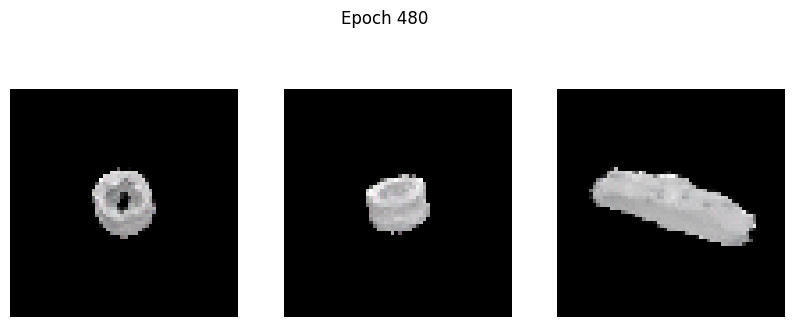

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.1200 - g_loss: 6.7406
Epoch 481/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.1269 - g_loss: 6.5472

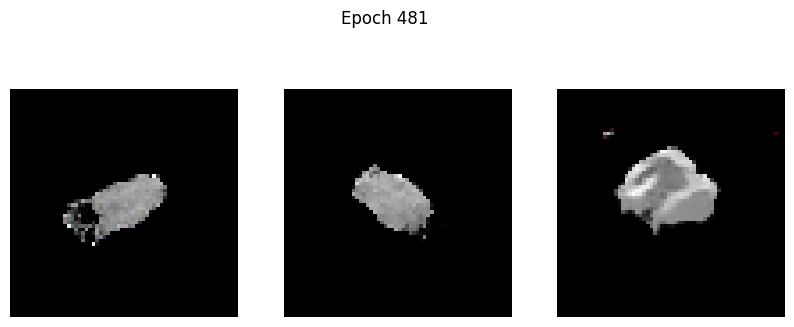

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.1261 - g_loss: 6.5520
Epoch 482/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0702 - g_loss: 7.1972

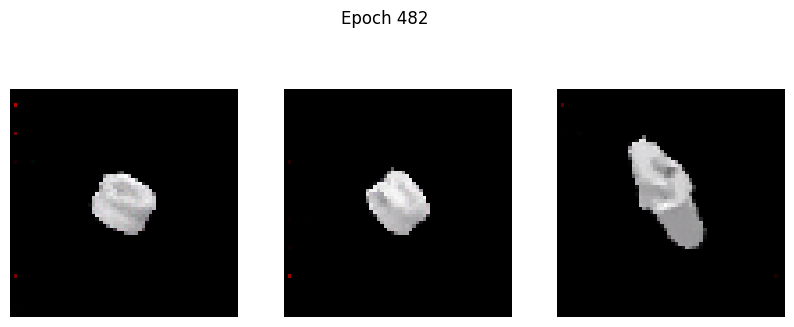

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0706 - g_loss: 7.1920
Epoch 483/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.1366 - g_loss: 6.8390

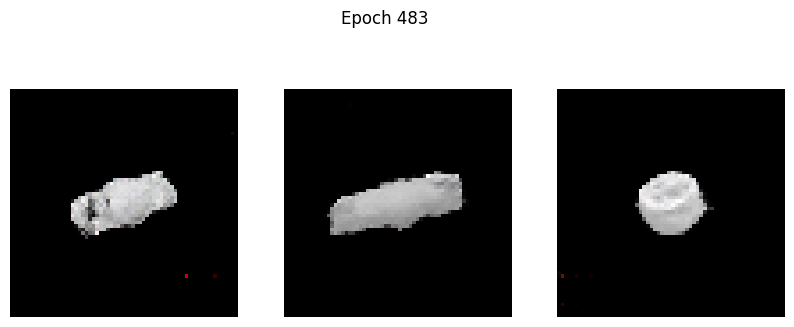

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.1366 - g_loss: 6.8348
Epoch 484/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.1750 - g_loss: 6.1899

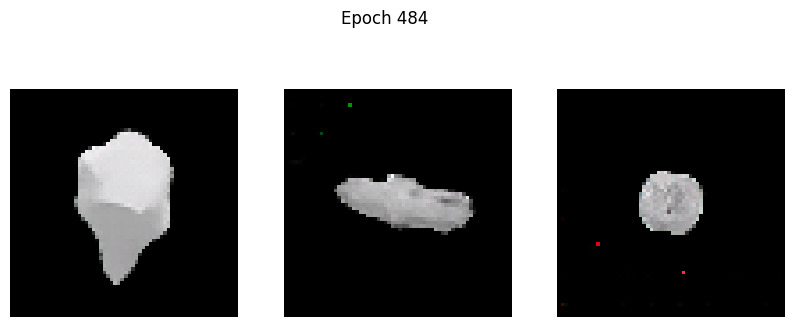

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.1744 - g_loss: 6.1921
Epoch 485/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0948 - g_loss: 6.5017

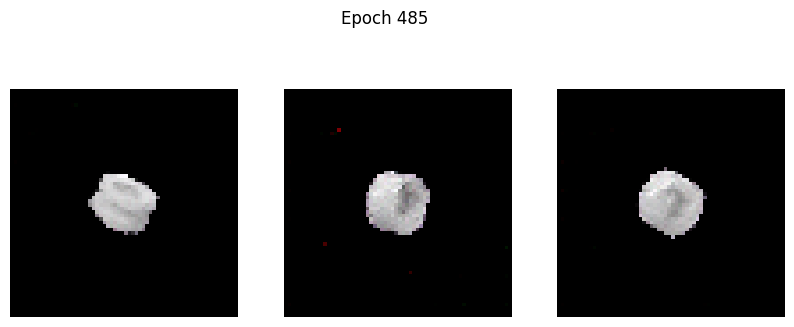

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0944 - g_loss: 6.5037
Epoch 486/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0491 - g_loss: 6.9963

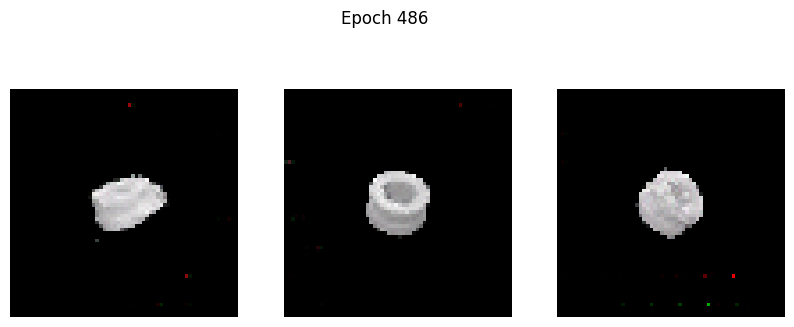

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0492 - g_loss: 6.9949
Epoch 487/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.1206 - g_loss: 6.4855

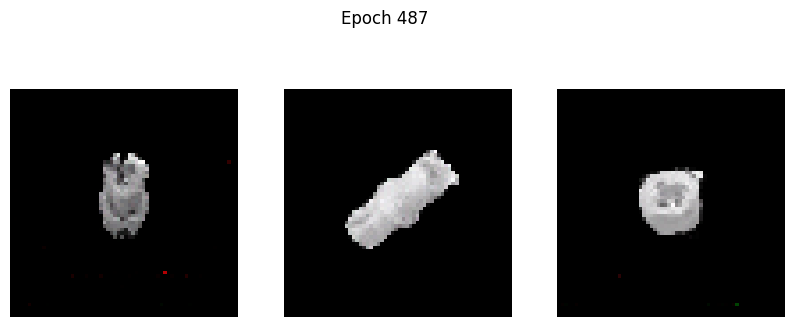

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.1208 - g_loss: 6.4832
Epoch 488/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0505 - g_loss: 7.1060

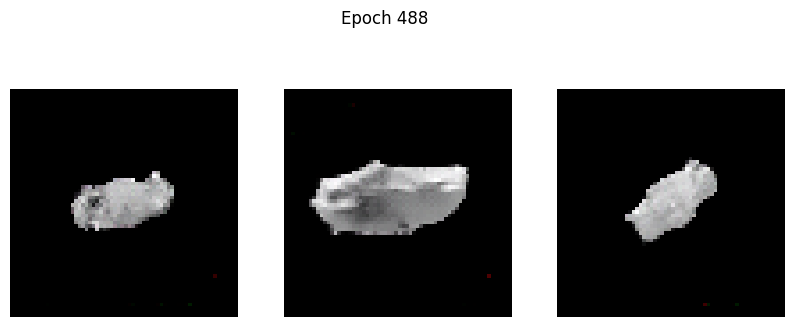

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0507 - g_loss: 7.1037
Epoch 489/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0507 - g_loss: 6.9736

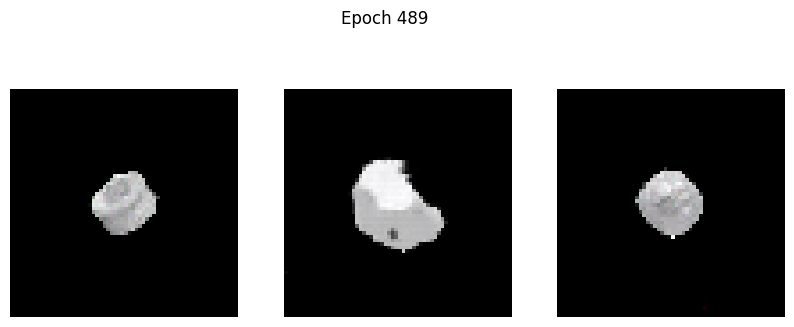

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0509 - g_loss: 6.9744
Epoch 490/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0438 - g_loss: 7.4592

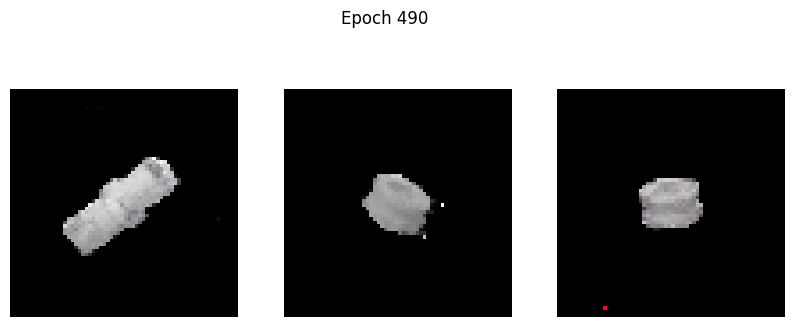

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0428 - g_loss: 7.4542
Epoch 491/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.1513 - g_loss: 6.8145

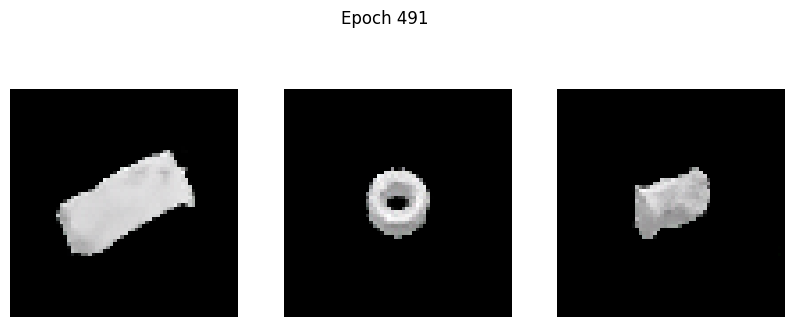

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.1512 - g_loss: 6.8143
Epoch 492/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.2034 - g_loss: 6.7337

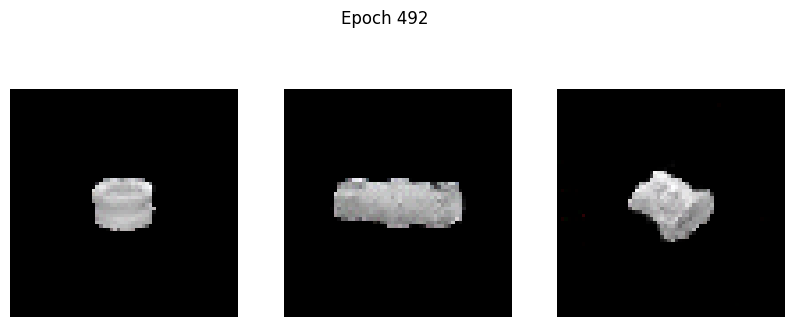

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.2030 - g_loss: 6.7343
Epoch 493/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.1590 - g_loss: 6.7574

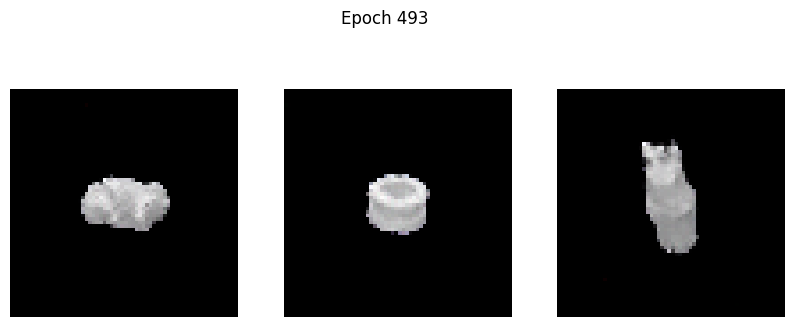

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.1583 - g_loss: 6.7632
Epoch 494/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.1216 - g_loss: 6.7870

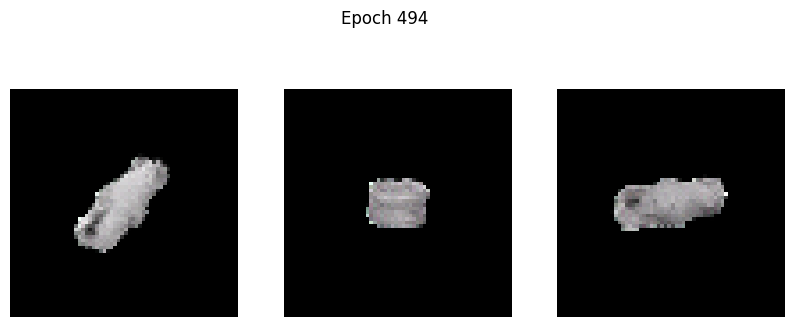

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.1204 - g_loss: 6.7994
Epoch 495/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.1310 - g_loss: 6.7840

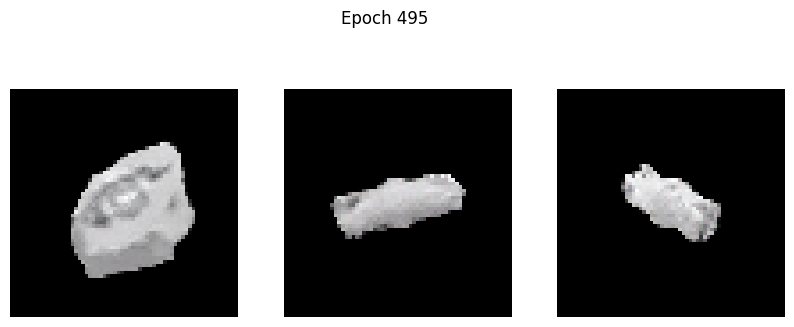

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.1314 - g_loss: 6.7823
Epoch 496/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.1061 - g_loss: 6.9011

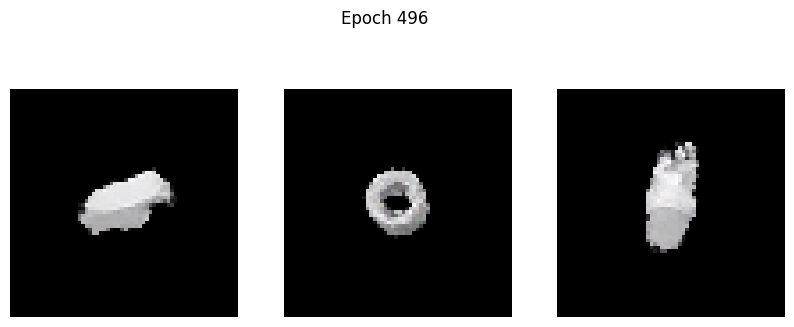

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.1062 - g_loss: 6.9010
Epoch 497/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.1118 - g_loss: 6.4345

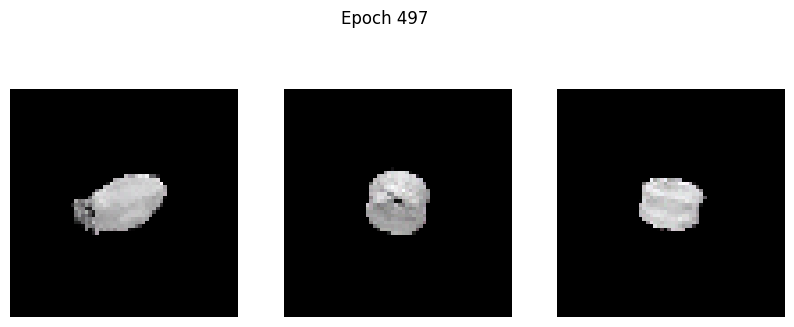

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.1121 - g_loss: 6.4366
Epoch 498/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.1717 - g_loss: 6.8184

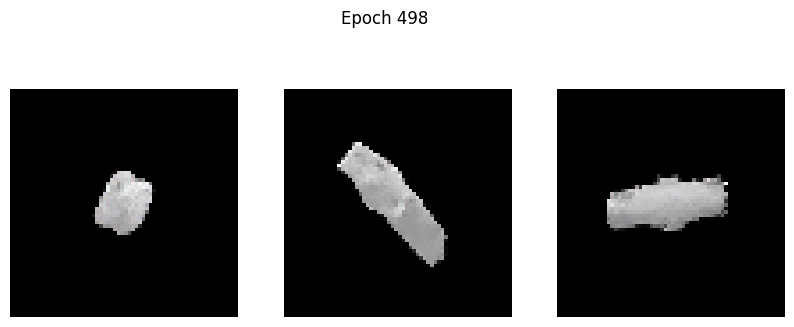

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.1714 - g_loss: 6.8204
Epoch 499/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.2116 - g_loss: 6.4017

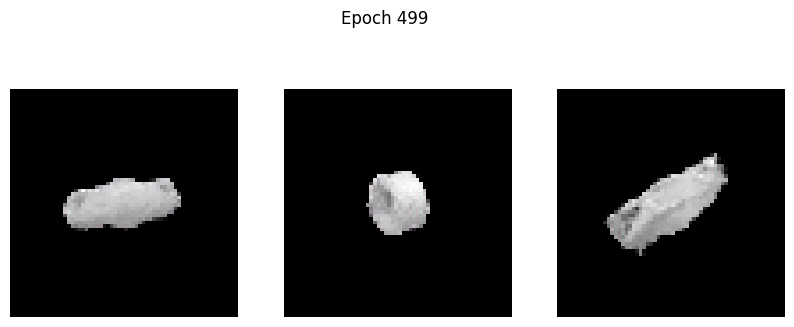

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.2112 - g_loss: 6.4047
Epoch 500/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.1768 - g_loss: 6.8686

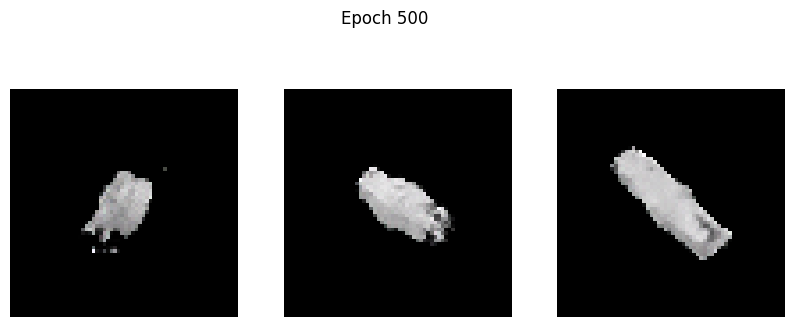

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.1771 - g_loss: 6.8684


In [9]:
# Hyperparameters
EPOCHS = 500  # Tambahkan jumlah epoch untuk hasil lebih baik (misal: 100-200)
lr_generator = 0.0002
lr_discriminator = 0.0002

# Inisialisasi DCGAN
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

# Compile
dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=lr_discriminator, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=lr_generator, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

# Jalankan Training
print("Mulai Training...")
dcgan.fit(
    train_dataset,
    epochs=EPOCHS,
    callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

latent_dim = 128

In [16]:
# Asumsi: Variabel 'generator' adalah model Keras yang sudah terlatih.
try:
    generator.save('generator_model.keras')
    print("Generator model saved successfully as 'generator_model.keras'")
except Exception as e:
    print(f"Error saving generator model: {e}")

Generator model saved successfully as 'generator_model.keras'


In [17]:
print("\n--- Memuat Model Generator yang Tersimpan ---")

try:
    loaded_generator = tf.keras.models.load_model('generator_model.keras')
    print("Generator model loaded successfully.")
except Exception as e:
    print(f"Error loading generator model: {e}")
    loaded_generator = None


--- Memuat Model Generator yang Tersimpan ---
Generator model loaded successfully.



--- 3. Generasi 5 Gambar Baru Acak ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


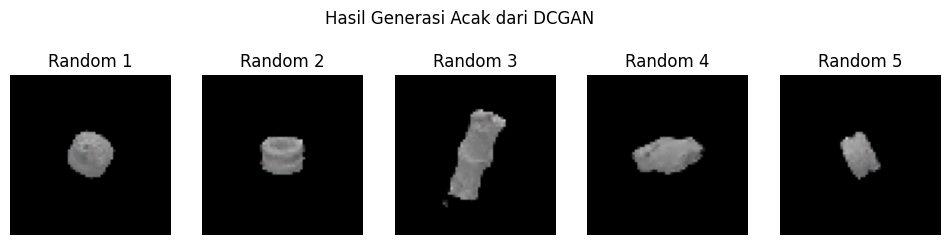

In [18]:
num_images = 5

print(f"\n--- 3. Generasi {num_images} Gambar Baru Acak ---")

if loaded_generator is not None:
    # 1. Buat 5 vektor random noise
    noise_input_random = np.random.normal(0, 1, size=(num_images, latent_dim))

    # 2. Generator menghasilkan gambar (prediksi)
    generated_images_random = loaded_generator.predict(noise_input_random)

    # 3. Denormalisasi dan Tampilkan/Plot Gambar

    # KEMUNGKINAN DENORMALISASI: Jika output generator Anda [-1, 1], gunakan baris ini:
    generated_images_random = (generated_images_random + 1) / 2.0
    # Jika output generator Anda [0, 1], abaikan baris di atas.

    plt.figure(figsize=(12, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        image = generated_images_random[i, :, :, :]
        plt.imshow(image)
        plt.title(f'Random {i+1}')
        plt.axis('off')

    plt.suptitle("Hasil Generasi Acak dari DCGAN")
    plt.show()


--- 4. Generasi 5 Gambar dengan Latent Space Interpolation ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


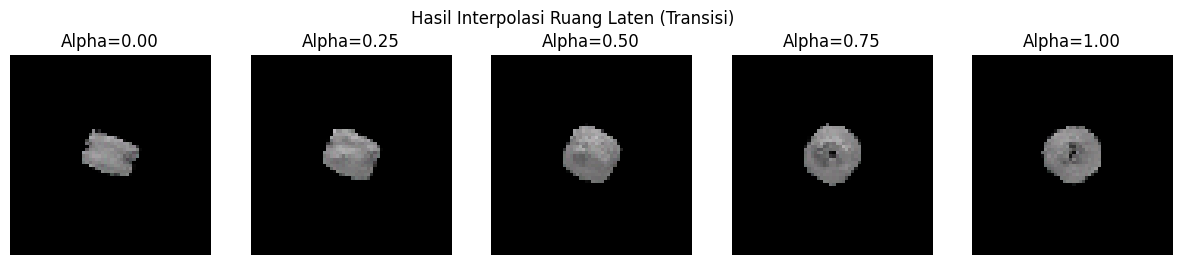

In [19]:
print(f"\n--- 4. Generasi 5 Gambar dengan Latent Space Interpolation ---")

if loaded_generator is not None:
    # 1. Tentukan dua vektor latent acak (titik awal z_A dan titik akhir z_B)
    z_A = np.random.normal(0, 1, size=(1, latent_dim))
    z_B = np.random.normal(0, 1, size=(1, latent_dim))

    # Kita ingin 5 gambar interpolasi. Kita gunakan 5 langkah (alpha) antara 0 dan 1.
    num_interpolated_steps = 5
    alphas = np.linspace(0.0, 1.0, num_interpolated_steps)

    interpolated_vectors = []
    for alpha in alphas:
        # Rumus interpolasi linier: z_interp = (1 - alpha) * z_A + alpha * z_B
        z_interp = (1 - alpha) * z_A + alpha * z_B
        interpolated_vectors.append(z_interp)

    # Gabungkan vektor interpolasi menjadi satu array
    interpolated_input = np.vstack(interpolated_vectors)

    # 2. Generator menghasilkan gambar
    interpolated_images = loaded_generator.predict(interpolated_input)

    # 3. Denormalisasi dari [-1, 1] ke [0, 1]
    interpolated_images = (interpolated_images + 1.0) / 2.0

    # 4. Tampilkan Gambar
    plt.figure(figsize=(15, 3))
    for i in range(num_interpolated_steps):
        plt.subplot(1, num_interpolated_steps, i + 1)
        image = interpolated_images[i]
        plt.imshow(image)
        # Menampilkan bobot alpha untuk menunjukkan transisi
        plt.title(f'Alpha={alphas[i]:.2f}')
        plt.axis('off')

    plt.suptitle("Hasil Interpolasi Ruang Laten (Transisi)")
    plt.show()